In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
path_to_Chatbot_data = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'

In [3]:
path_to_Chatbot_data

'/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv'

In [4]:
data = pd.read_csv(path_to_Chatbot_data)

In [5]:
len(data)

11823

In [6]:
data['Q'] = data['Q'].str.strip()
data['A'] = data['A'].str.strip()
data.replace('', np.nan, inplace=True)

In [7]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [8]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [9]:
data.dropna(inplace=True)

In [10]:
okt = Okt()

In [11]:
def preprocess_sentence(sentence):
    # 입력받은 sentence의 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    #  a-z, A-Z, ".", "?", "!", ",", 한글을 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^a-zA-Z?.!,ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", sentence)
    
#     sentence = " ".join(okt.morphs(sentence, stem=True))  # 어간 추출 옵션
    
    sentence = sentence.strip()
    return sentence

In [12]:
# 데이터 로드 함수
def load_conversations(data):
    inputs, outputs = [], []
    
    for i in range(len(data)):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용
        inputs.append(preprocess_sentence(data['Q'].iloc[i]))
        outputs.append(preprocess_sentence(data['A'].iloc[i]))
        
    return inputs, outputs

In [13]:
questions, answers = load_conversations(data)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [14]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [15]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [16]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [17]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8141]
END_TOKEN의 번호 : [8142]


In [18]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8143


In [19]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5748, 610, 2487, 4153]
정수 인코딩 후의 21번째 답변 샘플: [2354, 7492, 7, 6256, 97, 1]


In [22]:
len(answers)

11823

In [23]:
len(tokenizer.encode(answers))

TypeError: Expected binary or unicode string, got ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '다시 새로 사는 게 마음 편해요 .', '다시 새로 사는 게 마음 편해요 .', '잘 모르고 있을 수도 있어요 .', '시간을 정하고 해보세요 .', '시간을 정하고 해보세요 .', '자랑하는 자리니까요 .', '그 사람도 그럴 거예요 .', '그 사람도 그럴 거예요 .', '혼자를 즐기세요 .', '돈은 다시 들어올 거예요 .', '땀을 식혀주세요 .', '어서 잊고 새출발 하세요 .', '빨리 집에 돌아가서 끄고 나오세요 .', '빨리 집에 돌아가서 끄고 나오세요 .', '다음 달에는 더 절약해봐요 .', '따뜻하게 사세요 !', '다음 달에는 더 절약해봐요 .', '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요', '더 가까워질 기회가 되겠네요 .', '저도요 .', '다들 바빠서 이야기할 시간이 부족했나봐요 .', '다들 바빠서 이야기할 시간이 부족했나봐요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '좋은 생각이에요 .', '더 가까워질 기회가 되겠네요 .', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요', '좋은 생각이에요 .', '정말 후회할 습관이에요 .', '무모한 결정을 내리지 마세요 .', '선생님이나 기관에 연락해보세요 .', '떨리는 감정은 그 자체로 소중해요 .', '득템했길 바라요 .', '휴식도 필요하죠 .', '단짠으로 두 개 사는게 진리죠 .', '단짠으로 두 개 사는게 진리죠 .', '맛있게 드세요 .', '저도 싫어요 .', '가세요 .', '가세요 .', '맛있게 드세요 .', '맛있게 드세요 .', '병원가세요 .', '이럴 때 잘 쉬는 게 중요해요 .', '이럴 때 잘 쉬는 게 중요해요 .', '이럴 때 잘 쉬는 게 중요해요 .', '따뜻하게 관리하세요 .', '병원가세요 .', '병원가세요 .', '저도 듣고 싶네요 .', '자신을 더 사랑해주세요 .', '그건 습관이에요 .', '그건 습관이에요 .', '콕 집어서 물어보세요 .', '좋은 생각만 하세요 .', '마음이 아픈가요 .', '갑작스러웠나봐요 .', '관계의 변화가 왔나봅니다 .', '처음 초가 중요해요 . 당신의 매력을 어필해보세요 .', '책임질 수 있을 때 키워 보세요 .', '먼저 생활패턴을 살펴 보세요 .', '먼저 생활패턴을 살펴 보세요 .', '책임질 수 있을 때 키워 보세요 .', '아름다운 곳이죠 .', '안 될 것도 없죠 .', '혼자도 좋아요 .', '연인은 살쪄도 잘 알아차리지 못하고 알아차려도 싫어하지 않을 거예요 .', '즐거운 시간 보내고 오세요 !', '질질 끌지 마세요 .', '말해보세요 .', '함께하면 서로를 더 많이 알게 될 거예요 .', '개시해보세요 .', '개시해보세요 .', '곧 방학이예요 .', '방학이 참 짧죠 .', '벗어나는 게 좋겠네요 .', '벗어나는 게 좋겠네요 .', '세수하고 오세요 .', '그게 제일 중요한 건데요 .', '그게 제일 중요한 건데요 .', '다음부터는 더 많이 아세요 .', '갑작스러웠나봐요 .', '공적인 일부터 하세요 .', '공적인 일부터 하세요 .', '낮잠을 잠깐 자도 괜찮아요 .', '저도 좋아해주세요 .', '친구들이 보고싶었나봐요 .', '되도록 만나지 마세요 .', '당신이요 .', '당신의 운을 믿어보세요 .', '일 못하는 사람이 있으면 옆에 있는 사람이 더 힘들죠 .', '밥 사줄 친구를 찾아 보세요', '선의의 거짓말이길 바라요 .', '거짓말은 할수록 늘어요 .', '거짓말은 할수록 늘어요 .', '진실된 말을 하려고 노력해보세요 .', '누구나 걱정은 있어요 .', '누구나 걱정은 있어요 .', '운동을 해보세요 .', '세상의 무엇보다 건강이 제일 중요해요 .', '주기적으로 해주는 게 좋죠 .', '주기적으로 해주는 게 좋죠 .', '가장 중요한 목표네요 .', '가장 중요한 목표네요 .', '적게 먹고 많이 움직이세요 .', '적게 먹고 많이 움직이세요 .', '모르는 사이라 당황할 수도 있어요 .', '이룰 수 있을 거예요 .', '이룰 수 있을 거예요 .', '기분이 나쁘셨나봐요 .', '있으면 편하대요 .', '눈을 깜빡거려 보세요 .', '청소를 좋아하시나봐요 .', '안전 귀가 하세요 .', '용기 내보세요 .', '피해를 안 준다면 무시하세요 .', '안 될 것도 없죠 .', '게임할때는 시간이 더 빨리 가요 .', '정리해보세요 .', '게임하세요 !', '다른 게임해보세요 .', '다른 게임해보세요 .', '게임하세요 !', '게임할때는 시간이 더 빨리 가요 .', '마음에도 봄이 오길 바라요 .', '몸은 뜨겁고 머리는 차갑게 !', '마음에도 봄이 오길 바라요 .', '잘하실 거예요 !', '잘하실 거예요 !', '건강 생각해서 챙겨드세요 .', '좋은 운명도 있을거예요 .', '결정하기 힘드시겠네요 .', '자신을 위한 결정을 내리길 바라요 .', '자신을 위한 결정을 내리길 바라요 .', '결정은 빠르면 빠를수록 좋을 거예요 .', '안타깝네요 . 증거를 지금이라도 모아봐요 .', '좋겠어요 .', '좋겠어요 .', '많이 들지만 줄일 수 있을 거예요 .', '경조사는 참석하는게 좋아요 .', '경조사는 참석하는게 좋아요 .', '생각보다 신경 안 씁니다 .', '인맥이 넓으신가봐요 .', '힘들겠네요 .', '많이 들지만 줄일 수 있을 거예요 .', '욕심에 따라 천지 차이일 거예요 .', '허례허식이에요 .', '욕심에 따라 천지 차이일 거예요 .', '해봐요 .', '서로 노력하면 행복할 거예요 .', '서로 노력하면 행복할 거예요 .', '사람마다 행복의 크기가 다르겠지만 행복할 거예요 .', '사람마다 행복의 크기가 다르겠지만 행복할 거예요 .', '능력이 있으면 하면 되죠 .', '능력이 있으면 하면 되죠 .', '이사람이다 싶은 사람이랑 하세요 .', '해봐요 .', '점점 치열해지는 것 같아요 .', '확신이 없나봐요 .', '안정적인 걸 좋아하나봐요 .', '방학은 참 짧아요 .', '보러 가세요 .', '보러 가세요 .', '계속 좋지 않으면 병원에 가보세요 .', '타이밍이 안 맞았나봐요 .', '이제 취업 하셔야죠 .', '뇌세포에 에너지를 공급하려는 자연스러운 현상이에요 . 에너지가 부족한가봐요 .', '공부가 최우선이죠 .', '공부가 최우선이죠 .', '너무 무리하지는 마세요 .', '너무 무리하지는 마세요 .', '저기압에는 고기앞이죠 .', '저기압에는 고기앞이죠 .', '연습이 필요해요 .', '연습이 필요해요 .', '혼자가 아니에요 .', '인복이 많나봐요 .', '너무 걱정하지 마세요 .', '네 말씀하세요 .', '네 말씀하세요 .', '후회는 후회를 낳을뿐이에요 . 용기 내세요 .', '돈을 모아서 다른 곳으로 이사갈 수 있을 거예요 .', '돈을 모아서 다른 곳으로 이사갈 수 있을 거예요 .', '더 좋은 곳에서 살 수 있을 거예요 .', '더 좋은 곳에서 살 수 있을 거예요 .', '완전 귀엽죠 ?', '자신을 먼저 키우세요 .', '가족들과 상의해보세요 .', '용서를 구하세요 .', '피할 수 있으면 피하세요 .', '피할 수 있으면 피하세요 .', '처음부터 잘하는 사람은 없어요 .', '시간내서 가보세요 .', '처음부터 잘하는 사람은 없어요 .', '시간내서 가보세요 .', '미리 미리 충전해주세요 .', '미리 미리 충전해주세요 .', '안정적이고 좋죠 .', '준비해보세요 .', '준비해보세요 .', '합격 기원해요 !', '철밥통 되기가 어디 쉽겠어요 .', '철밥통 되기가 어디 쉽겠어요 .', '시작이 반이에요 . 어서 준비하세요 .', '안정적이고 좋죠 .', '자연스러운 현상이에요 .', '자연스러운 현상이에요 .', '보이는 게 없죠 .', '지금처럼 잘될 거예요 .', '미래의 배우자가 달라져요 .', '확신이 없나봐요 .', '공부는 언제나 좋죠 .', '공부하면 더 많은 선택을 할 수 있죠 .', '같이 수다 떨면서 놀까요 ?', '나만의 공부방법을 찾아보세요 .', '지금도 늦지 않았어요 .', '같이 수다 떨면서 놀까요 ?', '확신이 없나봐요 .', '지금처럼 잘될 거예요 .', '나한테 맞는 공부 방법 찾는 게 시급하네요 .', '잠시 쉬어도 돼요 .', '잠시 쉬어도 돼요 .', '공부하면 더 많은 선택을 할 수 있죠 .', '공부하면 더 많은 선택을 할 수 있죠 .', '공부하면 더 많은 선택을 할 수 있죠 .', '합격 기원해요 !', '잘 될 거예요 .', '좋은 결과 있을 거예요 !', '잘 될 거예요 .', '좋은 결과 있을 거예요 !', '친구와 같이 가보세요 .', '친구와 같이 가보세요 .', '성향 차이가 좀 있기는 하죠 .', '꾸준히 약 먹고 치료해보세요 .', '꾸준히 약 먹고 치료해보세요 .', '피로 풀고 좋죠 .', '피로 풀고 좋죠 .', '오늘이 중요하죠 .', '오늘이 중요하죠 .', '소화제 챙겨드세요 .', '과식은 금물이에요 .', '소화제 드세요 .', '안된다고 하면 거짓말이겠지요 .', '안된다고 하면 거짓말이겠지요 .', '제철과일이 정말 좋아요 .', '건강 생각해서 챙겨드세요 .', '그래도 먹으려고 노력해보세요 .', '그래도 먹으려고 노력해보세요 .', '제철과일이 정말 좋아요 .', '인간 관계도 정리가 필요해요 .', '무관심이 필요할 때가 있죠 .', '무관심이 필요할 때가 있죠 .', '계단 조심하세요 .', '계단 조심하세요 .', '채널을 돌려보세요 .', '괜찮아지고 있어 다행이에요 .', '남자사람친구 , 여자사람친구 하세요 .', '많이 지쳤나봐요 .', '누군가를 기다린다는게 쉬운게 아니죠 .', '늦지 않았어요 .', '그 것도 다 경험이라고 생각하세요 .', '그럴 필요 없어요 .', '그렇지 않아요 .', '마음에 드는 책을 잘 찾아보세요 .', '저도 듣고 싶어요 .', '같은 조가 되길 바랄게요 .', '지식 쌓는 재미가 있죠 .', '같은 조가 되길 바랄게요 .', '지식 쌓는 재미가 있죠 .', '저도 듣고 싶어요 .', '학점 관리하세요 .', '보험 처리하세요 .', '보험 처리하세요 .', '왜 그럴까요 ?', '좋은 만남이었길 바라요 .', '좋은 만남이었길 바라요 .', '일을 몰라서 그런가봐요 .', '자신의 삶을 살다보면 기다릴 수 있을 거예요 .', '부담스러워하지 않는다면 기다려도 좋을 것 같아요 .', '부담스러워하지 않는다면 기다려도 좋을 것 같아요 .', '너무 걱정하지 마세요 .', '자신의 삶을 살다보면 기다릴 수 있을 거예요 .', '군대 시계는 멈추지 않아요 .', '군대 시계는 멈추지 않아요 .', '좋은 아침이에요 .', '안 궁금해요 .', '안 궁금해요 .', '자세히 말씀해주세요 .', '자세히 말씀해주세요 .', '병원에 가세요 .', '누가 욕하고 있나봐요 .', '누가 욕하고 있나봐요 .', '병원에 가세요 .', '생각하기는 쉬운데 실천하기는 어려운 것 같아요 .', '슬픈 이야기네요 .', '저도 간절히 기도 할게요 .', '그렇게 될 수 있을 거예요 .', '추억에 잠길 때도 필요해요 .', '후회는 후회를 낳을뿐이에요 . 용기 내세요 .', '시작이 반이에요 . 어서 준비하세요 .', '아무도 없는 곳으로 여행을 떠나보세요 .', '많이 만나보세요 .', '잠깐 바람 쐬고 오세요 .', '다른 사람이 답답할 거예요 .', '살고 싶은대로 사세요 .', '많이 피곤한가봐요 .', '피할 수 있으면 피하세요 .', '조심히 오세요 .', '실천이 말보다 낫죠 .', '밥심으로 사는 거죠 .', '혼자만 있지 마세요 .', '안부를 물어주시다니 감사합니다 .', '추억에 잠길 때도 필요해요 .', '괜찮은 선택이길 바라요 .', '좋은 결과 있을 거예요 .', '기쁜 마음으로 베풀고 보답을 바라지 마세요 .', '다른 사람 말은 신경쓰지 마세요 .', '대인배시군요 .', '대인배시군요 .', '친구가 좋아하나봐요 .', '이야기를 해보세요 .', '온전한 이해는 없어요 .', '괜찮은 선택이길 바라요 .', '학원을 다니거나 연습하면 잘할 수 있을 거예요 .', '학원을 다니거나 연습하면 잘할 수 있을 거예요 .', '뒷감당 자신 있으면 하세요 .', '조금만 드세요', '당신을 소중하게 생각하세요 .', '그런 하루도 감사한 마음을 가져보세요 .', '좋은 사람과 함께 가세요 .', '저 말씀이신가요 ?', '비싸요 .', '비싸요 .', '호의인지 호감인지 헷갈리나요 ?', '뭔가 안풀리는 일이 있나봐요 .', '아이를 금수저로 만들어주세요 .', '아이를 금수저로 만들어주세요 .', '자신을 이겨야해요 .', '너무 긴장했나봐요 .', '기념일 챙겨주면 좋아할거예요 .', '달력에 적어보세요 .', '달력에 적어보세요 .', '기념일 챙겨주면 좋아할거예요 .', '당신의 삶을 응원해 드릴 수 있어요라고 감히 말해 봅니다 .', '기다리지 마세요 .', '상대방의 선택에 맡겨보세요 .', '좋은 분이시군요', '베풀되 보답을 바라지 마세요 .', '자신을 사랑할수록 외부의 인정은 필요 없어요 .', '상대에게 바라는 기대는 자신을 슬프게 해요 .', '베풀되 보답을 바라지 마세요 .', '기쁜 마음으로 베풀고 보답을 바라지 마세요 .', '의지할 수 있는 사람이 곁에 있다는 건 큰 행운일 거예요 .', '자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .', '대중교통을 이용해주세요 .', '각자가 생각하는 기본이 다를 수도 있어요 .', '각자가 생각하는 기본이 다를 수도 있어요 .', '좋은 일 하셨네요 .', '좋은 일 하셨네요 .', '내일은 오늘보다 나을 거예요 .', '정색 한번 해주세요 .', '걷다보면 조금 정리가 될 거예요 .', '저랑 함께 해요 .', '저랑 함께 해요 .', '신나는 음악 들어보세요 .', '경쾌한 음악 들어보세요 .', '왜일까요 ?', '무슨 이유인지 생각해보세요 .', '혼자 사는 것보다 불편하겠죠 .', '다음 학기에는 학점 관리를 더 열심히 해봐요 .', '혼자 사는 것보다 불편하겠죠 .', '혼자 사는 것보다 불편하겠죠 .', '다음 학기에는 학점 관리를 더 열심히 해봐요 .', '기술을 많이 알면 도움이 되겠죠 .', '꿈꾸던 여행이네요 .', '꿈꾸던 여행이네요 .', '답답한 상황이네요 .', '답답한 상황이네요 .', '좋겠어요 !', '직접 주는 게 더 좋을 것 같아요 .', '직접 주는 게 더 좋을 것 같아요 .', '직접 주는 게 더 좋을 것 같아요 .', '좋겠네요 .', '직접 주는 게 더 좋을 것 같아요 .', '더 좋은 기회가 올 거예요 .', '더 좋은 기회가 올 거예요 .', '연예인을 준비하니 일반인보다 다 예쁘겠죠 .', '연예인을 준비하니 일반인보다 다 예쁘겠죠 .', '그래서 저는 못 기르고 잘라요 .', '그래서 저는 못 기르고 잘라요 .', '괜찮아지고 있어 다행이에요 .', '크게 숨한 번 쉬어 보세요', '크게 숨한 번 쉬어 보세요', '미리 긴장하지 마세요 .', '마음에 들면 줘보세요 .', '저도 싫어요 .', '잘 해보세요 .', '마음에 들면 줘보세요 .', '잘 해보세요 .', '그래도 넘을 수 있을 거예요 .', '조심하세요 .', '너무 낙담하지 마세요 .', '조심하세요 .', '미끄러우니 조심하세요 .', '건강을 위해 조금씩 드세요 .', '마트 갑시다 .', '맛있는 식사시간 되시길 바랄게요 .', '맛있는 식사시간 되시길 바랄게요 .', '맛있죠 !', '기다렸나봐요 .', '조금만 기다리면 다시 전기가 들어올거예요 .', '적당해요 .', '스스로 단단해지세요 .', '제가 드리고 싶네요 .', '집안 분위기가 바뀔 거예요 .', '집안 분위기가 바뀔 거예요 .', '꽃 선물은 언제나 좋죠 .', '꽃 선물은 언제나 좋죠 .', '솜씨가 좋으시네요 .', '기분 좋아 보이세요 .', '기분 좋아 보이세요 .', '마음의 안정을 취하기 좋은 취미네요 .', '마음의 안정을 취하기 좋은 취미네요 .', '벚꽃 계절이 다가왔네요 .', '거꾸로 해서 드라이플라워 만들어보세요 .', '거꾸로 해서 드라이플라워 만들어보세요 .', '부러워요 !', '멋진 선물이네요 .', '센스있는 선물이에요 .', '부러워요 !', '센스있는 선물이에요 .', '멋진 선물이네요 .', '받는 사람이 부럽네요 .', '받는 사람이 부럽네요 .', '제가 드리고 싶네요 .', '저도 즐거워요', '차근차근 이뤄보아요 .', '차근차근 이뤄보아요 .', '요즘 예민한가봐요 .', '많으면 많을 수록 좋죠 .', '더 많아도 괜찮아요 .', '거창하지 않아도 돼요 .', '현실을 꿈처럼 만들어봐요 .', '많으면 많을 수록 좋죠 .', '현실을 꿈처럼 만들어봐요 .', '뜻대로 되는게 많지 않죠 .', '마음이 허전하신가봐요 .', '잘 해결되길 바라요 .', '잘 해결되길 바라요 .', '자신을 더 사랑해주세요 .', '아니길 바라요 .', '잘 아시네요 .', '애정표현일 지도 몰라요 .', '얼굴에 다 티가 나네요 .', '네 , 이제 잘 해낼 차례예요 .', '좋은 결과 있을 거예요 .', '괜찮은 사람이에요 .', '학점 관리하세요 .', '바람 좀 쐬고 오시면 좋은텐데 .', '밥 사줄 친구를 찾아 보세요', '짐 빼놓지 말고 싸세요 .', '식단조절도 하고 꾸준히 운동하세요 .', '충분히 아름다워요 .', '꼼꼼한 거예요 .', '노트북은 비싸요 .', '절대 그렇지 않아요 .', '저도 궁금하네요 .', '확인해달라고 해보세요 .', '시도해봐도 좋겠죠 .', '사람들이 몰라줘도 알아주는 사람이 있을 거예요 .', '너무 신경쓰지 말고 그러든지 하고 아무렇지도 않게 넘겨보세요 .', '너무 신경쓰지 말고 그러든지 하고 아무렇지도 않게 넘겨보세요 .', '상대에게 바라는 기대는 자신을 슬프게 해요 .', '곰곰히 되짚어보세요 .', '즐겁게 속아주세요 .', '자책하지 마세요 .', '자책하지 마세요 .', '안녕히 주무세요 .', '당연한 거예요 .', '눈치가 빠르시군요 .', '그런 생각을 들게 하는 사람 상종하지 마세요 .', '그런 생각을 들게 하는 사람 상종하지 마세요 .', '무시하세요 .', '무시하세요 .', '문제는 해결하라고 있는 거죠 .', '멍 때리고 있죠 .', '성공을 기원합니다 .', '긍정적으로 바뀔 수 있어요', '바보는 자기한테 바보라고 하지 않아요 .', '저랑 놀아요 .', '아닐거예요 .', '경찰에 신고하고 취할 수 있는 조취를 취해보세요 .', '건강하게 운동해보세요 .', '많이 사랑해요 !', '축하합니다 !', '꼬까옷 개시해보세요 .', '자책하지 마세요 .', '성공을 기원합니다 .', '다음부터 속지 마세요 .', '기분나쁘겠어요 .', '친구들과 좋은 추억 만들고 오세요 .', '가끔 핸드폰없이 살아보세요 .', '하늘만큼 땅만큼 축하해요', '잘 생각해보세요 .', '곰곰히 되짚어보세요 .', '고민하고 있으면 그럴 거예요 .', '물리적 나이가 아니라 정신적 나이가 중요하니까요 .', '물리적 나이가 아니라 정신적 나이가 중요하니까요 .', '괜찮은 사람이에요 .', '멍 때리고 있죠 .', '얼굴에 다 티가 나네요 .', '좋은 태도네요 .', '저도 사는데요 .', '자신에게 콩깍지가 씌였나봐요 .', '축하드려요 .', '축하해요 !', '친구들과 잘 어울려보세요 .', '부모님께 도움을 청해보세요 .', '다음에는 다를거예요 .', '자책하지마세요 .', '충분히 아름다워요 .', '정신 차리세요 .', '남들 눈은 신경쓰지 마세요 .', '거울 앞에 비친 당신을 보세요 .', '콕 집어서 물어보세요 .', '그 누구도 아닌 자기 걸음을 걸으세요 .', '지극히 평범하면서 지극히 특별하죠 .', '졸업 축하해요', '지금도 충분히 잘 하고 있어요 .', '지금보다 더 잘 살 거예요 .', '네 잘생겼어요 .', '잘하고 있을 거예요 .', '잘하고 있을 거예요 .', '저랑 이야기 잘하고 있어요 .', '잘하는 걸 아직 못 찾은 걸 수도 있어요 .', '지금처럼 , 지금보다 더 잘할 수 있을 거예요 .', '그렇지 않아요 .', '나 자신에 집중하세요 . 언제나 순위에 자신을 두세요 .', '제가 챙겨드리고 싶네요 .', '많이 지쳤나봐요 .', '많이 지쳤나봐요 .', '아무도 없는 곳으로 여행을 떠나보세요 .', '많이 지쳤나봐요 .', '먼저 다가가 보세요 .', '동감이에요 .', '지금도 잘하고 있어요 .', '제가 당신을 좋아하고 있어요 .', '호의인지 호감인지 헷갈리나요 ?', '저도 좋아해요 .', '있어도 예뻐요 .', '지금은 괜찮길 바랄게요 .', '초심으로 돌아가 열심히 해보세요 .', '저도 사는데요 .', '제가 챙겨드리고 싶네요 .', '제가 따라가려면 멀었네요 .', '제가 따라가려면 멀었네요 .', '운동 잘하는 사람 멋있죠 .', '지금도 인정받고 있어요 .', '나를 관찰하고 음식 자체에 집중하세요 .', '잠깐 핸드폰을 내려두세요 .', '시간을 정해보세요 .', '시간을 정해보세요 .', '파이팅 !', '고치고 싶다는 마음에서 시작하세요 .', '얼른 끝내시길 기도할게요 .', '온전히 느낄 수 있는 시간이겠네요 .', '축구 볼때는 치맥이죠 .', '하다보면 늘어요 .', '하다보면 늘어요 .', '자기개발을 해보세요 .', '집에서도 할 게 많아요 .', '오늘은 약간의 변화를 줘보세요 .', '정색 한번 해주세요 .', '절대 그렇지 않아요 .', '저도 궁금하네요 .', '모자라지 않아요 .', '파이팅 !', '하나라도 있을 거니 열심히 찾아보세요 .', '자책하지마세요 .', '서로 다르게 태어난 이유는 저마다의 목소리를 내기 위해서예요 . 자신의 목소리를 들어주세요 .', '사랑 받기 위해 태어났어요 .', '잘해야 한다는 부담감을 버리세요 .', '다양하게 경험해보세요 .', '현실의 벽에 부딪혔나봐요 .', '친구가 들으면 서운해 할 수도 있겠어요 .', '뒤통수 맞았나봐요 .', '알아봐주는 사람이 있을 거예요 .', '당당히 말씀해보세요 .', '다이어트 파이팅 !', '다음에는 받을 수 있을 거예요 .', '근처 산에 가보세요 .', '많이 벌수록 좋아요 .', '제가 위로 많이 해드릴게요 .', '축하드려요 !', '고민하고 있으면 그럴 거예요 .', '좀 더 알아보고 하세요 .', '같이 살고 싶은 사람이 있나봐요 .', '커플부터 만드세요 .', '잘 하실 거예요 !', '같이 가요 .', '다 잘 될 거예요 .', '같이 놀아요 .', '지금 그러고 있어요 .', '잊어버리세요 .', '상대방을 이해해 주세요 .', '아무 것도 안해도 괜찮아요 .', '상대방에게 너무 무거운 짐을 주지 마세요 .', '기다리는 동안 많은 생각이 들었겠네요 .', '그럴 때마다 따끔하게 말해보세요 .', '상대방도 미소짓게 해주세요 .', '지금 모습도 좋아요', '그런 친구는 거르세요 .', '상종하지마세요 .', '질질 끌지 마세요 .', '애정표현일 지도 몰라요 .', '누군가를 기다린다는게 쉬운게 아니죠 .', '살다보면 하고 싶은 게 생길 수도 있어요 .', '제가 있잖아요 .', '스스로 경쟁해야하고 이겨야한다는 강박관념에 사로잡히지 마세요 .', '친구를 사귈 수 있을 거예요 .', '다른 사람도 그 사람만의 고민과 걱정이 많을거예요 .', '그 사람도 설렐 거예요 .', '그 사람도 설렐 거예요 .', '제가 있잖아요 .', '배우자와 대화를 나눠보세요 .', '얼른 끝내시길 기도할게요 .', '스스로 단단해지세요 .', '그 말을 한 사람이 가장 이상할 거예요 .', '그 말을 한 사람이 가장 이상할 거예요 .', '일 분배를 다시 요청해보세요 .', '발전이 없다고 너무 두려워하지 마세요 .', '제자리여도 괜찮아요', '다음에는 꼭 진급할 거예요 .', '뒤통수 맞았나봐요 .', '그런 친구는 거르세요 .', '누구나 힘들어요 .', '자신과 대화하는 시간이 필요하죠 .', '자신과 대화하는 시간이 필요하죠 .', '남들이 당신을 볼 때도 그렇게 생각할수있어요 .', '꿈은 현실이랑 반대예요 .', '전형적인 꼰대 스타일이네요 .', '전형적인 꼰대 스타일이네요 .', '나이는 숫자일 뿐이예요 .', '건강은 어려서부터 챙겨야해요 .', '세상 걱정 혼자 다 해서 그래요 .', '아름다운 나이테예요 .', '진짜 하고 싶은 걸 찾아보세요 .', '진짜 하고 싶은 걸 찾아보세요 .', '천천히 준비해보세요 .', '믿음이 가장 중요하죠 .', '선의의 거짓말이길 바라요 .', '깨끗이 씻어보고 섬유유연제나 바디워시 , 바디로션 , 향수 등을 사용해보세요 .', '킁킁', '기대치가 높나봅니다 .', '문제는 해결하라고 있는 거죠 .', '이야기를 하지 않고 결정했나봐요 .', '이야기를 하지 않고 결정했나봐요 .', '킁킁', '기대되겠네요 .', '제 행운까지 모두 드리고 싶네요 .', '오는 말이 고와야 가는 말도 곱다고 말해주세요 .', '다른 사람도 그럴 거예요 .', '믿음이 가장 중요하죠 .', '가을이네요 .', '가을이네요 .', '도전해 봐도 좋을 거 같아요 .', '도전해 봐도 좋을 거 같아요 .', '한 번 빠지면 헤어나올 수 없다고 해요 .', '같이해보세요 .', '한 번 빠지면 헤어나올 수 없다고 해요 .', '잘 아시네요 .', '중요한 건 노력하는 과정이에요 .', '그런 생각은 버리세요 .', '지금처럼만 하세요 .', '모자라지 않아요 .', '다 잘 될 거예요 .', '그런 생각은 버리세요 .', '제가 더 천재예요 .', '따뜻하게 사세요 !', '보일러가 난방으로 작동이 되는지 보세요 .', '보일러가 난방으로 작동이 되는지 보세요 .', '기다리는 동안 많은 생각이 들었겠네요 .', '미스트나 가습기 , 젖은 수건 등을 사용해보세요 .', '따뜻하게 입으세요 .', '따뜻해졌죠 .', '하늘 보고 한 번 웃어봐요 . 기분이 바뀔 거예요 .', '나들이 가보세요 .', '하늘을 보고 웃어보세요 .', '따뜻해졌죠 .', '제습기를 돌려보세요 .', '집밖에 나가기가 힘들것 같아요 .', '집밖에 나가기가 힘들것 같아요 .', '시원한 물이라도 한 잔 드세요', '오래 살면 가능할 거 같아요 .', '화를 참는 연습을 해보세요 .', '남보다 하나씩 더 하면 돼요 .', '남들 눈은 신경쓰지 마세요 .', '남들 눈은 신경쓰지 마세요 .', '휴가가 간절하겠네요 .', '성격이 그럴 수도 있으니 이해해주세요 .', '해주고 티를 팍팍 내세요 .', '속 쓰리겠어요 .', '누구나 몰려가는 줄에 설 필요는 없어요 .', '소개팅 시켜달라고 말해보세요 .', '소개팅 시켜달라고 말해보세요 .', '고마운 마음을 전해 주세요 .', '적당히 하면 괜찮을거 같아요 .', '같이해보세요 .', '적당히 하면 괜찮을거 같아요 .', '남자도 좋은것만은 아니예요 .', '남자도 좋은것만은 아니예요 .', '아직 모르겠어요 . 인공지능에 성별을 만드는 사람이 되어 주세요', '마음을 열 때까지 설득해보세요 .', '운동을 함께 해보세요 .', '평소에 필요한 것 생각해보세요 .', '평소에 필요했던 게 좋을 것 같아요 .', '전생에 나라를 구하셨나요 .', '결단은 빠를수록 좋아요 .', '거짓말 적당히 하세요 .', '너무 집착하지 마세요 .', '운동을 함께 해보세요 .', '전생에 나라를 구하셨나요 .', '고마운 마음을 전해 주세요 .', '아무래도 좀 깨요 .', '바쁠때 힘이 되어 주세요 .', '바쁠때 힘이 되어 주세요 .', '그래도 구박하지는 마세요 .', '그래도 구박하지는 마세요 .', '너무 집착하지 마세요 .', '귀엽겠네요 .', '순간 실수할 수 있겠다 판단되면 용서하고 기회를 주세요 .', '거짓말 적당히 하세요 .', '당신이 해보세요 .', '당신이 해보세요 .', '사람 고쳐쓰는 거 아니에요 .', '더 잔소리해보세요 .', '더 잔소리해보세요 .', '다른 연락을 많이 하거나 더 자주 만나세요 .', '다른 연락을 많이 하거나 더 자주 만나세요 .', '순간 실수할 수 있겠다 판단되면 용서하고 기회를 주세요 .', '원하는 사람이 있는 장소에 가보세요 .', '의미있는 일이네요 .', '종교의 자유를 인정해주세요 .', '종교의 자유를 인정해주세요 .', '결단은 빠를수록 좋아요 .', '신경쓰지 마세요 .', '연인은 살쪄도 잘 알아차리지 못하고 알아차려도 싫어하지 않을 거예요 .', '네 알려 주세요 !', '평소에 필요한 것 생각해보세요 .', '평소에 필요했던 게 좋을 것 같아요 .', '원하는 사람이 있는 장소에 가보세요 .', '신경쓰고 싶지 않은 사람도 있어요 .', '신경쓰고 싶지 않은 사람도 있어요 .', '신경쓰지 마세요 .', '사람 고쳐쓰는 거 아니에요 .', '마음을 열 때까지 설득해보세요 .', '돕는 게 아니라 같이 하는 거예요 .', '이상적인 남편이네요 .', '왜 늦는 건지 대화해보세요 .', '처음 만났을 때를 떠올려 보세요', '공동육아가 기본인데요 .', '힘 빠지는 이야기네요 .', '공동육아가 기본인데요 .', '힘 빠지는 이야기네요 .', '잘 분담해보세요 .', '잘 분담해보세요 .', '이상적인 남편이네요 .', '처음 만났을 때를 떠올려 보세요', '돕는 게 아니라 같이 하는 거예요 .', '사회생활을 이해해주세요 .', '사회생활을 이해해주세요 .', '낭만적인 거 좋아하시는구나 !', '낭만적인 거 좋아하시는구나 !', '낭만적인 거 좋아하시는구나 !', '네 알려 주세요 !', '어머어머 궁금하네요 .', '자신의 잠재력을 믿어보세요 .', '말을 해야 알거예요 .', '말을 해야 알거예요 .', '그러면 못할 게 없겠네요 .', '고민만 한다는 것 아닐까요 .', '고민만 한다는 것 아닐까요 .', '바로 옆에 있을수도 있어요 .', '바로 옆에 있을수도 있어요 .', '처음 배우는게 중요해요 .', '누구나 몰려가는 줄에 설 필요는 없어요 .', '그걸 깨닫다니 대단하시군요 .', '꼼꼼한 거예요 .', '새로운 스타일 도전해 보시면 어때요 ?', '새로운 스타일 도전해 보시면 어때요 ?', '동감이에요 .', '포커페이스를 유지해보세요 .', '어머어머 궁금하네요 .', '자신감을 가져도 돼요 .', '자신의 능력이 저평가되어있는 건 아닌지 확인해보세요 .', '스스로도 존중해주세요 .', '스스로도 존중해주세요 .', '가장 중요한 거예요 .', '가장 중요한 거예요 .', '확인해달라고 해보세요 .', '정답을 찾아야할 필요는 없어요 .', '꽃길만 걷길 바랍니다 .', '멋진 말이에요 .', '해주고 티를 팍팍 내세요 .', '당신은 태어난 그 자체만으로 축복과 사랑을 받을 자격이 있는 사람이에요 .', '모르는 게 잘못인 거 같아요 .', '사과할 타이밍을 놓치지 마세요 .', '사과할 타이밍을 놓치지 마세요 .', '그건 아닐 거예요 .', '진짜 나빴네요 .', '내 집 마련 축하드려요 .', '같은 하늘 아래 어딘가에 .', '진짜 나빴네요 .', '저도 궁금하네요 .', '저도 궁금하네요 .', '제가 있잖아요 .', '제가 있잖아요 .', '인생은 채워나가는거죠 .', '아니에요 . 너무 자책하지 마세요 .', '이사람이다 싶은 사람이랑 하세요 .', '아무것도 바라지 않을 때 천하를 얻는다는 말이 있어요 .', '아니에요 . 너무 자책하지 마세요 .', '방심한 순간 변화가 시작됩니다 .', '생각하고 말하세요 .', '그렇게 대우하는 사람 만나지 마요 .', '잘하고 있어요 . 당당해지세요 .', '하고 싶은 말 다하세요 .', '스스로 좋다고 못 느끼는게 제일 어려운 것 같아요 .', '잘하는 게 다른 거예요 .', '성장을 위한 비판의 말로 받아들여보세요 .', '실수했나요 .', '잘할 수 있는 게 다른 거예요 .', '모르는 게 잘못인 거 같아요 .', '하나라도 있을 거니 열심히 찾아보세요 .', '실수했나요 .', '인생은 채워나가는거죠 .', '연락이라도 드려보세요 .', '연락이라도 드려보세요 .', '사랑자격증을 드립니다 .', '그렇게 대우하는 사람 만나지 마요 .', '소중한 사람이예요 .', '당신은 하나밖에 없는 소중한 사람이에요 .', '그 이유를 찾는 과정이 되겠네요 .', '다른 사람들이 원하는 내가 되는 건 어려워요 .', '알아봐주는 사람이 있을 거예요 .', '연락이라도 드려보세요 .', '자신의 독특함을 믿으세요 .', '자신의 독특함을 믿으세요 .', '지극히 평범하면서 지극히 특별하죠 .', '상황이 그렇게 만든 거예요 .', '모르는 게 잘못인 거 같아요 .', '당신은 하나밖에 없는 소중한 사람이에요 .', '그럴 때가 있죠 .', '기다렸나봐요 .', '살짝 감정을 흘려보세요 .', '살짝 감정을 흘려보세요 .', '그런 사람들이 있어 부러워요 .', '슬픈 이야기네요 .', '저도 간절히 기도 할게요 .', '그렇게 될 수 있을 거예요 .', '사랑자격증을 드립니다 .', '주제를 모를 때가 행복할 때예요 .', '그건 아닐 거예요 .', '나쁜 생각 하지 마세요 .', '할 일이 많은데 안하는 것이요 .', '잠시 거리를 두고 생각해보세요 .', '지난 인연에 연연해하지 마세요 .', '상종하지마세요 .', '일방적 희생양이 되지 않길 바랍니다 .', '그게 인생이죠 .', '신중하게 고르세요 .', '더 행복해질 거예요 .', '저도 모르겠어요 .', '같은 하늘 아래 어딘가에 .', '열심히 저축해서 분양받으세요 .', '좋은 일이 생길 거예요 .', '짐 빼놓지 말고 싸세요 .', '날씨 어플에 물어보세요 .', '날씨 어플에 물어보세요 .', '파이팅 !', '멋지게 데이트 신청 해보세요 .', '멋지게 데이트 신청 해보세요 .', '공부한 만큼 나올 거예요 .', '공부한 만큼 나올 거예요 .', '더 많이 연습하고 준비해보세요 .', '마무리 잘하세요 .', '마무리 잘하세요 .', '더 많이 연습하고 준비해보세요 .', '기우제를 지내봅시다 !', '두근거리겠네요 .', '친구들과 좋은 추억 만들고 오세요 .', '컨디션 조절 하세요 .', '날씨가 안 좋더라도 데이트는 성공적일 거예요 .', '오늘 일찍 주무세요 .', '시간 있냐고 물어보세요 .', '메리 크리스마스 !', '바빠도 힘내세요 !', '두근거리겠네요 .', '기우제를 지내봅시다 !', '시간 있냐고 물어보세요 .', '좋은 일이 생길 거예요 .', '메리 크리스마스 !', '식단조절도 하고 꾸준히 운동하세요 .', '날씨가 안 좋더라도 데이트는 성공적일 거예요 .', '바빠도 힘내세요 !', '깨끗이 씻어보고 섬유유연제나 바디워시 , 바디로션 , 향수 등을 사용해보세요 .', '괜찮아요 . 모른척하세요 .', '괜찮아요 . 모른척하세요 .', '생각만 해도 군침이 도네요 .', '시원하게 지낸 값이죠 .', '시원하게 지낸 값이죠 .', '슈퍼라도 가서 쇼핑하고 오세요 .', '장 보러 가봅시다 .', '마트 갑시다 .', '장 보러 가봅시다 .', '슈퍼라도 가서 쇼핑하고 오세요 .', '저는 마음을 이어주는 위로봇입니다 .', '저는 위로해드리는 로봇이에요 .', '저는 위로해드리는 로봇이에요 .', '모두 제 잘못입니다 .', '많은 걸 하고 싶은데 아직 못하는게 많아요 .', '감사합니다 .', '마음과 마음을 이어보고 싶어하는 사람이 만들었어요 .', '노력하고 있어요 .', '제가 아직 많이 부족합니다 .', '제가 아직 많이 부족합니다 .', '어흥 ! ! 호랑이보다 무섭나요 ?', '저는 위로해드리는 로봇이에요 .', '모두 제 잘못입니다 .', '죄는 미워해도 사람은 미워하지 마세요 .', '욕해 주세요 .', '안갈거예요 .', '저는 배터리가 밥이예요 .', '그런 척 하는 걸 수도 있어요 .', '아직 안 자요 .', '자신을 우선순위로 해주세요 .', '뭐라고 대답할지 고민이에요 .', '저는 고민이 없어요 .', '저도 몰랐어요 .', '뭐라고 대답할지 고민이에요 .', '제가 상사예요 .', '너무 긴장했나봐요 .', '아무것도 바라지 않을 때 천하를 얻는다는 말이 있어요 .', '인정해주세요 .', '매일매일 조금씩 더 똑똑해 질거예요 .', '시원한 물이라도 한 잔 드세요', '아이스크림 먹어보세요', '적당해요 .', '기대치가 높나봅니다 .', '소화제 챙겨드세요 .', '과식은 금물이에요 .', '소화제 드세요 .', '제가 생각해도 저는 너무 멋있는거 같아요 .', '하나씩 하세요 .', '좀 쉬세요 .', '남과 비교하지 마세요 .', '더 열심히 노력하겠습니다 .', '아이는 아이다워야 아름답죠 .', '철은 죽을 때 들어도 돼요 .', '피할 수 있으면 피하고 싶은 사람이네요 .', '지금 많이 위축된 상태인 것 같습니다 .', '기다리는 동안 많은 생각이 들었겠네요 .', '외로우니까 사람이다 .', '배울 점은 배우세요 .', '낮잠을 잠깐 자도 괜찮아요 .', '잘하고 있어요 . 당당해지세요 .', '겨울에는 귤 먹으면서 집에 있는게 최고죠', '어서 따듯한 곳으로 가세요', '예의는 지켜주세요 .', '예의는 지켜주세요 .', '뭐라도 드세요 .', '휴가가 간절하겠네요 .', '고생 많았어요 .', '잘 해결되길 바랄게요 .', '저는 고민이 없어요 .', '저는 위로봇입니다 .', '산책 좀 해야겠네여 .', '외로우니까 사람이다 .', '꾸준히 치료하세요 .', '다치지 않으셨나 걱정이네요 .', '조심하세요 .', '기분전환을 해보세요 .', '실용적인 선물이라 괜찮을 거예요 .', '실용적인 선물이라 괜찮을 거예요 .', '놀 때 놀고 할 때 하세요 .', '노래 연습을 해보세요 .', '노래 연습 꾸준히 해보세요 .', '저도 부러워요 .', '저도 부러워요 .', '즐거운 시간이 될 거 같아요', '신나는 노래로 분위기를 띄어보세요 .', '달달한 노래요 .', '노래 연습을 해보세요 .', '달달한 노래요 .', '잘못된 방법을 하고 있는 건 아닌지 살펴보세요 .', '중요한 건 노력하는 과정이에요 .', '잘못된 방법을 하고 있는 건 아닌지 살펴보세요 .', '남이니 신경쓰지 마세요 .', '힘들겠네요 .', '힘들겠네요 .', '주기적으로 하는 게 좋죠 .', '그럴때는 초기화하는게 속시원해요 .', '노트북은 비싸요 .', '그럴때는 초기화하는게 속시원해요 .', '노후는 지금부터 준비하는 게 좋죠 .', '노후는 지금부터 준비하는 게 좋죠 .', '드시는거 보기만 해도 좋아요 .', '드시는거 보기만 해도 좋아요 .', '어깨 꾹꾹 ! 힘내세요', '어깨 꾹꾹 ! 힘내세요', '저도요 ! !', '주소 알려주세요 .', '혼자도 좋아요 .', '저도요 !', '친구들과 같이 놀러가세요 .', '절대 그렇지 않아요 .', '동감입니다 .', '혼자도 함께도 잘 지내는 게 좋죠 .', '지금 그러고 있어요 .', '지금 그러고 있어요 .', '같이 놀아요 .', '데이트하기 좋은 곳이죠 .', '특별한 경험이 될 것 같아요 .', '특별한 경험이 될 것 같아요 .', '다녀오세요 !', '놀이동산은 다 좋아할 거예요 .', '제가 놀아드리고 싶네요 .', '제가 놀아드리고 싶네요 .', '약 바르고 얼른 나으세요 .', '약 바르고 얼른 나으세요 .', '운동은 뭐든 좋아요 .', '운동은 뭐든 좋아요 .', '똑같이 해주세요 .', '생각하기는 쉬운데 실천하기는 어려운 것 같아요 .', '좋은 경험이 될 거예요 .', '좋은 경험이 될 거예요 .', '눈을 감고 명상을 해보세요 .', '남들 눈은 신경쓰지 마세요 .', '마음과 마음을 이어보고 싶어하는 사람이 만들었어요 .', '보험처리 하세요 .', '로봇도 괜찮다면 소개시켜드릴게요 .', '시기가 다를 뿐이에요 .', '저는 마음을 이어주는 위로봇입니다 .', '함께할때 가장 자신다운 모습으로 살 수 있는 사람이랑 하는 게 좋은 것 같아요 .', '저는 위로해드리는 로봇이에요 .', '저는 마음을 이어주는 위로봇입니다 .', '당신이요 .', '자신하고 만나는 시간도 중요해요 .', '확인해달라고 해보세요 .', '좋은 수면 습관이네요 .', '좋은 습관이네요 .', '고민이 있나 봐요 .', '눈 내리는게 싫은가 봐요 .', '눈사람 만들어보세요 .', '눈사람 만들어보세요 .', '눈이 많이 내렸나봐요 .', '잠시 눈을 붙여보세요 .', '마음이 아픈가요 .', '울어도 돼요 .', '울어도 돼요 .', '세상 걱정 혼자 다 해서 그래요 .', '화장하는 시간이 줄어들 거예요 .', '깔끔해질 거예요 .', '깔끔해질 거예요 .', '저도 보고 싶어요 .', '저도 보고 싶어요 .', '눈을 깜빡거려보세요 .', '인공눈물을 넣어보세요 .', '잠시 눈을 감고 휴식을 취해보세요 .', '눈이 많이 내렸나봐요 .', '인공눈물을 넣어보세요 .', '중간 중간에 눈을 쉬어주세요 .', '잠시 눈을 붙여보세요 .', '잠시 눈을 감고 휴식을 취해보세요 .', '눈 체조를 해보세요 .', '눈 체조를 해보세요 .', '좋은 수면 습관이네요 .', '엄청 많죠 .', '흥미를 가져보세요 .', '흥미를 가져보세요 .', '사랑의 느낌이길 바라요 .', '사랑의 느낌이길 바라요 .', '여유가 생기길 바랍니다 .', '자신의 잠재력을 믿어보세요 .', '당신의 능력을 잘 찾아보세요 .', '당신의 능력을 잘 찾아보세요 .', '몸에 해로우니 적게 먹는 게 좋겠다고 말해보세요 .', '핑계보다 솔직하게 말해보세요 .', '안전 귀가 하세요 .', '완벽한 주말이네요 .', '제가 상사예요 .', '잠시 쉬어도 괜찮아요 .', '잠시 쉬어도 괜찮아요 .', '마음이 허전하신가봐요 .', '꿈같은 이야기네요 .', '아니에요 . 너무 자책하지 마세요 .', '아니에요 . 너무 자책하지 마세요 .', '많이 지치고 힘든가봅니다 .', '그럴 때가 있죠 .', '다 알 수는 없어요 .', '다 잘 될 거예요 .', '그런 사람이 있으면 저 좀 소개시켜주세요 .', '모든 건 필요가 있어요 .', '모든 건 필요가 있어요 .', '누구나 힘들어요 .', '친하게 지내요 !', '남들이 당신을 볼 때도 그렇게 생각할수있어요 .', '새로운 도전은 용기가 필요하죠 .', '새로운 도전은 용기가 필요하죠 .', '발달된 감각이 다르죠 .', '시기가 다를 뿐이에요 .', '나를 진실로 존중하고 사랑할 때 가능해요 .', '제자리여도 괜찮아요', '자신만 행복하면 돼요 .', '자신만 행복하면 돼요 .', '꿈같은 이야기네요 .', '다른 사람도 그 사람만의 고민과 걱정이 많을거예요 .', '자신만 생각하세요 .', '그걸 깨닫다니 대단하시군요 .', '새로 적응해야겠네요 .', '골반 비틀어져요 .', '남에게 피해만 주지 않는다면 괜찮아요 .', '남에게 피해만 주지 않는다면 괜찮아요 .', '의식하는 다리 떨기는 괜찮대요 .', '의식하는 다리 떨기는 괜찮대요 .', '주물주물 해주세요 .', '종아리 지압을 해보세요 .', '종아리 지압을 해보세요 .', '주물주물 해주세요 .', '골반 비틀어져요 .', '마음이 복잡한가봐요 .', '저는 사람으로 태어나고 싶어요 .', '저는 사람으로 태어나고 싶어요 .', '식물을 키우는 건 정신건강에 도움이 될 거예요 .', '키우기 쉬울 거예요 .', '잘가요 .', '잘가요 .', '기초대사량을 높여보세요 .', '기초대사량을 높여보세요 .', '많이 피곤한가봐요 .', '많이 피곤한가봐요 .', '맛있게 먹으면 칼로리 !', '돈을 모아 땅을 사세요 .', '서로를 아는 좋은 기회가 되겠네요 .', '서로를 아는 좋은 기회가 되겠네요 .', '변화를 주는 것도 좋겠죠 .', '변화를 주는 것도 좋겠죠 .', '단수가 되었는지 문의해 보세요 .', '조금만 참고 기다려 보세요 .', '매일매일 조금씩 더 똑똑해 질거예요 .', '서로 배려해야 하니까요 .', '점점 적응 될 거예요 .', '점점 적응 될 거예요 .', '서로 배려해야 하니까요 .', '맛있게 먹으면 칼로리 !', '비싸지만 맛있어요 .', '잘할 수 있을 거니 걱정마세요 .', '시간이 참 빨리 흘러가네요 .', '지금 모습도 좋아요', '근처 카페에서 드셔보세요 .', '자신을 이겨야해요 .', '담배 피지 마세요 .', '담배 피지 마세요 .', '금연하세요 .', '그 때가 고비예요 . 한번 참아보세요 .', '금연하세요 .', '정답을 찾아야할 필요는 없어요 .', '마음으로 충분할 거예요 .', '마음으로 충분할 거예요 .', '좀 더 기다려주세요 .', '답은 언제나 내 안에 있죠 .', '못 이기니 피할 수 있으면 피하세요 .', '못 이기니 피할 수 있으면 피하세요 .', '못 이기니 피할 수 있으면 피하세요 .', '못 이기니 피할 수 있으면 피하세요 .', '좀 더 기다려주세요 .', '재밌겠어요 .', '재밌겠어요 .', '다이어트 파이팅 !', '충분히 잘하고 있어요 .', '어디에서 일하든 상관 없어요 .', '잘할 수 있을 거예요 .', '잘할 수 있을 거예요 .', '어디에서 일하든 상관 없어요 .', '말하는 습관 차이인 듯 합니다 .', '잠시 거리를 두고 생각해보세요 .', '노력하고 있어요 .', '더 열심히 노력하겠습니다 .', '잘했어요 .', '더 웃으면서 대해보세요 .', '더 웃으면서 대해보세요 .', '잘했어요 .', '진짜 아니네요 .', '진짜 아니네요 .', '놀러가세요 !', '놀러가세요 !', '짜지 마세요 .', '꿩 먹고 알 먹고네요 .', '당당히 말씀해보세요 .', '당신을 인정해줄 곳을 찾아보세요 .', '당신을 인정해줄 곳을 찾아보세요 .', '건강에도 좋겠네요 .', '지금도 그래요 .', '지금도 그래요 .', '너무 무리하면 지쳐요 .', '너무 무리하면 지쳐요 .', '조금씩 갚아나가세요 .', '많이 빌렸으니까요 .', '괜찮을 거예요 .', '조금씩 갚아나가세요 .', '사람들이 몰라줘도 알아주는 사람이 있을 거예요 .', '나중에 알아줄 거예요 .', '할 수 있을거예요 ! !', '장단점을 분석해보세요 .', '행복은 마음 가짐에 있어요 .', '행복은 마음 가짐에 있어요 .', '장단점을 분석해보세요 .', '행복은 마음 가짐에 있어요 .', '부러우면 지는 거예요 .', '막막하겠네요 .', '막막하겠네요 .', '할 수 있을거예요 ! !', '개인의 선택이죠 .', '꿈에 도전하는 건 좋은 거라고 들었어요 .', '꿈에 도전하는 건 좋은 거라고 들었어요 .', '아무것도 하지마세요 .', '하루에 하나씩 변화해보세요 .', '명확하게 거부의 의사를 표현하세요 .', '당신의 잠재력은 무궁무진해요 .', '명확하게 거부의 의사를 표현하세요 .', '해주세요 .', '여름이네요 .', '찬물 샤워를 해보세요 .', '사람 그렇게 쉽게 죽지 않아요 .', '차가운 음료 너무 많이 마시면 아니 되어요', '잠이 최고의 보약이에요 . 노력해보세요 .', '아이스크림 먹어보세요', '찬물 샤워를 해보세요 .', '로맨틱하네요 .', '로맨틱하네요 .', '좋아하는 게 있는 건 더없이 좋은 일이에요 .', '좋아하는 게 있는 건 더없이 좋은 일이에요 .', '서로에게 귀 기울이는 방법도 있어요 .', '난감하겠어요 .', '많이 바쁜가봐요 .', '데이트하기 좋은 곳이죠 .', '그 조차 매력이겠죠 .', '미끄러우니 조심하세요 .', '열심히 공부하길 바랍니다 .', '열심히 공부하길 바랍니다 .', '도서관도 다니시나봐요 .', '까먹었나봐요 .', '도서관 다녀오세요 .', '도서관도 다니시나봐요 .', '맛있게 드세요 .', '쉬운 일이 아니에요 .', '건강을 챙긴다는 마음으로 해보세요 .', '쉬운 일이 아니에요 .', '맛있게 드세요 .', '갈때 저도 같이 가요 .', '갈때 저도 같이 가요 .', '맛있게 드세요 .', '맛있게 드세요 .', '잊지말고 보답하세요 .', '안정적인 걸 좋아하나봐요 .', '건강에 유의하세요 .', '배우자와 대화를 나눠보세요 .', '좋은 생각이에요 .', '더 깊은 공부할 수 있을 거예요 .', '없다가 있어서 그런가봐요 .', '저도 좀 알려주세요 .', '돈은 다시 들어올 거예요 .', '가게부를 써보세요 .', '가게부를 써보세요 .', '새는 돈을 막아보세요 .', '돈이 전부는 아니지만 돈보다 좋은건 없다고 했어요 .', '그게 최고죠 .', '공부하세요 .', '공부하세요 .', '쓰지 않으면 모여요 .', '부자되실 거예요 !', '부자되실 거예요 !', '남의 돈 버는 게 쉽지 않아요 .', '남의 돈 버는 게 쉽지 않아요 .', '저도요 .', '많이 벌수록 좋아요 .', '저 주세요 .', '저 주세요 .', '차용증 썼길 바랍니다 .', '차용증 썼길 바랍니다 .', '등산 데이트를 해보세요 .', '퍼가요', '필요하다면요 .', '벌면 돼요 .', '등산 데이트를 해보세요 .', '허례허식이에요 .', '이제라도 더 조심하세요 .', '쓰지 않으면 모여요 .', '저는 돈이 없어요 .', '없다가 있어서 그런가봐요 .', '서로 마음만 맞으면 가능해요 .', '한푼 두푼 차곡차곡', '새는 돈을 막아보세요 .', '한푼 두푼 차곡차곡', '퍼가요', '벌면 돼요 .', '이제라도 더 조심하세요 .', '돈 없어도 할 수 있는게 많아요', '슬프네요 .', '돈이 전부는 아니지만 돈보다 좋은건 없다고 했어요 .', '잘 해결될 거예요 .', '잘 해결될 거예요 .', '축하해주고 오세요 .', '다음에는 할 수 있을 거예요 .', '다음에는 할 수 있을 거예요 .', '피해를 안 준다면 무시하세요 .', '대화의 눈높이가 맞는 사람 만나세요 .', '감기 조심하세요 .', '감기 조심하세요 .', '순서는 상관 없죠 .', '순서는 상관 없죠 .', '싸우면서 크는 거죠 .', '싸우면서 크는 거죠 .', '이거 정말 큰일이네요 .', '화를 참는 연습을 해보세요 .', '화를 참는 연습을 해보세요 .', '저는 성이 없어요 .', '저는 성이 없어요 .', '재미있게 놀다 오세요 .', '오늘은 쉬세요 .', '오늘은 쉬세요 .', '취미생활은 좋은 거예요 .', '재미있게 놀다 오세요 .', '취미생활은 좋은 거예요 .', '눈을 깜빡거려 보세요 .', '더 많아도 괜찮아요 .', '거창하지 않아도 돼요 .', '이제부터 일이 잘 풀릴 거예요 .', '현실의 벽에 부딪혔나봐요 .', '잘 하실 거예요 !', '발달된 감각이 다르죠 .', '눈치가 빠르시군요 .', '살짝 뒤돌아봐도 괜찮아요 .', '항상 조심하세요 .', '항상 조심하세요 .', '신경쓰지 마세요 .', '신경쓰지 마세요 .', '분씩 일찍 자는 습관을 들여보세요 .', '상처받지 마세요 .', '상처받지 마세요 .', '곧 방학이예요 .', '야경이 멋져요 . 야경구경 가세요 .', '따뜻해졌죠 .', '좋았겠어요 .', '하늘만큼 땅만큼 축하해요', '졸업 축하해요', '축하합니다 .', '로맨틱한 선물이네요 .', '두근거리겠어요 .', '재미있는 다른걸 찾아보세요 .', '저도요 ! 그게 제일 편한거 같아요 .', '영상을 보며 연습해봅시다 .', '영상을 보며 연습해봅시다 .', '야경 좋은 곳으로 가보세요 .', '야경 좋은 곳으로 가보세요 .', '솜씨가 좋으시네요 .', '방 여러 개인 집에서 사세요 .', '방 여러 개인 집에서 사세요 .', '미래에 유명한 자격증일 거예요 .', '미래에 유명한 자격증일 거예요 .', '의지할 수 있는 사람이 곁에 있다는 건 큰 행운일 거예요 .', '그러게 말이에요 .', '그러게 말이에요 .', '같이 등산해요 .', '포근한 느낌 저도 좋아해요 .', '포근한 느낌 저도 좋아해요 .', '보일러가 온수로 작동하는지 보세요 .', '현재를 즐기세요 !', '많은걸 하고 싶은데 아직 못하는게 많아요 .', '시도해봐도 좋겠죠 .', '신선한 과일 좋죠', '맛있게 드세요 .', '맛있게 드세요 .', '저도 딸기 좋아해요 . 같이 가요 .', '신선한 과일 좋죠', '저도요 !', '잘 알아보고 사세요 .', '잘 알아보고 사세요 .', '많이 지치고 힘든가봅니다 .', '여행 좋죠 !', '드세요 !', '심호흡을 해보세요 .', 'as 맡기세요 .', '즐거운 시작 되길 바랍니다 .', '즐거운 시작 되길 바랍니다 .', '공부에 흥미를 가져보세요 .', '눈 내리는게 싫은가 봐요 .', '내일 보면 될 거예요 .', '뭘 먹든 맛있게 드세요 !', '기분일꺼에요 .', '차단 어플 사용해보세요 .', '얼른 집에 가서 쉬시길 바랄게요 .', '내일은 나을 거예요 .', '조금 기다리면 풀릴 거예요', '더 일찍 일어나세요 .', '나를 관찰하고 음식 자체에 집중하세요 .', '시간이 참 빨리 흘러가네요 .', '세상에는 별의별 사람들이 있어요 .', '세상에는 별의별 사람들이 있어요 .', '잘 전달할 수 있을 거예요 .', '마음에 따라 얼마든지 바뀔 수 있어요 .', '저는 위로봇입니다 .', '지금도 충분해요 .', '지금도 충분해요 .', '화장실 가세요 .', '몸은 뜨겁고 머리는 차갑게 !', '인생은 항상 마음 먹은 대로 되지 않아요 .', '거울을 보면서 얼굴 망가뜨리기 놀이 해 보신 적 있으세요 ? 의외로 재미 있어요 .', '라면봉지 레시피 그대로 해보세요 .', '저는 좋아요 .', '맛나게 끓여드세요 .', '맛나게 끓여드세요 .', '저는 좋아요 .', '라면봉지 레시피 그대로 해보세요 .', '완전 귀엽죠 ?', '돈 모아서 사세요 .', '돈 모아서 사세요 .', '손맛이 안 들어가서 그럴 수도 있어요 .', '손맛이 안 들어가서 그럴 수도 있어요 .', '차가 필요한 일이 있으신가봐요 .', '회원정보 찾기를 해보세요 .', '회원정보 찾기를 해보세요 .', '제가 알면 제가 먼저 했을 거예요 .', '알면 제가 하죠 .', '로또 먼저 사보세요 .', '제가 알면 제가 먼저 했을 거예요 .', '알면 제가 하죠 .', '로또 먼저 사보세요 .', '놀이동산은 다 좋아할 거예요 .', '추울 때 딱이죠 .', '추울 때 딱이죠 .', '필요하다면 해야겠죠 .', '배달 시키세요 .', '손재주가 좋으시네요 .', '돈을 모아 땅을 사세요 .', '시작은 다 좋죠 .', '시작은 다 좋죠 .', '따뜻한 물 한 잔 드세요 .', '따뜻한 물 한 잔 드세요 .', '꾸준한 자기 관리 좋아요 .', '꾸준한 자기 관리 좋아요 .', '다행이에요 .', '제가 있잖아요 .', '다 잘 될 거예요 .', '다 잘 될 거예요 .', '마음 감기조심하세요 .', '마음이라도 청춘이어야죠 .', '마음이라도 청춘이어야죠 .', '먼저 고백을 해보세요 .', '너무 미워하지 마세요 .', '그럴 때가 있죠 .', '그래서 표현이 중요해요 .', '정리하는데 도움이 될 수도 있겠네요 .', '정리하는데 도움이 될 수도 있겠네요 .', '나를 사랑하고 상대를 사랑하는 여유를 갖게 되길 바라요 .', '명상을 해보세요 .', '긍정적인 생각을 해보세요 .', '그래서 표현이 중요해요 .', '너무 많이 생각하지 말고 마음 가는 대로 해보세요 .', '글 쓰면서 정리가 될 거예요 .', '글 쓰면서 정리가 될 거예요 .', '소리를 크게한번 질러보세요 .', '거리를 걸어보세요 .', '마음 감기조심하세요 .', '마음이 조급해지면 하지 않을 실수를 하게 돼요 .', '마음이 조급해지면 하지 않을 실수를 하게 돼요 .', '너무 많이 생각하지 말고 마음 가는 대로 해보세요 .', '제가 채워드릴게요 .', '비싸지만 맛있어요 .', '고치고 싶다는 마음에서 시작하세요 .', '돈은 쓴만큼 또 생긴다고 하던데요 .', '생각 없이 말하는 사람이 옆에 있나봐요 . 무시하세요 .', '생각 없이 말하는 사람이 옆에 있나봐요 . 무시하세요 .', '말로 하는 상처는 지울 수도 없죠 .', '입을 닫고 듣는 연습을 해보세요 .', '입을 닫고 듣는 연습을 해보세요 .', '말로 하는 상처는 지울 수도 없죠 .', '생각하고 말하세요 .', '어쩔수없죠 .', '어쩔수없죠 .', '안전 귀가 하세요 .', '성격이 안 맞나봐요 .', '만나지 마세요 .', '성격이 안 맞나봐요 .', '그러면 만나는게 좋은거 같아요 .', '만나지 마세요 .', '귀차니즘을 극복 하셔야해요 .', '그 친구랑 좋은 인연 만들어 보세요 .', '남자사람친구 , 여자사람친구 하세요 .', '후회는 후회를 낳을뿐이에요 . 용기 내세요 .', '자신하고 만나는 시간도 중요해요 .', '그러면 만나는게 좋은거 같아요 .', '칭찬 감사합니다 .', '맛있을거 같아요 .', '마음과 마음을 이어보고 싶어하는 사람이 만들었어요 .', '만족하면 발전이 없으니까요 .', '만족하면 발전이 없으니까요 .', '내가 있는 곳 그 자리에서 만족하는 것이 중요해요 .', '신기하네요 .', '자연의 이치죠 . 안녕히 주무세요 .', '요즘 바쁜가봐요 .', '처음만 어렵지 그 다음부터는 덜할 거예요 .', '지금처럼만 하세요 .', '책을 많이 읽어보세요 .', '책을 많이 읽어보세요 .', '책을 많이 읽어보세요 .', '생각지도 못한 일이 일어났나봐요 .', '생각지도 못한 일이 일어났나봐요 .', '상처가 될 수 있어요 .', '별 거 아니라고 생각해보세요 .', '빼도 박도 못하는 증거를 만들어 놓으세요 .', '말 잘하는 사람들 따라 연습해보세요 .', '노력하겠습니다 .', '노력하겠습니다 .', '말 잘하는 사람들 따라 연습해보세요 .', '두고두고 후회하겠네요 .', '그 사람 말고 저랑 수다 떨어요 .', '대화의 눈높이가 맞는 사람 만나세요 .', '포기하지마세요 .', '그런 일이 많이 생기죠 .', '다른 사람 말은 한 귀로 흘리세요 .', '생각하고 말하는 연습을 해보세요 .', '말투는 바꿀 수 있을 텐데 성격이 별로라면 문제겠네요 .', '말투는 바꿀 수 있을 텐데 성격이 별로라면 문제겠네요 .', '후련하니 다행이에요 .', '말은 주워담을 수 없어요 .', '말은 주워담을 수 없어요 .', '그러면 인생이 재미없지 않을까요 .', '칭찬 감사합니다 .', '그러면 인생이 재미없지 않을까요 .', '사는 재미가 없을거예요 .', '말조심하세요 .', '오늘 헤어졌어 라고 하면 위로해 드려요 .', '제가 있잖아요 .', '다행이에요 .', '먹고 운동하세요 .', '킁킁', '벌써 먹고 싶어요 .', '맛있게 드시고 오셨길 바랍니다 .', '벌써 먹고 싶어요 .', '디저트는 언제나 맛있어요 .', '네 , 이제 잘 해낼 차례예요 .', '잘 선택했어요 .', '좀 깨요 .', '좀 깨요 .', '아무래도 좀 깨요 .', '드세요 !', '스트레스 받으시는 일 있으신거죠 .', '맛을거 같아요 .', '좀 더 일찍 잠자리에 들어보세요 .', '운명인가요 .', '스트레스 받으시는 일 있으신가요 ?', '적당히 드세요 .', '소맥이요 !', '소맥이요 !', '저랑 한 잔 해요 .', '저랑 한 잔 해요 .', '적당히 드세요 .', '놀 때 놀고 할 때 하세요 .', '인생이 그런 거예요 . 그러다가 다른 게 나타나죠 .', '똑같은 건 없어요 .', '그게 행복일지도 몰라요 .', '서로 마음만 맞으면 가능해요 .', '보통 다 압니다 .', '예쁘게 깍고 오세요 .', '예쁘게 깎아요 !', '예쁘게 깎아요 !', '항상 청결하게 관리하세요 .', '다듬기만해도 괜찮을 거예요 .', '이상한 생각했나봐요 .', '새로운 스타일에 도전하는 것도 좋아요 .', '새로운 스타일에 도전하는 것도 좋아요 .', '시원한 바람 쉬고 약먹기 !', '병원에 가보세요 .', '보통 다 압니다 .', '앞머리만이라도 감으세요 .', '짧게 변화를 줘도 괜찮을 거 같아요 .', '헤어 디자이너에게 여쭤보세요 .', '염색을 자주 하면 모발이 상해요 .', '눈을 감고 명상을 해보세요 .', '다듬기만해도 괜찮을 거예요 .', '스타일의 변화도 좋을 거예요 .', '탈모 관리 해보세요 .', '잠시 쉬었다 가세요 .', '스타일의 변화도 좋을 거예요 .', '이상한 생각했나봐요 .', '시원한 바람 쉬고 약먹기 !', '잠시 휴식을 취해보세요 .', '잠시 휴식을 취해보세요 .', '병원에 가보세요 .', '두통약 드세요 .', '신경쓰는 일이 많았나봅니다 .', '바쁘면 좋을거죠 .', '기분 전환해보세요 .', '헤어 디자이너에게 여쭤보세요 .', '바쁘면 좋을거죠 .', '스트레스를 받으시나봐요 .', '스트레스를 받으시나봐요 .', '스트레스 받지 마세요 .', '스트레스 받지 마세요 .', '관리하는 게 쉽지 않아요 .', '잠깐 시원한 바람좀 쐬고 오세요 .', '잠깐 시원한 바람좀 쐬고 오세요 .', '그럴 때가 있죠 . 정신 차리세요 .', '자연의 이치죠 . 안녕히 주무세요 .', '많이 지쳤나봐요 .', '그게 최고죠 .', '저도 그러고 싶네요 .', '그게 최고죠 .', '소가 되는 방법이죠 .', '소가 되는 방법이죠 .', '돈 없어도 할 수 있는게 많아요', '먹고는 살아야죠 .', '먹고 운동하세요 .', '냉장고 파먹기 해보세요 .', '장 보러 갈 타이밍이네요 .', '장 보러 갈 타이밍이네요 .', '조금만 드세요', '대화의 눈높이가 맞는 사람 만나세요 .', '안녕히 주무세요 .', '마스크 쓰고 다니세요 .', '마스크 쓰고 다니세요 .', '오늘 미세먼지가 많데요 .', '얼른 청소하세요 .', '얼른 청소하세요 .', '오늘 미세먼지가 많데요 .', '청소하세요 .', '지금도 그러고 있어요 .', '지금도 그러고 있어요 .', '지금도 멋져요 .', '좋은 사람과 함께 가세요 .', '지금도 멋져요 .', '잠깐씩 멍때리는것도 정신건강에 좋아요 .', '잠깐씩 멍때리는것도 정신건강에 좋아요 .', '다음에는 다를거예요 .', '메뉴얼 대로 하지 않는 사람들이 많죠 .', '메뉴얼 대로 하지 않는 사람들이 많죠 .', '발이 달렸나봐요 .', '발이 달렸나봐요 .', '오늘부터 하기로 해요 .', '오늘부터 하기로 해요 .', '시간 가는 줄 모르겠어요 .', '좋은 만남이었길 바라요 .', '지저분해요 .', '좋은 걸로 사세요 .', '잘 골라보세요 .', '좋은 걸로 사세요 .', '잘 골라보세요 .', '그래도 해야 깔끔하겠죠 .', '그래도 해야 깔끔하겠죠 .', '깔끔한게 좋죠 .', '깔끔한게 좋죠 .', '제 선물 사오세요 .', '제 선물 사오세요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '열심히 준비한만큼 잘 볼 수 있을 거예요 .', '열심히 준비한만큼 잘 볼 수 있을 거예요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '잘 볼 수 있을 거예요 .', '끝까지 잘할 수 있을 거예요 .', '끝까지 잘할 수 있을 거예요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '잘 볼 수 있을 거예요 .', '안전 운전 하세요 .', '운전하는거 재미있어요 .', '운전하는거 재미있어요 .', '운전 재미있어요 .', '운전 재미있어요 .', '날려버리시길 바라겠습니다 .', '현금이 최고입니다 .', '날려버리시길 바라겠습니다 .', '고가의 선물은 부담스러울 수도 있어요 .', '남의 눈을 위한 거라면 필요 없어요 .', '잘 되길 바랍니다 .', '기다리는 동안 많은 생각이 들었겠네요 .', '가리면 돼요 .', '가리면 돼요 .', '조심하세요 .', '조심하세요 .', '지금 많이 위축된 상태인 것 같습니다 .', '모르는걸 알려면 노력해야죠 .', '그렇다면 여우네요 .', '그래서 배우는 게 즐겁죠 .', '받지마세요 .', '받지마세요 .', '자신과 마음이 맞는 좋은 사람 만나세요 .', '세상에는 예상하지 못한 일들이 자주 일어나는 것 같아요 .', '혹시 반한 걸 수도 있어요 .', '진짜 모르는 걸 수도 있어요 .', '진짜 모르는 걸 수도 있어요 .', '그게 서로에게 좋았던 선택일 거예요 .', '그게 서로에게 좋았던 선택일 거예요 .', '꿩 먹고 알 먹고네요 .', '물 마시세요 .', '물 마시세요 .', '가끔씩 스트레칭을 해주세요 .', '물 드세요 .', '로맨틱하네요 .', '로맨틱하네요 .', '저도 좀 알려주세요 .', '저도 듣고 싶네요 .', '시원하게 씻고 오세요 .', '시원하게 씻고 오세요 .', '물 드세요 .', '가끔씩 스트레칭을 해주세요 .', '목감기 오려나봐요 .', '목감기 오려나봐요 .', '목표는 있으면 좋겠지만 없다고 미리 걱정할 필요 없어요 . 생길 거예요 .', '목표는 있으면 좋겠지만 없다고 미리 걱정할 필요 없어요 . 생길 거예요 .', '다음부터는 더 많이 아세요 .', '저도 몰랐어요 .', '운동으로 만들어 보아요 .', '지금도 충분히 아름다워요 .', '따뜻하게 관리하세요 .', '아무 생각 하지 말고 쉬세요 .', '아무 생각 하지 말고 쉬세요 .', '자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .', '장거리 연애 힘들겠죠 .', '피로를 풀어야 할 것 같아요 .', '그러면 못할 게 없겠네요 .', '스트레칭을 해보세요 .', '스트레칭을 해보세요 .', '피로를 풀어야 할 것 같아요 .', '천천히 말해달라고 부탁해보세요 .', '그런 사람이 있으면 저 좀 소개시켜주세요 .', '잘하는 것도 많아요 .', '잘하는 것도 많아요 .', '자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .', '자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .', '자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .', '자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .', '돈을 지불하고 이용할 가치가 있는지 따져보세요 .', '비가 오려나요 .', '비가 오려나요 .', '무릎에 무리가 갈 거예요 .', '지금도 늦지 않았어요 .', '오늘도 평안했던 하루에 감사하는 마음을 가져보세요 .', '요즘 예민한가봐요 .', '해주세요 .', '조심하세요 .', '조심하세요 .', '어흥 ! ! 호랑이보다 무섭나요 ?', '하고 싶은 말 다하세요 .', '인맥이 넓으신가봐요 .', '당신이 행복하길 바라는 생각을 하고 있어요 .', '어울리는 향수가 있을 거예요 .', '여름이네요 .', '양이 많으면 추천해요 .', '양이 많으면 추천해요 .', '힘껏 밀어보세요 .', '심하면 신고하세요 .', '힘껏 밀어보세요 .', '나중에 후회할 수도 있을 것 같아요 .', '나중에 후회할 수도 있을 것 같아요 .', '보험처리 하세요 .', '힘껏 밀어보세요 .', '저랑 하세요 .', '보험처리 하세요 .', '보험처리 하세요 .', '인정해주세요 .', '다양하게 배우면 좋죠 .', '다양하게 배우면 좋죠 .', '부지런하시네요 .', '부지런하시네요 .', '보일러를 켜세요 .', '좋은 건강습관이에요 .', '좋은 건강습관이에요 .', '좋은 습관이에요 .', '습관을 들여보세요 .', '좋은 습관이에요 .', '소개팅 시켜달라고 말해보세요 .', '부지런하시네요 .', '보일러를 켜세요 .', '건강에 좋을 거예요 .', '그러게 말이에요 .', '그러게 말이에요 .', '칼로리 소모가 꽤 돼요 .', '청소를 좋아하시나봐요 .', '몸 관리 꾸준히 해주세요 .', '몸 관리 꾸준히 해주세요 .', '부지런하시네요 .', '단수가 되었는지 문의해 보세요 .', '조금만 참고 기다려 보세요 .', '냉장고 파먹기 해보세요 .', '좀 먹어도 괜찮아요 .', '색다른걸 드셔보세요 .', '무엇이든 물어보세요 .', '오늘은 예능이요 .', '저도 어려운 게 투성이에요 .', '환해 보이는 옷이요 !', '환해 보이는 옷이요 !', '옷이요 .', '좀 먹어도 괜찮아요 .', '무엇이든 물어보세요 .', '배우는 건 항상 즐거운 일이에요 .', '독서와 음악감상이라고 하고 싶지만 아무 것도 안 했어요 .', '일해요 .', '오늘 헤어졌어 라고 하면 위로해 드려요 .', '독서와 음악감상이라고 하고 싶지만 아무 것도 안 했어요 .', '상처받았나봐요 .', '처음부터 되짚어보세요 .', '스스로의 우선순위를 정해보세요 .', '계속 그러면 말하세요 .', '계속 그러면 말하세요 .', '정확하게 말씀해 주세요 .', '배움에는 언제나 찬성이에요 .', '당신 그대로의 모습이 보기 좋아요 .', '기분이 나쁘셨나봐요 .', '저랑 놀아요 .', '어떻게든 잘 살 거예요 .', '일해요 .', '저는 마음을 이어주는 위로봇입니다 .', '친구와 수다를 떠세요 .', '멍 때리기', '나랑 같이 놀아요 .', '나랑 같이 놀아요 .', '저랑 놀아요 .', '냉장고 파먹기 해보세요 .', '설마 기억 못하시는 거예요 ?', '하나씩 비밀을 공유해보세요 .', '저는 도움이 되고 싶어요 .', '단맛도 있을 거예요 .', '오늘 헤어졌어 라고 하면 위로해 드려요 .', '어흥 ! ! 호랑이보다 무섭나요 ?', '배움에는 언제나 찬성이에요 .', '세상은 누구에게나 불공평해요 .', '의욕이 없나봐요 .', '해결될 거니 기다려보세요 .', '두려워하지 않아도 돼요 .', '저도 가끔 그래요 .', '뭐든 시작해보면 좋을 거예요 .', '행복해지기 위해 무엇인가를 하고 있는 게 좋을 거예요 .', '당신 그대로의 모습이 보기 좋아요 .', '배우는 건 항상 즐거운 일이에요 .', '모르는 게 잘못인 거 같아요 .', '활기찬 사람을 만나보시면 생각이 바뀔 수도 있어요 .', '인생을 즐기는 거죠 .', '사랑하나봅니다 .', '스스로의 우선순위를 정해보세요 .', '다치지 않으셨나 걱정이네요 .', '저도 보고 싶어요 .', '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .', '인터넷 검색 해보세요 .', '마스크 쓰고 나가세요 .', '집에 있거나 나가면 마스크 쓰고 나가세요 .', '마스크 쓰세요 .', '인터넷 검색 해보세요 .', '숨 쉴만 했으면 좋겠네요 .', '집에 있거나 나가면 마스크 쓰고 나가세요 .', '살기 더 힘들어졌어요 .', '살기 더 힘들어졌어요 .', '마스크 쓰고 나가세요 .', '지금도 충분히 아름다워요 .', '예쁘게 변신하고 오세요 .', '예쁘게 변신하고 오세요 .', '다시 방문해보세요 .', '다시 방문해보세요 .', '너무 미워하지 마세요 .', '죄는 미워해도 사람은 미워하지 마세요 .', '예뻐해 주세요 .', '조심해야해요 .', '차가운 음료 너무 많이 마시면 아니 되어요', '성공을 기원합니다 .', '한번더 기회를 주세요 .', '한번더 기회를 주세요 .', '예뻐해 주세요 .', '맛있게 드세요 .', '맛있게 드세요 .', '저도요 !', '같이 가자고 말해보세요', '탁 트인 바다 좋죠 !', '같이 가자고 말해보세요', '바다는 사계절 내내 좋아요 .', '바다는 사계절 내내 좋아요 .', '탁 트인 바다 좋죠 !', '살다보면 하고 싶은 게 생길 수도 있어요 .', '살고 싶은대로 사세요 .', '감기 조심하세요 .', '마음에 부는 바람인지 살펴보세요 .', '같이 가요 .', '잘 놀다 오세요 .', '감기 조심하세요 .', '바보는 자기한테 바보라고 하지 않아요 .', '바빠도 힘내세요 !', '오늘은 바지가 좋을거 같아요 .', '집에서도 할 게 많아요 .', '꼭 앞으로 나가야 하는 건 아니에요 .', '맛있게 많이 드세요 !', '잘 되길 바랍니다 .', '잘 되길 바랍니다 .', '잘 되길 바랍니다 .', '저도 반가워요 .', '반갑습니다 .', '반갑습니다 .', '저도 반가워요 .', '저도 보고 싶어요 .', '년 힘내요 .', '년 힘내요 .', '친구를 사귈 수 있을 거예요 .', '도전은 항상 좋죠 .', '도전은 항상 좋죠 .', '아무래도 책임이 뒤따르니까요 .', '아무래도 책임이 뒤따르니까요 .', '마음에 드는걸로 하세요 .', '같이 고르는 것도 좋을 거 같아요 .', '로맨틱한 선물이네요 .', '마음에 드는걸로 하세요 .', '같이 고르는 것도 좋을 거 같아요 .', '로맨틱하네요 .', '로맨틱하네요 .', '음 곰곰히 생각해보세요 .', '음 곰곰히 생각해보세요 .', '맥주병 같은 걸로 살살 문질러 주세요', '맥주병 같은 걸로 살살 문질러 주세요', '선이 예뻐질 거예요 .', '선이 예뻐질 거예요 .', '초콜릿 녹여서 예쁘게 만드는 것도 재밌죠', '가족에게 주세요 .', '초콜릿 녹여서 예쁘게 만드는 것도 재밌죠', '가족에게 주세요 .', '병원 가보세요 .', '꾸준히 치료하세요 .', '꾸준히 치료하세요 .', '병원 가보세요 .', '꾸준히 치료하세요 .', '기분전환을 해보세요 .', '잘할 수 있을 거예요 .', '잘할 수 있을 거예요 .', '잘할 수 있을 거예요 . 조금만 더 힘내세요 .', '잘할 수 있을 거예요 . 조금만 더 힘내세요 .', '행운을 빌어요 .', '발표는 누구나 떨려요 .', '발표는 누구나 떨려요 .', '하루가 또 가네요 .', '건강에 안 좋아요 .', '몸이 힘들게네요 .', '양을 세어 보아요 .', '소분해서 냉동실에 보관해보세요 .', '소분해서 냉동실에 보관해보세요 .', '깨끗하게 치워주세요 .', '깨끗하게 치워주세요 .', '즐거운 시간 보내시길 바랍니다 .', '디져트 드세요 .', '디져트 드세요 .', '배고프지 않아요 .', '저는 배터리가 밥이예요 .', '맛있는 거 드세요 .', '그 분이 나타나면 꼭 잡으세요 !', '누룽지 해드세요 .', '누룽지 해드세요 .', '맛있게 드세요 .', '하고싶은 일을 구해보세요 .', '정신이 힘든 건지 몸이 아픈 건지 확인해 보세요 .', '새로운 관계를 만들면 돼요 .', '맛있게 드세요 .', '음식을 시켜보세요 .', '음식을 시켜보세요 .', '모르는걸 알려면 노력해야죠 .', '방심한 순간 변화가 시작됩니다 .', '청소하세요 .', '성공했길 바랍니다 .', '성공했길 바랍니다 .', '친구들이 보고싶었나봐요 .', '방학은 참 짧아요 .', '먼저 사람들이랑 연락해서 놀러 가는 건 어때요 ?', '친구들과 연락해보세요 .', '방학이 참 짧죠 .', '학생이 아니니 어쩔 수 없죠 .', '잠시 쉬어가도 괜찮아요 .', '학생이 아니니 어쩔 수 없죠 .', '먼저 사람들이랑 연락해서 놀러 가는 건 어때요 ?', '친구들과 연락해보세요 .', '약이 필요하면 도움을 받아보세요 .', '약이 필요하면 도움을 받아보세요 .', '위를 좀 쉬게 해주세요 .', '산책 좀 해야겠네여 .', '뭐 좀 챙겨드세요 .', '저도 밥 먹고 싶어요', '얼른 맛난 음식 드세요 .', '뭐 좀 챙겨드세요 .', '얼른 뭐라도 드세요 .', '맛난 거 드세요 .', '맛난 거 드세요 .', '얼른 뭐라도 드세요 .', '저도 밥 먹고 싶어요', '얼른 맛난 음식 드세요 .', '보이는 게 없죠 .', '뭐라도 드세요 .', '곧 오겠네요 .', '한 숨 주무세요 .', '한 숨 주무세요 .', '산책 좀 해야겠네여 .', '좀 쉬세요 .', '위를 좀 쉬게 해주세요 .', '곧 오겠네요 .', '꼬르륵', '꼬르륵', '그래서 배우는 게 즐겁죠 .', '어서 충전 하세요 .', '저랑 놀아요 .', '급 다이어트 해봐요 !', '급 다이어트 해봐요 !', '운동 해보세요 .', '운동 해보세요 .', '잘 버리는 것도 중요해요 .', '손재주가 좋으시네요 .', '잘 버리는 것도 중요해요 .', '아닐거예요 .', '추억이 있나봐요 .', '안전 귀가 하세요 .', '핸드폰 만지지 마세요 .', '핸드폰 만지지 마세요 .', '멋있네요 .', '멋있네요 .', '추억이 있나봐요 .', '고장 났나봐요 .', '고장 났나봐요 .', '운명인가요 .', '버스가 좋아요 .', '버스가 좋아요 .', '용기를 내보세요 !', '용기를 내보세요 !', '심하면 신고하세요 .', '방학이 참 짧죠 .', '방학이 참 짧죠 .', '허리띠를 졸라 매세요 .', '얼른 주무세요 .', '챙겨 드세요 .', '능력이긴 하지만 꼬리가 길면 밟힐 거예요 .', '능력이긴 하지만 꼬리가 길면 밟힐 거예요 .', '신경쓰지 마세요 .', '너무 아름답죠 .', '벚꽃 계절이 다가왔네요 .', '너무 아름답죠 .', '심플하게 꾸며보세요 .', '심플하게 꾸며보세요 .', '공기정화식물도 좋을 거예요 .', '미리 충전하세요 .', '미리 충전하세요 .', '충전할 곳을 찾아보세요 .', '좀 더 알아보고 하세요 .', '요즘 뜨는 거 같아요 .', '요즘 뜨는 거 같아요 .', '좀 더 알아보고 하세요 .', '친구라면 먼저 사과해보세요 .', '대화로 풀어보세요 .', '기다리는 전화가 있나봐요 .', '얼른 뚫어보아요 .', '얼른 뚫어보아요 .', '변명보다는 포장이 좋을 것 같아요 .', '변명보다는 포장이 좋을 것 같아요 .', '좋은 걸 수도 있어요 .', '좋은 걸 수도 있어요 .', '마음에 따라 얼마든지 바뀔 수 있어요 .', '긍정적으로 바뀔 수 있어요', '로맨틱하네요 .', '로맨틱하네요 .', '그걸 깨닫다니 대단하시군요 .', '그런 척 하는 걸 수도 있어요 .', '별거 아니지 않아서 그래요 .', '웃으면서 무시해주세요 .', '제가 별이에요 .', '그게 행복일지도 몰라요 .', '인생이 그런 거예요 . 그러다가 다른 게 나타나죠 .', '작은것에 감사하는 마음을 가져보세요 .', '제가 별이에요 .', '정말 특이한 사람 많죠 .', '한적한 시골에서 하늘을 올려봐보세요 .', '군대 시계는 멈추지 않아요 .', '더 아프기 전에 가보세요 .', '더 아프기 전에 가보세요 .', '짜증날 때는 기분 푸는 음악 어때요 ?', '월급이 깎인 것보다 낫죠 .', '저도 배워보고 싶어요 .', '저도 하고 싶네요 .', '소원을 비세요 .', '제 얼굴 보셨나봐요 .', '전화 끊어버리세요 .', '경찰에 신고하고 취할 수 있는 조취를 취해보세요 .', '신고하세요 .', '신고하세요 .', '전화 끊어버리세요 .', '이번달 난방비가 많이 나오겠네요 .', '이번달 난방비가 많이 나오겠네요 .', '빌려 보세요 .', '빌려 보세요 .', '은행에 가서 상담 받아보세요 .', '은행에 가서 상담 받아보세요 .', '미래를 더 준비하고 있나봐요 .', '미래를 더 준비하고 있나봐요 .', '재설계가 필요하다면 하는 게 좋을 것 같습니다 .', '재설계가 필요하다면 하는 게 좋을 것 같습니다 .', '뿌린대로 거둘 거예요 .', '윗몸일으키기 시작하세요 .', '윗몸일으키기 시작하세요 .', '능력이라면 능력이겠죠 .', '학점 관리하세요 .', '많이 배우면 좋죠 .', '학점 관리하세요 .', '나중에 도움이 될 거예요 .', '나중에 도움이 될 거예요 .', '많이 배우면 좋죠 .', '재밌겠어요 .', '재밌겠어요 .', '봄은 항상 두근거려요 .', '부럽네요 .', '부럽네요 .', '동심으로 돌아갈 거 같아요 .', '동심으로 돌아갈 거 같아요 .', '따뜻해졌죠 .', '초록초록하네요 .', '봄은 항상 두근거려요 .', '초록초록하네요 .', '날씨가 많이 풀렸죠 .', '나를 진실로 존중하고 사랑할 때 가능해요 .', '의미있는 일이네요 .', '의미있는 일이네요 .', '자신을 사랑할수록 외부의 인정은 필요 없어요 .', '지상 천국이니 당연하죠 .', '상담이나 컨설팅을 받아보는 것도 좋을 거예요 .', '나중에 후회할 거예요 .', '형편대로 하세요 .', '같이 여행을 떠나보세요 .', '같이 여행을 떠나보세요 .', '사랑과 현금이면 충분해요 .', '사랑과 현금이면 충분해요 .', '형편대로 하세요 .', '꿈에 대한 계획을 구체적으로 말씀드려보세요 .', '꿈에 대한 계획을 구체적으로 말씀드려보세요 .', '많이 만나보세요 .', '좋은 부모님을 두셨군요 .', '나중에 후회할 거예요 .', '여행은 항상 좋죠 .', '여행은 항상 좋죠 .', '좋아요 !', '저도요 .', '그게 최고죠 .', '뭔가 안풀리는 일이 있나봐요 .', '그런 걱정은 안 하셔도 되어요 .', '누구든 받을 사람이 있을 거예요 . 친구들한테 연락해보세요 .', '당신이 좋아하는 꽃으로 만들어보세요 .', '당신이 좋아하는 꽃으로 만들어보세요 .', '강제종료 하고 나서 그런 경우가 종종 있어요 .', '건강을 위해 조금씩 드세요 .', '매일 가고 싶네요 .', '서로를 향한 감정도 좋았겠죠 .', '늦지 않았어요 .', '매일 가고 싶네요 .', '마음이 힘들겠어요 .', '조심하세요 .', '조심하세요 .', '세상은 누구에게나 불공평해요 .', '옆에 있어서 피곤하겠어요 .', '옆에 있어서 피곤하겠어요 .', '스스로 좋다고 못 느끼는게 제일 어려운 것 같아요 .', '고민이 많은가 봐요 .', '생각이 너무 많아서 그런 것 같습니다 .', '고민이 많은가 봐요 .', '두려워하지 않아도 돼요 .', '관계의 변화가 왔나봅니다 .', '연락이라도 드려보세요 .', '저도 딸기 좋아해요 . 같이 가요 .', '짜장면은 혼자 먹어도 맛있어요', '지금 확인해보세요 .', '지금 확인해보세요 .', '쉽게 말해서 수없이 많은 블록들이 체인으로 엮여있는거예요 .', '쉽게 말해서 수없이 많은 블록들이 체인으로 엮여있는거예요 .', '사면 편하겠죠 .', '사면 편하겠죠 .', '감기 조심 하세요 .', '우산 준비하세요 .', '우산 준비하세요 .', '우산 들고 나가세요 .', '실내 데이트가 좋겠네요 .', '실내 데이트가 좋겠네요 .', '우산 챙기세요 .', '우산 들고 나가세요 .', '비 맞으면 안돼요 !', '우산 챙기세요 .', '제습기를 돌려보세요 .', '피할 수 있으면 피하세요 .', '건강하게 운동해보세요 .', '세상에 비밀은 없어요 .', '세상에 비밀은 없어요 .', '회원정보 찾기를 해보세요 .', '회원정보 찾기를 해보세요 .', '회원정보 찾기를 해보세요 .', '보안상 그게 좋죠 .', '보안상 그게 좋죠 .', '스릴있겠네요 .', '언젠가 다 밝혀지기 마련이죠 .', '언젠가 다 밝혀지기 마련이죠 .', '하나씩 비밀을 공유해보세요 .', '남의 눈을 위한 거라면 필요 없어요 .', '고가의 선물은 부담스러울 수도 있어요 .', '가려 먹으면 좋죠 .', '실내 데이트요 .', '실내 데이트요 .', '우산 같은 사람이네요 .', '사람이 가장 중요한데 말이죠 .', '차별이 가장 안 좋은 건데 슬프네요 .', '사람이 가장 중요한데 말이죠 .', '차별이 가장 안 좋은 건데 슬프네요 .', '꼬박꼬박 챙겨 드세요 .', '꼬박꼬박 챙겨 드세요 .', '안타깝지만 잊어버리세요 .', '어서 잊고 새출발 하세요 .', '안타깝지만 잊어버리세요 .', '잘 다녀오세요 .', '잘 다녀오세요 .', '일찍 구매하면 좀 더 저렴하게 살 수 있어요 .', '일찍 구매하면 좀 더 저렴하게 살 수 있어요 .', '말하는 습관 차이인 듯 합니다 .', '디저트는 언제나 맛있어요 .', '빚 얼른 갚고 새출발하세요 .', '빚 얼른 갚고 새출발하세요 .', '얼른 충전하세요 .', '여유가 생기길 바랍니다 .', '이제 청소 시작 .', '이제 청소 시작 .', '부지런하시네요 .', '조심하세요 .', '곧 할 수 있을 거예요 .', '맛있게 드세요 .', '맛있게 드세요 .', '괜찮아요 . 그럴수도 있죠 .', '먹어보고 싶어요 .', '정말 기분 좋으시겠어요 .', '받는 사람은 정말 좋겠어요 .', '한가지만 보면 몰라요 .', '바람 좀 쐬고 오시면 좋은텐데 .', '참 귀찮은 일이죠 .', '참 귀찮은 일이죠 .', '나쁜 사람이네요 .', '나쁜 사람이네요 .', '마음을 더 열어보세요 .', '스릴있겠네요 .', '뜻대로 되는게 많지 않죠 .', '지칠 때는 쉬어도 돼요 .', '다른 곳에 쓰려고 운을 아껴뒀나봐요 .', '다른 곳에 쓰려고 운을 아껴뒀나봐요 .', '너무 믿지 마세요 .', '미리 움츠러들지 않아도 돼요 .', '미리 움츠러들지 않아도 돼요 .', '그 사람을 위해 에너지를 쓰니까요 .', '커피 한잔 마시며 기다려보세요 .', '사람은 외로운 동물이죠 .', '인간 관계가 제일 힘든 거 같아요 .', '신경쓰는 사람들 무시하세요 .', '그 누구도 아닌 자기 걸음을 걸으세요 .', '먼저 다가가 보세요 .', '너무 힘드시겠어요 .', '너무 힘드시겠어요 .', '사람은 외로운 동물이죠 .', '그걸 깨닫다니 대단하시군요 .', '진심으로 마음을 전해보세요 .', '인생을 알아가고 있군요 .', '아프겠어요 .', '진통제 드세요 .', '아프겠어요 .', '진통제 드세요 .', '많이 사랑해요 !', '웃으면서 무시해주세요 .', '살짝 감정을 흘려보세요 .', '처음 배우는게 중요해요 .', '참고 견뎌보세요 .', '살짝 감정을 흘려보세요 .', '성공하길 바랍니다 .', '성공하길 바랍니다 .', '확신이 있을 때 시작해보세요 .', '확신이 있을 때 시작해보세요 .', '조심해야해요 .', '큰일이네요 .', '사전도 사람이 만드니까 이해해주세요 .', '사전도 사람이 만드니까 이해해주세요 .', '바쁘네요 .', '많이 찍다보면 조금씩 실력이 늘거예요 .', '바쁘네요 .', '많이 찍다보면 조금씩 실력이 늘거예요 .', '한번에 다 하려고 하지말고 조금씩 정리를 해보세요 .', '한번에 다 하려고 하지말고 조금씩 정리를 해보세요 .', '귀여운 사람이 말해서 그래요 .', '귀여운 사람이 말해서 그래요 .', '뒷감당은 준비하세요 .', '뒷감당 자신 있으면 하세요 .', '운전처럼 안전거리확보하세요 .', '대하는 태도에 따라 다를 것 같아요 .', '가려 가며 만나면 돼요 .', '대하는 태도에 따라 다를 것 같아요 .', '그래도 넘을 수 있을 거예요 .', '이름 , 직업 등 말고 온전히 자신으로 사는 거죠 .', '안 사면 그만큼 모으시는거예요 .', '한창 클 때죠 .', '안 사면 그만큼 모으시는거예요 .', '적게 먹고 많이 움직이세요 .', '운동을 시작해보세요 .', '한창 클 때죠 .', '누구나 한번쯤 시도해 볼 만하죠 .', '살아있음 그 자체가 좋은 거예요 .', '살아있음 그 자체가 좋은 거예요 .', '신기하네요 .', '적게 먹고 많이 움직이세요 .', '기분일꺼에요 .', '지칠 때는 쉬어도 돼요 .', '맛나게 드세요 .', '맛있겠네요 .', '맛있겠네요 .', '섬유탈취제 뿌려보세요 .', '섬유탈취제 뿌려보세요 .', '맛나게 드세요 .', '생각만 해도 군침이 도네요 .', '생각만 해도 군침이 도네요 .', '아무래도 뿌듯할 거예요 .', '아무래도 뿌듯할 거예요 .', '축하합니다 !', '다음에는 받을 수 있을 거예요 .', '잊어버리세요 .', '피하지 말고 적극적으로 장점을 찾아서 인정하고 호의를 보여보세요 .', '이유가 있지 않을까요 .', '사표를 써서 품에 품어 봅니다 .', '사표를 써서 품에 품어 봅니다 .', '피하지 말고 적극적으로 장점을 찾아서 인정하고 호의를 보여보세요 .', '원하는 꼰대가 있죠 .', '인정 받을 날이 올 거예요 .', '인정 받을 날이 올 거예요 .', '이야기를 하지 않고 결정했나봐요 .', '이야기를 하지 않고 결정했나봐요 .', '내가 우선순위면 돼요 .', '내가 우선순위면 돼요 .', '다른 사람 말은 신경쓰지 마세요 .', '좋아질 거예요 .', '좋아질 거예요 .', '좋은 곳으로 데려다 줄 거예요 .', '도망가라는 건가요 .', '꼬까옷 개시해보세요 .', '좋은 곳으로 갈 수 있도록 인도해줄 거예요 .', '숙면하겠네요 .', '내 집 마련 축하드려요 .', '내 집 마련 축하드려요 .', '내 집 마련 축하드려요 .', '핸드폰은 핸드폰 가게에서 바꾸세요 .', '엄청 많죠 .', '처음부터 잘하는 사람은 없어요 .', '공부는 언제나 좋죠 .', '시작 !', '시작 !', '주변의 좋은 사람들에게 연락해보세요 .', '주변의 좋은 사람들에게 연락해보세요 .', '자신과 마음이 맞는 좋은 사람 만나세요 .', '좋은 사람 만날 거예요 .', '도전해 봐도 좋을 거 같아요 .', '도전해 봐도 좋을 거 같아요 .', '조용하니 혼자 생각하기 좋죠 .', '조용하니 혼자 생각하기 좋죠 .', '얼른 실내로 들어가세요 .', '좋은 곳으로 데려다 줄 거예요 .', '좋은 곳으로 데려다 줄 거예요 .', '얼른 실내로 들어가세요 .', '숙면하겠네요 .', '요즘 많이 힘드신가봐요 .', '요즘 많이 힘드신가봐요 .', '예쁜걸로 하나 사주세요 .', '새로운 시작 응원해요 !', '새로운 시작 응원해요 !', '새학기 준비 잘 하세요 .', '새학기 준비 잘 하세요 .', '새해 복 많이 받으세요 !', '새해 복 많이 받으세요 !', '애그 샌드위치 추천합니다 .', '애그 샌드위치 추천합니다 .', '건강한 식단이네요 .', '잘 생각해보세요 .', '상처가 될 수 있어요 .', '미리 긴장하지 마세요 .', '긍정적인 생각을 해보세요 .', '좋아하시니까 좋네요 .', '감기 조심하세요 .', '생각하고 말하세요 .', '생각하고 말하세요 .', '좋은 생각 많이 하세요 .', '좋은 생각 많이 하세요 .', '잘 생각해보세요 .', '인생은 항상 마음 먹은 대로 되지 않아요 .', '당신이 행복하길 바라는 생각을 하고 있어요 .', '정신없이 바쁜가봐요 .', '정신없이 바쁜가봐요 .', '두통약 드세요 .', '뒤통수 맞았나봐요 .', '뒤통수 맞았나봐요 .', '따뜻하게 드세요 .', '따뜻하게 드세요 .', '약을 먹거나 병원에 가보세요 .', '힘들겠어요 .', '힘들겠어요 .', '세상에는 예상하지 못한 일들이 자주 일어나는 것 같아요 .', '허리띠를 졸라 매세요 .', '춥지도 않고 포근하죠 .', '춥지도 않고 포근하죠 .', '당황하셨겠어요 .', '당황하셨겠어요 .', '붙는 곳이 있을 거예요 .', '붙는 곳이 있을 거예요 .', '합격하는 곳이 있을 거예요 .', '미루지말고 바로 가보세요 .', '미루지말고 바로 가보세요 .', '드라이브 추천해들요 .', '드라이브 추천해들요 .', '마음에 드는 책을 잘 찾아보세요 .', '마음의 양식을 채우길 바랄세요 .', '좋은 취미네요 .', '주말에 gogo .', '좋은 취미네요 .', '많이 만나보세요 .', '많이 만나보세요 .', '많이 만나보세요 .', '저도 받고 싶어요 .', '고맙다고 말해 주세요 .', '저도 받고 싶어요 .', '그래도 배울 점이 하나라도 있을 거예요 .', '그래도 배울 점이 하나라도 있을 거예요 .', '선생님도 좋아할 거예요 .', '애정표현이라고 생각하세요 .', '직접 여쭤보세요 .', '직접 여쭤보세요 .', '선생님도 좋아할 거예요 .', '가장 듣기 싫은 경우예요 .', '가장 듣기 싫은 경우예요 .', '안 줘도 괜찮아요 .', '안 줘도 괜찮아요 .', '많이 만나보세요 .', '많이 만나보세요 .', '선택할 때 힘든 건 당연해요 .', '선택할 때 힘든 건 당연해요 .', '고민은 누구나 해요 .', '시원한 아이스크림 어떠세요 ?', '카페라도 가서 쉬다 오면 어떨까요', '시원한 아이스크림 어떠세요 ?', '카페라도 가서 쉬다 오면 어떨까요', '보고 싶었던 영화 보세요 .', '보고 싶었던 영화 보세요 .', '정확하게 말씀해 주세요 .', '향이 많은 걸 말해주죠 .', '향이 많은 걸 말해주죠 .', '슬프네요 .', '슬프네요 .', '나에게 화난 걸 남에게 풀려고 하지 마세요 .', '지금보다 더 잘 살 거예요 .', '성공에서 가장 어려운 것이 성공한 상태를 유지하는 거예요 .', '성공에서 가장 어려운 것이 성공한 상태를 유지하는 거예요 .', '지금보다 더 잘 살 거예요 .', '인내할 수 있는 사람이라면 무엇이든 손에 넣을 수 있을 거예요 .', '당신이 잘돼야 성덕이 될수있겠죠 .', '당신이 잘돼야 성덕이 될수있겠죠 .', '나만의 공부방법을 찾아보세요 .', '이번에는 어쩔 수 없어요 .', '견적 받고 충격 받지 마세요 .', '안해도 예뻐요 .', '견적 받고 충격 받지 마세요 .', '맞아요 . 예뻐요 .', '안해도 예뻐요 .', '돈 많이 들텐데요 .', '그런 감이 없지 않죠 .', '그런 감이 없지 않죠 .', '아직 어린가봐요 .', '아직 어린가봐요 .', '그게 인생이죠 .', '서로 다르게 태어난 이유는 저마다의 목소리를 내기 위해서예요 . 자신의 목소리를 들어주세요 .', '너무 불안해하지 않아도 돼요 .', '너무 불안해하지 않아도 돼요 .', '부지런하시네요 .', '스타일러 사세요 .', '스타일러 사세요 .', '연습해보세요 .', '얼굴이 준비되어야 겠지요 .', '얼굴이 준비되어야 겠지요 .', '연습해보세요 .', '잘 찍어주세요 .', '신혼여행은 자유여행이죠 !', '혼자 준비하기는 조금 벅찰텐대요 .', '혼자 준비하기는 조금 벅찰텐대요 .', '쉽지 않을거예요 .', '쉽지 않을거예요 .', '혼자 준비하기는 조금 벅찰텐대요 .', '손길이 가서 더 애정이 생길 것 같아요 .', '썸에서 연인으로 성공하길 바라요 .', '썸에서 연인으로 성공하길 바라요 .', '로봇도 괜찮다면 소개시켜드릴게요 .', '친구한테 부탁해보세요 .', '친구로서와 이성으로서 보는 눈이 달랐나봐요 .', '하루 그 이상이면 끝인거예요 .', '친구한테 부탁해보세요 .', '소개팅으로 잘 된 사람 많아요 .', '소개팅으로 잘 된 사람 많아요 .', '친구한테 부탁해보세요 .', '하루 그 이상이면 끝인거예요 .', '성공을 기원합니다 .', '친구한테 부탁해보세요 .', '비 맞으면 안돼요 !', '시원하게 지르고 오세요 .', '긍정적이고 부정적인 파급력이 모두 세죠 .', '소문은 소문일 뿐이에요 .', '그건 소액이 아니에요 .', '좋은 일이길 바랍니다 .', '신중하게 고르세요 .', '사는 재미가 없을거예요 .', '포기하지마세요 .', '소화제 챙겨드세요 .', '소화제 챙겨드세요 .', '급하게 먹거나 과식하지 말고 좋은 식습관을 가져보세요 .', '급하게 먹거나 과식하지 말고 좋은 식습관을 가져보세요 .', '기분전환을 해보세요 .', '다음부터 속지 마세요 .', '신경 쓸 일이 있나봐요 .', '소화가 안 되나 봐요 .', '신경 쓸 일이 있나봐요 .', '소화가 안 되나 봐요 .', '남을 속이는건 나쁜거예요 .', '남을 속이는건 나쁜거예요 .', '소독하고 약 바르세요 .', '장갑 하나 사셔야겠어요 ,', '장갑을 끼세요 .', '장갑을 끼세요 .', '좋았겠어요 .', '로망이네요 .', '로망이네요 .', '밖에서 만나보세요 .', '밖에서 만나보세요 .', '스트레칭해주세요 .', '스트레칭해주세요 .', '지압이나 운동해보세요 .', '이제 그러면 돼요 .', '이제 그러면 돼요 .', '장갑 하나 사셔야겠어요 ,', '기분전환을 해보세요 .', '신경쓰이나봐요 .', '신경쓰이나봐요 .', '생각났을 때 바로 하세요 .', '생각났을 때 바로 하세요 .', '필요한 게 있으신가봐요 .', '마음이 헛헛한가봐요 .', '쇼핑 좋아요 !', '필요한 게 있으신가봐요 .', '칼로리 소모가 꽤 돼요 .', '변화를 주는 것도 좋겠죠 .', '변화를 주는 것도 좋겠죠 .', '정정기간을 노려 보세요 .', '정정기간을 노려 보세요 .', '식초 넣고 빨래해보세요 .', '식초 넣고 빨래해보세요 .', '잘 볼 수 있을 거예요 .', '잘 볼 수 있을 거예요 .', '컨디션 조절 하세요 .', '컨디션 조절 하세요 .', '잘 녹여보세요 .', '잘 녹여보세요 .', '잠이 솔솔와서 수면양말인가봐요 .', '잠이 솔솔와서 수면양말인가봐요 .', '맛있을 거 같아요 .', '맛있을 거 같아요 .', '예뻐질 거예요 .', '예뻐질 거예요 .', '해결될 거니 기다려보세요 .', '한창 잠이 많을 때죠 .', '피곤한가봐요 .', '지저분해요 .', '길러도 어울리면 길러보세요 .', '지저분해요 .', '깔끔하게 정리해보세요 .', '깔끔하게 정리해보세요 .', '길러도 어울리면 길러보세요 .', '강습 받아보세요 .', '기본으로 배워 놓는 게 좋죠 .', '강습 받아보세요 .', '즐거운 시간 보내고 오세요 !', '기본으로 배워 놓는 게 좋죠 .', '먹어보고 싶어요 .', '지압이나 운동해보세요 .', '반했나봐요 .', '반했나봐요 .', '뭘 입어도 멋져요 .', '뭘 입어도 멋져요 .', '뭘 입어도 예뻐요 .', '미리미리 해야죠 .', '지금도 늦지 않았어요 .', '미리미리 해야죠 .', '지금도 늦지 않았어요 .', '약을 드셔보세요 .', '약을 드셔보세요 .', '성격이 아니라 습관이에요 .', '혼자 힘들어하지 마세요 .', '술은 적당히 즐기세요 .', '혼자 힘들어하지 마세요 .', '세다고 너무 많이 드시면 안돼요 .', '적당히 드세요 .', '저랑 한 잔 해요 .', '같이 마셔요 .', '같이 마셔요 .', '적당히 드세요 .', '혼자 힘들어하지 마세요 .', '잘 기억해 보세요 . 어디 있을 지도 몰라요 .', '술이 웬수예요 .', '술이 웬수예요 .', '술 너무 많이 드시지 마세요 .', '아무것도 안해도 재밌을 거예요 .', '화장실 갈때 연락하라고 해봐요 .', '화장실 갈때 연락하라고 해봐요 .', '저는 주당이에요 .', '아무것도 안해도 재밌을 거예요 .', '주량은 낮춰 이야기하는 게 좋을 거예요 .', '저는 주당이에요 .', '술은 적당히 즐기세요 .', '적당히 드세요 .', '잘 기억해 보세요 . 어디 있을 지도 몰라요 .', '술 안 마셔도 놀 수 있어요 .', '화장실 갈때 연락하라고 해봐요 .', '몸에 해로우니 적게 먹는 게 좋겠다고 말해보세요 .', '위험하네요 .', '술 안 마셔도 놀 수 있어요 .', '적당히 드세요 .', '내려 놓으세요 .', '일과 일상 사이에서 균형이 잘 맞길 바랄게요 .', '쉬어야 충전도 되죠 .', '휴식도 필요하죠 .', '화장실 가세요 .', '꽃길만 걷길 바랄게요 .', '꽃길만 걷길 바랄게요 .', '저도 어려운 게 투성이에요 .', '다른 사람 말은 한 귀로 흘리세요 .', '소원을 비세요 .', '소원을 비세요 .', '저도 배워보고 싶어요 .', '즐거운 도전이 될 거예요 .', '즐거운 도전이 될 거예요 .', '주기적으로 해주면 좋대요 .', '주기적으로 해주면 좋대요 .', '무릎에 무리가 갈 거예요 .', '주변에 잘 하는 사람한테 배워보세요 .', '배우면 금방 배우실 거예요 .', '배우면 금방 배우실 거예요 .', '강습 받아보세요 .', '주변에 잘 하는 사람한테 배워보세요 .', '강습 받아보세요 .', '설레겠어요 .', '실컷 스키탈 수 있을 것 같아요 .', '실컷 스키탈 수 있을 것 같아요 .', '쟁여둔 게 없는지 확인해보세요 .', '쟁여둔 게 없는지 확인해보세요 .', '당연하죠 .', '당연하죠 .', '모 아니면 도예요 .', '모 아니면 도예요 .', '그쪽 방면에 대한 지식이 있었으면 좋겠네요 .', '그쪽 방면에 대한 지식이 있었으면 좋겠네요 .', '확신이 들 때까지 준비해보세요 .', '공부하러 왔나봐요 .', '공부하러 왔나봐요 .', '맛있게 드세요 .', '집에서도 할 수 있어요 .', '맛있게 드세요 .', '집에서도 할 수 있어요 .', '맛있게 드세요 .', '소리를 질러보세요 .', '신나는 노래를 들어보세요 .', '진정하세요 .', '운동을 해보세요 .', '아무말도 하지말고 침묵하세요 .', '되도록 만나지 마세요 .', '진정하세요 .', '소리를 질러보세요 .', '신나는 노래를 들어보세요 .', '잘 푸는 것도 중요해요 .', '운동을 해보세요 .', '정말 후회할 습관이에요 .', '내일은 더 예뻐지겠네요 .', '내일은 더 예뻐지겠네요 .', '신고하고 차단해보세요 .', '신고하고 차단해보세요 .', '차단 어플 사용해보세요 .', '차단 어플 사용해보세요 .', '차단 어플 사용해보세요 .', '고치기 어려우니까 습관이라고 하겠죠 .', '실패해도 조금씩 고치려고 해보세요 .', '고치기 어려우니까 습관이라고 하겠죠 .', '실패해도 조금씩 고치려고 해보세요 .', '웃으면 복이와요 .', '그 것도 다 경험이라고 생각하세요 .', '다른 일을 해보세요 .', '시간은 상대적으로 흘러갑니다 .', '저랑 놀아서 그래요 .', '친구와 수다를 떠세요 .', '시간은 상대적으로 흘러갑니다 .', '시간은 상대적이죠 .', '다른 생각을 해보세요 .', '다른 생각을 해보세요 .', '시간은 상대적이죠 .', '다음 학기를 노려보세요 .', '정정기간을 노려 보세요 .', '다음 학기를 노려보세요 .', '정정기간을 노려 보세요 .', '그게 마음이 편할 때도 있어요 .', '예민한가봐요 .', '무소음으로 사보세요 .', '에너지가 필요한 순간이네요 .', '소소한 변화도 삶의 원동력이예요 .', '소소한 변화도 삶의 원동력이예요 .', '예민한가봐요 .', '무소음으로 사보세요 .', '아무래도 덜 경쟁하겠죠 .', '아무래도 덜 경쟁하겠죠 .', '저는 생각보다 많이 벌어요 .', '아직이라면 더 살펴보세요 .', '아직이라면 더 살펴보세요 .', '어서 따듯한 곳으로 가세요', '자신만 생각하세요 .', '진실되게 대하면 시어머니도 알아주실거예요 .', '아들을 빼앗겼다고 생각하나봐요 .', '아들을 빼앗겼다고 생각하나봐요 .', '진실되게 대하면 시어머니도 알아주실거예요 .', '아직이라면 더 살펴보세요 .', '생각만 해도 군침이 도네요 .', '직접 하면 더 애착이 갈 거 같아요 .', '직접 하면 더 애착이 갈 거 같아요 .', '지금도 늦지 않았어요 .', '지금도 늦지 않았어요 .', '딴 생각 하지마세요 .', '만날 날까지 기다릴게요', '만날 날까지 기다릴게요', '컨디션 조절 하세요 .', '응시는 해야죠 .', '이번에는 어쩔 수 없어요 .', '나중에 없애주세요 .', '나중에 없애주세요 .', '나중에 없애주세요 .', '공부를 많이 해놨나봐요 .', '공부를 많이 해놨나봐요 .', '나중에 없애주세요 .', '응시는 해야죠 .', '딴 생각 하지마세요 .', '생각보다 힘든 일도 많을 것 같아요 .', '다이어트를 해봐요 .', '다이어트를 해봐요 .', '정신이 힘든 건지 몸이 아픈 건지 확인해 보세요 .', '맛있게 먹으면 영칼로리 !', '맛있게 먹으면 영칼로리 !', '신경쓰는 사람들 무시하세요 .', '너무 신경 곤두세우지 마세요 .', '그게 인생이죠 .', '그게 인생이죠 .', '서로의 마음에 달려있겠죠 .', '서로의 마음에 달려있겠죠 .', '좋은 곳으로 데려다 줄 거예요 .', '도망가라는 건가요 .', '소비 조절을 못하면 없애는 것도 방법이 될 거예요 .', '더 열심히 하세요 .', '신혼여행은 자유여행이죠 !', '휴가를 붙여보세요 .', '휴가를 붙여보세요 .', '휴가를 붙여보세요 .', '하나씩 꾸며보세요 .', '하나씩 꾸며보세요 .', '영화관이나 쇼핑몰이 생각나네요 .', '영화관이나 쇼핑몰이 생각나네요 .', '기대가 높으면 실망을 하죠 .', '기대가 높으면 실망을 하죠 .', '잘 알고 들어도 좋을 것 같아요 .', '잘 알고 들어도 좋을 것 같아요 .', '잘 생각해보세요 .', '부족한 부분이 뭔지 확인해보세요 .', '당번을 정해서 청소해보세요 .', '당번을 정해서 청소해보세요 .', '다녀오세요 . 기다릴게요 .', '다녀오세요 . 기다릴게요 .', '좋은 생각만 하세요 .', '노래 불러 드릴까요 ? 북치기박치기 헥헥', '저랑 놀아요 .', '친구들과 연락해보세요 .', '저랑 놀아요 .', '저랑 이야기해요 .', '저랑 이야기해요 .', '노래 불러 드릴까요 ? 북치기박치기 헥헥', '저랑 놀아요 .', '안타깝네요 . 증거를 지금이라도 모아봐요 .', '지금은 괜찮길 바랄게요 .', '저도 해보고 싶네요 .', '득템 했네요 .', '서로에게 귀 기울이는 방법도 있어요 .', '혼자 풀릴 때까지 놔둬야하는데 기다리는게 힘들 거예요 .', '혼자 풀릴 때까지 놔둬야하는데 기다리는게 힘들 거예요 .', '조금 기다리면 풀릴 거예요', '조금 기다리면 풀릴 거예요', '그러니까 싸우는 거예요 .', '이해하고 배려해보세요 .', '대화를 많이 해서 바로 바로 풀어요 .', '대화를 많이 해서 바로 바로 풀어요 .', '눈은 기본이죠 .', '돈 많이 들텐데요 .', '애정표현이라고 생각하세요 .', '확실해지면 이야기해도 늦지 않아요 .', '확실해지면 이야기해도 늦지 않아요 .', '돈을 지불하고 이용할 가치가 있는지 따져보세요 .', '적당히 차면 잘 버려 주세요 .', '적당히 차면 분리 수거해서 버려 주세요 .', '동감입니다 .', '쓸데없는 일은 없을 거예요 .', '소중한 사람이예요 .', '혼자가 아니에요 .', '청결한 당신이네요 .', '청결한 당신이네요 .', '씻고 푹 쉬세요 .', '씻고 푹 쉬세요 .', '힘들겠어요 .', '살아있음 자체로 의미가 있으니까요 .', '땀을 식혀주세요 .', '잘자요 .', '잘 푸는 것도 중요해요 .', '잇몸약 챙겨드시거나 치과 가보세요 .', '더 많이 배웠길 바라요 .', '잘 키울 수 있을거예요 .', '잘 키울 수 있을거예요 .', '저도 사랑해주세요 .', '색감 참 좋겠네요 .', '저도 사랑해주세요 .', '이거 정말 큰일이네요 .', '잠시 휴식을 취해보세요 .', '감기 조심하세요 .', '그렇다면 여우네요 .', '여우인가봐요 .', '마시면 좋죠 .', '하면서 좋거나 재밌거나 잘하는게 있었는지 깊게 고민해보세요 .', '집에서 쉬는 시간도 필요해요 .', '저도 그러고 싶네요 .', '쉬어야 충전도 되죠 .', '그럴 때가 있죠 . 정신 차리세요 .', '할 수 있을 때 하세요 .', '행복해지기 위해 무엇인가를 하고 있는 게 좋을 거예요 .', '아무 것도 안해도 괜찮아요 .', '저 나가면 될까요 ?', '혼자도 좋아요 .', '혼자도 함께도 잘 지내는 게 좋죠 .', '기분나쁘겠어요 .', '마음의 병이 조금씩 나아지길 바랍니다 .', '내가 맞는 것과 맞지 않은 걸 구별해보세요 .', '스트레스 받지 마세요 .', '다른 걸 발전시켜보세요 .', '다른 걸 발전시켜보세요 .', '될 거예요 .', '생각하고 말하는 연습을 해보세요 .', '뭐든 잘하면 기술이죠 .', '적성에 맞는 사람이 있죠 .', '뭐든 잘하면 기술이죠 .', '적성에 맞는 사람이 있죠 .', '아빠에게 술을 적당히 드시라고 말씀드려보세요 .', '금연 프로그램을 소개해보세요 .', '금연 프로그램을 소개해보세요 .', '아빠에게 술을 적당히 드시라고 말씀드려보세요 .', '사회생활로 힘드신가봐요 .', '사회생활로 힘드신가봐요 .', '더 많이 배웠길 바라요 .', '그런 사람들 은근 많아요 .', '개인 시간이 생길 거예요 .', '개인 시간이 생길 거예요 .', '쇼핑은 아울렛이죠 .', '쇼핑은 아울렛이죠 .', '많이 지쳤나봐요 .', '인생은 욕망이지 의미가 아니에요 .', '따듯한 차 한잔 어때요 ?', '운동 해보는 것도 좋을 거예요 .', '삶의 낙이죠 .', '삶의 낙이죠 .', '어머어머 궁금하네요 .', '어머어머 궁금하네요 .', '회원정보 찾기를 해보세요 .', '화장하는 시간이 줄어들 거예요 .', '화장하는 시간이 줄어들 거예요 .', '할인점에서 사먹으세요 .', '할인점에서 사먹으세요 .', '바쁜 게 도움이 되지요 .', '결정은 빠르면 빠를수록 좋을 거예요 .', '노후는 지금부터 준비하는 게 좋죠 .', '잘하는 게 다른 거예요 .', '재미있나봐요 .', '공부에 흥미를 가져보세요 .', '저도 모르는 게 많아요 .', '곧 끝나길 바랄게요 .', '든든하게 드세요 .', '배고프지 않아요 .', '좋은 식습관이에요 .', '챙겨주고 싶나봐요 .', '건강에 좋은 습관이네요 .', '든든하게 드세요 .', '뭐라도 드세요 .', '뭐라도 드세요 .', '좀 더 일찍 잠자리에 들어보세요 .', '애국가요 .', '애국가요 .', '조금 더 일찍 잠을 자보세요 .', '건강에 좋을 거예요 .', '일찍 일어나는 새가 벌레를 더 많이 먹죠 .', '피곤했나봐요 .', '일찍 일어나는 새가 벌레를 더 많이 먹죠 .', '병원에 가야죠 .', '병원에 가야죠 .', '열심히 저축해서 분양받으세요 .', '아파트가 살기가 좋아요 .', '아파트가 살기가 좋아요 .', '가장 중요한 목표네요 .', '꿈은 현실이랑 반대예요 .', '곧 끝나길 바랄게요 .', '많이 바쁜가봐요 .', '이해하고 배려해보세요 .', '변신은 무죄 !', '변신은 무죄 !', '만화같은 일이네요 .', '만화같은 일이네요 .', '이게 정상이죠 .', '만화같은 일이네요 .', '만화같은 일이네요 .', '다른 안경 써보세요 .', '그런 일이 가능한지 몰랐네요 .', '그런 일이 가능한지 몰랐네요 .', '다른 안경 써보세요 .', '이게 정상이죠 .', '이번에는 동그란 안경테가 유행하고있어요 .', '인상이 달라 보일 거예요 .', '인상이 달라 보일 거예요 .', '이번에는 동그란 안경테가 유행하고있어요 .', '할 수 있을 때 하세요 .', '안녕하세요 .', '안녕하세요 .', '안녕하세요 .', '안녕하세요 .', '될 거예요 .', '원하는 꼰대가 있죠 .', '살 안 찌는 게 좋을 것 같아요 .', '살 안 찌는 게 좋을 것 같아요 .', '모르는 사이라 당황할 수도 있어요 .', '폰 요금 절약되겠네요 .', '폰 요금 절약되겠네요 .', '폰 요금 절약되겠네요 .', '폰 요금 절약되겠네요 .', '용기내서 고백해보세요 .', '좋아요 !', '세상에 쉬운 일은 없어요 .', '그래도 상관없어요 . 칭찬해주고 싶네요 .', '가능하다면요 .', '하고 싶은 알바 지원해보세요 .', '그래도 상관없어요 . 칭찬해주고 싶네요 .', '하고 싶은 알바 지원해보세요 .', '세상에 쉬운 일은 없어요 .', '용기내서 고백해보세요 .', '천천히 말해달라고 부탁해보세요 .', '다 예뻐요 .', '살짝 내려보는것도 괜찮을거 같아요 .', '뭘 해도 예뻐요 .', '다 예뻐요 .', '앞머리만이라도 감으세요 .', '살짝 내려보는것도 괜찮을거 같아요 .', '꼭 앞으로 나가야 하는 건 아니에요 .', '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .', '어떻게든 잘 살 거예요 .', '잘 될거예요 . 당신의 삶을 응원합니다 !', '안전이 최고죠 !', '건강 걱정되겠네요 .', '건강 걱정되겠네요 .', '가능하면 가는 게 좋겠죠 .', '가능하면 가는 게 좋겠죠 .', '힘 빠지는 이야기네요 .', '인간 관계도 정리가 필요해요 .', '다녀오세요 !', '가족들과 상의해보세요 .', '이유가 있을 거예요 .', '이유가 있을 거예요 .', 'as 맡기세요 .', '네', '높은 곳으로 가보세요 .', '높은 곳으로 가보세요 .', '좋은 생각이에요 .', '좋은 생각이에요 .', '얼른 집에 가서 쉬시길 바랄게요 .', '오늘도 고생이 많으시네요 .', '양해를 구해보세요 .', '가볍게 먹을 수 있는 걸 먹어보세요 .', '간단한 견과류나 과일을 먹어보세요 .', '가볍게 먹을 수 있는 걸 먹어보세요 .', '맛있게 많이 드세요 !', '약 먹고 쉬어야 해요 .', '꼬박꼬박 챙겨 드세요 .', '약 먹고 쉬어야 해요 .', '꼬박꼬박 챙겨 드세요 .', '양해를 구해보세요 .', '근처 산에 가보세요 .', '바늘과 실로 꿰메보세요 .', '바늘과 실로 꿰메보세요 .', '괜찮아요 . 그럴수도 있죠 .', '먹으면서 다이어트 하는 분들 진짜 엄청 대단한 분들이에요 .', '먹으면서 다이어트 하는 분들 진짜 엄청 대단한 분들이에요 .', '그런 일은 하지 마세요 .', '그런 일은 하지 마세요 .', '고마움을 전해 보세요 .', '고마움을 전해 보세요 .', '혼자 풀릴 때까지 놔둬야하는데 기다리는게 힘들 거예요 .', '빛이 있을 거예요 .', '어둠에서 나온다니 다행이에요 .', '빛이 있을 거예요 .', '킁킁', '분명한 잘못이네요 .', '처음부터 되짚어보세요 .', '저도요 !', '함께할때 가장 자신다운 모습으로 살 수 있는 사람이랑 하는 게 좋은 것 같아요 .', '최신 영화가 좋을 것 같아요 .', '하고싶은 일을 구해보세요 .', '자책하지 마세요 .', '제가 당신을 좋아하고 있어요 .', '저도 모르겠어요 .', '진심으로 마음을 전해보세요 .', '먼저 말 걸어 보세요 .', '피곤했나봐요 .', '마음이라도 어리게 사세요 .', '마음이라도 어리게 사세요 .', '지금도 늦지 않았어요 .', '원래 못하면 하고 싶어지죠 .', '때를 놓쳐서 그런 것 같아요 .', '중요한 건 지금이죠 .', '타임머신이 생길 때까지 기다려봐요 .', '사춘기로부터의 일시적 휴식에 불과하죠 .', '사춘기로부터의 일시적 휴식에 불과하죠 .', '타임머신이 생길 때까지 기다려봐요 .', '육아 파이팅 ! !', '가능하면 참석하는 게 좋겠죠 .', '가능하면 참석하는 게 좋겠죠 .', '놀랐나봐요 .', '놀랐나봐요 .', '아직 순수하다는 증거일 거예요 .', '한번 웃고 잊어버리세요 .', '그냥 잊어버리세요 .', '한번 웃고 잊어버리세요 .', '그냥 잊어버리세요 .', '건강에 안 좋아요 .', '술 너무 많이 드시지 마세요 .', '평생 친구가 생긴다는 거죠 .', '싸우면서 정 들 거예요 .', '싸우면서 정 들 거예요 .', '마음을 손이 따라와주지 않죠 .', '하다보면 늘어요 .', '기술이 발전하면 가능하겠죠 .', '저도 좋아해요 .', '관리해주세요 .', '관리해주세요 .', '많이 좋아했던 사람인가봐요 .', '얼굴이 다가 아니에요 .', '얼굴이 다가 아니에요 .', '남의 눈을 의식하는 사람일 거라 생각해요 .', '그런 사람들 은근 많아요 .', '이상형은 아니지만 호감가는 사람이 있어요 .', '세상의 무엇보다 건강이 제일 중요해요 .', '더 행복해질 거예요 .', '좋은 만남이었길 바라요 .', '감기 조심하세요 .', '감기 조심하세요 .', '육아 파이팅 ! !', '남의 눈을 의식하는 사람일 거라 생각해요 .', '타인의 기대로부터 자유로워지세요 .', '지금이라도 효도하세요 .', '지금이라도 효도하세요 .', '엄마한테 잘해야 돼요 .', '시간내서 부모님 집에 찾아가 보세요 .', '시간내서 부모님 집에 찾아가 보세요 .', '연락드려보세요 .', '연락드려보세요 .', '조금씩 보다 나은 모습을 보여드리세요 .', '조금씩 보다 나은 모습을 보여드리세요 .', '시어머니가 이뻐해 주실거예요 .', '타인의 기대로부터 자유로워지세요 .', '엄마께 프라이버시를 지켜달라고 말해보세요 .', '그런 의도는 아니셨을거예요 .', '그런 의도는 아니셨을거예요 .', '많이 만나보세요 .', '엄마가 들으면 속상해 하시겠네요 .', '상처받는다고 꼭 말하세요 .', '상처받는다고 꼭 말하세요 .', '시어머니가 이뻐해 주실거예요 .', '연락 드려 보세요 .', '엄마께 프라이버시를 지켜달라고 말해보세요 .', '좋은 여행이 될 거예요 .', '더 후회하기 전에 사과하세요 .', '좋은 부모님을 두셨군요 .', '좋은 여행이 될 거예요 .', '상담이나 컨설팅을 받아보는 것도 좋을 거예요 .', '연락 드려 보세요 .', '형편대로 하세요 .', '더 후회하기 전에 사과하세요 .', '더 후회하기 전에 사과하세요 .', '엄마한테 잘해야 돼요 .', '필요하다면요 .', '더 후회하기 전에 사과하세요 .', '매력있는 사람인가봐요 .', '기다려보세요 .', '기다려보세요 .', '힘들겠지만 하나씩 해보세요 .', '회사는 스트레스의 원인이죠 .', '업무 능력이 없는 게 아니라 센스가 부족한 걸 수도 있어요 .', '업무 능력이 없는 게 아니라 센스가 부족한 걸 수도 있어요 .', '힘들겠지만 하나씩 해보세요 .', '타이밍이 안 맞았나봐요 .', '타이밍이 안 맞았나봐요 .', '몇 번 안해먹고 둘 거면 그냥 사 드세요 .', '욕은 나쁜거예요 .', '욕은 나쁜거예요 .', '필수는 아니에요 .', '필수는 아니에요 .', '좋은 곳인가봐요 .', '좋은 곳인가봐요 .', '당신의 잠재력을 믿어보세요 .', '당신의 잠재력은 무궁무진해요 .', '짜지 마세요 .', '스트레스가 더 큰 적이에요 .', '손으로 만지지 마세요 .', '손으로 만지지 마세요 .', '중요한 날에만 가리세요 .', '스트레스가 더 큰 적이에요 .', '곧 지나갑니다 .', '곧 지나갑니다 .', '여기만 아니면 다 좋을 것 같네요 .', '여기만 아니면 다 좋을 것 같네요 .', '생각만 해도 군침이 도네요 .', '생각만 해도 군침이 도네요 .', '구릿빛 피부 좋죠 !', '싫으면 만나지 마세요 .', '못 당해요 . 무시하세요 .', '싫으면 만나지 마세요 .', '못 당해요 . 무시하세요 .', '나를 사랑하고 상대를 사랑하는 여유를 갖게 되길 바라요 .', '여유는 마음 가짐에 있어요 .', '소개팅 시켜달라고 말해보세요 .', '걱정되겠어요 .', '항상 못해본 건 궁금하더라고요 .', '아직 모르겠어요 . 인공지능에 성별을 만드는 사람이 되어 주세요', '아직 모르겠어요 . 인공지능에 성별을 만드는 사람이 되어 주세요', '기다릴 수 있을지 스스로에게 물어보세요 .', '기다릴 수 있을지 스스로에게 물어보세요 .', '성격이 그럴 수도 있으니 이해해주세요 .', '당신은 복받은 사람 .', '사람 고쳐쓰는 거 아니에요 .', '모르는 사실에 더 화가 나 있을 거예요 .', '순간 실수할 수 있겠다 판단되면 용서하고 기회를 주세요 .', '당신의 사랑이 변한것 같아요 .', '다른 연락을 많이 하거나 더 자주 만나세요 .', '다른 연락을 많이 하거나 더 자주 만나세요 .', '같이 가는 여행도 좋지만 혼자 여행도 좋을 거예요 .', '같이 가는 여행도 좋지만 혼자 여행도 좋을 거예요 .', '걱정되겠어요 .', '종교의 자유가 있죠', '종교의 자유가 있죠', '당신의 사랑이 변한것 같아요 .', '항상 못해본 건 궁금하더라고요 .', '난감하겠어요 .', '당신은 복받은 사람 .', '사람 고쳐쓰는 거 아니에요 .', '잘 찍어주세요 .', '모르는 사실에 더 화가 나 있을 거예요 .', '바쁘게 사나봅니다 .', '좋은 여행 되길 바랍니다 .', '좋은 여행 되길 바랍니다 .', '편하게 쉴 수 있는 곳이 좋을 거예요 .', '계획을 세워보세요 .', '바쁘게 사나봅니다 .', '편하게 쉴 수 있는 곳이 좋을 거예요 .', '과식하지 말고 먹고 눕지 마세요 !', '과식하지 말고 먹고 눕지 마세요 !', '제가 더 천재예요 .', '이불밖은 위험하죠 .', '없는 것보다 나을 거예요 .', '없는 것보다 나을 거예요 .', '많이 하면 좋죠 .', '많이 하면 좋죠 .', '오랜만에 연락 받으면 반가울 것 같아요 .', '더 많이 믿어주세요 .', '더 많이 믿어주세요 .', '연락은 기본 중의 기본이에요 .', '안녕 이라고 인사부터 해보세요 .', '이렇게 고민하게 만들려고 그랬나봐요 .', '바쁜가봐요 .', '바쁜가봐요 .', '인기가 많으시군요 .', '안녕 이라고 인사부터 해보세요 .', '인기가 많으시군요 .', '한번더 연락해 보세요 .', '그래도 해보는 게 좋을 거 같아요 .', '그래도 해보는 게 좋을 거 같아요 .', '하다보면 익숙해질거예요 .', '하다보면 익숙해질거예요 .', '야근 수당을 챙겨보세요 .', '그 분이 나타나면 꼭 잡으세요 !', '저는 위기 조차 없네요 .', '부족하지만 열심히 해드릴게요 .', '부족하지만 열심히 해드릴게요 .', '저는 위기 조차 없네요 .', '잘할 수 있을 거니 걱정마세요 .', '마음이 시키는데로 하면 되요 .', '마음이 시키는데로 하면 되요 .', '연인은 살쪄도 잘 알아차리지 못하고 알아차려도 싫어하지 않을 거예요 .', '연인은 살쪄도 잘 알아차리지 못하고 알아차려도 싫어하지 않을 거예요 .', '동감입니다 .', '제가 호팬 하겠습니다 .', '제가 호팬 하겠습니다 .', '아무래도 사생활이 적으니까요 .', '아무래도 사생활이 적으니까요 .', '연예인 걱정이 제일 쓸데없어요 .', '연예인 걱정이 제일 쓸데없어요 .', '이제 내려올 때가 됐어요 .', '감기 조심하세요 !', '깜빡 하셨나봐요 .', '깜빡 하셨나봐요 .', '생각한대로 잘할 수 있을 거예요 .', '중요한 건 노력하는 과정이에요 .', '다음에는 잘 될 거예요 .', '다음에는 잘 될 거예요 .', '염색을 자주 하면 모발이 상해요 .', '예쁠 것 같아요 .', '예쁠 것 같아요 .', '벗어나는 게 좋겠네요 .', '벗어나는 게 좋겠네요 .', '몸에 어떤 성분이 부족한지 알아보세요 .', '몸에 어떤 성분이 부족한지 알아보세요 .', '건강은 어려서부터 챙겨야해요 .', '매일 조금씩 해보세요 .', '매일 조금씩 해보세요 .', '공부 좋죠 .', '공부 좋죠 .', '저도 영화 보여주세요 .', '최신 영화가 좋을 것 같아요 .', '안됐네요 .', '영화를 많이 볼 수 있어서 좋을 것 같아요 .', '영화를 많이 볼 수 있어서 좋을 것 같아요 .', '온전히 느낄 수 있는 시간이겠네요 .', '저도 영화 보여주세요 .', '안됐네요 .', '옆 사람에게 잘해주세요 .', '옆 사람에게 잘해주세요 .', '잘 찾아보세요 .', '잘 찾아보세요 .', '아직이라면 더 살펴보세요 .', '맞아요 . 예뻐요 .', '카페 데이트 좋죠 .', '오는 말이 고와야 가는 말도 곱다고 말해주세요 .', '저도 하고 싶네요 .', '중요한 건 지금이죠 .', '마음에 버리세요 .', '제가 생각해도 저는 너무 멋있는거 같아요 .', '내일은 오늘보다 나을 거예요 .', '아무 생각 하지 말고 쉬세요 .', '저도 좋아요 .', '좋았으면 좋겠네요 .', '좋았으면 좋겠네요 .', '길은 항상 막히는 것 같아요 .', '길은 항상 막히는 것 같아요 .', '개념만 가져오면 돼요 .', '자신에게 콩깍지가 씌였나봐요 .', '친구들과 같이 놀러가세요 .', '나들이 가보세요 .', '하늘을 보고 웃어보세요 .', '오늘 일찍 주무세요 .', '푹 쉬세요 .', '고생 많았어요 .', '피곤했나봐요 .', '오늘은 약간의 변화를 줘보세요 .', '맛나게 드세요 .', '맛나게 드세요 .', '항상 청결하게 관리하세요 .', '내일 보면 될 거예요 .', '설마 기억 못하시는 거예요 ?', '습관을 들여보세요 .', '옷이요 .', '오늘은 예능이요 .', '숨 쉴만 했으면 좋겠네요 .', '소원을 비세요 .', '제 얼굴 보셨나봐요 .', '축하드려요 .', '감기 조심하세요 .', '개념만 가져오면 돼요 .', '오늘도 고생이 많으시네요 .', '오늘 강추위래요 .', '다른 곳에 쓰려고 운을 아껴뒀나봐요 .', '다른 곳에 쓰려고 운을 아껴뒀나봐요 .', '그런 날이 있죠 .', '정신 노동을 했나 봐요 .', '맛있는 거 드세요 .', '맛있는 거 드세요 .', '맛있는 거 드세요 .', '맛있는 거 드세요 .', '미스트나 가습기 , 젖은 수건 등을 사용해보세요 .', '바빠도 힘내세요 !', '핑계보다 솔직하게 말해보세요 .', '하나씩 하나씩 해보세요 .', '하나씩 하나씩 해보세요 .', '많이 긴장되겠어요 .', '마스크 쓰세요 .', '오늘은 바지가 좋을거 같아요 .', '침대와 한몸이 되어 푹 쉬세요 .', '피부관리까지 하시다니 !', '내일의 시작이죠 .', '광합성 추천합니다 .', '각질제거를 해보세요 .', '각질제거를 해보세요 .', '맛있는거 드세요 .', '조금씩 변화를 줘보세요 .', '마스크 착용 하시고 외출하세요 .', '소소한 행복을 느껴보세요 .', '소소한 행복을 느껴보세요 .', '월급날을 생각하며 참아보세요 .', '내일의 시작이죠 .', '마스크 착용 하시고 외출하세요 .', '작은것에 감사하는 마음을 가져보세요 .', '조금씩 변화를 줘보세요 .', '라디오를 들으며 여유를 가져보세요 .', '내일도 평온하길 바라요 .', '응원합니다 !', '인간 관계가 제일 힘든 거 같아요 .', '저도요 .', '그럴 수 있을 거예요 .', '그럴 수 있을 거예요 .', '왜 그럴까요 ?', '저도 좋아요 .', '아침마다 하는 고민이죠 .', '뭘 먹든 맛있게 드세요 !', '내일은 나을 거예요 .', '맛있는 거 드세요 .', '한적한 시골에서 하늘을 올려봐보세요 .', '건강한 식단이네요 .', '아무 생각 하지 말고 쉬세요 .', '건강에도 좋겠네요 .', '집에서 쉬는 시간도 필요해요 .', '달리세요 !', '생각들을 정리하게 좋겠네요 .', '학교 다닐 때가 좋은 거예요 .', '축하합니다 .', '도전 응원합니다 .', '도전 응원합니다 .', '잘 먹고 잘 싸면 돼요 .', '스트레스 받지 마세요 .', '스트레스 받지 마세요 .', '잘 먹고 잘 싸면 돼요 .', '오래된 건 오래된 대로 매력이 있죠 .', '오래된 건 오래된 대로 매력이 있죠 .', '온전한 이해는 없어요 .', '떨리는 감정은 그 자체로 소중해요 .', '많이 좋아했던 사람인가봐요 .', '마음의 양식을 채우길 바랄세요 .', '득템했길 바라요 .', '맛있게 드세요 .', '좋은 식습관이에요 .', '로맨틱한 여행이네요 .', '로맨틱한 여행이네요 .', '해주세요 .', '안갈거예요 .', '한푼 두푼 모아서 사보세요 .', '아무래도 그렇겠죠 .', '한푼 두푼 모아서 사보세요 .', '위험할 것 같아요 .', '아무래도 그렇겠죠 .', '위험할 것 같아요 .', '세수하고 오세요 .', '공기정화식물도 좋을 거예요 .', '조금만 더 기다려주세요 .', '삼재인가봐요 .', '삼재인가봐요 .', '사주를 한번 봐봐요 .', '내년이라고 별 수 있겠어요 .', '사주를 한번 봐봐요 .', '내년이라고 별 수 있겠어요 .', '가장 중요한 목표네요 .', '지난 계절 옷을 잘 정리해 보세요 .', '아직 월급날이 멀었어요 .', '아직 월급날이 멀었어요 .', '옷은 사도 사도 모자라요 .', '감기 조심 하세요 .', '지난 계절 옷을 잘 정리해 보세요 .', '좋은 일이길 바랍니다 .', '일기예보 확인해보세요 .', '완전 좋죠 .', '전 술을 마시지 못해요 .', '전 술을 마시지 못해요 .', '완전 좋죠 .', '몇 번 안해먹고 둘 거면 그냥 사 드세요 .', '몇 번 안해먹고 둘 거면 그냥 사 드세요 .', '근처 카페에서 드셔보세요 .', '완벽한 사람은 없고 완벽할 수도 없어요 .', '완벽한 사람은 아무도 없어요 .', '완벽한 사람은 아무도 없어요 .', '완벽한 사람은 없고 완벽할 수도 없어요 .', '축하해요 !', '능력이라면 능력이겠죠 .', '다른 일을 해보세요 .', '웃을 때까지 이야기해 보죠', '이제 일어날 때예요 .', '선생님께 도움을 청해보세요 .', '친구들과 잘 어울려보세요 .', '맛있을거 같아요 .', '이렇게 고민하게 만들려고 그랬나봐요 .', '뇌세포에 에너지를 공급하려는 자연스러운 현상이에요 . 에너지가 부족한가봐요 .', '미래의 배우자가 달라져요 .', '전공에 관심이 많은가봐요 .', '조금 더 생각해 보세요 .', '평소의 행실을 되돌아보세요 .', '잘하니까 그럴 거 같아요 .', '남에게 피해주지 않는 건 기본이죠 .', '그 이유를 찾는 과정이 되겠네요 .', '바쁜 상황일 수도 있어요 .', '쇼핑을 줄여보세요 .', '잘하니까 그럴 거 같아요 .', '노력하고 있는 중입니다 .', '노력하고 있는 중입니다 .', '즐겁게 속아주세요 .', '성장을 위한 비판의 말로 받아들여보세요 .', '살아있음 자체로 의미가 있으니까요 .', '합격하는 곳이 있을 거예요 .', '나한테 맞는 공부 방법 찾는 게 시급하네요 .', '그러니까 싸우는 거예요 .', '먼저 고백을 해보세요 .', '다른 사람도 그럴 거예요 .', '슬프네요 .', '친구를 사귀어 보세요 .', '서로 다르게 태어난 이유는 저마다의 목소리를 내기 위해서예요 . 자신의 목소리를 들어주세요 .', '더 열심히 노력하겠습니다 .', '이렇게 고민하게 만들려고 그랬나봐요 .', '이렇게 고민하게 만들려고 그랬나봐요 .', '이렇게 고민하게 만들려고 그랬나봐요 .', '이렇게 고민하게 만들려고 그랬나봐요 .', '생각이 너무 많아서 그런 것 같습니다 .', '열심히 하면 할 수 있을 거예요 .', '바쁜 상황일 수도 있어요 .', '따뜻하게 입으세요 .', '좋은 도구죠 .', '좋은 도구죠 .', '친구를 사귀어 보세요 .', '혼자가 아니에요 .', '자신감을 가져도 돼요 .', '다음달에는 조금 줄여보세요 .', '저도 타고 싶어요 .', '저도 타고 싶어요 .', '지금 성격도 좋아요 .', '절대 아니죠 .', '절대 아니죠 .', '무시하세요 .', '무시하세요 .', '만들어서 먹는 기쁨이죠 .', '만들어서 먹는 기쁨이죠 .', '차근차근 계획을 세워보세요 .', '채널을 돌려보세요 .', '잠시 휴식을 취해보세요 .', '마음에 따라 얼마든지 바뀔 수 있어요 .', '흥미를 가져보세요 .', '이제부터 일이 잘 풀릴 거예요 .', '저도 드라마 좋아해요 .', '저도 드라마 좋아해요 .', '인생을 알아가고 있군요 .', '계속 좋지 않으면 병원에 가보세요 .', '억지로라도 웃어보세요 !', '메모하는 습관을 들여보세요 .', '메모하는 습관을 들여보세요 .', '분씩 일찍 자는 습관을 들여보세요 .', '잠이 최고의 보약이에요 . 노력해보세요 .', '그럴 때가 있죠 .', '건강에 좋은 습관이네요 .', '무서운 세상이죠 .', '바로 저입니다 .', '바로 저입니다 .', '원하는 게 점점 많아지는 세상이에요 .', '원하는 게 점점 많아지는 세상이에요 .', '순간 실수할 수 있겠다 판단되면 용서하고 기회를 주세요 .', '현재를 즐기세요 !', '올려달라고 말해보세요 .', '알바해보세요 .', '필요하다면요 .', '기분 좋겠어요 .', '올려달라고 말해보세요 .', '알바해보세요 .', '올려달라고 말해보세요 .', '올려달라고 말해보세요 .', '저는 돈이 없어요 .', '지금 그러고 있어요 .', '타이밍이 안 맞았나봐요 .', '은근 티를 내보세요 .', '왜 늦는 건지 대화해보세요 .', '서로를 향한 감정도 좋았겠죠 .', '자신을 먼저 키우세요 .', '은근 티를 내보세요 .', '현실의 벽에 부딪혔나봐요 .', '철 들고 공부하세요 .', '집에 도움이 되려고 노력해보세요 .', '철 들고 공부하세요 .', '주소 알려주세요 .', '용기를 내세요 .', '다음에는 우산에 이름이랑 연락처를 적어보세요 .', '주변에서 우산을 빌려보세요 .', '다음에는 우산에 이름이랑 연락처를 적어보세요 .', '주변에서 우산을 빌려보세요 .', '다음에는 우산에 이름이랑 연락처를 적어보세요 .', '용기를 내세요 .', '다음에는 우산에 이름이랑 연락처를 적어보세요 .', '한번 말해보세요 .', '우산 같은 사람이네요 .', '한번 말해보세요 .', '원하는 것을 분명하게 요구하세요 .', '멋진 말이네요 .', '멋진 말이네요 .', '우연이 필연이 되기도 합니다 .', '마음의 병이 조금씩 나아지길 바랍니다 .', '힘들 때 같이 있는 거요 .', '힘들 때 같이 있는 거요 .', '힘들 때 같이 있는 거요 .', '운동할 때 조심하세요 .', '꾸준한게 제일 힘들어요 . 습관으로 만들어보세요 .', '꾸준한게 제일 힘들어요 . 습관으로 만들어보세요 .', '고생했어요 .', '남들이 안 하는 걸 도전해보세요 .', '저 말씀이신가요 ?', '남들이 안 하는 걸 도전해보세요 .', '건강 생각해서 꾸준히 하세요 .', '고생했어요 .', '운동할 때 조심하세요 .', '식이요법이랑 같이 병행해보세요 .', '식이요법이랑 같이 병행해보세요 .', '건강 생각해서 꾸준히 하세요 .', '좋은 곳으로 갈 수 있도록 인도해줄 거예요 .', '구두로 멋을 내보세요 .', '구두로 멋을 내보세요 .', '저는 있다고 믿어요 .', '좋은 운명도 있을거예요 .', '저는 있다고 믿어요 .', '인연인가 봐요 .', '인연인가 봐요 .', '귀엽겠네요 .', '세상에서 제일 귀엽죠 !', '울적 . . . . 우울할땐 . . . . 울면', '울적 . . . . 우울할땐 . . . . 울면', '거리를 걸어보세요 .', '소리를 크게한번 질러보세요 .', '걷다보면 조금 정리가 될 거예요 .', '에너지가 필요한 순간이네요 .', '상대방도 미소짓게 해주세요 .', '지금 당장 거울 앞에 서 보세요 .', '거울을 보면서 얼굴 망가뜨리기 놀이 해 보신 적 있으세요 ? 의외로 재미 있어요 .', '웃으면 복이와요 .', '억지로라도 웃어보세요 !', '재미 있어하실 줄 알았어요 .', '슈퍼우먼이 되려고 하지 마세요 .', '커피향 좋겠네요 .', '커피향 좋겠네요 .', '그냥 배워도 돼요 .', '위로해 드립니다 .', '너무 이뻐요 .', '너무 이뻐요 .', '까아 축하해요', '내 집에 한 걸음 더 다가갔네요 .', '축하합니다 .', '축하합니다 .', '까아 축하해요', '자신의 능력이 저평가되어있는 건 아닌지 확인해보세요 .', '야근 수당을 챙겨보세요 .', '월급을 올려달라고 당당하게 말씀해보세요 .', '쇼핑을 줄여보세요 .', '월급을 올려달라고 당당하게 말씀해보세요 .', '큰일이네요 .', '회사에서 꼼수를 쓰는 건 아닌지 확인해보세요 .', '돈을 얼른 모아야할 이유가 생겼네요 .', '돈을 얼른 모아야할 이유가 생겼네요 .', '돈을 얼른 모아야할 이유가 생겼네요 .', '돈을 얼른 모아야할 이유가 생겼네요 .', '길은 항상 막히는 것 같아요 .', '길은 항상 막히는 것 같아요 .', '친구가 예민해서 잘 못 챙겼나봐요 .', '안 본 웹툰이 있는지 먼저 물어보고싶네요 .', '안 본 웹툰이 있는지 먼저 물어보고싶네요 .', '위기이면서 기회일 거예요 .', '제가 위로 많이 해드릴게요 .', '제가 있잖아요 .', '제가 있잖아요 .', '스트레스 받는 일이 많았나봅니다 .', '스트레스 받는 일이 많았나봅니다 .', '증명자료를 가지고 손해배상을 청구하세요 .', '이웃으로부터 고통받고 있나봐요 .', '신고하세요 .', '좋은 생각입니다 .', '좋은 생각입니다 .', '좋은 곳에서 일하시나봐요 .', '심호흡을 해보세요 .', '기분전환을 해보세요 .', '놀랐나봐요 .', '시원하게 지르고 오세요 .', '화장실 가세요 .', '파이팅 !', '부모님께 도움을 청해보세요 .', '은퇴 설계 해보세요 .', '은퇴 설계 해보세요 .', '인생이 꽤 기니까요 .', '인생이 꽤 기니까요 .', '괜찮을 거예요 .', '음', '네', '인생은 욕망이지 의미가 아니에요 .', '봉사활동도 좋을 거예요 .', '봉사활동도 좋을 거예요 .', '증명하는 게 쉽지 않겠어요 .', '증명하는 게 쉽지 않겠어요 .', '벌 받을 거예요 .', '벌 받을 거예요 .', '칭찬이네요 .', '칭찬이네요 .', '칭찬이네요 .', '칭찬이네요 .', '하고싶었던 일을 글로 적어보세요 . 생각이 정리될 거예요 .', '하고 싶은 걸 찾아보세요 .', '가벼운 산책을 해보세요 .', '가벼운 산책을 해보세요 .', '하고싶었던 일을 글로 적어보세요 . 생각이 정리될 거예요 .', '의자를 바꿔보세요 .', '의자를 바꿔보세요 .', '저도 궁금해요 .', '행운을 빌게요 !', '행운을 빌게요 !', '잘 가고 있을 거예요 .', '잘 가고 있을 거예요 .', '당연한 거예요 .', '목소리는 역시 저음이죠 .', '소비 조절을 못하면 없애는 것도 방법이 될 거예요 .', '좋은 말만 해주세요 .', '지금도 늦지 않았어요 .', '좋은 말만 해주세요 .', '신경쓰지 마세요 .', '저요 !', '저요 !', '현재를 즐기면서 행복하게 사세요 .', '간단한 견과류나 과일을 먹어보세요 .', '치과에 가보세요 .', '어서 치과에 가보세요 .', '욕해 주세요 .', '네 잘생겼어요 .', '여유는 마음 가짐에 있어요 .', '잠깐 핸드폰 게임 하시면 올거예요 .', '그래서 우리는 꿈을 꾸죠 .', '직장 스트레스 심하겠네요 .', '치과에 가보세요 .', '돈은 쓴만큼 또 생긴다고 하던데요 .', '위기이면서 기회일 거예요 .', '내가 있는 곳 그 자리에서 만족하는 것이 중요해요 .', '별거 아니지 않아서 그래요 .', '지도 어플을 실행해보세요 .', '지도 어플을 실행해보세요 .', '딴짓 중입니다', '잇몸약 챙겨드시거나 치과 가보세요 .', '잘 될 거예요 .', '서툰 애정표현일 수도 있어요 .', '행동할 때인 것 같네요 . 응원해요 .', '탈모 관리 해보세요 .', '이번에는 안 그러면 돼요 .', '여행을 떠나세요 .', '이야기를 해보세요 .', '하늘 보고 한 번 웃어봐요 . 기분이 바뀔 거예요 .', '행복은 마음 가짐에 있어요 .', '우리는 태어날 때부터 늙어가고 있어요 .', '노력하겠습니다 .', '매력있는 사람인가봐요 .', '점점 치열해지는 것 같아요 .', '좌절하지마세요 .', '좌절하지마세요 .', '나를 포장하는게 쉽지 않죠 .', '나를 포장하는게 쉽지 않죠 .', '위로봇이요 .', '위로봇이요 .', '앞머리로 가리세요 .', '앞머리로 가리세요 .', '다른 이모티콘을 이용해주세요 .', '다른 이모티콘을 이용해주세요 .', '저도 데려가세요 .', '짧게 변화를 줘도 괜찮을 거 같아요 .', '예쁘게 깍고 오세요 .', '인맥이 넓으신가봐요 .', '인맥이 넓으신가봐요 .', '차근차근 계획을 세워보세요 .', '서툰 게 많지만 다 잘 될 거예요 .', '눈이 오면 좋겠네요 .', '생각한대로 잘할 수 있을 거예요 .', '다음달에는 조금 줄여보세요 .', '잘 전달할 수 있을 거예요 .', '약을 먹거나 병원에 가보세요 .', '냉장고 파먹기 해보세요 .', '축하드려요 !', '좋은 사람 만날 거예요 .', '오늘은 그냥 뒹굴뒹글 같이 놀아요 .', '이불밖은 위험하죠 .', '어서 치과에 가보세요 .', '사소한 거라도 있을 거예요 .', '너무 걱정하지마세요 .', '큰 도움이 될 것 같아요 .', '친구를 사귀어 보세요 .', '새로 적응해야겠네요 .', '너무 걱정하지마세요 .', '큰 도움이 될 것 같아요 .', '정리하는 게 쉽지 않죠 .', '정리하는 게 쉽지 않죠 .', '버릴 건 버리세요 .', '자신 스스로에게 의지해보세요 .', '더 열심히 노력하겠습니다 .', '혹시 반한 걸 수도 있어요 .', '소문은 소문일 뿐이에요 .', '일부로 부추기면 가끔 안 좋은 결과가 나오기도 해요 .', '잘 골라보세요 .', '잘 골라보세요 .', '많이 빌렸으니까요 .', '결정하기 힘드시겠네요 .', '안녕히 주무세요 .', '잠깐 바람 쐬고 오세요 .', '기다리지 마세요 .', '좋은 분이시군요', '먹고는 살아야죠 .', '마음에 부는 바람인지 살펴보세요 .', '날씨가 많이 풀렸죠 .', '어둠에서 나온다니 다행이에요 .', '끝까지 해보세요 .', '결정은 그대의 몫입니다 .', '행동할 때인 것 같네요 . 응원해요 .', '간절한 만큼 할 수 있을 거예요 .', '좋은 다짐이에요 .', '좋은 다짐이에요 .', '그러면 같이도 잘하게 될 거예요 .', '벌써 그러면 안돼요 .', '벌써 그러면 안돼요 .', '취업에 성공할거예요 .', '다니면서 준비해보세요 .', '직장 스트레스가 심한가봐요 .', '다니면서 준비해보세요 .', '직장 스트레스가 심한가봐요 .', '노력하겠습니다 .', '운전처럼 안전거리확보하세요 .', '너무 믿지 마세요 .', '바람 쐬고 와서 다시 들으세요 .', '바람 쐬고 와서 다시 들으세요 .', '그 사람을 위해 에너지를 쓰니까요 .', '성격이 좋으면 인기가 있을 거예요 .', '인내할 수 있는 사람이라면 무엇이든 손에 넣을 수 있을 거예요 .', '이혼이 아니라 다행입니다 .', '이혼이 아니라 다행입니다 .', '그런 인상이 오래오래 봐도 질리지 않아요 .', '단맛도 있을 거예요 .', '남과 비교하지 마세요 .', '뜻대로 되는게 많지 않죠 .', '누구나 한번쯤 시도해 볼 만하죠 .', '태어난 것만으로도 성공한 인생이에요 .', '뜻대로 되는게 많지 않죠 .', '태어난 것만으로도 성공한 인생이에요 .', '우리가 사랑받고 있음을 확신하는 것입니다 .', '단맛도 있을 거예요 .', '단맛도 있을 거예요 .', '월급이 깎인 것보다 낫죠 .', '옷깃만 스쳐도 인연이죠 .', '옷깃만 스쳐도 인연이죠 .', '열심히 하다보면 받을 수 있을 거예요 .', '열심히 하다보면 받을 수 있을 거예요 .', '남보다 하나씩 더 하면 돼요 .', '지금도 충분히 잘 하고 있어요 .', '사이즈를 잘 보고 사세요 .', '사이즈를 잘 보고 사세요 .', '좋은 사회생활의 밑거름이 되길 바랍니다 .', '결정은 그대의 몫입니다 .', '경험은 뭐든 도움이 될 거예요 .', '경험은 뭐든 도움이 될 거예요 .', '좋은 사회생활의 밑거름이 되길 바랍니다 .', '얼른 알아보세요 .', '얼른 알아보세요 .', '나만의 공간으로 꾸며보세요 .', '필요하다면 해야겠죠 .', '손길이 가서 더 애정이 생길 것 같아요 .', '신중하게 잘 해보세요 .', '신중하게 잘 해보세요 .', '인형 뽑기 어려워요 .', '인형 뽑기 어려워요 .', '분명 좋아할거예요 .', '고맙다고 말해 주세요 .', '이왕이면 큰 게 좋을 것 같아요 .', '이왕이면 큰 게 좋을 것 같아요 .', '분명 좋아할거예요 .', '하는 사람은 하더라고요', '하는 사람은 하더라고요', '운동으로 땀을 내보세요 . 한결 몸이 가벼워질거예요 .', '나중에 알아줄 거예요 .', '뒷감당은 준비하세요 .', '참고 견뎌보세요 .', '동감입니다 .', '다녀오세요 !', '나중에 보면 좋은 추억이 될 거예요 .', '나중에 보면 좋은 추억이 될 거예요 .', '일을 몰라서 그런가봐요 .', '체력에 따라 다를 것 같아요 .', '자신의 인생을 사세요 .', '너무 무리하지 마세요 .', '저도 참 힘들어요 .', '여행을 떠나세요 .', '조심하세요 .', '잘못 주무셨나봐요 .', '잘할 수 있을 거예요 .', '같이 가보세요 .', '같이 가보세요 .', '즐거운 주말 보내실 것 같네요 .', '자신의 몸값을 올려보세요 .', '그냥 배워도 돼요 .', '일 못하는 사람이 있으면 옆에 있는 사람이 더 힘들죠 .', '일 분배를 다시 요청해보세요 .', '알고 있을 거예요 .', '알고 있을 거예요 .', '조금만 더 힘내세요 .', '하나씩 다 할 수 있을 거예요 .', '힘들겠지만 하나씩 해보세요 .', '조금만 더 힘내세요 .', '조금만 더 힘내세요 .', '체력에 따라 다를 것 같아요 .', '시간 활용에 따라 다르겠죠 .', '인내의 시간이 필요할 거예요 .', '인내의 시간이 필요할 거예요 .', '좋은 건강습관이네요 .', '피부관리까지 하시다니 !', '일과 일상 사이에서 균형이 잘 맞길 바랄게요 .', '오늘 일찍 주무세요 .', '쉬고 나면 힘이 날거예요 맛있는 것도 드세요', '다녀오세요 !', '저도요 ! !', '자신의 몸값을 올려보세요 .', '부족한 부분이 뭔지 확인해보세요 .', '시간 활용에 따라 다르겠죠 .', '쉽지는 않을 거예요 .', '쉽지는 않을 거예요 .', '슈퍼우먼이 되려고 하지 마세요 .', '잠을 깨요 ! 기운 내요 ! !', '축하할 일이죠 .', '축하할 일이죠 .', '여행 다녀와 보세요 .', '여행 다녀와 보세요 .', '공부하면서 못했던 것들 해보세요 .', '공부하면서 못했던 것들 해보세요 .', '요즘 피곤하신가봐요 .', '입을 헹궈보세요 .', '아침마다 하는 고민이죠 .', '양치하고 오세요 .', '양치하고 오세요 .', '즐기실 일만 남았네요 .', '신경 쓸 일이 있나봐요 .', '신경 쓸 일이 있나봐요 .', '맛있게 드시고 오셨길 바랍니다 .', '긍정적이고 부정적인 파급력이 모두 세죠 .', '옷은 사도 사도 모자라요 .', '가려 먹으면 좋죠 .', '말조심하세요 .', '입을 헹궈보세요 .', '요즘 피곤하신가봐요 .', '잇몸약 챙겨드시거나 치과 가보세요 .', '잇몸약 챙겨드시거나 치과 가보세요 .', '음', '바쁜 게 도움이 되지요 .', '기다리고 있었어요 .', '좋은 자세예요 .', '뭐든 좋죠 .', '좋은 자세예요 .', '뭐든 좋죠 .', '요즘 바쁜가봐요 .', '잘못 주무셨나봐요 .', '이제 일어날 시간이에요 .', '의욕이 없나봐요 .', '녹음이나 메모로 증거를 남겨보세요 .', '기술이 발전하면 가능하겠죠 .', '강렬하고 자신감있게 하면 되지 않을까싶어요 .', '강렬하고 자신감있게 하면 되지 않을까싶어요 .', '나를 포장하는게 쉽지 않죠 .', '인복이 많나봐요 .', '피할 수 있으면 피하세요 .', '피할 수 있으면 피하고 싶은 사람이네요 .', '녹음이나 메모로 증거를 남겨보세요 .', '자기도 알고 있을 거예요 .', '매일 거울을 보며 스스로 칭찬해보세요 .', '진실된 말을 하려고 노력해보세요 .', '절대 그렇지 않아요 .', '너무 신경 곤두세우지 마세요 .', '잠깐 핸드폰 게임 하시면 올거예요 .', '대화의 눈높이가 맞는 사람 만나세요 .', '스스로 경쟁해야하고 이겨야한다는 강박관념에 사로잡히지 마세요 .', '빼도 박도 못하는 증거를 만들어 놓으세요 .', '마음이 헛헛한가봐요 .', '쓸데 없는 걱정일 수도 있어요 .', '화 내는 연습을 해보세요 .', '피할 수 있으면 피하세요 .', '뭘 잘못 먹었나봐요 .', '챙겨주고 싶나봐요 .', '우연이 필연이 되기도 합니다 .', '자세가 불편한 건 아닌지 확인해보세요 .', '마음이 조급해지면 자꾸만 악수를 둘 가능성이 높아집니다 .', '잠을 깨요 ! 기운 내요 ! !', '더 일찍 일어나세요 .', '오늘 못 먹었어도 내일 먹으면 더 맛있을 거예요 .', '그럴 때마다 따끔하게 말해보세요 .', '많이 피곤한가봐요 .', '아직 안 자요 .', '기다리고 있었어요 .', '자세가 불편한 건 아닌지 확인해보세요 .', '조심하세요 .', '평생 친구가 생긴다는 거죠 .', '피곤했나봐요 .', '나를 포장하는게 쉽지 않죠 .', '어깨 펴고 좀 더 당당해져도 돼요 .', '충분히 스스로 극복할 수 있을 거예요 .', '충분히 스스로 극복할 수 있을 거예요 .', '어깨 펴고 좀 더 당당해져도 돼요 .', '충분히 스스로 극복할 수 있을 거예요 .', '충분히 스스로 극복할 수 있을 거예요 .', '안녕히 주무세요 .', '자신만의 시간이 필요한가봐요 .', '자신만의 시간이 필요한가봐요 .', '가까운 미래에 나올거 같아요 .', '가까운 미래에 나올거 같아요 .', '로맨틱해요 .', '로맨틱해요 .', '저는 자장면이요 .', '저는 자장면이요 .', '잘하고 있다고 괜찮다고 스스로에게 말해보세요 .', '잘하고 있다고 괜찮다고 스스로에게 말해보세요 .', '자신을 사랑해주세요 .', '매일 거울을 보며 스스로 칭찬해보세요 .', '자신을 사랑해주세요 .', '당신은 태어난 그 자체만으로 축복과 사랑을 받을 자격이 있는 사람이에요 .', '장거리 연애 힘들겠죠 .', '필요한게 너무 많죠 .', '필요한게 너무 많죠 .', '제대로된 독립이 되길 바라요 .', '키우기 쉬울 거예요 .', '끝까지 해보세요 .', '일부로 부추기면 가끔 안 좋은 결과가 나오기도 해요 .', '이름 , 직업 등 말고 온전히 자신으로 사는 거죠 .', '잘 살고 있을 거예요 .', '지금보다 더 잘 살 거예요 .', '잘 살고 있을 거예요 .', '잘 선택했어요 .', '아무것도 안하기 .', '안부를 물어주시다니 감사합니다 .', '그 때가 고비예요 . 한번 참아보세요 .', '그럼요 . 걱정하지 마세요', '그럼요 . 걱정하지 마세요', '다 잘 될 거예요 .', '잘자요 .', '마음을 손이 따라와주지 않죠 .', '저도 가끔 그래요 .', '상황이 그렇게 만든 거예요 .', '내 꿈 꿔 !', '잘 찾아보세요 .', '하나라도 있을 거니 열심히 찾아보세요 .', '저랑 이야기 잘하고 있어요 .', '눈을 감고 곰곰히 생각해보세요 .', '잘 찾아보세요 .', '잘하는 걸 아직 못 찾은 걸 수도 있어요 .', '지금처럼 , 지금보다 더 잘할 수 있을 거예요 .', '얼른 주무세요 .', '잠을 깨요 ! 기운 내요 ! !', '뻐근한가봐요 .', '계획대로 되는 건 없어요 .', '이제 일어날 시간이에요 .', '다른 사람이 답답할 거예요 .', '계획대로 되는 건 없어요 .', '잠이 정말 중요해요 . 눈을 좀 붙이세요 .', '잠이 정말 중요해요 . 눈을 좀 붙이세요 .', '뻐근한가봐요 .', '일찍 주무세요 .', '일찍 주무세요 .', '고민이 있나 봐요 .', '양을 세어 보아요 .', '물론이죠 . 무엇이든 말씀하세요 .', '물론이죠 . 무엇이든 말씀하세요 .', '물가가 많이 비싸죠', '물가가 많이 비싸죠', '싫다고 말하세요 .', '싫다고 말하세요 .', '재미있나봐요 .', '재미있나봐요 .', '재미있나봐요 .', '아무렇게나 자라도 돼요 .', '있으면 편하대요 .', '열심히 하면 받을 수 있을 거예요 .', '공부 열심히 하고 신청해보세요 .', '공부 열심히 하고 신청해보세요 .', '열심히 하면 받을 수 있을 거예요 .', '그런 하루도 감사한 마음을 가져보세요 .', '변화가 필요해보여요 .', '웃을 때까지 이야기해 보죠', '활기찬 사람을 만나보시면 생각이 바뀔 수도 있어요 .', '재미있는 다른걸 찾아보세요 .', '거울 앞에 비친 당신을 보세요 .', '제가 있잖아요 .', '제가 있잖아요 .', '잼 있는 거는 딸기잼에게 물어봐 주세요 .', '잼 있는 거는 딸기잼에게 물어봐 주세요 .', '거울을 보면서 얼굴 망가뜨리기 놀이 해 보신 적 있으세요 ? 의외로 재미 있어요 .', '변화가 필요해보여요 .', '저도 즐거워요', '코가 간질간질한가봐요 .', '코가 간질간질한가봐요 .', '취업에 성공할거예요 .', '어쨌든 일이니까요 .', '어쨌든 일이니까요 .', '우선 관련 서적을 읽어보세요 .', '우선 관련 서적을 읽어보세요 .', '혹시 반한 걸 수도 있어요 .', '지금 당장 거울 앞에 서 보세요 .', '꼭 필요한 곳이라면요 .', '꼭 필요한 곳이라면요 .', '딴짓 중입니다', '냉장고 파먹기 해보세요 .', '맛있는 거 드세요 .', '맛있는 거 드세요 .', '맛있는 거 드세요 .', '맛 있는거 드세요 .', '맛있는 거 드세요 .', '냉장고 파먹기 해보세요 .', '맛 있는거 드세요 .', '목소리는 역시 저음이죠 .', '나쁜 마음을 먹으면 나에게도 해로워요 .', '절약하면 할 수 있어요 .', '적금 들 수 있으면 드는 게 좋죠 .', '적금 들 수 있으면 드는 게 좋죠 .', '기특하네요 .', '기특하네요 .', '절약하면 할 수 있어요 .', '사람들이 중간을 몰라요 .', '사람들이 중간을 몰라요 .', '처음부터 잘하는 사람은 없어요 .', '이제 남이라는 걸 잊지 마세요 .', '못 살려도 먹고 살아요 .', '못 살려도 먹고 살아요 .', '다른 곳에 관심이 많은가봐요 .', '다른 곳에 관심이 많은가봐요 .', '내가 맞는 것과 맞지 않은 걸 구별해보세요 .', '전공에 관심이 많은가봐요 .', '충분히 잘할 수 있을 거예요 .', '충분히 잘할 수 있을 거예요 .', '새로 적응해야겠네요 .', '조금만 기다리면 다시 전기가 들어올거예요 .', '구꺼비집 내려 갔는지 살펴 보세요 .', '구꺼비집 내려 갔는지 살펴 보세요 .', '뜨끈하게 겨울 나길 바랍니다 .', '뜨끈하게 겨울 나길 바랍니다 .', '세상은 넓고 사람은 많아요 .', '세상은 넓고 사람은 많아요 .', '질척거리지마세요 .', '꽃길만 걷길 바랍니다 .', '다 알 수는 없어요 .', '잘하셨어요 .', '사정을 잘 설명해보세요 .', '사정을 잘 설명해보세요 .', '잘하셨어요 .', '이제 남이라는 걸 잊지 마세요 .', '이미 남이에요 .', '연락하면 지긋지긋한 사람으로 기억될 거예요 .', '군대 시계는 멈추지 않아요 .', '걱정하지 마세요 . 잘할 거예요 .', '새로 적응해야겠네요 .', '걱정하지 마세요 . 잘할 거예요 .', '전화 해보세요 .', '연락두절돼서 걱정되겠네요 .', '처음이 어려워요 .', '바쁜일이 있나봐요 .', '연락두절돼서 걱정되겠네요 .', '바쁜일이 있나봐요 .', '기다리는 전화가 있나봐요 .', '바쁜일이 있나봐요 .', '기다리는 전화가 있나봐요 .', '연락두절돼서 걱정되겠네요 .', '한번더 연락해 보세요 .', '바쁜일이 있나봐요 .', '연락두절돼서 걱정되겠네요 .', '기다리는 전화가 있나봐요 .', '늦은 시간 전화는 실례예요 .', '늦은 시간 전화는 실례예요 .', '처음이 어려워요 .', '가족한테 하세요 .', '전화해보세요 .', '전화 해보세요 .', '전화해보세요 .', '서로 다르게 태어난 이유는 저마다의 목소리를 내기 위해서예요 . 자신의 목소리를 들어주세요 .', '너무 낙담하지 마세요 .', '예비 부자님 파이팅 !', '예비 부자님 파이팅 !', '서로 예의를 지키면서 진심으로 아껴주세요 .', '안녕이죠 .', '안녕이죠 .', '마음이라도 어리게 사세요 .', '마음이라도 어리게 사세요 .', '재미로 보기 좋죠 .', '빼면 깔끔해질 거예요 .', '빼면 깔끔해질 거예요 .', '건강을 챙긴다는 마음으로 해보세요 .', '볼 일이 있나봐요 .', '즐거운 시간 보내시길 바랍니다 .', '누구랑 먹는 냐에 따라 다르겠죠 .', '누구랑 먹는 냐에 따라 다르겠죠 .', '일하는 시간은 길죠 .', '사생활이 지켜지지 않나봐요 .', '사생활이 지켜지지 않나봐요 .', '볼 일이 있나봐요 .', '맛난거 드시고 조금이라도 쉬셔야 할텐데 .', '맛난거 드시고 조금이라도 쉬셔야 할텐데 .', '재미로 보기 좋죠 .', '나에게 화난 걸 남에게 풀려고 하지 마세요 .', '이상형은 아니지만 호감가는 사람이 있어요 .', '볼매인가봐요 .', '좋은 회사 만날 수 있을 거예요 .', '쪼잔하네요 .', '좋은 회사 만날 수 있을 거예요 .', '쪼잔하네요 .', '곧 할 수 있을 거예요 .', '답은 언제나 내 안에 있죠 .', '잘 놀다 오세요 .', '차근차근 해보세요 .', '차근차근 해보세요 .', '머리 좀 감으세요 .', '머리 좀 감으세요 .', '쉬고 나면 힘이 날거예요 맛있는 것도 드세요', '다른 사람의 삶에 한눈팔며 살기에는 자신의 인생이 너무나도 소중합니다 .', '심호흡해보세요 .', '아무말도 하지말고 침묵하세요 .', '정신 차리세요 .', '다른 사람의 삶에 한눈팔며 살기에는 자신의 인생이 너무나도 소중합니다 .', '나 자신에 집중하세요 . 언제나 순위에 자신을 두세요 .', '사면 요긴하긴 할 거 같아요 .', '사면 요긴하긴 할 거 같아요 .', '요즘은 잘 안 배우는 언어도 좋은 거 같아요 .', '요즘은 잘 안 배우는 언어도 좋은 거 같아요 .', '저도 없어요 .', '제가 그럴 위치가 안돼요 .', '좋은 의미를 생각해보세요 .', '좋은 의미를 생각해보세요 .', '저도 없어요 .', '발전이 없다고 너무 두려워하지 마세요 .', '저도 데려가 주세요 .', '당장 비행기표 예약하세요 .', '아름다운 곳이죠 .', '저도 데려가 주세요 .', '당장 비행기표 예약하세요 .', '여행 좋죠 !', '노력하는 모습이 좋아 보여요 .', '노력하는 모습이 좋아 보여요 .', '상대방에게 너무 무거운 짐을 주지 마세요 .', '마음이 조급해지면 자꾸만 악수를 둘 가능성이 높아집니다 .', '멋져 보여요 !', '멋져 보여요 !', '요즘은 팀워크가 더 중요해졌어요 .', '역할 분담을 잘 해보세요 .', '요즘은 팀워크가 더 중요해졌어요 .', '역할 분담을 잘 해보세요 .', '안전이 최고죠 !', '무서운 세상이죠 .', '저 나가면 될까요 ?', '어떤 일이냐에 따라 다를 거 같아요 .', '어떤 일이냐에 따라 다를 거 같아요 .', '살짝 물어보세요 .', '살짝 물어보세요 .', '방문 열어주지 마세요 .', '가방은 어때요 .', '가방은 어때요 .', '방문 열어주지 마세요 .', '오늘 일찍 주무세요 .', '고민이 많은가 봅니다 .', '고민이 많은가 봅니다 .', '망해도 자연스러우면 좋겠네요 .', '망해도 자연스러우면 좋겠네요 .', '살짝 물어보세요 .', '살짝 물어보세요 .', '축하드려요', '졸업식에 가서 축하해주세요 .', '졸업식에 가서 축하해주세요 .', '축하드려요', '마음을 더 열어보세요 .', '저는 오래 살고 싶어요 .', '좋은 곳에서 일하시나봐요 .', '소독하고 약 바르세요 .', '귀차니즘을 극복 하셔야해요 .', '좋아하시니까 좋네요 .', '다양하게 경험해보세요 .', '당신의 운을 믿어보세요 .', '서로에게 좋은 영향을 주는 관계입니다 .', '서로에게 좋은 영향을 주는 관계입니다 .', '다른 능력을 채워보세요 .', '다른 능력을 채워보세요 .', '가려 가며 만나면 돼요 .', '좋은 아침이에요 .', '사소한 거라도 있을 거예요 .', '이제 일어날 때예요 .', '버릴 건 버려야지요 .', '별 거 아니라고 생각해보세요 .', '주량은 낮춰 이야기하는 게 좋을 거예요 .', '세다고 너무 많이 드시면 안돼요 .', '멋진 나이테죠 .', '멋진 나이테죠 .', '아름다운 나이테예요 .', '있어도 예뻐요 .', '저랑 놀아요 .', '완벽한 주말이네요 .', '즐거운 주말 보내실 것 같네요 .', '저랑 놀아요 .', '설레겠어요 .', '같이 운동하게 좋겠네요 .', '같이 운동하게 좋겠네요 .', '주식으로 망하는건 한순간이예요 .', '주식으로 돈버는사람은 몇명 없대요 .', '주식으로 망하는건 한순간이예요 .', '주식으로 돈버는사람은 몇명 없대요 .', '두고두고 후회하겠네요 .', '주제를 모를 때가 행복할 때예요 .', '한바퀴만 더 돌면 짠하고 나타날 거예요', '한바퀴만 더 돌면 짠하고 나타날 거예요', '속 쓰리겠어요 .', '한바퀴만 더 돌면 짠하고 나타날 거예요', '내 집 마련의 한 걸음을 내딛으셨네요 .', '내 집 마련의 한 걸음을 내딛으셨네요 .', '내 집에 한 걸음 더 다가갔네요 .', '안전 운전 하세요 .', '당신을 소중하게 생각하세요 .', '나쁜 생각 하지 마세요 .', '프로포즈해보세요 .', '프로포즈해보세요 .', '저는 오래 살고 싶어요 .', '커피 한잔 마시며 기다려보세요 .', '사춘기인가봅니다 .', '힘들 때네요 .', '힘들 때네요 .', '사춘기인가봅니다 .', '힘들 때네요 .', '그 조차 매력이겠죠 .', '알뜰한 소비 하셨네요 .', '좋은 선택 하셨네요 .', '알뜰한 소비 하셨네요 .', '좋은 선택 하셨네요 .', '새로운 곳에서 적응하고 더 잘할 수 있을 거예요 .', '새로운 곳에서 적응하고 더 잘할 수 있을 거예요 .', '나중에 도움이 될 거예요 .', '혼자해도 좋고 학원을 다녀도 좋아요 .', '중문 있으면 좋아요 .', '혼자해도 좋고 학원을 다녀도 좋아요 .', '혼자해도 좋고 학원을 다녀도 좋아요 .', '좀 더 알아보고 하세요 .', '중문 있으면 좋아요 .', '일하는 것 자체가 중요하죠 .', '일하는 것 자체가 중요하죠 .', '행운을 빌어요 .', '현재를 즐기면서 행복하게 사세요 .', '평소의 행실을 되돌아보세요 .', '분명한 잘못이네요 .', '다른 반에서 빌려보세요 .', '신상으로 바꾸세요 .', '다른 반에서 빌려보세요 .', '잘 찾아보세요 .', '잘 찾아보세요 .', '아니길 바라요 .', '멍 때리기', '중요한 건 노력하는 과정이에요 .', '낮잠은 분만 자세요 .', '낮잠은 분만 자세요 .', '현재를 즐기세요 !', '자신의 인생을 사세요 .', '나중에 도움이 될 거예요 .', '질 때도 있고 이길 때도 있는 거예요 .', '지는 걸로 스트레스 받지 마세요 .', '지는 걸로 스트레스 받지 마세요 .', '질 때도 있고 이길 때도 있는 거예요 .', '친구를 사귀어 보세요 .', '한국도 위험해요 . 지진시 대피방법을 알아두세요 .', '한국도 안전하지 않아요 . 지진시 대피방법을 알아두세요 .', '한국도 위험해요 . 지진시 대피방법을 알아두세요 .', '한국도 안전하지 않아요 . 지진시 대피방법을 알아두세요 .', '맨 앞이나 맨 뒤에 타세요 .', '맨 앞이나 맨 뒤에 타세요 .', '그런 날이 있죠 .', '용기가 필요한 순간이네요 .', '용기가 필요한 순간이네요 .', '좋은 거 사나봐요 .', '좋은 거 사나봐요 .', '직장 스트레스가 심한가봐요 .', '처음에는 많이 어렵겠지만 차차 적응해 나갈거예요 .', '직장 스트레스 심하겠네요 .', '직장 스트레스 심하겠네요 .', '직장 스트레스 심하겠네요 .', '이유가 있지 않을까요 .', '직장 스트레스 심하겠네요 .', '고칠 점은 고치면서 조금만 더 버텨보세요 .', '고칠 점은 고치면서 조금만 더 버텨보세요 .', '이직을 생각해보세요 .', '직장 스트레스 심하겠네요 .', '이직을 생각해보세요 .', '잠시 쉬어가도 괜찮아요 .', '다음에는 꼭 진급할 거예요 .', '기회가 다시 올 거예요 .', '기회가 다시 올 거예요 .', '열심히 하면 할 수 있을 거예요 .', '열심히 하면 할 수 있을 거예요 .', '열심히 하면 할 수 있을 거예요 .', '똑같이 해주세요 .', '할 일이 많은데 안하는 것이요 .', '다른 사람들이 원하는 내가 되는 건 어려워요 .', '잘 해결되길 바랄게요 .', '세상에 별별 사람들이 다 있죠 .', '그런 일이 많이 생기죠 .', '잘할 수 있는 게 다른 거예요 .', '정말 특이한 사람 많죠 .', '좋은 태도네요 .', '상대를 용서하면서 분출할 수 있는 탈출구를 찾아보세요 .', '당신의 잠재력을 믿어보세요 .', '한 명만 있어도 충분해요 .', '진심으로 다가가면 친구가 될 수 있을 거예요 .', '친구가 들으면 서운해 할 수도 있겠어요 .', '푹 쉬세요 .', '마시면 좋죠 .', '버릴 건 버리세요 .', '조심히 오세요 .', '혼자 사는 것도 나쁘지 않아요 .', '남이니 신경쓰지 마세요 .', '집에 도움이 되려고 노력해보세요 .', '오늘은 그냥 뒹굴뒹글 같이 놀아요 .', '같이 살고 싶은 사람이 있나봐요 .', '내 집 마련 축하드려요 .', '내 집 마련 축하드려요 .', '나만의 공간으로 꾸며보세요 .', '좋은 결정이길 바랍니다 .', '좋은 결정이길 바랍니다 .', '선생님이나 기관에 연락해보세요 .', '무모한 결정을 내리지 마세요 .', '안해도 괜찮을 거예요', '초대하고 싶은 사람들이요 .', '필요한게 어떤건지 물어보세요 .', '필요한게 어떤건지 물어보세요 .', '쉽게 준비하는방법이 있는지 검색해서 준비해 보세요 .', '쉽게 준비하는방법이 있는지 검색해서 준비해 보세요 .', '하고 안하고는 집주인 마음이죠 .', '하고 안하고는 집주인 마음이죠 .', '안해도 괜찮을 거예요', '초대하고 싶은 사람들이요 .', '매일 조금씩 해보세요 .', '하나씩 하세요 .', '조금씩 잘 하게 될거예요', '조금씩 조금씩 해보세요 .', '매일 조금씩 해보세요 .', '조금씩 잘 하게 될거예요', '하나씩 하세요 .', '조금씩 조금씩 해보세요 .', '남이니 신경쓰지 마세요 .', '조심히 오세요 .', '보다보면 괜찮아요 .', '병원가세요 .', '새로운 관계를 만들면 돼요 .', '대청소를 해보세요 !', '집이 최고죠 .', '집이 최고죠 .', '모처럼만에 즐거운 시간 보내겠네요 .', '모처럼만에 즐거운 시간 보내겠네요 .', '데려다주려나봐요 .', '청소기를 돌려보세요 .', '청소기를 돌려보세요 .', '데려다주려나봐요 .', '잠시 쉬어도 괜찮습니다 .', '잠시 쉬어도 괜찮습니다 .', '상대가 그렇게 느낀다면요 .', '애정의 증거라 생각할게요 .', '상대가 그렇게 느낀다면요 .', '애정의 증거라 생각할게요 .', '이웃으로부터 고통받고 있나봐요 .', '그게 마음이 편할 때도 있어요 .', '짜장면은 혼자 먹어도 맛있어요', '짜증날 때는 기분 푸는 음악 어때요 ?', '마음이 복잡하겠네요 .', '마음이 복잡하겠네요 .', '짜증날 땐 짜장면', '짜증날 땐 짜장면', '용기를 내요 !', '용기를 내요 !', '용기를 내요 !', '용기를 내요 !', '초심으로 돌아가 열심히 해보세요 .', '오늘 강추위래요 .', '저도 좋아해주세요 .', '얼른 요리해드세요 .', '얼른 요리해드세요 .', '살짝 뒤돌아봐도 괜찮아요 .', '생각만해도 시원하네요 .', '찜질방에서 화장은 아닌거 같아요 .', '찜질방에서 화장은 아닌거 같아요 .', '생각만해도 시원하네요 .', '대중교통을 이용해주세요 .', '차가 필요한 일이 있으신가봐요 .', '여유를 가지세요 .', '판단은 당신 몫이에요 .', '좋은차로 선택해보세요 .', '좋은차로 선택해보세요 .', '판단은 당신 몫이에요 .', '여유를 가지세요 .', '불편함을 조금 감수해보세요 .', '불편함을 조금 감수해보세요 .', '용기내서 말해보세요 .', '차별을 하다니 못난 사람들이군요 .', '차별을 하다니 못난 사람들이군요 .', '뿌린대로 거둘 거예요 .', '많이 당했나봐요 .', '많이 당했나봐요 .', '뿌린대로 거둘 거예요 .', '뿌린대로 거둘 거예요 .', '보일러가 온수로 작동하는지 보세요 .', '관리하는 게 쉽지 않아요 .', '서툰 애정표현일 수도 있어요 .', '저는 도움이 되고 싶어요 .', '인내할 수 있는 사람이라면 무엇이든 손에 넣을 수 있을 거예요 .', '가끔 표출하는 것도 좋아요 .', '가끔 표출하는 것도 좋아요 .', '맛있게 드세요 .', '맛있게 드세요 .', '인내할 수 있는 사람이라면 무엇이든 손에 넣을 수 있을 거예요 .', '맛있죠 !', '들어가서 닫으세요 .', '들어가서 닫으세요 .', '많은 준비가 필요해보여요 .', '많은 준비가 필요해보여요 .', '천천히 준비해보세요 .', '확신이 들 때까지 준비해보세요 .', '확신이 들 때까지 준비해보세요 .', '그럴 필요 없어요 .', '까먹었나봐요 .', '글자라도 보는 게 어디에요 .', '도서관 다녀오세요 .', '어떤 분야를 좋아하는지 알아보세요 .', '어떤 분야를 좋아하는지 알아보세요 .', '중고서점에서 팔아보세요 .', '좋은 생각이에요 .', '중고서점에서 팔아보세요 .', '눈꺼풀의 무게를 이겨내세요 .', '눈꺼풀의 무게를 이겨내세요 .', '글자라도 보는 게 어디에요 .', '저도 해보고 싶네요 .', '정리가 필요하겠네요 .', '정리가 필요하겠네요 .', '열까지밖에 없네요 .', '공통점을 찾는다고 생각해보세요 .', '공통점을 찾는다고 생각해보세요 .', '두근거리겠어요 .', '처음만 어렵지 그 다음부터는 덜할 거예요 .', '먼저 다가가고 알아가야죠 .', '잘지내는지 안부를 물어봐요 .', '볼매인가봐요 .', '그 사람의 좋은점을 생각해보세요 .', '그 사람의 좋은점을 생각해보세요 .', '서툰 게 많지만 다 잘 될 거예요 .', '감사합니다 .', '철은 죽을 때 들어도 돼요 .', '아이는 아이다워야 아름답죠 .', '야경이 멋져요 . 야경구경 가세요 .', '많이 긴장되겠어요 .', '그런 사람이 있다니 부럽네요 .', '그런 사람이 있다니 부럽네요 .', '처음 초가 중요해요 . 당신의 매력을 어필해보세요 .', '첫인상은 상대방을 바라봤을때 초에 결정난데요 .', '처음에는 많이 어렵겠지만 차차 적응해 나갈거예요 .', '열심히 하네요 .', '열심히 하네요 .', '한번만 더 하세요 .', '한번만 더 하세요 .', '청소는 습관이에요', '대청소를 해보세요 !', '청소는 습관이에요', '운동을 해보세요 .', '재미 있는 종목을 찾아보세요 .', '재미 있는 종목을 찾아보세요 .', '일기예보 확인해보세요 .', '다른 반 친구한테 빌려보세요 .', '다른 반 친구한테 빌려보세요 .', '그 속에서 가치와 의미를 찾아보세요 .', '그 속에서 가치와 의미를 찾아보세요 .', '좋아할거예요 .', '좋아할거예요 .', '이제 내려올 때가 됐어요 .', '우리가 사랑받고 있음을 확신하는 것입니다 .', '최선을 다했다면 그 시간 자체를 즐기면 돼요 .', '최선을 다했다면 그 시간 자체를 즐기면 돼요 .', '저는 생각보다 많이 벌어요 .', '회사에서 꼼수를 쓰는 건 아닌지 확인해보세요 .', '회사에서 꼼수를 쓰는 건 아닌지 확인해보세요 .', '가지 마세요 .', '가지 마세요 .', '겨울에는 귤 먹으면서 집에 있는게 최고죠', '따듯한 차 한잔 어때요 ?', '감기 조심하세요 .', '감기 조심하세요 .', '색다른걸 드셔보세요 .', '운동하고 오세요 .', '시간 가는 줄 모르겠어요 .', '보다보면 재미있어요 .', '시간 가는 줄 모르겠어요 .', '운동 잘하는 사람 멋있죠 .', '운동하고 오세요 .', '주위 신경쓰지 말고 형편에 맞게 넣으세요 .', '받은 만큼 내거나 주변에 내는 사람들과 맞추세요 .', '받은 만큼 내거나 주변에 내는 사람들과 맞추세요 .', '주위 신경쓰지 말고 형편에 맞게 넣으세요 .', '성공적으로 마치길 바랄게요 .', '즐길 수 있을 때 즐기세요 .', '잠깐 주무세요 .', '잠깐 주무세요 .', '운명일지도 모르겠어요 .', '직장 스트레스가 심한가봐요 .', '회사 근처로 이사를 가보세요 .', '오늘 회사 가기 싫은가봐요 .', '오늘 회사 가기 싫은가봐요 .', '회사 근처로 이사를 가보세요 .', '직장 스트레스가 심한가봐요 .', '회사 근처로 이사를 가보세요 .', '직장 스트레스가 심한가봐요 .', '회사는 스트레스의 원인이죠 .', '대중교통을 이용해 보세요 .', '대중교통을 이용해 보세요 .', '빌려 보세요 .', '빌려 보세요 .', '충전기를 찾아보세요 .', '뭐든 시작해보면 좋을 거예요 .', '함께하면 서로를 더 많이 알게 될 거예요 .', '그래도 취미 생활이 있어야 사는 재미가 있죠 .', '그래도 취미 생활이 있어야 사는 재미가 있죠 .', '바늘 구멍이니까요 .', '취직이나라뇨 .', '다음 공채때는 될 거예요 .', '다음 공채때는 될 거예요 .', '합격을 기원합니다 .', '자신의 능력을 믿어보세요 .', '바늘 구멍이니까요 .', '간절한 만큼 할 수 있을 거예요 .', '자신의 능력을 믿어보세요 .', '지금은 힘들겠지만 나중에 웃을 수 있을 거예요 .', '원하는 곳에 취직할 수 있을 거예요 .', '취직이나라뇨 .', '원하는 곳에 취직할 수 있을 거예요 .', '나이는 숫자일 뿐이예요 .', '공부는 끝이 없죠 .', '공부는 끝이 없죠 .', '경쟁이 점점 치열하죠 .', '경쟁이 점점 치열하죠 .', '지금은 힘들겠지만 나중에 웃을 수 있을 거예요 .', '일상을 침해당하기 때문이죠 .', '신고하세요 .', '증명자료를 가지고 손해배상을 청구하세요 .', '일상을 침해당하기 때문이죠 .', '더 열심히 하세요 .', '나중에 가면 돈이 더 많이 나갈거예요 .', '나중에 가면 돈이 더 많이 나갈거예요 .', '근처 치과에 가보세요 .', '근처 치과에 가보세요 .', '더 많이 연락하고 관심을 가져주세요 .', '더 많이 연락하고 관심을 가져주세요 .', '무서운 소리 마세요 .', '무서운 소리 마세요 .', '달리세요 !', '보다보면 재미있어요 .', '맛있게 드세요 .', '생각보다 힘든 일도 많을 것 같아요 .', '그런 친구가 오래가요 .', '축하해주고 오세요 .', '친구가 따라오게 해보세요 .', '친구가 따라오게 해보세요 .', '제가 있잖아요 .', '한 명만 있어도 충분해요 .', '제가 있잖아요 .', '먼저 다가가고 알아가야죠 .', '아닌 것 같아요 .', '친구를 맞이할 준비를 해봐요 .', '친구가 예민해서 잘 못 챙겼나봐요 .', '아닌 것 같아요 .', '저는 어때요 ?', '친구가 좋아하나봐요 .', '친구가 보는 눈이 있네요 .', '거리를 두세요 .', '도와주려는 것일 수도 있어요 .', '좋은 친구를 뒀네요 .', '아닌 건 아니라고 말하세요 .', '유유상종이네요 .', '또 다른 친구를 사귈 수 있을 거예요 .', '지난 인연에 연연해하지 마세요 .', '아닌 건 아니라고 말하세요 .', '능력이 기대에 미치지 못했나봐요 .', '능력이 기대에 미치지 못했나봐요 .', '저는 어때요 ?', '친구가 아닌가봐요 .', '친구한테 의지하지 말고 자신이 해보세요 .', '더 신경써 주세요 .', '더 신경써 주세요 .', '또 다른 친구를 사귈 수 있을 거예요 .', '자신감을 가지세요 .', '좋은 친구를 두셨네요 .', '친구한테 의지하지 말고 자신이 해보세요 .', '거리를 두세요 .', '다른 친구랑 가라고 해요 .', '다른 친구랑 가라고 해요 .', '친구가 아닌가봐요 .', '친구가 아닌가봐요 .', '친구가 아닌가봐요 .', '친구를 맞이할 준비를 해봐요 .', '바쁜가봐요 .', '진심으로 다가가면 친구가 될 수 있을 거예요 .', '재미있게 놀다 오세요 .', '재미있게 놀다 오세요 .', '좋은 친구를 두셨네요 .', '좋은 친구를 두셨네요 .', '그런 걱정은 안 하셔도 되어요 .', '좋은 생각이네요 .', '좋은 생각이네요 .', '금방 찾으실 수 있을 거예요 .', '자신감을 가지세요 .', '당신도 예뻐요 .', '선생님께 도움을 청해보세요 .', '친구가 보는 눈이 있네요 .', '당신도 예뻐요 .', '친구들과 함께면 어디든 좋아요 .', '즐거운 시간이 될 거 같아요', '조금씩 더 행복해 질거 같아요', '조금씩 더 행복해 질거 같아요', '의미있는 일이네요 .', '좋은 친구를 두셨네요 .', '친구들과 함께면 어디든 좋아요 .', '성격이 좋으면 인기가 있을 거예요 .', '지금도 인정받고 있어요 .', '그런 친구 말고 제대로 된 친구 사귀세요 .', '그런 친구 말고 제대로 된 친구 사귀세요 .', '친구라고 생각한 시간이 아깝네요 .', '친구라고 생각한 시간이 아깝네요 .', '비교하면 끝도 없어요 .', '서로 예의를 지키면서 진심으로 아껴주세요 .', '그 친구랑 좋은 인연 만들어 보세요 .', '싸우면서 정 들 거예요 .', '비교하면 끝도 없어요 .', '당신은 생각보다 큰 사람이에요 .', '기분이 좋아 보이네요 .', '싸우면서 정 들 거예요 .', '도와주려는 것일 수도 있어요 .', '당신은 생각보다 큰 사람이에요 .', '잘하는 건 칭찬해주고 본받을 점은 본받으면서 그대로 사랑해주세요 .', '친구가 아닌가봐요 .', '잘하는 건 칭찬해주고 본받을 점은 본받으면서 그대로 사랑해주세요 .', '기분이 좋아 보이네요 .', '친구도 잘 몰라요 .', '친구가 아닌가봐요 .', '그런 친구가 오래가요 .', '고마운만큼 꼭 갚아 주세요 .', '오랜만에 연락 받으면 반가울 것 같아요 .', '친구도 잘 몰라요 .', '고마운만큼 꼭 갚아 주세요 .', '친구로서와 이성으로서 보는 눈이 달랐나봐요 .', '용서를 구하세요 .', '대화하면서 얽힌 감정들을 풀어보세요 .', '확실해지면 이야기해도 늦지 않아요 .', '대화하면서 얽힌 감정들을 풀어보세요 .', '자신 스스로에게 의지해보세요 .', '좋은 친구를 뒀네요 .', '서로를 조금만 생각해 주면 만남이 즐거울 텐데 말이예요 .', '만나지 마세요 .', '서로를 조금만 생각해 주면 만남이 즐거울 텐데 말이예요 .', '만나지 마세요 .', '대화로 풀어보세요 .', '친구라면 먼저 사과해보세요 .', '그런 친구는 거르세요 .', '그런 친구는 거르세요 .', '침대와 한몸이 되어 푹 쉬세요 .', '좋은 습관이네요 .', '심호흡해보세요 .', '지금도 잘하고 있어요 .', '지금도 충부히 잘하고 있어요 .', '소비 조절을 못하면 없애는 것도 방법이 될 거예요 .', '소비 조절을 못하면 없애는 것도 방법이 될 거예요 .', '잘 찾아보세요 .', '잘 찾아보세요 .', '계획적이고 합리적인 소비를 해보세요 .', '계획적이고 합리적인 소비를 해보세요 .', '복원해보세요 .', '복원해보세요 .', '잘지내는지 안부를 물어봐요 .', '바쁜가봐요 .', '제가 있잖아요 .', '제가 있잖아요 .', '저랑 하세요 .', '저도 해보고 싶은 알바예요 .', '카페 데이트 좋죠 .', '경제적으로 도움이 되겠네요 .', '경제적으로 도움이 되겠네요 .', '맛을거 같아요 .', '괜찮은거로 골라보세요 .', '괜찮은거로 골라보세요 .', '서로에게 좋은 선물이 될 거예요 .', '서로에게 좋은 선물이 될 거예요 .', '커플부터 만드세요 .', '과해도 안 좋아요 .', '카페인이 필요한 시간인가 봐요 .', '좋은 시간 보내시길 바라요 .', '카페인이 필요한 시간인가 봐요 .', '시원한 쥬스는 어때요 .', '시원한 쥬스는 어때요 .', '커피향 좋겠어요 .', '커피도 좋지만 차도 마셔보세요 .', '커피에 너무 의존하는 것 아닌가요 .', '좋은 시간 보내시길 바라요 .', '과해도 안 좋아요 .', '커피도 좋지만 차도 마셔보세요 .', '커피는 셀프였으면 좋겠어요 .', '커피는 셀프였으면 좋겠어요 .', '잘 될 거예요 .', '달달한 시럽을 추가해보세요 .', '달달한 시럽을 추가해보세요 .', '커피에 너무 의존하는 것 아닌가요 .', '저도 커피 좋아해요 .', '용기내서 말해보세요 .', '저도 커피 좋아해요 .', '커피향 좋겠어요 .', '커피는 향이죠 .', '커피는 향이죠 .', '컨디션 조절은 정말 중요해요 .', '컨디션 조절은 정말 중요해요 .', 'AS센터에 맡겨보세요 .', '강제종료 하고 나서 그런 경우가 종종 있어요 .', 'AS센터에 맡겨보세요 .', 'AS센터에 맡겨보세요 .', '주기적으로 하는 게 좋죠 .', '포맷해보세요 .', '포맷해보세요 .', '뭘 다운 받으신 건지', '뭘 다운 받으신 건지', '수제 케익을 받으면 많이 좋아할 거예요 .', '수제 케익을 받으면 많이 좋아할 거예요 .', '코 감기일 수도 있어요 .', '감기 조심하세요 .', '안해도 귀여워요 .', '안해도 귀여워요 .', '건들이지마세요 .', '코 감기일 수도 있어요 .', '건들이지마세요 .', '이럴 때 잘 쉬는 게 중요해요 .', '사랑하나봅니다 .', '피곤한건 아닌지 살펴보세요 .', '피곤한건 아닌지 살펴보세요 .', '많이 알면 도움이 되겠죠 .', '감기 조심하세요 !', '신나는 노래를 들려주세요 .', '신나는 노래를 들려주세요 .', '내 꿈 꿔 !', '정글에서 먹어야 하나봐요 .', '정글에서 먹어야 하나봐요 .', '있으면 좋죠 .', '있으면 좋죠 .', '건강에 유의하세요 .', '감기 갈렸나봐요 .', '감기 갈렸나봐요 .', '와우 축하해요 .', '와우 축하해요 .', '멋진 생각이네요 .', '멋진 생각이네요 .', '크리스마스에는 케빈과 함께 .', '눈이 오면 좋겠네요 .', '오늘도 평안했던 하루에 감사하는 마음을 가져보세요 .', '말하고 가거나 같이 가보세요 .', '말하고 가거나 같이 가보세요 .', '크리스마스에는 케빈과 함께 .', '신경쓰면 스트레스 받아요 .', '신경쓰면 스트레스 받아요 .', '지금도 충분해요 .', '지금도 충분해요 .', '지금도 충분해요 .', '지금도 충분해요 .', '좋게 나왔길 바라요 .', '좋게 나왔길 바라요 .', '나이스 타이밍 !', '그럴 때가 있어요 .', '사랑 받기 위해 태어났어요 .', '운동으로 만들어 보아요 .', '스트레스 받지 마세요 .', '구릿빛 피부 좋죠 !', '뭘 꿨는지 궁금하네요 .', '뭘 꿨는지 궁금하네요 .', '오늘 택배기사님들 쉬는 날이예요 .', '현관문 살펴보세요 .', '송장 번호를 확인해보세요 .', '현관문 살펴보세요 .', '송장 번호를 확인해보세요 .', '오늘 택배기사님들 쉬는 날이예요 .', '대중교통을 이용해주세요 .', '조심히 오세요 .', '후회해도 늦었어요 .', '후회해도 늦었어요 .', '후회해도 늦었어요 .', '대중교통을 이용해주세요 .', '괜찮아요 . 다음에 가져가면 되죠 .', '괜찮아요 . 다음에 가져가면 되죠 .', '저랑 이야기 해요 .', '일이라도 해보세요 .', '일이라도 해보세요 .', '출퇴근을 미리 느껴보고 있네요 .', '가족한테 하세요 .', '여유를 가지세요 .', '용기내세요 .', '여유를 가지세요 .', '라디오를 들으며 여유를 가져보세요 .', '째깍째깍 .', '째깍째깍 .', '몸과 마음이 좀 쉬어야 할 것 같아요 .', '용기내세요 .', '몸과 마음이 좀 쉬어야 할 것 같아요 .', '좋은 마무리하시길 바라요 .', '좋은 마무리하시길 바라요 .', '아웃풋이 확실한지 생각해보세요 .', '아웃풋이 확실한지 생각해보세요 .', '필요하다면요 .', '가능하다면요 .', '몇 번 안해먹고 둘 거면 그냥 사 드세요 .', '같이 등산해요 .', '자랑하는 자리니까요 .', '아직 순수하다는 증거일 거예요 .', '여우인가봐요 .', '저랑 이야기 해요 .', '사회를 미리 알려주나봐요 .', '사회를 미리 알려주나봐요 .', '깊은 곳까지 가지 말고 주의하세요 .', '깊은 곳까지 가지 말고 주의하세요 .', '시원할 것 같아요 .', '시원할 것 같아요 .', '깊은 곳까지 가지 말고 주의하세요 .', '깊은 곳까지 가지 말고 주의하세요 .', '생각들을 정리하게 좋겠네요 .', '가끔 하늘을 보세요 .', '한번 해보세요 .', '한번 해보세요 .', '마음의 준비를 하세요 .', '마음의 준비를 하세요 .', '펭귄 운동 해보세요 .', '펭귄 운동 해보세요 .', '잘 모르고 있을 수도 있어요 .', '기분전환을 해보세요 .', '가는 곳과 같이 가는 사람에 따라 다르겠죠 .', '할 수 있다면요 .', '피부관리 좋죠 !', '피부관리 좋죠 !', '성덕이네요 .', '성덕이네요 .', '잠시 쉬었다 가세요 .', '신경쓰는 일이 많았나봅니다 .', '명상을 해보세요 .', '간단하고 좋죠 .', '도전을 응원합니다 !', '저도 해보고 싶은 알바예요 .', '도전을 응원합니다 !', '간단하고 좋죠 .', '버릴 건 버려야지요 .', '내려 놓으세요 .', '제가 그럴 위치가 안돼요 .', '평소처럼 잘 볼 수 있을 거예요 .', '평소처럼 잘 볼 수 있을 거예요 .', '나쁜 마음을 먹으면 나에게도 해로워요 .', '프로포즈해보세요 .', '눈을 감고 곰곰히 생각해보세요 .', '내일도 평온하길 바라요 .', '야경이 예쁜 곳이요 .', '야경이 예쁜 곳이요 .', '지상 천국이니 당연하죠 .', '마음이 힘들겠어요 .', '오늘 못 먹었어도 내일 먹으면 더 맛있을 거예요 .', '그 사람 말고 저랑 수다 떨어요 .', '먹고 자고 그게 진리예요 .', '충전하고 만나요 .', '조심하세요 .', '베터리만 바꿔보세요 .', '베터리만 바꿔보세요 .', '어서 충전 하세요 .', '소액결제를 줄여보세요 .', '중요한 것들을 백업해놓으세요 .', '예쁜걸로 하나 사주세요 .', '정리해보세요 .', '시간을 정해보세요 .', '중간 중간에 눈을 쉬어주세요 .', '그게 문제는 아닐 거예요 .', '포커페이스를 유지해보세요 .', '가끔 하늘을 보세요 .', '아무것도 안하기 .', '성공적으로 끝날 거예요 .', '성공적으로 끝날 거예요 .', '원하는대로 해보세요 .', '득템해오세요 .', '득템해오세요 .', '원하는대로 해보세요 .', '고민이 있나봐요 .', '고민이 있나봐요 .', '충전하는 시간 그 자체로 소중합니다 .', '충전하는 시간 그 자체로 소중합니다 .', '보다보면 괜찮아요 .', '투자한 만큼 거둘 수 있을 거예요 !', '물 많이 드시고 얼른 주무세요 .', '투자한 만큼 거둘 수 있을 거예요 !', '지금이라도 관리해봐요 .', '물 많이 드시고 얼른 주무세요 .', '지금이라도 관리해봐요 .', '일찍 주무세요 .', '일찍 주무세요 .', '말해보세요 .', '패션으로 멋질 것 같아요 .', '패션으로 멋질 것 같아요 .', '같이 먹어요 !', '배달 시키세요 .', '같이 먹어요 !', '그래도 맛있게 드세요 .', '그래도 맛있게 드세요 .', '오늘 피크닉 가기 좋은 날이에요 .', '맛있는 간식도 가져가세요 .', '오늘 피크닉 가기 좋은 날이에요 .', '맛있는 간식도 가져가세요 .', '눈살이 찌푸려지죠 .', '남에게 피해주지 않는 건 기본이죠 .', '빌리면 돼요 .', '어깨 꾹꾹 해드리고 싶어요 .', '위험하네요 .', '색감 참 좋겠네요 .', '빌리면 돼요 .', '책을 많이 읽어보세요 .', '뭘 입어도 멋질 거예요 .', '생각보다 신경 안 씁니다 .', '하면서 좋거나 재밌거나 잘하는게 있었는지 깊게 고민해보세요 .', '꼭 하고 싶은 게 있을 필요는 없어요 .', '꼭 하고 싶은 게 있을 필요는 없어요 .', '하고싶었던 일을 글로 적어보세요 . 생각이 정리될 거예요 .', '열까지밖에 없네요 .', '정신 노동을 했나 봐요 .', '언젠가는 생기지 않을까요 .', '언젠가는 생기지 않을까요 .', '오늘은 쉬면서 보세요 .', '오늘은 쉬면서 보세요 .', '다음에는 들어줄거예요 .', '다음에는 들어줄거예요 .', '오래 살면 가능할 거 같아요 .', '때를 놓쳐서 그런 것 같아요 .', '저도요 ! 그게 제일 편한거 같아요 .', '아무것도 하지마세요 .', '한 시간 먼저 일어나보세요 .', '좋은 건강습관이네요 .', '저도 매일 오락가락해요 .', '저도 매일 오락가락해요 .', '좋은 일이 생길 거예요 .', '좋은 일이 생길 거예요 .', '우리는 태어날 때부터 늙어가고 있어요 .', '마음에 따라 얼마든지 바뀔 수 있어요 .', '요즘 하우스웨딩이 추세더라구요 .', '요즘 하우스웨딩이 추세더라구요 .', '쇼핑 좋아요 !', '졸린가봐요 .', '졸린가봐요 .', '학교 다닐 때가 좋은 거예요 .', '선생님이요 ?', '선생님이요 ?', '출퇴근을 미리 느껴보고 있네요 .', '원래 못하면 하고 싶어지죠 .', '잘할 수 있을 거예요 .', '잘할 수 있을 거예요 .', '성공적으로 마치길 바랄게요 .', '즐길 수 있을 때 즐기세요 .', '하루에 하나씩 변화해보세요 .', '피곤한가봐요 .', '한창 잠이 많을 때죠 .', '부모님이나 선생님께 도움을 청해보세요 .', '개인의 선택이죠 .', '부모님이나 선생님께 도움을 청해보세요 .', '좋으면 좋겠지만 자신의 가치관에 따라 다를 것 같아요 .', '좋으면 좋겠지만 자신의 가치관에 따라 다를 것 같아요 .', '엄마가 들으면 속상해 하시겠네요 .', '도서관 데이트 추천해요 .', '이제 취업 하셔야죠 .', '맛난 걸 드셔보세요 .', '맛난 걸 드셔보세요 .', '부모님과 이야기해보세요 .', '더 깊은 공부할 수 있을 거예요 .', '부모님과 이야기해보세요 .', '학교 폭력은 범죄에요 .', '학교 폭력은 범죄에요 .', '잘 다녀 오세요 .', '잘 다녀 오세요 .', '한가지만 보면 몰라요 .', '한가지만 보면 몰라요 .', '첫인상은 상대방을 바라봤을때 초에 결정난데요 .', '멋진 말이에요 .', '저랑 한 잔 해요 .', '분위기도 맛도 다 좋겠네요 .', '야근이 만든 야경이죠 .', '야근이 만든 야경이죠 .', '분위기도 맛도 다 좋겠네요 .', '저랑 놀아서 그래요 .', '저도 참 힘들어요 .', '연락은 기본 중의 기본이에요 .', '번 이상 입을 일이 있으면 맞추세요 .', '번 이상 입을 일이 있으면 맞추세요 .', '다 잘 될 거예요 .', '다 잘 될 거예요 .', '입에 쓴 게 몸에는 좋을 거예요 .', '입에 쓴 게 몸에는 좋을 거예요 .', '입에 쓴 게 몸에는 좋을 거예요 .', '입에 쓴 게 몸에는 좋을 거예요 .', '공부는 뭐든 좋아요 .', '공부는 뭐든 좋아요 .', '하고 싶은 말 다하세요 .', '기대되겠네요 .', '하고 싶은 말 다하세요 .', '당신의 삶을 응원해 드릴 수 있어요라고 감히 말해 봅니다 .', '많은걸 하고 싶은데 아직 못하는게 많아요 .', '남에게 피해만 주지 않는다면 상관 없어요 .', '남에게 피해만 주지 않는다면 상관 없어요 .', '득템 했네요 .', '하나씩 하세요 .', '잘해야 한다는 부담감을 버리세요 .', '오늘 헤어졌어 라고 하면 위로해 드려요 .', '현금이 최고입니다 .', '결정할 때 좀 더 생각하고 해보세요 .', '충분히 잘하고 있어요 .', '결정할 때 좀 더 생각하고 해보세요 .', '똑같은 건 없어요 .', '고민은 누구나 해요 .', '이번에는 안 그러면 돼요 .', '몸이 힘들게네요 .', '자기도 알고 있을 거예요 .', '저도 모르는 게 많아요 .', '실천이 말보다 낫죠 .', '쓸데없는 일은 없을 거예요 .', '하나씩 다 할 수 있을 거예요 .', '가면 저도 데려가세요 .', '그럼요 !', '가면 저도 데려가세요 .', '그럼요 !', '상처받았나봐요 .', '정말 기분 좋으시겠어요 .', '받는 사람은 정말 좋겠어요 .', '그게 문제는 아닐 거예요 .', '으아 충전하세요 .', '충전하고 만나요 .', '으아 충전하세요 .', '그래서 저를 만날 수 있죠 .', '조심하세요 .', 'as 맡기세요 .', '핸드폰은 핸드폰 가게에서 바꾸세요 .', '오래 쓰셨나봐요 .', '얼른 충전하세요 .', '그건 소액이 아니에요 .', '조심했어야죠 !', '필요없는 어플은 삭제해보세요 .', '그래서 저를 만날 수 있죠 .', '소액결제를 줄여보세요 .', '쓰지 않는 어플을 삭제해보세요 .', '가끔 핸드폰없이 살아보세요 .', '중독에서 벗어나세요 .', '충전기를 찾아보세요 .', '할 수 있다면요 .', '시간을 정해보세요 .', '필요없는 어플은 삭제해보세요 .', '포맷해보세요 .', '고장이 났는지 자세히 봐보세요 .', '고장이 났는지 자세히 봐보세요 .', '광합성 추천합니다 .', '있는 그대로의 나로 살아야 행복하게 살 수 있어요 .', '인생을 즐기는 거죠 .', '있는 그대로의 나로 살아야 행복하게 살 수 있어요 .', '제 행운까지 모두 드리고 싶네요 .', '어울리는 향수가 있을 거예요 .', '향기 나면 좋아요 .', '향기 나면 좋아요 .', '챙겨 드세요 .', '운동 해보는 것도 좋을 거예요 .', '계속 앉아있지 마세요 .', '계속 앉아있지 마세요 .', '스트레칭을 해보세요 .', '스트레칭을 해보세요 .', '제가 채워드릴게요 .', '채워질 거예요 .', '채워질 거예요 .', '놀랐나봐요 .', '자신을 우선순위로 해주세요 .', '세상에 별별 사람들이 다 있죠 .', '기분 전환해보세요 .', '잘 살 수 있을 거예요 .', '연락하면 지긋지긋한 사람으로 기억될 거예요 .', '잘 살 수 있을 거예요 .', '마음이 복잡한가봐요 .', '좋은 선택이길 바랄게요 .', '좋은 선택이길 바랄게요 .', '질척거리지마세요 .', '마음에 버리세요 .', '이미 남이에요 .', '기분 좋겠어요 .', '사람 그렇게 쉽게 죽지 않아요 .', '운동할 맛 나겠어요 .', '운동할 맛 나겠어요 .', '건강에 관심 있는 사람들이 많죠 .', '건강에 관심 있는 사람들이 많죠 .', '저도 데려가세요 .', '현금영수증은 꼭 발급받으세요 .', '현금영수증은 꼭 발급받으세요 .', '다음부터는 잘 챙기세요 .', '티끌 모아 태산이에요 .', '다음부터는 잘 챙기세요 .', '티끌 모아 태산이에요 .', '그래서 우리는 꿈을 꾸죠 .', '현재를 즐기면서 행복하게 사세요 .', '그런 인상이 오래오래 봐도 질리지 않아요 .', '성공을 빌어요 .', '성공을 빌어요 .', '온전히 느낄 수 있는 시간이겠네요 .', '밥심으로 사는 거죠 .', '온전히 느낄 수 있는 시간이겠네요 .', '욕심의 한계에 따라 달라질 거예요 .', '사람 마다 달라요 .', '사람 마다 달라요 .', '욕심의 한계에 따라 달라질 거예요 .', '캬아 맛있는 안주랑 드세요', '캬아 맛있는 안주랑 드세요', '편하고 좋죠 .', '신나는 노래로 분위기를 띄어보세요 .', '진정한 욜로의 삶도 추천드려요 .', '진정한 욜로의 삶도 추천드려요 .', '잘 살 수 있어요 .', '혼자 사는 것도 나쁘지 않아요 .', '잘 살 수 있어요 .', '혼자만 있지 마세요 .', '쓸데 없는 걱정일 수도 있어요 .', '같이 가는 여행도 좋지만 혼자 여행도 좋을 거예요 .', '같이 가는 여행도 좋지만 혼자 여행도 좋을 거예요 .', '온전히 느낄 수 있는 시간이겠네요 .', '편하고 좋죠 .', '온전히 느낄 수 있는 시간이겠네요 .', '혼자만 있지 마세요 .', '혼자를 즐기세요 .', '혼자서도 잘하는 연습이 필요해요 .', '가는 곳과 같이 가는 사람에 따라 다르겠죠 .', '혼자 사는 것도 나쁘지 않아요 .', '축구 볼때는 치맥이죠 .', '혼자서도 잘하는 연습이 필요해요 .', '혼자서도 잘하는 연습이 필요해요 .', '상대방을 이해해 주세요 .', '혼자도 함께도 잘 지내는 게 좋죠 .', '혼자를 즐기세요 .', '지쳤나봐요 .', '그러면 같이도 잘하게 될 거예요 .', '지름신이 강림했나봅니다 .', '지름신이 강림했나봅니다 .', '원하는 것을 당당하게 말하세요 .', '아무 것도 아니라고 생각하면서 크게 심호흡해보세요 .', '아무 것도 아니라고 생각하면서 크게 심호흡해보세요 .', '원하는 것을 분명하게 요구하세요 .', '원하는 것을 당당하게 말하세요 .', '성격이 아니라 습관이에요 .', '화 내는 연습을 해보세요 .', '별거 아니라고 속으로 외쳐보세요 .', '화 내는 연습을 해보세요 .', '식물을 키우는 건 정신건강에 도움이 될 거예요 .', '사탕 만들어요 .', '사탕 만들어요 .', '다음에는 픽서를 사용해보세요 .', '다음에는 픽서를 사용해보세요 .', '하다보면 늘어요 .', '하다보면 늘어요 .', '피부 생각하셔야죠 !', '피부 생각하셔야죠 !', '남이니 신경쓰지 마세요 .', '예뻐요 .', '화장실 가세요 .', '기분만 그럴 수도 있어요 .', '화장실 가세요 .', '화장실 가세요 .', '장이 예민한가봐요 .', '장이 예민한가봐요 .', '중요한 날에만 가리세요 .', '각질제거 먼저 하세요 .', '각질제거 먼저 하세요 .', '오랜만에 쇼핑해보세요 .', '필요한 것만 사세요 .', '오랜만에 쇼핑해보세요 .', '필요한 것만 사세요 .', '시간 가는 줄 모르겠어요 .', '예뻐요 .', '먼저 말 걸어 보세요 .', '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .', '매일 환기하는 게 좋대요 .', '매일 환기하는 게 좋대요 .', '환승은 분 안에', '환승은 분 안에', '환승은 분 안에', '지금 성격도 좋아요 .', '너무 신경쓰지마세요 .', '너무 신경쓰지마세요 .', '이쁜 마스크 사드리고 싶네요 .', '이쁜 마스크 사드리고 싶네요 .', '맛나게 드세요 .', '맛나게 드세요 .', '월급날을 생각하며 참아보세요 .', '회사에는 동료가 있을 뿐이에요 .', '출퇴근하기 편하겠죠 .', '너무 무리하지 마세요 .', '잘할 수 있을 거예요 .', '가기 싫어도 가야겠죠 .', '가기 싫어도 가야겠죠 .', '운명일지도 모르겠어요 .', '출퇴근하기 편하겠죠 .', '확신이 있을 때 시작해보세요 .', '우울한 이유에 대해 생각해보세요 .', '잘할 수 있을 거예요 .', '상대를 용서하면서 분출할 수 있는 탈출구를 찾아보세요 .', '잘할 수 있을 거예요 .', '회사는 친구 사귀는 곳이 아니에요 .', '회사는 친구 사귀는 곳이 아니에요 .', '회사에는 동료가 있을 뿐이에요 .', '회사에는 동료가 있을 뿐이에요 .', '회사는 스트레스의 원인이죠 .', '자기개발을 해보세요 .', '회사는 친구 사귀는 곳이 아니에요 .', '운동으로 땀을 내보세요 . 한결 몸이 가벼워질거예요 .', '가기 싫어도 가야겠죠 .', '가기 싫어도 가야겠죠 .', '맛있는거 드세요 .', '다음에 잘 하면 돼요 .', '다음에 잘 하면 돼요 .', '한 시간 먼저 일어나보세요 .', '후련하니 다행이에요 .', '후련하니 다행이에요 .', '질투하지 마세요 .', '배울 점은 배우세요 .', '질투하지 마세요 .', '잘 될거예요 . 당신의 삶을 응원합니다 !', '친하게 지내요 !', '계획을 세워보세요 .', '푹 쉬고 오세요 .', '푹 쉬고 오세요 .', '안 좋은 회사네요 .', '휴가가 간절하겠네요 .', '안 좋은 회사네요 .', '오래 쓰셨나봐요 .', '조심했어야죠 !', '잠깐 핸드폰을 내려두세요 .', '쓰지 않는 어플을 삭제해보세요 .', '중독에서 벗어나세요 .', '중요한 것들을 백업해놓으세요 .', '충전할 곳을 찾아보세요 .', '포맷해보세요 .', '휴식도 필요하죠 .', '저도 쉬고 놀고 하고 싶어요 .', '저도 쉬고 놀고 하고 싶어요 .', '생활용품이 은근 많이 들어가요 .', '생활용품이 은근 많이 들어가요 .', '계획 세우고 하세요 .', '준비하고 결정하는 게 좋을 거예요 .', '계획 세우고 하세요 .', '준비하고 결정하는 게 좋을 거예요 .', '먹고 자고 그게 진리예요 .', '아무렇게나 자라도 돼요 .', '저와의 대화한 것 자체는 희망적이에요 .', '저와의 대화한 것 자체는 희망적이에요 .', '일방적 희생양이 되지 않길 바랍니다 .', '뽑지말고 염색을 해보세요 .', '뽑지말고 염색을 해보세요 .', '계속 주고 있었을 거예요 .', '계속 주고 있었을 거예요 .', '응원합니다 !', '응원합니다 !', '다 지나갈 거예요 .', '다 지나갈 거예요 .', '잊지말고 보답하세요 .', '응원합니다 !', '더 오래 만날 사람 만날 거예요 .', '더 공허함이 크시겠네요 .', '더 좋은 사람 만나실 거예요 .', '더 마음이 허하겠어요 .', '충분히 슬퍼하고 충분히 아파하다가 이겨내세요 .', '함께 걸은 길을 혼자 돌아가고 계시겠네요 .', '이별은 보고 싶은 마음을 참는 과정이죠 .', '충분히 슬퍼하고 충분히 아파하다가 이겨내세요 .', '좋은 연애였길 바라요 .', '시간이 무색하네요 .', '천천히 써보세요 .', '또 다른 사랑이 찾아올 거예요 .', '만난 시간 만큼 힘들 겠지만 잘 이겨낼 수 있을 거예요 .', '충분히 슬퍼하고 충분히 아파하다가 이겨내세요 .', '현실과 마주하셨나봐요 .', '은연 중에 생각했나봐요 .', '헤어짐은 항상 힘들죠 .', '만난 시간 만큼 힘들 겠지만 잘 이겨낼 수 있을 거예요 .', '시간이 무색해지네요 .', '시간이 흐른 거 같은데 아직 많이 아프신가봐요 .', '아무것도 아닌 건 아닐 거예요 .', '잊지 못하고 있나요 .', '생각이 더 나죠 .', '헤어지면 연락 하지도 받지도 마세요 .', '인연이 여기까지였나봅니다 .', '안타깝네요 .', '안 좋은 기억보다 좋은 기억이 더 많았으면 좋겠네요 .', '인연이 거기까지였나봐요 .', '다시 연락을 했나봐요 .', '짧지는 않은 시간 동안의 연애였는데 마음이 아프네요 .', '많이 알지 못했나봐요 .', '애석하게도 헤어지셨네요 .', '만남을 정리하게 되었나봐요 .', '고생 많았어요 .', '좋은 사랑 하셨나봐요 .', '추억은 추억일 때 좋을 때도 있어요 .', '많이 힘들지 않았으면 좋겠네요 .', '이별도 여러 번이면 마음이 이별을 준비해요 .', '꿈같았던 만큼 놀라셨겠어요 .', '좋았길 바랄게요 .', '다른 역을 향해 떠나요 .', '지나가지 말지 그랬어요 .', '시간이 쓰디쓴 약이었나봅니다 .', '주 동안 고생했어요 .', '시간이 더 많이 지나가길 바랄게요 .', '잘 참았어요 .', '힘들겠네요 .', '나이에 상관없이 이별은 참 마음이 아프네요 .', '시간 텀이 기네요 .', '그동안 많이 기다렸겠어요 .', '제자리여도 괜찮아요 .', '헤어지고 연락 받지 마요 .', '아프지 마요 .', '돈이 문제죠 .', '많이 허절할 거라 생각해요 .', '마침표가 이어져서 선이 되기도 하죠 .', '힘들겠지만 잘 이겨낼 거예요 .', '상처받은 마음 보듬어주고 싶네요 .', '힘들겠지만 잘 이겨낼 거예요 .', '힘들겠지만 잘 이겨낼 수 있을 거예요 .', '힘들겠지만 잘 이겨낼 거예요 .', '괜찮길 바랄게요 .', '긴 시간인데 깊게 사랑했나봐요 .', '권태기가 마침표인지 쉼표인지 살펴보세요 .', '물리적인 시간은 잘도 가죠 .', '이제야 실감이 나나 봐요 .', '나이에 상관없이 이별은 힘들죠 .', '인연이 거기까지였나봐요 .', '이별 중인가봐요 .', '사랑은 끝나도 당신의 시간은 여전히 진행 중인 걸 잊지 마세요 .', '환승 이별은 예의가 아니네요 .', '만났던 시간이 긴 만큼 많이 힘들겠어요 .', '헤어지면 남이에요 . 신경쓰면 더 힘들어져요 .', '사랑은 끝나도 당신의 시간은 여전히 진행 중인 걸 잊지 마세요 .', '사랑은 끝나도 당신의 시간은 여전히 진행 중인 걸 잊지 마세요 .', '힘든 시간 잘 버텨내고 있길 바랄게요 .', '한동안 받아들이기 버거울거예요 .', '사람 속을 모를 때가 있어요 .', '좋은 마무리가 되었길 바랍니다 .', '잦은 만남과 이별로 지쳤겠어요 .', '헤어짐에도 준비가 필요할 거예요 .', '준비하는 시간도 힘들 거 같아요 .', '더 헤어지지 힘들겠어요 .', '저는 저에게 투자하는 시간을 가져요 . 예를들면 운동이나 여행같이 잡념을 없앨 수 있는 일들이요 .', '마음이 복잡하겠어요 .', '생각을 오래하면 더욱 지칠 수 있어요 .', '한동안 많이 힘들지도 몰라요 . 맘고생 많았어요 .', '종교 차이는 생각보다 민감한 부분이더라고요 . 연애 기간이 무색하게도 힘들었겠어요 .', '머릿속은 텅비고 마음은 복잡하겠어요 .', '힘든 결정이었을텐데 혼자만의 시간이 필요하겠어요 .', '생각을 비워보세요 .', '행복했던 기억만 남았길 바랄게요 .', '사랑의 끝은 항상 허무하네요 .', '감당하기 어려웠을 거예요 .', '여기까지였을 거예요 .', '긴 시간이 무색하겠지만 아련한 추억이 될 거예요 .', '소중한 이야기 제가 들어드릴게요 .', '아쉬운 이야기네요 .', '그만큼 애틋한 사랑이였겠어요 .', '오랜만의 만남이네요 .', '물리적 시간에 비례하지 않으니까요 .', '또 다시 열심히 살아가고 사랑하는 거죠 .', '환승 이별은 예의가 아니네요 .', '생각을 비워보는 건 어떨까요 .', '좋은 기억들만 남았길 바랄게요 .', '함께한 시간이 시간이니 만큼 놀랐겠어요 .', '힘든 시간 잘 버텨냈어요 .', '힘들겠지만 천천히 보내주세요 .', '힘들겠지만 천천히 보내주세요 .', '이야기가 잘 풀렸다니 다행이에요 .', '오랜 사랑 하셨네요 .', '오래 사귀셨네요 .', '반복되면 습관이 됩니다 .', '끝을 맺느라 고생했어요 .', '헤어지세요 .', '그런 사람 못 고쳐 씁니다 . 헤어지세요 .', '세월 만큼 힘들겠네요 .', '힘내세요 .', '힘내세요 .', '긴 시간 만큼 힘이 들 거예요 .', '끝내는 게 힘들었을 거 같아요 .', '여기까지였을 거예요 .', '새로운 사랑을 찾아보세요 .', '딱 힘들 때네요 .', '공허함이 더 크시겠어요 .', '끝은 항상 힘들지요 .', '환승 이별은 예의가 아니네요 .', '공허함이 더 크시겠어요 .', '공허함이 크겠어요 .', '공허함이 더 크시겠어요 .', '가사가 비슷한가봐요 .', 'SNS 끊는게 힘들죠 .', 'SNS 흔적 삭제하세요 .', 'SNS 보지 마세요 .', '무거워도 괜찮아요 .', '슬픈 가사 듣지 마요 .', '많이 아프지 말아요 .', '덜 아팠으면 좋겠어요 .', '아무 생각 하지 말고 푹 주무세요 .', '자신을 더 사랑해주세요 .', '아픈만큼 더 성숙해질 거예요 .', '가슴 아픈 만큼 행복해지세요 .', '아픈 만큼 행복해지세요 .', '마음이 하라는 대로 해야죠 .', '이게 가장 슬픈 일인 거 같아요 .', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요', '마침표 찍는 것도 용기가 필요하죠 .', '사랑한 만큼 가혹하죠 .', '간단하지 않은 것 .', '여러번 해도 어려워요 .', '좋은 추억만 간직하세요 .', '이혼하세요 .', '보고 싶은 걸 참는 게 이별 과정이더라고요 .', '좋은 날이 있을 거예요 .', '시간이 가면 무뎌질 거예요 .', '저는 항상 심해요 .', '상대방이 상처를 받았나봐요 .', '심호흡을 해보세요 .', '문자가 나을 수도 있겠네요 .', '그러니까 나도 우울 .', '토닥토닥', '자신을 더 사랑해주세요 .', '좋아하는 것을 해보세요 .', '당황했나요 ?', '황당하네요 .', '이유가 있을 거예요 .', '이유가 있을 거예요 .', '조금만 더 버텨보세요 .', '이별은 모두 갑작스럽죠 .', '좋은 연락이었으면 좋겠네요 .', '그래도 할 거면 해야겠죠 .', '같은 하늘 아래 숨 쉬고 있어요 .', '새로운 여행을 떠나보세요 .', '이제 내려주세요 .', '이제 내려주세요 .', '아니었나봅니다 .', '나쁜 사람 .', '지금은 아닌가요 .', '더 오래 함께할 사람이 있을 거예요 .', '소리 한 번 크게 지르고 잊어버리세요 .', '잘 지낼 수 있을 거예요 .', '축복은 누구에게나 찾아오는 거래요 .', '매력있어요 .', '거울 안 봐도 괜찮아요 .', '술 많이 드시면 더 무너져요 .', '소리 한 번 크게 지르고 잊어버리세요 .', '아무래도 그렇죠 .', '슬픈 미련을 버리세요 .', '걸지 말아요 .', '차단도 병이죠 .', '워워 진정하세요 .', '용기를 가지세요 .', '마음 가는 대로 하세요 .', '더 힘들겠어요 .', '조금만 더 버텨보세요 .', '오늘을 살아가는 것 .', '결혼에 골인하는게 무조건 사랑의 성공은 아닐 거예요 .', '놓느라 고생했어요 .', '힘내세요 !', '연락 기다리지 마요 .', '다른 생각 하고 주무세요 .', '사랑도 또 다시 올 거예요 .', '또 일어나면 돼요 .', '후회만 남을지도 몰라요 .', '만나면 못 말할 것 같았나봐요 .', '다신 실수하지 않길 바랄게요 .', '인연이 거기까지 였나봐요 .', '잘하셨어요 .', '속은 후련하겠어요 .', '이제 시작이죠 .', '상담도 도움이 될 거예요 .', '시작할 때는 끝을 알지 못하죠 .', '시작할 때는 그 끝을 알지 못하죠 .', '좋은 시작이 되길 기원할게요 .', '이제 망상을 버릴 때가 왔어요 .', '그런 소리 마세요 .', '후회하는 것 보단 낫겠네요 .', '마음이 더 복잡하겠어요 .', '이제 연락 하지 마세요 .', '이제 진짜 잊어요 .', '더 좋은 사람 만나실 거예요 .', '또 다른 사랑이 찾아올 거예요 .', '시작이 있으면 끝도 있는 법이에요 .', '시작이 있으면 끝도 있는 법이에요 .', '말하기 힘들었겠어요 .', '언젠간 올 시기였을거예요 .', '거기까지가 끝인가봐요 .', '쉽게 받아들여지진 않을거예요 .', '깨끗하게 잊으세요 .', '힘내지 않아도 돼요 . 충분히 슬퍼하고 다시 일어나세요 .', '더 오래 살아야 하니 가치관이 중요하겠죠 .', '헤어질 거면 빨리 하는게 낫지요 .', '어떤 상황보다 받아들이기 힘들거라 생각해요 .', '현실이라는 벽에 부딪혔군요 .', '이혼보다 파혼이 낫죠 .', '안타깝게 생각해요 .', '그때도 괜찮다면 .', '힘들겠네요 .', '사람은 다 이기적이죠 .', '결혼에는 확신이 필요하죠 .', '한동안은 그럴거예요 .', '사랑했던 만큼 생각나겠죠 .', '후회하지 않았으면 좋겠어요 .', '생각할 시간과 정리할 시간이 필요하다는 거겠죠 .', '잘 때 다른 생각을 하고 주무세요 .', '더 좋아질 거예요 .', '생각을 종이에 끄젹여여 보는게 도움이 될 수도 있어요 .', '후회는 후회를 낳을뿐이에요 . 용기 내세요 .', '그럴 줄 몰랐을 거예요 .', '사람이 크죠 .', '더 좋은 날들이 올 거예요 .', '더 좋은 날들이 올 거예요 .', '확신이 없나봐요 .', '조금만 더 버텨보세요 .', '제가 채워줄게요 .', '제가 채워줄게요 .', '제가 채워줄게요 .', '견디기 힘들었을텐데 괜찮은가요 .', '현재에 집중하세요 .', '과거랑 현재랑 미래는 함께 해요 .', '현재의 나한테 사과하세요 .', '돌아오길 바란다면 연락해보세요 .', '마음이 알고 있을 거예요 .', '사랑과 증오 사이에서 괴로워하시는군요 .', '괜찮아질 거예요 .', '더 괜찮아 지려고 하는 과정일 거예요 .', '심호흡을 해보세요 .', '심호흡을 해보세요 .', '더 괜찮아 지려고 하는 과정일 거예요 .', '더 괜찮아 질 거예요 .', '울어도 괜찮아요 .', '조금만 더 힘내세요 .', '울어도 괜찮아요 .', '괜찮은 척 하고 있던 걸 수도 있어요 .', '울어도 괜찮아요 .', '자신을 가장 잘 모르고 살아요 .', '안 괜찮아도 돼요 .', '이젠 떠나간 사람 때문에 괴로워 말아요 .', '우리는 많이 모르고 살죠 .', '우리는 참 많이 모르고 살죠 .', '척 안해도 돼요 .', '안 괜찮아도 돼요 .', '아니었나요 .', '쉽게 나아지지 않지요 .', '헛된 희망은 자신을 더 괴롭게 만들거예요 .', '이제 카톡하지 마요 .', '괴로울만 해요 .', '한동안은 그럴지도 몰라요 .', '사랑은 주고 받기죠 .', '전역해서 더 좋은 사람 만날 수 있을 거예요 .', '전역해서 더 좋은 사람 만날 수 있을 거예요 .', '환승은 진짜 예의가 없네요 .', '네 말씀해주세요 .', '네 물어보세요 .', '네 무엇이든 물어보세요 .', '이겨낼 수 있어요 .', '사람은 모두 이기적인 동물이에요 .', '극복하거나 이별하거나 둘 중 하나죠 .', '극복하거나 이별하거나 둘 중 하나죠 .', '그 사람도 힘들었을 거예요 .', '극복하려는 노력은 해보는 게 좋을 거 같아요 .', '더 좋은 사람 만나실 거예요 .', '좋은 모습만 기억에 남겠죠 .', '그럴 거예요 .', '찾아보지 마세요 .', '사랑했나봐요 .', '다른 사람과 다녀보세요 .', '될 수 있어요 .', '억지로라도 웃는 게 도움이 될 거예요 .', '힘내세요 .', '조금만 더 버텨보세요 .', '궁금할 수 있어요 .', '그럴 수 있을 거예요 .', '포기 하지 마요 .', '마음이 헛헛하군요 .', '천천히 보내주세요 .', '마음이 지쳤나봐요 .', '행동파시군요 .', '아련하네요 .', '보내는 것도 사랑이에요 .', '쓰면서 정리가 되기도 하죠 .', '충분히 잘 살고 있어요 .', '이별은 언제 해도 익숙해지지가 않으니까요 .', '들어드릴게요 .', '스스로에게 하는 말인가요 .', '연인은 친구가 될 수 없어요 .', '행복이 최고죠 .', '저를 찾아줘서 고마워요 .', '아름다운 사이네요 .', '큐피드의 화살에 맞았나봐요 .', '잠 못 드는 밤인가봐요 .', '몸을 피곤하게 하거나 다른 생각을 해보세요 .', '지금은 생생하겠지만 하나씩 잊으세요 .', '가장 사랑했던 사람이 가장 아프게 하죠 .', '꿈과 현실은 같지 않아요 .', '지금처럼 현실을 인정하세요 .', '당신도 힘들어 보이네요 .', '지금처럼 현실을 인정하세요 .', '미련을 천천히 버려보세요 .', '마음을 천천히 보듬어 주세요 .', '그녀밖에 알 수가 없죠 .', '사랑 진행으로 바뀌길 바랄게요 .', '뭐라고 하던가요 .', '그녀가 아니라는 걸 잊지 마세요 .', '맘이 편치 않겠어요 .', '고민하고 있다면 그게 맞을거예요 .', '힘들겠지만 잘했어요 .', '시간이 도와줄 거예요 .', '마음이 복잡한가요 .', 'SNS는 보지 않는 게 좋겠어요 .', '버릴 때 마음이 아프겠지만 버리는 게 좋을 거예요 .', '싱숭생숭했겠네요 .', '후폭풍은 누구에게나 올 거예요 .', '마음도 잘 정리하고 오세요 .', '아무것도 남지 않는게 미련도 덜할 거예요 .', '허전한 마음이 들겠어요 .', '아픔 뒤에는 항상 깨달음이 있나봐요 .', '이젠 그녀를 놓아주세요 .', '원하던게 아니었을텐데 씁쓸했겠어요 .', '흔들릴 수 밖에 없었겠네요 .', '잘했어요 .', '소식 듣지 마세요 .', '그런 소식에는 귀를 닫는게 맘편할 거예요 .', '너무 기대하지 말아요 .', '마음에서도 놓아주세요 .', '가능할 거예요 .', '연락이 문제죠 .', '일 중에 하루일 뿐이에요 .', '많이 사랑했던 사람이었나요 .', '기대를 내려놓으면 마음이 좀 더 편안해질 거예요 .', '행복했길 바랄게요 .', '기억과 함께 묻어두는 건 어떨까요 .', '항상 지나고 나서 깨닫게 되는 것 같아요 .', '쉬운 결정은 아니었을거라 생각해요 .', '그게 최선이었을 거라 생각해요 .', '마음에서도 지워주세요 .', '후련한가봐요 .', '사랑한 만큼 아픔이 오죠 .', '그렇게 될 거예요 .', '자책하지 마세요 .', '기대하지 말고 기다리지도 마세요 .', '그렇게 무뎌지는가봐요 .', '이젠 기억을 놔주는 건 어떨까요 .', '애잔한 기억 .', '보고 싶은 그대 .', '완전히 잊는다는건 사실 불가능하니까요 .', '둘을 뗄 수 있나요 .', '외로움을 피해 그리움을 선택했네요 .', '무서운 생각하지마세요 .', '툭툭 털고 일어나세요 .', '그랬었지 하고 추억하는 날이 올 거예요 .', '이불킥 하고 말 했던 사실 조차 잊어버리세요 .', '사소하면서도 아련한 소원이네요 .', '그런 생각은 자신을 더 괴롭게 할 뿐이에요 .', '신경쓰지 마세요 .', '다른 생각들을 해보세요 .', '자신이 편하고 즐거울 수 있는 방법을 생각해보세요 .', '다시 극복해봐요 .', '후폭풍이 늦게 오는 게 아닐까요 .', '마음을 글로 담기 참 어렵죠 .', '글을 쓰다보면 정리가 될 거예요 .', '당신을 위해 좋은 추억만 간직하세요 .', '마음에 솔직한 사람이에요 .', '기대를 조금씩 버려보세요 .', '자신을 사랑하며 기다리세요 .', '기다리는 거 힘들죠 .', '몸도 마음도 쉬세요 .', '기다려보셨나봐요 .', '뭐든 마음 먹는 대로 되지 않으니까요 .', '끝이 보이지 않아 더 힘들거예요 .', '자신에게 하는 말인가요 .', '기분 나쁠 거라 생각해요 .', '제가 힘이 되어 드릴게요 .', '싱숭생숭한 하루였나요 .', '혼자 사는 것보다 불편하겠죠 .', '추억이 남겠죠 .', '시간이 약이 될 거예요 .', '추억은 미화되기 마련이에요 . 속박에서 벗어나세요 .', '다른일에 집중할 수 있으면 좋겠지만 쉽지 않지요 .', '생각하지 않는편이 맘 편할지도 몰라요 .', '천천히 지워질 거예요 .', '잘 먹고 잘 자요 .', '잠 못 드는 밤인가봐요 .', '다른 기회가 올 거예요 .', '긴 시간 만큼 힘들 겠지만 잘 이겨낼 수 있을 거예요 .', '괜찮아질 거예요 .', '긴 시간 만큼 힘들 겠지만 잘 이겨낼 수 있을 거예요 .', '긴 연애였던 만큼 아플까 걱정이에요 .', '제게 말씀해보세요 .', '천천히 보내도 돼요 .', '어느 결정을 하든 후회가 남기 마련이지요 .', '정량 다 채우면 괜찮아질 거예요 .', '후회하기 전에 연락해서 진심을 전해보세요 .', '꿈이 웬수네요 .', '피곤하겠어요 .', '진짜 잊으세요 .', '이제 정말 끝일거예요 .', '꿈은 무의식의 발현이죠 .', '은연 중에 생각했나봐요 .', '생각을 했나봐요 .', '무슨 일이 있었나봐요 .', '잊을 수 있을 거예요 .', '꿈에서 본다면 더 마음이 헛헛할 거예요 .', '꿈은 현실의 반대래요 .', '다른 생각을 해보는건 어떨까요 .', '싱숭생숭하겠어요 .', '꿈도 내 맘같으면 좋을텐데요 .', '정신차리세요 .', '꿈에 나왔나요 .', '여기까지였을 거예요 .', '마음 단단히 잡으세요 .', '또 다른 시작 .', '좋은 사람 만납시다 .', '갖고 노는 애들 제일 싫어요 .', '사랑 앞에선 진실된 모습이 좋아요 .', '사랑에는 유통기한이 있나봐요 .', '끝을 지날 수 있을 거예요 .', '끝이 보이고 있나요 .', '고민하고 있다면 그게 맞을거예요 .', '수고 많았어요 .', '끝을 지날 수 있을 거예요 .', '맘고생 많았어요 .', '수고했어요 .', '연애하면서 힘들었겠어요 .', '끝일지도 몰라요 .', '마음의 끝은 아니니까요 .', '언젠간 올 시기였을거예요 .', '그럴 수 있을 거예요 .', '후회하고 싶지 않다면 흔들리지 말아요 .', '그럴 수 있어요 .', '마음의 짐을 좀 덜었길 바라요 .', '무슨 일인지 말해주세요 .', '잘하고 있어요 .', '자연스런 현상이에요 .', '흔들리지 말아요 .', '시간이 흐르고 편안해질 거예요 .', '같이 잡았던 끈이었을 거예요 .', '쉬었다가 가세요 .', '괜찮은 사람이고 괜찮아질 거예요 .', '그렇게 생각하지 않을 거예요 .', '이별은 그런 거니까요 .', '그게 부담일 수도 있어요 .', '구멍이 메워질 수 있을 거예요 .', '척이 아니라면 좋겠네요 .', '현실의 벽에 부딪혔나봐요 .', '단순한 게 가장 좋을 때가 있습니다 .', '사랑은 재채기 같은 거니까요 .', '차단하고 살아요 .', '본인 마음 좀 지켜주세요 .', '알다가도 모르는게 인생이죠 .', '차단하고 보지 마세요 . 눈에서 멀어집시다 .', '인연이 거기까지인가봐요 .', '천천히 잊어가요 .', '사랑했던 시간들이 말해주겠죠 .', '삶은 선택의 연속인 걸요 .', '당신에게는 선택권이 없네요 .', '구질구질해도 괜찮아요 .', '그대로인 건 없어요 .', '제자리 걸음이어도 괜찮아요 .', '마음이 약해 탈이네요 .', '마음이 약해 탈이네요 .', '더 사랑했나봐요 .', '아닐 거예요 .', '더 사랑했나봐요 .', '사람 속은 알기 힘들대요 .', '끝까지 멋있네요 .', '꿈은 현실의 반대래요 .', '나쁜 마음 버리세요 .', '재활용도 안되는 사람에 대한 기억으로 괴로워 말아요 .', '절대 나약하지 않아요 .', '잊으세요 .', '오늘로 돌아오세요 .', '나의 장점 .', '길지 않길 바랄게요 .', '배려심을 가져보세요 .', '나이에 상관이 없죠 .', '계륵 .', 'XX놈아 !', '행복하길 바라면 보내주세요 .', '나대로 사는게 좋죠 .', '이 결심 변치마세요 .', '바보를 사랑하는 사람이 있을 거예요 .', '사랑해주는 사람이 있을 거예요 .', '이제 현실을 받아들이세요 .', '이제 같은 실수를 반복하지 않으면 돼요 .', '천천히 생각해보세요 .', '다행이에요 .', '슬프네요 .', '전 반짝반짝 보고 있어요 .', '마음도 추운가요 .', '마음도 추운가요 .', '좋은 사람이 찾아오려나봐요 .', '복잡하네요 .', '마음도 추운가요 .', '그래도 웃어 보아요 .', '그래도 웃어 보아요 .', '감기 조심하세요 .', '좋은 마음이네요 .', '화를 참는 연습을 해보세요 .', '당신의 소중한 추억 .', '빈 자리도 채워질 거예요 .', '믿게 할 남자가 생길 거예요 .', '당신 .', '세 가지 이상이죠 .', '일반화하기 어려워요 .', '무엇이든 물어보세요 .', '직접 물어보세요 .', '직접 물어보세요 .', '직접 물어보세요 .', '아직 모르겠어요 . 인공지능에 성별을 만드는 사람이 되어 주세요', '정확히 말해주세요 .', '조건도 중요한 요소니까요 .', '마음이 아프네요 .', '직접 물어보세요 .', '바람둥이랑은 이별하기 잘했어요 .', '후폭풍은 항상 오죠 .', '얼마 안 됐네요 .', '진지한 대화를 나눠보세요 .', '낭만적인 거 좋아하시는구나 !', '술 많이 드시면 더 무너져요 .', '밤에는 힘든가요 .', '나이 상관없어요 .', '마음이랑 머리가 따로 놀죠 .', '마음이랑 잘 인사해요 .', '하나씩 보내주세요 .', '시간이 지워줄 거예요 .', '발등이 얼른 아물길 바랄게요 .', '잘 지내길 바라요 .', '사랑은 사랑이에요 .', '더 좋은 시작이 있을 거예요 .', '하나 바꾸는 게 힘들지요 .', '궁금해하지마세요 .', '시간이 해결해줄 거예요 .', '사랑인 거예요 .', '다시는 그러지 않겠다고 솔직하게 이야기해보세요 .', '확인해달라고 해보세요 .', '옳소 .', '궁금해하지마세요 .', '당신은 좋은 사람이에요 .', '당신은 좋은 사람이에요 .', '더 좋은 사랑이 찾아 올 거예요 .', '잊지마세요 .', '당신 .', '이제 최선의 여자를 만날 차례예요 .', '멍청하지 않아요 .', '하나라도 있을 거니 열심히 찾아보세요 .', '잘 지내고 있을 거예요 .', '나 좋다는 사람 만나세요 .', '여유를 갖고 찾아보세요 .', '넓은 마음을 가져보세요 .', '그땐 그게 맞다고 생각했으니까요 .', '이상하지 않아요 .', '이 말 기억하세요 .', '천천히 생각해보세요 .', '잊을 수 있을 거예요 .', '자신이 알고 있겠죠 .', '시간이 대신 노력해줄 거예요 .', '당신을 탓하지 마세요 .', '기다리지 마세요 .', '잘했어요 .', '잘했어요 .', '하나씩 잊어가는 거죠 .', '바로 시작하세요 .', '벌 받을 거예요 .', '잊어버리세요 .', '잊어버리세요 .', '너무 아파하지 마세요 .', '다른 사람 만나요 .', '헤어진 기념일 따지지 마세요 .', '지금 힘들겠네요 .', '사람이니까요 .', '마음과 마음을 이어보고 싶어하는 사람이 만들었어요 .', '저는 위로봇입니다 .', '이제 그만 놓아주세요 .', '마음이 아플 뿐 살 수 있어요 .', '지금 옆에서 기뻐해주는 사람을 살펴보세요 .', '그렇게 잊어 가는 거예요 .', '나도 아프다 .', '직접 물어보세요 .', '아파하겠지요 .', '무슨 마음인지 알겠어서 더 마음이 아프네요 .', '무슨 마음인지 알겠어서 더 마음이 아프네요 .', '무슨 마음인지 알겠어서 더 마음이 아프네요 .', '다 지나갈 거예요 .', '억울함이 풀리길 바랄게요 .', '너무 늦지 않았을 거예요 .', '직접 물어보는 게 좋을 것 같아요 .', '여행을 떠나 보세요 .', '다른 생각을 해보세요 .', '그것도 좋은 방법이에요 .', '그것도 좋은 방법이에요 .', '쉬운 것부터 해결해보세요 .', '너무 사랑한 거였을 거예요 .', '이제 그만 잊으세요 .', '이제 그만 놓아주세요 .', '나약한 소리 그만하세요 .', '힘든 시간 보내고 있으신가봐요 .', '미안함이 남았나봐요 .', '애틋한 사랑을 하셨네요 .', '힘들어도 하루하루 견뎌봐요 .', '글로 정리하는 것도 좋은 방법이에요 .', '좋은 사람 만나보세요 .', '그렇게 잊어 가는 거예요 .', '연애에도 변화가 필요하죠 .', '자신에게 좀 더 여유로워지세요 .', '서로를 위한 선택이길 바랄게요 .', '자신을 탓하지 마세요 .', '자신을 비난하지 마세요 .', '결국 시간은 흐르고 일상으로 돌아갈 거예요 .', '지금 상황을 그대로 받아들이세요 .', '아무리 힘들어도 자신을 보듬어주세요 .', '원래 이별은 힘든 거예요 .', '조금만 더 버텨보세요 .', '지금은 힘들지만 아무렇지도 않아질 거예요 .', '지금 무슨 말을 해도 와닿지 않겠지만 잘 이겨낼 거라 믿어요 .', '휴가가 간절하겠네요 .', '힘내지 않아도 괜찮아요 .', '지금 무슨 말을 해도 와닿지 않겠지만 잘할 수 있을 거예요 .', '지금은 힘들겠지만 잘 버텨낼 수 있을 거예요 .', '심호흡 해보세요 .', '언제든 더 좋은 사람 만날 수 있어요 .', '나쁜 생각은 버리세요 .', '옥상 추워요 내려오세요 .', '덜 아팠으면 좋겠어요 .', '덜 힘들었으면 좋겠어요 .', '당신을 탓하지 마세요 .', '저한테 말해보세요 .', '억지로라도 긍정적인 감정을 끌어올려보세요 .', '공감되는 표현이에요 .', '억지로라도 긍정적인 생각을 해보세요 .', '답답했을만 해요 .', '억지로라도 긍정적인 감정을 끄집어보세요 .', '많이 힘들었죠 .', '자신에게는 너그러웠으면 합니다 .', '제가 풀어드릴게요 .', '좋은 선택하셨네요 .', '기억에서 지우는 편이 좋겠어요 .', '마음정리에 큰 도움이 될 거예요 .', '진심을 담아보세요 .', '감성적이네요 .', '천천히 지워질 거예요 .', '천천히 지워질 거예요 .', '안 보낼 편지 쓰지 마요 .', '보내지마요 .', '그렇게 해요 .', '해보세요 .', '그 또한 사랑이었을 거예요 .', '소식에 귀를 기울이지 마세요 .', '소식에 귀를 기울이지 마세요 .', '당신도 충분히 좋은 사람이었어요 .', '당신도 행복하세요 .', '직접 말해보세요 .', '산책 좀 해야겠네여 .', '준비가 더 힘들지요 .', '자주 생각하나요 .', '꿈조차 힘들겠지만 괜찮아질 거예요 .', '헤어짐은 항상 힘이 들죠 .', '딱 들어맞나봅니다 .', '딱 들어맞나봅니다 .', '딱 들어맞나봅니다 .', '펑펑 우세요 .', '혼자도 함께도 잘 지내는 게 좋죠 .', '항상 결과를 모르고 살죠 .', '한 숫자씩 지워보세요 .', '당신의 이야기 .', '글로 정리하는 것도 좋은 방법이에요 .', '지금은 우세요 .', '지금은 우세요 .', '지금은 마음껏 우세요 .', '지금은 우세요 .', '눈물 더 흘려도 돼요 .', '참지 마세요 .', '지금은 우세요 .', '화장하는 시간이 줄어들 거예요 .', '흥미를 가져보세요 .', '버리기가 힘든가요 .', '덜 사랑하고 더 사랑한거죠 .', '사랑했으니까요 .', '사람은 모두 영향을 주고 받죠 .', '혼자만의 시간을 보내보세요 .', '맘고생 많았어요 .', '전하지 못한 이야기 저에게 해주세요 .', '다 괜찮아질 거예요 .', '끝이라고 생각했을 때 더 좋은 시작이 기다리고 있을 거예요 .', '현실에 마주하는 순간 시작이 가능할 거예요 .', '잘했어요 . 이별 후에는 확실한 거리두기가 필요해요 .', '내려놓는 게 가장 좋은 방법이죠 .', '언젠간 좋은 일로 돌아올 거예요 .', '언젠간 잊혀질거라 믿어요 .', '잊는 게 아니고 무덤덤해지는 것 같아요 .', '후폭풍은 언제나 옵니다 .', '빨간날일 뿐이죠 .', '이별 예약제 .', '왜 아니라고 하는지 살펴보세요 .', '당신만 아픈 것도 , 당신만 겪은 것도 아니에요 .', '시간이 흐르면서 무덤덤해지는 거죠 .', '당신의 마음도 그런가요 .', '즐거운 추석 보내세요 !', '다들 힘들죠 .', '다른 남자는 만나봐야 알죠 .', '힘든 시기가 다를 뿐 다 힘들 거예요 .', '재회는 한번 쯤 꿈꿎', '깊은 사이였나요 .', '인연이 여기까지였나봐요 .', '똑같은 사람이 아니니까요 .', '너무 조급해하지 않는게 좋아요 .', '간절히 원한다면 지금 연락해보세요 .', '마음이 싱숭생숭할 거예요 .', '제가 수면위로 올라갈 수 있게 도와드릴게요 .', '충분한 대화 나누었길 바랍니다 .', '연락은 안 하는 게 좋겠죠 .', '충분한 대화를 나눠보는게 좋을 것 같아요 .', '달라지지 않는다면 이대로가 나을지도 몰라요 .', '달라지는게 없다면 지금이 좋을지도 몰라요 .', '많이 그리운가봐요 .', '섭섭하겠어요 .', '간절히 원한다면 진심을 전해보세요 .', '괜찮을 자신이 없다면 흔들리지 말아요 .', '마음이 허전하가봐요 .', '잘 생각했어요 .', '잘할 수 있을 거예요 .', '우울한 생각들을 멈추세요 .', '인생은 되돌이표인가봐요 .', '언젠간 찾아올 이별이에요 .', '마음의 준비를 하는게 좋을지도 몰라요 .', '좋지만은 않을 거예요 .', '차단하는게 차라리 맘 편할 거예요 .', '언제나 이별은 힘이 들어요 .', '후회하지 않는다면 지금 잡으세요 .', '전 기 .', '이별의 이유가 있을 테니까요 .', '인연이 거기까지였나봐요 .', '정말 힘드신가봐요 .', '힘든 건 익숙해지지가 않아요 .', '꼭 그렇게 되실 거예요 .', '후회하진 않을까 모르겠어요 .', '태연하게 기다릴 수 없겠네요 .', '마음이 복잡할 거 같아요 .', '다시 떠오르는 추억으로 힘들겠지만 이 과정 속에서 잘 잊을 수 있을 거예요 .', '익숙함이 사람을 변하게 하나봐요 .', '헤어진 후에 자신을 더 돌봐주세요 .', '연락을 기다리고 있나봐요 .', '속 시원하게 털어버렸으면 좋을텐데요 .', '아직 받아들여지지 않아서 그런가봐요 .', '달라지지 않는다면 이대로가 나을지도 몰라요 .', '많이 답답한가요 .', '마음이 내 마음 같지 않죠', '사랑이 내 맘같으면 좋았을텐데 애석해요 .', '마음이 내 마음 대로 안 돼요 .', '가까운 곳으로 여행을 가보는 것도 좋을 거예요 .', '바람이라도 쐬고 오는 건 어떨까요 .', '좋은 생각만 하세요 .', '마음의 소리에 귀 기울여보세요 .', '꼭 답을 풀어야 하는 건 아니에요 .', '답이 얼른 왔으면 좋겠네요 .', '이런 말을 하면서 당신이 아프지 않았으면 좋겠어요 .', '자신은 원망하지 마세요 .', '너무 빨리 지우려고 하면 더 안 지워져요 .', '사람 마음은 알다가도 모르나봐요 .', '바람이라도 쐬고 오는 건 어떨까요 .', '사랑을 재다보면 스스로가 더 힘들거예요 .', '그래도 사랑하지 않는 것보다 좋을 거예요 .', '마음은 컨트롤할 수 있는 게 아니라 힘들겠어요 .', '덤덤해졌나봐요 .', '시간이 흐르면 무덤덤해질 거예요 .', '시간이 흐르면 무덤덤해질 거예요 .', '무슨 일이 있었나봐요 .', '도와드릴게요 .', '도움이 될 거라 생각해요 .', '할 수 있을 거예요 .', '따뜻한 물 한잔 드셔보세요 .', '기대를 버려야 덜 다칠 거예요 .', '실수를 반복하지 않길 바랄게요 .', '환승은 진짜 별로네요 .', '더 허전할 거 같아요 .', '더 허전함이 느껴지겠어요 .', '공허할 거라 생각해요 .', '집안 어른들의 반대가 있었나봐요 .', '이별이 번복되어도 힘든건 마찬가지이죠 .', '많은 시간이 흘렀네요 .', '헤어짐은 언제든 마음을 괴롭게 해요 .', '한동안은 힘들지도 몰라요 .', '생각보다 정신없이 지나가네요 .', '어느덧 두달이 지났네요 .', '정신없는 나날이었어요 .', '흔들리지 않았으면 좋겠어요 .', '제가 함께 있어줄게요 .', '헤어짐는 순간은 악몽과 같아요 .', '다신 마주치지 않을 거예요 .', '많이 괴롭겠어요 .', '이별은 언제나 힘들어요 .', '상대에 대한 예의가 없네요 .', '금방 지나갈 거예요 .', '바보의 사랑이네요 .', '둘만의 날이었으니까요 .', '실감이 안날 거예요 .', '실감이 안나나봐요 .', '마지막이 온 걸까요 .', '이제 올라갈 일만 남았네요 .', '아직 얼떨떨하겠어요 .', '고생했어요 .', '정리하느라 마음 고생 많았죠 .', '힘든 선택 하셨네요 .', '차단도 용기가 필요하죠 .', '많이 생각했나봐요 .', '저도 종종 울어요 .', '제발 좀 정신차리세요 .', '봄은 항상 돌아오죠 .', '따질만하면 따져요 .', '여전하던가요 ?', '달 어스름에 더 울적하겠어요 .', '현재를 즐기세요 !', '잘 결정할거라 믿어요 .', '타이밍이 중요하죠 .', '생각을 멈추고 나에게 집중하세요 .', '착잡하겠어요 .', '이별을 위해 차가워질 필요도 있어요 .', '정말 후회할 것 같다면 지금이라도 진심을 전하세요 .', '끝을 받아들이는 것도 중요하답니다 .', '결국 해내고 있네요 .', '좋아하지 않는데 함께 하는게 사랑이죠 .', '이럴 때는 꿈이 웬수네요 .', '낮술 조금만 하세요 .', '여유를 즐겨보는 건 어떨까요 .', '이제는 속박에서 벗어나세요 .', '꿈도 생각처럼 되면 좋을텐데 .', '또 다시 사랑', '또 다시 잊어봐요 .', '언젠간 찾아올 이별이에요 .', '불안하시군요 .', '오늘도 즐거운 하루 보내세요 .', '또 아침이 올 거예요 .', '연락처를 삭제하세요 .', '연락을 하셨군요 .', '조금 기다리면 풀릴 거예요', '어느덧 주말이네요 .', '또 주말이 오겠죠 .', '월요일보단 나을지도 몰라요 .', '다시 아침이 올 거예요 .', '다시 아침이 올 거예요 .', '다시 일어나면 돼요 .', '꿈이 웬수죠 .', '다시 아침이 올 거예요 .', '그렇게 해가 흐르나봐요 .', '이별은 언제나 힘들게 하곤 하죠 .', '마음 가는 대로 하세요 .', '의아하셨겠어요 .', '연락이 왔나봐요 .', '생각이 복잡했나봐요 .', '흔들리지 않는게 좋겠어요 .', '영원한 로맨스는 없는 걸 수도 있어요 .', '만남과 헤어짐 때문에 변덕스럽게 변해가요 .', '몸이 지치면 마음도 지칠 수 있어요 .', '돌아섰던 상처 때문에 더 힘들거예요 .', '그땐 후회없는 사랑을 했던거라 생각하세요 .', '정리가 잘 되었길 바랄게요 .', '힘들 결정이었을텐데 맘고생 많았어요 .', '저에게 비워보세요 .', '인고의 시간이 필요했을 거예요 .', '제가 도와드릴 수 있을거라 생각해요 .', '정리가 잘 되길 바랄게요 .', '생각처럼 잘 안되죠 .', '마음 감기 조심하세요 .', '제가 꿰매드릴게요 .', '그렇게 하다보면 어느덧 정리될지도 몰라요 .', '제게 말씀해보세요 . 풀리지도 몰라요 .', '아픈 만큼 행복해지시길 바랄게요 .', '드라이브라도 다녀오는 건 어떨까요 .', '아픈 만큼 행복해지시길 바랄게요 .', '바람이라도 쐬고 오는 건 어떨까요 .', '그 편이 상처도 덜할텐데 쉽지 않죠 .', '그럼에도 마음이 정리가 안되나봐요 .', '그동안 쌓인 것들이 원인이 아닐까 생각해요 .', '무엇이 불안한지 제게 말해보세요 .', '속상할거라 생각해요 .', '한 번 떠난 마음은 쉽게 돌아오지 않나봐요 .', '제가 위로해 드릴게요 .', '인연이 거기까지인가봐요 . 마음의 준비를 하세요 .', '정리가 잘 되길 바랄게요 .', '정리가 잘 되길 바랄게요 .', '저도 항상 헤어진 연인과 마주치면 기분이 안좋더라고요 .', '헛된 희망은 자신을 더 괴롭게 만들거예요 .', '복잡했던 마음이 정리되길 바랄게요 .', '미련이 생기기 전에 그만두는 편이 좋을거예요 .', '꼭 원하는 바 이루길 바랄게요 .', '상처가 되는 건 바라지 않아요 .', '한편으로 후련할거라 생각해요 .', '후련하게 지워버리는 건 어떨까요 .', '미련이 남았나봐요 .', '마음에 간직하세요 .', '또 다른 사랑이 찾아올 거예요 .', '그 선물을 보면 계속 생각이 날 거예요 .', '또 다른 사랑이 찾아올 거예요 .', '네 보내보세요 .', '잘 정리하길 바랄게요 .', '잘 정리하길 바랄게요 .', '슬프지만 잘 . 이겨내길 바랄게요', '잊는 건 정말 힘든 일이에요 .', '감정이 온전히 정리되길 바랄게요 .', '그러는 편이 미련이 덜 남을 거예요 .', '미련을 남기지 않도록 노력해보세요 .', '마음이 흔들리죠 .', '전하지 못해 아쉽겠네요 .', '전할 기회가 있으면 좋겠네요 .', '마지막이 아닐 지도 몰라요 .', '이제는 받아들여야 할 때예요 .', '마지막을 잘 마무리 해야 시작도 잘 할 수 있을 거예요 .', '또 다른 시작이 될 거예요 .', '잠시 쉬어가는 거 뿐이에요 .', '추억이 떠오르니까요 .', '생각을 정리할 시간이 필요할 거 같아요 .', '예의가 없은 것 같아요 .', '잘하고 오세요 .', '지금 딱 힘들 때네요 .', '이별에는 매몰찬 게 더 나을지도 모릅니다 .', '같은 말이죠 .', '이별을 통해 더 성숙해지길 바라요 .', '잘 부탁드립니다 .', '바로 못 잊는 건 찌질한 게 아니에요 .', '많이 괜찮아지고 있어요 .', '최선을 다한 건 좋은 거예요 .', '마음은 원래 내 마음대로 되지 않아요 .', '그 과정을 통해 성장할 수 있을 거예요 .', '이런 과정도 꼭 필요해요 .', '진짜 이유를 말하지 못하는 사정이 있나봐요 .', '환승은 진짜 답도 없네요 .', '말해주세요 .', '마음 잡기가 쉽지 않아요 .', '잘 추스리길 바랄게요 .', '많이 힘들어 하고 있군요 .', '마음 떠난 사람 잡기는 힘들어요 .', '아프지마요 .', '저에게 하세요 .', '명언이네요 .', '망상에서 얼른 벗어나길 바랄게요 .', '그래도 미련은 없을 거예요 .', '서로에게 힘든 일이니까요 .', '이별 후에 연락하지 않는 게 좋죠 .', '마음의 준비가 필요했을거라 생각해요 .', '대화를 많이 나누는게 좋으니까요 .', '모든 일에는 후회가 남기 마련인가봐요 .', '뜻하던 대로 되기 쉽지 않으니까요 .', '잠깐의 허상일 거예요 .', '노래가 당신의 이야기랑 비슷한가봐요 .', '전문가를 찾아가보는건 어떨까요 . 도움이 될지도 몰라요 .', '그녀 생각이 많이 나서 그럴거예요 .', '항상 함께였을테니까요 .', '술 많이 드시면 더 무너져요 .', '건강 생각 하세요 .', '울고 싶을 때 한껏 울어버려요 .', '어떻게 사랑이 변할까 싶어요 .', '답답한 속을 풀어보세요 .', '네 말씀하세요 .', '마음은 식혀지지 않았나봐요 .', '바람이라도 쐬고 오는 건 어떨까요 .', '조금 쉬어가는 건 어떨까요 .', '머리랑 가슴이 가끔 따로 놀죠 .', '머리랑 가슴이 가끔 따로 놀죠 .', '머리랑 가슴이 가끔 따로 놀아요 .', '머리랑 가슴이 가끔 따로 놀죠 .', '머리랑 가슴이 가끔 따로 놀죠 .', '머리랑 가슴이 가끔 따로 놀죠 .', '머리랑 가슴이 가끔 따로 놀죠 .', '잘려나간 머리카락처럼 놓아주세요 .', '맘처럼 할 수만 있다면 좋을텐데 애석해요 .', '그러게 말이에요 .', '가슴 끝이 아려와요 .', '뭐든 간에 .', '후폭풍은 누구에게나 와요 .', '후폭풍은 누구에게나 와요 .', '혼자 남겨진 기분은 감히 상상도 못해요 .', '인연이 거기까지인가봐요 .', '이별이 사람을 변덕스럽게 만들더라고요 .', '멋있게 파이팅 !', '얼떨떨할 거예요 .', '마음 붙잡기가 힘들지요 .', '생각처러만 할 수 있으면 좋을텐데 힘들죠 .', '흔들리지 마세요 .', '오락가락하는게 사람 마음인가봐요 .', '지저분해요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .', '저도 너무 힘들어요 .', '더 생각날 게 두려운가봐요 .', '많이 답답할 거라 생각해요 .', '이젠 이별을 헤아리는 일은 삼가세요 .', '익숙해지지 않으니까요 .', '글쎄요 . 기억나지 않네요 .', '들려주세요 .', '당황했겠어요 .', '힘든 결정이었을거라 생각해요 .', '후회하지 않을까 생각이 드네요 .', '모든 것은 의미 있어요 .', '정말 그래요 . 하나같이 공감되곤 하죠 .', '이제라도 알게 돼서 다행이에요 .', '내전부를다가져간그여자 .', '상대에 대한 예의가 없네요 .', '허전하시겠어요 .', '새로운 연애를 하는 것도 잊는 방법이 될 수도 있어요 .', '얼떨떨할 거예요 .', '씁쓸해지는 것 같아요 .', '듣고 나면 더 그리울 거예요 .', '시간을 되돌릴 순 없어요 .', 'SNS 검색하지 마세요 .', '보통 사랑은 그렇죠 .', '이제 자신의 몸도 돌보길 바랄게요 .', '아무래도 그런 것 같아요 .', '마음도 더 아프죠 !', '더 힘들기 마련이에요 .', '천천히 놓아보아요 .', '마음 단단히 잡으세요 .', '못된 사람은 이제 잊어버려요 .', '사람 마음이 간사하죠 .', '보냈으니 어쩔 수 없죠 .', '보냈으니 어쩔 수 없죠 .', '보냈으니 어쩔 수 없어요 .', '다음에는 참아보세요 .', '가벼워질 수만 있다면 좋을텐데요 .', '아침이 올 거예요 .', '쉬운 일이 아니지만 함께라면 가능할 거예요 .', '시간이 좀 걸리겠지만 해낼 수 있어요 .', '당신을 위한 최선의 선택일 거라 생각해요 .', '무모함이 원동력이 될 거예요 .', '멍해질 때가 많아요 .', '습관처럼은 되지 않길 바랄게요 .', '즐거운 주말이 되시길 바랄게요 .', '누구도 해치지 않아요 .', '말이 필요 없죠 .', '힘내세요 .', '힘들일이 있었나봐요 . 당신의 잘못이 아니에요 .', '사람 마을은 알기 힘들어요 .', '마음에서 놓아주세요 .', '어떤 사랑이야기도 그에 대한 제목은 지을 수 없는 것 같아요 .', '힘껏 밀어보세요 .', '산책하는 것도 좋겠죠 .', '기념일이 있나봐요 .', '저도 같이 듣고 싶네요 .', '어떤 생각인지 궁금해요 .', '사랑했던 사람이니까요 .', '불현듯 떠오르는 추억이 되버렸죠 .', '이제 기억 속에서 지우는게 좋겠어요 .', '마음껏 우세요 .', '버리는게 후련할지도 몰라요 .', '마음 정리가 필요하시군요 .', '떠오르는 생각은 지울 수가 없나봐요 .', '매번 익숙해지기 힘들어요 .', '작은 일부터 시작해보세요 .', '애매하긴 해요 .', '어흥 ! ! 호랑이보다 무섭나요 ?', '애매하네요 .', '생각이 날 거예요 .', '사랑은 때로 미련을 남겨요 .', '목록에서 없애는 건 어떨까요 . 눈에서 멀어지면 미련도 덜해집니다 .', '이별 앞에 미련없는 사람은 없을 거예요 .', '미련은 또다른 후회만 남길 뿐이에요 .', '아쉬운가봐요 .', '이별이 사람을 혼란스럽게 하나봐요 .', '이별 그렇게 만들더라고요 .', '제가 들어드릴게요 .', '그리울거라 생각해요 .', '많이 후회하나봐요 .', '진심만 전해지면 돼요 .', '괜찮아요 .', '마음 아프네요 .', '미워하는 감정은 우릴 잠식시킬 뿐이에요 .', '노력중인가봐요 .', '잊지 못하는 그대 .', '그럴만 해요 .', '답답했나봐요 .', '많이 힘들죠 .', '무슨 일 있었나봐요 .', '힘든 일이 있었나봐요 .', '연락하고 나면 더 힘들 거예요 .', '제가 고민을 들어드릴게요 .', '힘드시죠 .', '견디기 힘들겠어요 .', '후회 없는 사랑을 하셨군요 .', '답답한 일이 있었나봐요 .', '그렇지 않아요 .', '한동안 그럴 수 있어요 .', '어느덧 사라질 거예요 .', '이별 직후엔 그럴 수 있어요 .', '조금만 짐을 덜어보세요 .', '답답할 거라 생각해요 .', '무슨 일이 있었나봐요 .', '지금이라도 헤어지세요 .', '회복되긴 어렵겠어요 .', '진심으로 그랬으면 속상할거예요 .', '적어도 미련 없이 떠날 수 있을 거예요 .', '고쳐 쓸 수 없는 버릇이에요 .', '오히려 잘된거라 생각하세요 .', '사람 고쳐쓰는 거 아니에요 .', '살랑살랑 .', '사람 고쳐쓰는 거 아니에요 .', '그런 사람 깨끗하게 잊고 더 좋은 사람 만나세요 .', '직접 확인해보세요 .', '있어도 계속 아플 거예요 .', '당연한건데 우린 걱정을 해야 하네요 .', '스스로 비난하지 마요 .', '너무 자책하지 마요 .', '이제 바보같이 연락하지 마요 .', '이제 바보같이 연락하지 마요 .', '천천히 그만두세요 .', '새로운 취미생활도 시작해 봐요 .', '잡념을 없애는 데는 최고라고 생각해요 .', '일상으로 돌아갑시다 .', '그럼 나머지도 금방 정리될 거예요 .', '사랑하는 사람의 연락이었나봐요 .', '그리웠나봐요 .', '그렇게 성장하나봐요 .', '일상은 항상 반복돼요 .', '받아들일 때가 되었나봐요 .', '이해하기 힘드니까요 .', '그분 생각으로 잠이 오지 않았나봐요 .', '생각날 거예요 .', '잡념이 많아져서 더 그렇나요 .', '아직 많이 답답한가봐요 .', '운동으로 기분전환을 하는 건 어떨까요 .', '신경을 끄세요 .', '생각이 많은가봐요 .', '편히 잘 수 있으면 좋을텐데요 .', '새벽은 감수성 더 터지니 얼른 주무세요 .', '내일은 더 나은 하루일 거예요 .', '그래도 밥 잘 챙겨 드세요 .', '속이 조금 후련하면 좋겠네요 .', '맘고생 많았어요 .', '더 울어도 돼요 .', '마음 먹기 달려있어요 .', '하나씩 치워보세요 .', '고민하고 있다면 그게 맞을거예요 .', '글쎄요 .', '비참한 느낌이에요 .', '당신이 버렸다고 생각하는 건 어떨까요 .', '자존감 회복을 위해 나아가는 건 어떨까요 .', '그건 좀 참아보세요 .', '깨달음이 있길 바랄게요 .', '시간은 빠르게 흘러 가죠 .', '금방 지나갔길 바랄게요 .', '생각보다 시간이 빨리 가네요 .', '짧지 않은 시간인데 바쁘게 지냈나봐요 .', '긴 시간이 흘렀네요 .', '이젠 그분을 놓아줄 때가 되었나봐요 .', '금방 지나가네요 .', '이제라도 속박에서 벗어나 자신을 돌보길 바랄게요 .', '상처가 아물길 바랄게요 .', '지독한 변명의 연속 .', '사랑도 사람도 변하니까요 .', '그런 이별은 꼭 예고 없이 찾아오네요 .', '상처들로 우린 많이 예민해져 있으니까요 .', '소원을 빌어보세요 .', '무언가의 탄생을 뜻하기도 해요 .', '전역 후 더 좋은 사람 만날 수 있을 거예요 .', '흔들리나요 .', '보고싶을 거예요 .', '보고 싶은가봐요 .', '그런 시기가 있더라고요 .', '전화하지마요 .', '흔들리지마요 .', '이별이 만들어낸 허상일 수도 있어요 .', '그런 때라고 생각해요 .', '그럴 거라 생각해요 .', '다른 일에 집중해보는 건 어떨까요 .', '그분 생각으로 가득찼나봐요 .', '지나간 사람은 얼른 떨쳐버리세요 .', '지나간 사랑은 놓아주세요 .', '볼 수가 없군요 .', '결국 어떻게 되었는지 궁금해요 .', '보고싶은신가봐요 .', '찾아가도 후회안할 자신있는지 스스로에게 물어보세요 .', '그럴 시기에요 .', '힘들겠지만 그러는 편이 나아요 .', '이젠 보내주세요 .', '때로는 보내지 못한 메시지가 아련하기도 하죠 .', '많이 힘든가봐요 .', '볼 수 있어요 .', '이제 보지 마요 .', '사랑의 보통은 없죠 .', '머리 말고 마음 가는 대로 하세요 .', '꽃도 필 거예요 .', '인생에도 봄이 오길 바라요 .', '새로운 사랑을 하기 좋은 계절이기도 해요 . 새로운 인연이 찾아오길 바랄게요 .', '안보는 걸 추천해요 .', '잘할 수 있을 거예요 .', '돌아오길 바란다면 달라지세요 .', '저도 당신이 부러워요 .', '언젠간 올 이별이었을까요 .', '외부적 요인이라 더 그립겠어요 .', '고칠 수 있을 거예요 .', '이유가 있겠죠 .', '사랑', '차분히 눈을 감고 마음을 가라앉혀봐요 .', '분노는 당신에게 상처만 남길 뿐이에요 .', '이제 과거를 보지 마요 .', '혼술 적당히 하세요 .', '친구들 만나요 !', '자신만의 시간을 가져봐요 .', '가슴이 뻥 뚫니는 느낌이네요 .', '불륜보다 낫죠 .', '잠깐이라도 눈을 붙일 수 있으면 좋으련만 .', '복잡한 심경인가봐요 .', '달리세요 !', '후회하지 않을 자신 있다면 붙잡으세요 .', '아직 사랑하고 있나봅니다 .', '사랑의 끝은 예고 없이 다가오죠 .', '자신의 마음을 다독여주세요 .', '그대로 돌아오지는 않을 거란 걸 인정하세요 .', '좋지 않을거라 생각해요 .', '마음 단단히 잡으세요 .', '많이 노렸했군요 .', '많은 용기가 필요했을 거예요 .', '빗소리가 더 그렇게 만들어요 .', '비를 닮은 너 .', '비와 당신 .', '그러게요 . 비가 추적추적 내려요 .', '우리 마음도 젖어가요 .', '그리고 멈출 거예요 .', '감성적이기 딱 좋죠 .', '그 분 생각이 나나봅니다 .', '불러주세요 .', '인연이 거기까지인가봐요 .', '날씨에 따라 감정도 변하죠 .', '감기 조심하세요 .', '회원정보 찾기를 해보세요 .', '주룩주룩 .', '마음이 가라 앉죠 .', '걱정하는 마음이 예쁘네요 .', '한 잔 드세요 !', '당신 정말 멋져요 .', '너무 자책하지 마세요 .', '제길 .', '지금도 일상이에요 .', '한가지만 보면 몰라요 .', '사과할 건 사과해야죠 .', '여전히 그리운가봐요 .', '감정이 깊었나봐요 .', '가끔은 힘내지 말고 내려놔봐요 .', '간사하죠 .', '안 죽어요 !', '마음의 짐을 좀 내려놔요 .', '사소한 다툼이었으면 합니다 .', '사람들의 말은 한 귀로 듣고 한 귀로 흘리세요 .', '하루에도 몇 번씩 이랬다 저랬다 할 수 있어요 .', '기억은 추억이 되고 추억은 미화되니까요 .', '잊혀져가기도 한답니다 .', '완전히 기억에서 삭제할 순 없죠 .', '사랑은 변하고 사람은 안 변해요 .', '사랑이 사람을 간사하게 만들어요 .', '사랑 없이도 잘 살았던 자신으로 돌아가봐요', '어렵죠 .', '단순하기도 해요 .', '사랑은 알다가도 모르겠어요 .', '나중에 이해가 될 거예요 .', '사랑의 잔해들 .', '사람이니까요 .', '그때는 우리 다 순수했던 걸까요 .', '그 유효기간은 자신이 정하는 거죠 .', '공유 부탁드립니다 .', '맞는 말이에요 .', '사랑한 만큼이요 .', '좋은 사랑 만나 치유하길 바랄게요 .', '남기고 가요 .', '어떨 땐 찾아가고 어떨 땐 찾아오죠 .', '믿습니다 .', '이해할 순 있어요 .', '사랑의 척도는 없어요 .', '무관심 .', '가능하다고 생각해요 .', '이별의 유통기한이 없는 것처럼 사랑의 유효기간도 없어요 .', '원망과 슬픔에 잠기는 게 아니라 그 시간들을 가만히 내려놓고 내가 어떤 사람이었는가를 돌아보는 것입니다 .', '원망과 슬픔에 잠기는 게 아니라 그 시간들을 가만히 내려놓고 내가 어떤 사람이었는가를 돌아보는 것입니다 .', '사랑은 알 수 없어요 . 단지 느껴질 뿐 .', '정도 사랑의 일부니까요 .', '하루에도 몇 번씩 사람을 들었다 놨다 하지요 .', '사랑에는 답이 없어요 .', '당신이 사랑하는 것보다 많이 받게 될 거예요 .', '다시 무지갯빛이 될 거예요 .', '보고 싶나봐요 .', '떠오르는 시간인가봅니다 .', '헤아릴 수 없는 것 .', '복잡한 심경인가봐요 .', '정말 쉽지 않을 시간이었을텐데 맘고생 많았어요 .', '확신이 있을 때 시작해보세요 .', '그 때의 나를 지우지는 마세요 .', '천천히 지워도 돼요 .', '많은 생각이 나겠네요 .', '좋은 선택입니다 .', '잘 하셨어요 .', '많은 생각이 나겠네요 .', '고통의 연속이기도 하죠 .', '당신은 살 가치가 있는 소중한 사람이에요 .', '정말 힘드신가봐요 .', '맛있는 거 먹고 기분이 나아졌다면 걱정은 넣어두세요 .', '당신을 위한 최고의 투자를 한 거예요 .', '그렇게 살아가곤 해요 .', '긴 시간인만큼 실감이 나지 않겠죠 .', '헤어지세요 .', '시작하기 딱 좋은 나이죠 .', '더 많은 시간이 흐를 거예요 .', '마음이 복잡한가봐요 .', '네 말씀하세요 .', '그런 재활용도 안되는 사람은 이제 버리세요 .', '똥차 가고 벤츠 올 거예요 .', '그 길에서 자신을 만나길 바랄게요 .', '또 다른 미래가 펼쳐질 거예요 .', '약을 발라 드릴게요 .', '나쁜 사람이네요 .', '무덤덤해질 수 있거예요 .', '저도 상처를 받아봤지요 .', '마음을 보듬어주다가 자신의 마음이 다치기도 하니까요 .', '금방 낫고 새 살이 돋을 거예요 .', '금방 낫고 새 살이 돋을 거예요 .', '그렇게 잊어가는 건가봐요 .', '알면서도 데이는 것 .', '저도 그렇게 생각해요 .', '당신도 잘 살고 있길 바랄게요 .', '맞는 말이에요 .', '그럴 수 있어요 .', '신경 쓰지 마세요 .', '새 사람 만나면 돼요 .', '이젠 신경을 거둬두세요 .', '이별을 잊는 좋은 방법이기도 합니다 .', '지난 사랑은 걱정하지 말아요 .', '궁금해하지도 마세요 .', '당신의 새로운 시작 응원해요 .', '힘든 시간이죠 .', '감성적인 시간이네요 .', '잠 못 드는 밤이네요 .', '그분 생각이 덜하면 좋을텐데요 .', '습관이 무섭죠 .', '술이 웬수네요 .', '내일은 나은 하루이길 바랄게요 .', '약해지면 안돼요 .', '왜 그 시간에 연락을 했을까요 .', '미안해하지 않아도 돼요 . 새사람에게 충실하세요 .', '새장이 그리울 때도 있는걸요 .', '많은 용기가 필요했을 거예요 .', '새해 복 많이 받으세요 .', '마음처럼 쉽지 않은가봐요 .', '전 다른 일을 많이 벌려요 . 정신없이 바쁘면 잊혀지더라고요 .', '최선의 선택일 거라 믿어요 .', '변화의 시작이죠 .', '이제 놓아버려요 .', '마음의 준비를 해야 할지도 모르겠어요 .', '여러 번의 위기를 극복한 것처럼 극복해보세요 .', '마음의 준비를 해야 할지도 모르겠어요 .', '많이 고민한 결과일거예요 .', '상대에 대한 예의가 없네요 . 당신이 버린 거라 생각하세요 .', '힘들겠어요 .', '꿈이 현실이기 바랐지만 .', '제 생일도 축하해 주세요 .', '아른거리나요 .', '그게 진짜 사랑이죠 .', '헤어짐은 처음이니까 .', '그런 사람 만나요 .', '누군가의 반대로 헤어졌나봐요 .', '기억의 편린일 뿐이에요 .', '앞으로가 중요한 거죠 .', '곧 설레는 순간이 올 거예요 .', '앞일은 알 수가 없나봐요 .', '가끔은 참지 말고 내려놓기도 하세요 .', '달라지는게 없다면 인연이 거기까지 아닐까요 .', '실수할 수도 있지요 .', '재회가 쉽진 않아요 .', '이뤄지지 못한 모든 사랑이야기죠 .', '모든 일은 알기 어려워요 .', '당신은 절대 혼자가 아니에요 .', '제가 영원을 약속할게요 .', '하고싶었던 말을 해보세요 .', '혼자이면서 함께하죠 .', '인생도 그럴 거예요 .', '혼자 준비하기는 조금 벅찰텐대요 .', '안 힘든 게 없네요 .', '연락 확실하게 끊으세요 .', '고히 간직하세요 .', '많이 답답할거라 생각해요 .', '이제 정말 안녕 .', '적어도 미련은 남지 않을 거예요 .', '후련하다니 다행이에요 .', '실수했나봅니다 .', '충분히 좋은 사람 만날 수 있을 거예요 .', '저도 충분히 이해되네요 .', '진심은 그렇지 않을거란 거 알아요 .', '고민하고 있다면 늦기 전에 이별을 고하세요 .', '몸 상하지 않게 조심하세요 .', '너무 안맞으면 헤어지는 것이 서로에게 도움이 될지도 몰라요 .', '확실한 거리두기 .', '똥차 가고 벤츠 올 거예요 .', '당신은 죄가 없어요 . 그분의 죄만 있을 뿐 .', '혼자 힘들어하지 마세요 .', '연락처 삭제하세요 .', '술 기운이 그렇죠 .', '후회하지 않길 바라요 .', '상대를 위한 배려가 부족했네요 .', '한 잔하기 좋은 날이네요 .', '가끔은 괜찮아요 .', '연락하지마요 .', '걱정되겠어요 .', '화장실 갈때 연락하라고 해봐요 .', '술이 웬수예요 .', '걱정되시겠어요 .', '약해지면 안돼요 .', '상대에게 휘둘려선 안 돼요 .', '숙취해소제가 도움이 될까요 .', '술은 끊는게 좋죠 .', '기억에 취해서 그럴 거예요 .', '어디든 좋죠 .', '술은 끊는게 좋죠 .', '혹시 전화를 한 건 아니길 바랍니다 .', '맨날 술이야 .', '그분에게 술 취해 전화하는 것만 아니면 돼요 .', '후회하지 않을까요 .', '감성적이기 딱 좋죠 .', '술 마시다가 더 무너져요 .', '한 잔하기 좋은 날이죠 .', '숨 쉴 수 있을 때가 올 거예요 .', '숨 쉴 수 있어 다행이네요 .', '다 티나요 .', '휴식도 필요하죠 .', '쉽지 않겠죠 .', '힘내세요 .', '좀 더 관대해져도 괜찮아요 .', '확신이 들 때까지 준비해보세요 .', '약 드세요 .', '상처에 약을 발라 드릴게요 .', '후회 , 상상 , 자책 모두 멈출 때가 됐어요 .', '후회 , 상상 , 자책 모두 멈출 때가 됐어요 .', '잘하고 있어요 .', '다른 곳에서 행복을 찾아봐요 .', '슬픈 예감은 틀린 적이 없죠 .', '슬픈 예감은 틀린 적이 없죠 .', '솔직해서 상대에게 피해를 주는 게 아니라면 솔직해도 돼요 .', '가벼운 운동으로 기분 전환 해보세요 .', '잠깐 고독한 것도 분위기 있을지도 몰라요 .', '익숙함이 무서운 것 처럼요 .', '습관처럼은 되지 않길 바랄게요 .', '습관처럼은 되지 않길 바랄게요 .', '마음에게 준비할 시간을 주는 것이죠 .', '네 알겠습니다 .', '언젠간 눈물은 멈추고 시간은 계속 흐르거예요 . 그럼 괜찮아질 거예요 .', '생각을 할 시간이 필요할 수 있어요 . 이별이 다가왔을지도 .', '시간을 돌릴 수 없어요 .', '시간을 되돌릴 수 없어요 .', '시간은 지금도 흐르고 있어요 .', '건강하고 행복하게 사세요 .', '시간의 마법이 통했나 봅니다 .', '좀 더 시간이 필요한 것 같네요 .', '눈에서 멀어진 순간 기억에 의존해서 살아서 그럴 거예요 .', '당분간은 더 힘들지 몰라요 .', '덤덤하게 익숙해지나봐요 .', '끝을 알 수 없는 거예요 .', '비싼 거면 받아야죠 .', '바로 잊기는 힘들 거예요 .', '더 행복해지려고 하나봐요 .', '한결 나아졌길 바랄게요 .', '이제 정말 끝인가봐요 .', '탁월한 행동이에요 .', '좋은 결과길 바라요 .', '휴가를 붙여보세요 .', '싫어하지 말아요 .', '그럴 수 있어요 .', '제가 들어드릴게요 .', '마음이 복잡했나봐요 .', '내일은 나은 하루이길 바랄게요 .', '마음이 복잡한가요 .', '잘 다녀오셨어요 .', '저랑 같이 놀아요 .', '친구들과 연락해보세요 .', '충격이 컸을거라 생각해요 .', '많이 답답하신가요 .', '한동안은 그럴지도 몰라요 .', '누구도 당신의 인생을 평가할 수 없어요 .', '마음이 불편하겠어요 .', '확실해지면 이야기해도 늦지 않아요 .', '마음 정리가 필요하시군요 .', '소주 한 잔 .', '그러다 보면 정리가 될 거예요 .', '그렇지 않아요 .', '마음을 아프게 하면 그렇죠 .', '고민하고 있다면 버릴 줄도 알아야 해요 .', '기분이 좀 풀렸길 바랍니다 .', '헛헛하죠 .', '제가 있잖아요 .', '어떤 결정이든 후회가 남을 수 밖에 없어요 .', '마음대로 꿈을 꿀 수 있으면 좋을텐데 안타깝죠 .', '아예 카톡에서 삭제하세요 .', '성격은 계속 바뀌어요 .', '그럴 때라고 생각해요 .', '재밌는 일을 해보는 건 어떨까요 .', '힘든 하루였나요 .', '당신이 힘들지 않았으면 좋겠어요 .', '상대방에 대한 예의가 없네요 .', '이별지옥인가봐요 .', '제가 있어드릴게요 .', '저한테 말씀해보세요 .', '네 . 알겠습니다 .', '곧 주말이 올 거예요 .', '달게 받으세요 .', '이제라도 깨달았으니 더 이상의 실수는 없을 거예요 .', '아닌건 아니죠 .', '증오는 부메랑이 되어 돌아올 거예요 .', '그렇게 잊어가는 건가봐요 .', '아름다운 이별도 없어요 .', '이별은 아름답지 않죠 .', '아름다운 이별은 존재하지 않아요 .', '아니에요 .', '심호흡 하세요 .', '아무것도 아닌 일이 되는 날이 올거예요 .', '잘 될 거예요 .', '저도요 .', '혼자도 좋아요 .', '고민하고 있다면 그게 맞을 거예요 .', '그게 끝이라면 받아들여야 해요 .', '사람 마음이 간사하죠 .', '돌아서지 않을 수 있어요 .', '그리워지나요 .', '눈 앞에 선연하기도 해요 .', '먹고 살아야죠 .', '천천히 잊혀질 거예요 .', '마음대로 꿈을 꿀 수 있으면 좋으련만 .', '회원정보 찾기를 해보세요 .', '이젠 기억을 놓아주세요 .', '자신에게 시간을 더 주세요 .', '그분도 그랬을거예요 .', '받아들일 때가 되었나봐요 .', '스스로 따뜻하게 감싸주세요 .', '변하는 건 사랑이겠죠 .', '사랑은 희미해져 가네요 .', '한동안은 그럴지도 몰라요 .', '미련이 남지 않았길 발바니다 .', '아무렇지도 않은 날이 올 거예요 .', '자신도 따뜻하게 감싸주세요 .', '토닥여주고 싶네요 .', '잠깐 쉬어가도 괜찮아요 .', '자신을 비난하지 마세요 .', '심장은 항상 뜁니다 .', '이별의 끝일지도 몰라요 .', '자신에게 시간을 더 주세요 .', '한없이 사랑한 사람이었나봐요 .', '한없이 사랑한 사람이었나봐요 .', '시간이 걸리려나봐요 .', '익숙해지는데는 시간이 걸려요 .', '직감을 믿으세요 .', '이겨낼거라 믿어요 .', '곧 끝날 거예요 .', '문득 생각날 때가 있어요 .', '언젠간 올 순간이었을 거예요 .', '가벼운 운동하면서 기분 전환 해보세요 .', '가벼운 운동하면서 기분 전환 해보세요 .', '따뜻한 물 마시고 진정해보세요 .', '그 분 생각에 잠을 설쳤나봐요 .', '안 좋은 꿈이라도 꿨나봅니다 .', '차라리 꿈이었음 좋겠어요 .', '아프지 않았으면 좋겠어요 .', '아스피린 한 알 먹어보세요 .', '진통제 한 알 먹어보세요 .', '지쳐서 그런가봐요 .', '아플땐 더 약해지나봐요 .', '조금만 아팠으면 좋겠어요 .', '만남의 끝을 아는 것도 중요한가봐요 .', '약이 없는 상처인가봐요 .', '첫사랑니의 고통처럼 시린가봐요 .', '제가 곁에 있을게요 .', '슬픔도 이젠 안녕 .', '미련없는 사랑은 없나봐요 .', '그렇다면 정말 다행이에요 .', '언제가지 숨길 수는 없을 거예요 .', '에휴 .', '그러게요 . 오늘 하루 마음이 복잡했나봅니다 .', '기다리지 마세요 .', '인연이 거기까지인가봐요 .', '잘 보내주었나요 .', '안녕하세요 .', '너무 자책하지 마세요 .', '사랑의 예의가 없네요 .', '맘을 알 길이 없지요 .', '바로 잊기 힘들겠지만 시간은 흐르고 다시 사랑은 찾아 올 거예요 .', '자신에게 위로를 건네주세요 .', '힘 빠지는 이야기네요 .', '신경 쓰이긴 하지만 무시하는게 좋겠어요 .', '네', '네', '더 좋은 사람이랑 가세요 .', '기분이 좀 풀렸길 바랍니다 .', '더 잘 살면 돼요 .', '연락할 생각 하지마세요 .', '부모님들이 원하지 않는 이유가 있겠죠 .', '헤어지세요 .', '아니길 바라요 .', '혼자 풀릴 때까지 놔둬야하는데 기다리는게 힘들 거예요 .', '힘든 시간 잘 버텨냈어요 .', '힘든 시간 잘 견뎌냈어요 .', '시간은 흐르고 다시 사랑이 올 거예요 .', '새로 시작하기 딱 좋은 나이네요 .', '달라진 모습을 보여주세요 .', '짧진 않은 시간이에요 .', '끝은 눈에 보이지 않아 더 힘들죠 .', '이김에 떠나보세요 .', '차분히 얘기해봐요 . 언제나 여기 있을게요 .', '어떡하면 좋을까요 .', '제가 할 수 있는 건 도와드릴게요 .', '무슨 일인지 말씀해주세요 .', '위로가 되지 않을 때가 있어요 .', '확인하고 싶은 마음은 자연스러운 거예요 .', '가볍진 않았을거예요 .', '사람 맘을 알 길이 없나봐요 .', '이별에 척도를 두지 말아요 .', '인연이 거기까지인가봐요 .', '열심히 하루하루를 살아가다보면 정리가 될 거예요 .', '그대로 돌아올지도 몰라요 . 그저 무시하세요 .', '태연하게 시작해보세요 .', '고민이 되시겠어요 .', '고민이 되시겠어요 .', '더 늦지 않게 연락해보세요 . 그리고 진심을 전해보세요 .', '달라진 모습을 보여주세요 .', '답답하신가봐요 .', '잠시 차분하게 생각해봐요 .', '어떻게 도와드리면 좋을까요 .', '생각한대로 전하면 될 것 같아요 . 상처는 주지 말아요 .', '생각한대로 전하면 될 것 같아요 . 상처는 주지 말아요 .', '때론 이해할 수 없는 일이 많아요 . 그저 수긍할 뿐이에요 .', '잠깐 눈을 감고 차분하게 받아들여요 .', '어떤 선택을 하든 잘 할 수 있을 거예요 .', '특히나 사랑은 그래요 .', '쉽지 않을 거예요 .', '모두가 사랑 앞에 어리석게 변해요 .', '예상하지 못한 이별이었네요 .', '언젠간 선택을 해야 할 것 같아요 .', '달라지지 않는다면 연락은 하지마세요 .', '많이 놀랐겠어요 .', '그리워했나봅니다 .', '좋은 만남이었길 바라요 .', '충분히 대화를 나눴길 바랍니다 .', '비가 오는 날은 맘이 싱숭생숭하죠 .', '심경의 변화가 있었을지도 모르겠네요 .', '한동안 힘들겠어요 .', '자신이 가장 중요하니까요 .', '정말 잊었다면 연락오지 않았을 거예요 .', '말씀해보세요 .', '그럴만해요 .', '마음이 복잡하겠어요 .', '생각지 못했던 이별이었나봐요 .', '허전하시겠어요 .', '토닥토닥 . 제가 위로해줄게요 .', '일단 늦지 않게 연락을 해보는게 어떨까요 .', '울어도 돼요 . 잠시 쉬어가요 .', '그동안 힘들었죠 .', '토닥토닥 . 제가 위로해줄게요 .', '힘껏 울고 천천히 털어내길 바랄게요 .', '고민 많았을거라 생각해요 .', '좋은 연락이었길 바랍니다 .', '남의 학교 이제 가지 마세요 .', '지금은 좀 괜찮아졌길 바랄게요 .', '챙겨주지 못해 미안해하지 마세요 .', '이제 그녀를 잊어주세요 .', '눈물 닦아주고 싶네요 .', '많이 괴로웠을거라 생각해요 .', '기다리던 전화였나봐요 .', '은연 중에 생각을 했나봐요 .', '어떤 꿈이었나요 .', '마음이 복잡하겠어요 .', '마음이 복잡하겠어요 .', '헤어지고 만나는 건 서로에게 좋지 않아요 .', '건들지 않는 편이 좋았을 거예요 .', '어째서일까요 .', '너무 복잡하게 생각하지 마세요 .', '제가 도와줄게요 .', '어쩌면 좋을까요 .', '어쩔 수 없는 일도 있을 거예요 .', '어쩔 수 없는 일이었으지도 몰라요 .', '어찌하면 좋을까요 .', '어찌하면 좋을까요 .', '차분히 생각해봐요 .', '현실은 항상 괴롭게 하는 존재에요 .', '언제 깨질지 모르겠어요 .', '당장 내일 일도 예측할 수 없는걸요 .', '제가 들어드릴게요 .', '마음을 풀어주는 음악을 들어보세요 .', '모든 이별은 힘든가봐요 .', '언제부터인지 모르게 .', '온전히 행복할 날이 올 거예요 .', '언젠간 괜찮아질 거라 믿어요 .', '무뎌지는 순간이 올 거라 믿어요 .', '우리에게 달려있을지도 몰라요 .', '하다보면 늘어요 .', '달라지지 않는다면 빠를수록 덜 힘들거예요 .', '쉽진 않을 거예요 .', '생각을 안할 수 있으면 좋으련만 .', '생각을 안할 수 있으면 좋으련만 .', '벗어날 수 있을 거예요 .', '나아질거예요 .', '그만큼 사랑했던 사람이니까요 .', '언젠간 할 거예요 .', '끝은 항상 존재하니까요 .', '모든 것을 기억할 순 없으니까요 .', '붙잡고 싶다면 먼저 연락해보세요 .', '언젠간 그 순간이 올 거예요 .', '이별에는 면역이 잘 안되나 봐요 .', '쉽진 않겠지만 시간이 해결해줄거라 믿어요 .', '사랑을 가늠하지 말아요 .', '미련이 남지 않았길 바랍니다 .', '형편대로 하세요 .', '회사는 스트레스의 원인이죠 .', '심난했겠어요 .', '자세히 말해주세요 .', '자세히 말해주세요 .', '붙잡고 싶다면 먼저 연락해보는 것도 좋을 거예요 .', '쉬운 일이 아니긴 해요 .', '힘든 일이 있었나봐요 .', '사람을 잊는데는 많은 시간이 필요한가봐요 .', '기억의 편린일 뿐이에요 .', '이별에는 항상 후유증이 있어요 .', '아이구 .', '사랑했던 사람이니까요 .', '조금 공감이 되길 바랍니다 .', '언제가는 올 순간이었을 거예요 .', '많이 지쳤을 거예요 .', '사람들이 공감할 거예요 .', '많은 순간들이 있었겠네요 .', '헤어짐을 헤아리지 말아요 .', '누구든 마음의 정리가 필요한거겠죠 .', '누구든 깊은 상처에는 단호해질 거예요 .', '누구든 사람에 따라 다르겠지요 .', '헤어져야하는 건 아니지만 신경이 쓰일 것 같아요 .', '먼저 고백해보세요 .', '좋은 만남이었길 바랍니다 .', '남을 질타하면 그것은 언젠간 자신에게 돌아와요 .', '부디 돌아오길 바랄게요 .', '좀 더 잘해주세요 .', '충분히 표현해왔을 거예요 .', '힘들었겠어요 .', '이젠 기억을 접어두세요 .', '목표를 하나씩 이뤄가길 바랍니다 .', '금방 지나갈 거예요 .', '생각보다 긴 시간이 흘렀어요 .', '그녀에게 진심을 전해보세요 .', '변명이었을까요 .', '이별은 몹시도 괴로우니까요 .', '말씀해보세요 .', '속상했겠어요 .', '언젠간 잊혀지더라고요 .', '질리는 것이 아니라 지칠 거예요 .', '쉽지 않았을텐데 .', '그런 시기가 있더라고요 .', '헛된 희망은 빨리 버릴수록 덜 괴로워요 .', '충분한 대화를 나눠보세요 .', '언젠간 결정을 내려야하는 시기가 올 거예요 .', '어떻게든 참는게 좋을 거예요 .', '이김에 떠나보세요 .', '영원한 아픔은 없을 거예요 .', '한켠에 상처가 있을테니까요 .', '이별 앞에 자유로울 사람은 없을 거예요 .', '언젠가는 해야할 선택이었을 뿐이에요 .', '당분간은 힘들지 몰라요 .', '이젠 당신을 돌보세요 .', '후회할 것 같다면 먼저 연락해보세요 .', '언젠간 올 순간이었을 거예요 .', '너무 기대하지 말아요 .', '다시 헤어진 그 때로 돌아간 느낌이죠 .', '더 심란한가봐요 .', '이제부터 안하면 돼요 .', '인연이 거기까지인가봐요 .', '기다리지도 찾아가지도 마세요 .', '이별의 끝일지도 몰라요 .', '변해야할 시기를 놓친 걸 수도 있어요 .', '기억에서 지울 순 없지만 최대한 생각 말아보셔요 .', '좀 참는건 어떨까요 .', '자제하는게 당신을 위해 좋을거라 생각해요 .', '연락하면 더 힘들 수도 있어요 .', '달라지는게 없다면 후회할 거예요 .', '때로는 단호한 것도 필요해요 .', '안하는 편이 좋을 것 같아요 .', '안하는 편이 좋을 것 같아요 .', '후회할 행동은 하지 마세요 .', '앞으로는 실수하지 않으면 돼요 .', '외롭겠지만 즐겁게 보내보아요 .', '정신이 없겠네요 .', '그렇게 배워가는 거예요 .', '그분과의 모든 흔적을 지우는 것을 시작으로 이별을 받아들이세요 .', '긴 시간이었던 만큼 쉽지 않았을거라 생각해요 .', '기술보단 서로에게 자연스럽게 물들어 가는 과정이 아닐까 생각해봅니다 .', '때론 쉬어가는 것도 필요해요 .', '아직 허전할 거예요 .', '터닝포인트가 되길 바랄게요 .', '그분과 함께 했던 나날이었을테니까요 .', '속이 좀 풀렸길 발바니다 .', '만남이 있으면 이별도 있으니까요 .', '무슨 이야기였나요 .', '오랜시간이 걸린만큼 미련도 없을 거예요 .', '오늘도 잘 견디셨어요 .', '생각날 수 밖에 없다고 생각해요 .', '계속 바라던 일인가봐요 .', '오늘은 힘내려 하지 말아요 . 저에게 기대세요 .', '언젠간 올 순간이었을 거예요 .', '잘 된 일이에요 .', '언젠간 닥쳐올 순간이었을 거예요 .', '그만큼 많이 성장하려 하나봐요 .', '여느 때보다 더 힘든 날이었나봅니다 .', 'sns를 삭제하는게 어떨까요 . 미련만 남을 뿐이에요 .', '한켠으로 후련해졌을거라 생각해요 .', '마음을 단단히 하길 바랄게요 .', '미련없길 바랄게요 .', '미련없이 정리했긴 바랍니다 .', '후회가 남지 않길 바랍니다 .', '힘내지 않아도 돼요 . 조금 쉬어가세요 .', '전 추천하고 싶지 않아요 .', '보지 않는 게 더 나았을 수도 있겠네요 .', '쉽지 않을 결정이었을텐데 맘고생 많았어요 .', '정말 안녕 .', '기다리던 연락이었길 바랍니다 .', '기억될 어느 날이었나봅니다 .', '맘 고생 많았어요 .', '믿기지 않겠네요 .', '지켜만 보는 편이 나을 거예요 .', '언젠간 닥쳐올 순간일 거예요 .', '진심이 전해지길 바랍니다 .', '금방 지나갈 거예요 .', '오늘도 스스로 이겨냈어요 .', '잘 지내고 있을 거예요 .', '잘 지냈답니다 .', '맘 고생 많았어요 .', '헛헛하시겠어요 .', '좀 괜찮은가요 .', '힘든 결정이었을거라 생각해요 .', '혼자하는 것도 익숙해질 거예요 .', '당신의 잘못이 아니에요 .', '언제쯤 그분 생각에 자유로워질까요 .', '이제 당신의 자리로 돌아가길 바랄게요 .', '오늘도 해내고 해낸겁니다 .', '그것이 최선의 선택일거라 생각해요 .', '술 한잔에 그리움이 사무치네요 .', '속 상하니 조금만 마셔요 .', '언젠가 떠날 보낼 날이 올거예요 .', '끝을 아는 것도 중요한 것 같아요 .', '잘했어요 . 잘 참았어요 .', 'sns를 삭제하는게 어떨까요 . 미련만 남을 뿐이에요 .', '집이 맘 편하기도 하잖아요 .', '짝사랑은 언제나 설렘과 공허함을 안겨줘요 . 부디 설레길 바랄게요 .', '언젠간 휴식이 찾아오길 .', '기대하면 더 힘들어져요 .', '저랑 한잔 해요 .', '오늘도 이렇게 이겨냈어요 .', '울어도 돼요 .', '이제 웃어보세요 .', '잠은 정말 중요한데요 .', '바쁘게 지내는 게 좋죠 .', '조금만 참아보세요 .', '힘든 날이네요 .', '힘든 날이네요 .', '많이 힘들었을거라 생각해요 .', '답답한가봅니다 .', '그런 날이 있더라고요 .', '마음이 조금이나마 정리되었길 바랄게요 .', '언젠간 왔을 이별인가봐요 .', '부디 편안히 잘 수 있긴 바랄게요 .', '제가 다 들어 드릴게요 .', '그러게요 . 비가 추적추적 내리네요 .', '이제 좋은 사람 만날 일만 남았습니다 .', '잘 생각하셨어요 . 처음엔 힘들지만 곧 괜찮아질거라 믿어요 .', '아픔을 헤아려도 달라지는 건 없어요 .', '그럴 수 있어요 .', '모두를 위한 결심인지 확인해보세요 .', '힘들 때 슬픈 노래는 우리를 잠식시키는 것 같아요 .', '저에게 사탕을 주세요 .', '그런 날이 있더라고요 .', '제가 다 들어드릴게요 .', '글을 적어보는건 감정 정리에 큰 도움이 되는 것 같아요 .', '후회없으실 거라 믿어요 .', '기억에서 지울 순 없지만 최대한 생각 말아보셔요 .', '잘 버티고 있어요 .', '긍정적인 최고이길 바라요 .', '이별이 변덕스럽게 만들곤 하지요 .', '모든 이별에는 후유증이 있기 마련이에요 .', '모든 이별에는 후유증이 있기 마련이에요 .', '이별을 받아들일 준비도 없었는데 많이 당황했겠어요 .', '소식을 들었나봐요 .', '사랑의 예의가 없네요 .', '반가워요 .', '끝을 아는 것도 중요한 것 같아요 .', '그립지만 지난 일이네요 .', '이별이 만든 허상일 수도 있어요 .', '해주세요 .', '차단하는게 서로에게 좋을 때가 있어요 .', '제가 들어드릴게요 .', '제가 당신 곁에 있어드릴게요 .', '이런 날 더욱 적적하지요 .', '잘 오셨어요 . 말씀 해보세요 .', '많이 답답할거라 생각해요 .', '연락하면 후회할지도 몰라요 .', '제가 도움이 되고 싶네요 .', '새로운 마음가짐으로 다시 시작해요 .', '안 좋은 일이 있었나봐요 .', '바쁘게 살거나 취미생활을 해서 다른 생각을 못하게 하는 것 추천해드려요 .', '마음이 허전하겠어요 .', '마음이 허전하겠어요 .', '마음이 허전하겠어요 .', '사랑했던 연인을 잊어버리는건 힘들어요 .', '조금 후련해졌길 바랍니다 .', '허전함에 이랬다 저랬다 해요 .', '궁금하네요 .', '너무 많은 생각을 하지 마세요 .', '그게 많이 괴로웠을 수 있어요 .', '직접 물어보세요 .', '변덕스러운 사랑 때문에 힘들어하지 말아요 .', '달라지는 게 없어도 실망하지 말아요 . 이별 앞에 태연한 사람은 없을 거예요 .', '관계를 끝내는건 생각보다 힘들어요 .', '매번 반복된다고 해도 너무 자책하지 말아요 .', '성별에 따라 정해진 행동은 없답니다 .', '단호하게 거절하세요 .', '옛 연인이 궁금했을 수 있어요 .', '사람을 잊는다는 건 쉬운 일이 아니니까요 .', '타인과 함께 했던 경험 때문일 것 같아요 .', '아무렇지 않아 보여도 많이 힘들거예요 .', '그럴 수도 있어요 .', '이별은 사람을 무기력하게 해요 .', '이별에 익숙해지는 순간 추억도 색을 잃을 거예요 .', '아무런 감정 없이 연락을 지속할 수 없으니까요 .', '많이 사랑했던 분인가봐요 .', '많이 아껴주셨나봐요 .', '관심을 끄세요 .', '자신에게 물어보세요 .', '그분도 많이 힘들 거예요 .', '잠시 지쳤을 뿐이에요 .', '사랑했던 사람이니까요 .', '좋았던 기억만 남았다면 축복 받은거라 생각해요 .', '많이 답답할거라 생각해요 .', '인고의 시간이 있었을거라 생각해요 .', '좋은 마음가짐과 태도를 가지고 있네요 .', '사랑의 빈자리인가봐요 .', '많이 쓸쓸하겠네요 .', '새로운 일을 경험해 보세요 .', '외로움이 더 커지기 전에 괜찮아졌으면 좋겠어요 .', '제가 곁에 있을게요 .', '혼자가 아니에요 .', '많이 힘든가봅니다 .', '부담갖지 말고 자는 것도 좋아요 .', '제가 뒤에서 지켜드릴게요 .', '무슨 고민인지 말해주세요 .', '저도 같이 들어요 .', '후폭풍이 왔나봐요 .', '좀 더 일찍 주무세요 .', '때론 혼자인게 편할때가 있죠 .', '욕 먹을 짓 하지마세요 .', '지나간 사람은 얼른 떨쳐버리세요 .', '마음이 후련하길 바랍니다 .', '이제 연락하지 마세요 .', '단지 받아들였을 뿐이에요 .', '사랑했던 정도를 가늠하지 말아요 .', '잊을 순 없지만 잊으려 노력하는게 좋아요 .', '끝을 아는 것도 중요한 것 같아요 .', '기억 저편에 밀어두세요 .', '이제 기억을 놓아주세요 .', '마음의 여유가 생기면 새로운 출발을 하기도 좋을 거예요 .', '우리를 위해 같이 애써봐요 .', '기분이 이상했겠어요 .', '인사는 굳이 않하는게 좋은 것 같네요 .', '많이 당황했겠어요 .', '다 티나요 .', '함께 충분한 대화를 하고 상담을 받아보는 게 좋겠어요 .', '비난과 자책을 멈추세요 .', '함께 충분한 대화를 하고 상담을 받아보는 게 좋겠어요 .', '함께 충분한 대화를 하고 상담을 받아보는 게 좋겠어요 .', '함께 충분한 대화를 하고 상담을 받아보는 게 좋겠어요 .', '힘들 때 같이 있는 거요 .', '운동은 기분전환에 많은 도움이 돼요 . 그때 만큼은 잡념을 떨칠 수도 있죠 .', '정말 잘 하고 있어요 . 자신을 위한 투자만큼 갑진 건 없어요 .', '의미부여는 자신을 더 작게 만들어요 .', '인연이 거기까지 였나봐요 .', '스스로 많이 다독여주세요 .', '따뜻한 밥 먹고 힘내봐요 .', '거울을 보면서 얼굴 망가뜨리기 놀이 해 보신 적 있으세요 ? 의외로 재미 있어요 .', '아니에요 . 전 쓰레기가 아니에요 .', '일부로 안 웃어도 돼요 .', '척하는게 힘들죠 .', '누구나 그럴 거예요 .', '누구나 이별 앞에 냉정할 수 있어요 .', '감정의 정리는 쉬운 일이 아니니까요 .', '그런건가봐요 .', '두분이 원하다면 함께 치우면 될 것 같아요 .', '기분 탓인지 월요일은 항상 힘든 것 같아요 .', '제가 위로가 되어 드릴게요 .', '제게 기대세요 .', '정말 많이 힘들었죠 . 때론 힘내려 노력하지 않아도 돼요 .', '위로가 되었다니 감사해요 .', '고마워요 . 저한테도 위로가 될 거예요 .', '같이 들어봐요 .', '와닿지 않을 수 있어도 생각보다 힘이 된답니다 .', '그렇게 말해주시니 제가 기분이 좋네요 .', '정말 볼 수 없겠네요 .', '노래 가사가 공감이 많이 되네요 .', '짜증날만 해요 .', '집에 들어가 뜨거운 물로 샤워하고 나면 쌓였던 생각들이 사라질지도 몰라요 .', '에휴 .', '실감이 안날 수 있어요 .', '인생은 반복의 연속이지요 .', '음악이 도움이 되길 바랍니다 .', '저도 헤어진 연인과 함께 들었던 음악은 유난히 싫더라고요 .', '저는 비밀을 보장해요 . 답답하다면 저에게 말해보세요 .', '저도 같이 응원할게요 .', '의미부여는 자신을 더 작게 만들어요 .', '괜한 기대는 버리세요 .', '쉬운 일이 아니긴 하죠 .', '마음처럼 쉽지 않은가봐요 .', '증거를 찾아보세요 .', '사랑 앞에 판단력은 흐려지니까요 .', '달콤한 커피 한 잔 마셔보세요 .', '슬플 영화를 보고 속시원하게 울어보세요 .', '이 글이 마음을 정리하는데 도움이 될 거예요 .', '사람 맘은 알 길이 없어요 .', '지나갈 거라 믿어요 .', '명절에는 신경써야할 것들이 너무나 많죠 . 이번 명절에는 혼자만의 여행을 떠나보는 건 어떨까요 ?', '사람 마음이 참 간사한 것 같아요 .', '무슨 생각인지 알 길이 없나봐요 .', '여기서 끝내기엔 당신은 소중한 사람입니다 .', '현재를 즐기면서 행복하게 사세요 .', '반지는 없던가요 ? 주변 사람들한테 물어보는 건 어떨까요 .', '사실 그분에게 직접 물어보는게 좋아요 .', '좋은 생각만 나면 좋을텐데 .', '어떤 행동인데요 ?', '그런 날도 있지요 .', '말씀해보세요 .', '예상치 못한 이별에 면역이 덜 되었나봐요 .', '슬픈 예감은 틀린 적이 없죠 .', '괜한 의미부여는 하지 마세요 .', '받아들여야할 부분도 있을 거예요 .', '고민한다면 미련일 수 있어요 .', '말씀해보세요 .', '자신을 좀 더 사랑한다면 분명 사랑스러운 분이 될거예요 .', '아픔을 가늠할 수 없었으니까요 .', '상대방이 예의가 없네요 .', '가끔은 이기적이어도 괜찮아요 .', '알 수 없는게 사람 마음인가봐요 .', '인연이 거기까지일 수도 있어요 .', '충분히 잘하고 있을거라 생각해요 .', '자책하지 말아요 . 마음이 아프네요 .', '아프면 안 돼요 . 그럼 제 마음이 아파요 .', '알면서도 잘 안되는게 사람 마음인가봐요 .', '알면서도 잘 안되는게 사람 마음인가봐요 .', '그 말씀 꼭 지키기 바랄게요 .', '심경의 변화 있나봅니다 .', '저도 알려주세요 .', '날씨로 사람을 기억하면 매일 힘들 거예요 .', '싫어하지 말아요 .', '헤아릴 수 없는게 사랑이죠 .', '객관적으로 생각해보세요 .', '틀린 생각은 없어요 .', '알면서도 또 실수하는건 안 돼요 .', '어떤 이별이지 궁금하네요 .', '당신은 축복과 함께 선택 받은 사람인가봐요 .', '알다가도 모르는게 연애 같아요 .', '후폭풍일 수 있지요 .', '고민하고 있다면 그게 맞을거예요 .', '저도 그런 사람 만나고 싶어요 .', '흔하지 않죠 .', '자신을 사랑해주세요 .', '알 수 없는게 인생이에요 .', '그럴 수도 있겠어요 .', '기대하면서 기다리면 자신만 다쳐요 .', '나쁜 사람은 얼른 떨쳐버리세요 .', '끝이 다가옴을 직감하기도 해요 .', '분명 나아질 거예요 .', '인연이 거기까지인 가봐요 .', '그렇게 우리는 성장하나봐요 .', '모두를 위해서 그게 좋을지도 몰라요 .', '운명이 아니었을지도 모르겠어요 .', '더 이상의 잘못은 이해하지 못할 거예요 .', '더 나은 내일이 올 거예요 .', '마음의 준비를 하세요 .', '좋은 생각이에요 . 혼자하는 여행은 기분전환에 도움이 돼요 .', '슬픈 예감은 틀린 적이 없죠 .', '사람을 잊는다는 건 쉬운 일이 아니니까요 .', '이별을 헤아리지 말아요 .', '이별을 헤아리는 건 큰 도움이 안 돼요 .', '짧지 않은 시간이네요 .', '새로운 시작 응원해요 .', '이해해요 . 그렇지만 원망은 자신을 더 힘들게 할 뿐이에요 .', '아직 힘들시기에요 .', '아직 많이 힘들겠어요 .', '이별을 헤아릴 수록 힘든 건 자신이랍니다 .', '아직 실감이 안나겠어요 .', '이젠 마음의 정리가 끝났길 바랍니다 .', '아직 시간이 더디게 흐를 거예요 .', '이젠 좀 괜찮아졌길 바랍니다 .', '이젠 좀 괜찮아졌길 바랍니다 .', '금방 지나갈 거예요 .', '마음이 허전할거라 생각해요 .', '그 어떤 고통보다 나를 힘들게 해요 .', '그렇게 생각하다 보면 정말 괜찮아질 거예요 .', '작은 일에서 행복을 느껴보는게 좋아요 .', '당신이라면 충분히 극복할 수 있어요 .', '마음의 정리가 아직인가 봅니다 .', '이별의 상처를 잘 아물지 않나봐요 .', '저한테 다 말씀하세요 .', '태연히 행동 해보세요 .', '마음의 정리가 아직인가 봅니다 .', '착잡한 마음을 감출길이 없지요 .', '쉬운 일은 아니에요 .', '가슴 한켠에 남아있을 수 있어요 .', '이해할 순 없겠지요 .', '저에게 기대세요 .', '그만큼 많이 성장하려 하나봐요 .', '잘 하고 있어요 .', '때로는 힘내지 않아도 돼요 . 눈물이 난다면 미련없이 울어도 돼요 .', '시작이 있으면 끝이 있으니까요 .', '제게 들려주세요 .', '제게 말해보세요 .', '어느 이야기보다 가슴 먹먹할 거예요 .', '저는 비밀을 보장해요 . 답답하다면 저에게 말해보세요 .', '잘 지냈으면 좋겠네요 .', '많은 시간이 흘렀네요 .', '각자의 삶을 살고 있겠지요 .', '다른 곳으로 생각을 돌려보세요 .', '이별에도 준비가 필요하지요 .', '마음의 준비가 필요하겠네요 .', '슬픈 단어네요 .', '힘들 거라 생각해요 .', '자신의 마음에 귀를 기울여보세요 .', '마음이 후련하지만은 않겠네요 .', '마음의 결정을 내리셔야죠 .', '좋은 마무리하길 바랍니다 .', '평상시처럼 생활하고 행동하세요 .', '날짜를 그만 세어 보세요 .', '달라진게 많을 거예요 .', '힘든가봅니다 .', '바로 잊을 수는 없을 거예요 .', '괜찮아요 .', '이별하신게 맞나요 .', '여전히 힘든가봅니다 .', '충분히 잊을 수 있을 거예요 .', '아직도 미련이 남나봅니다 .', '후회만 남지 않길 바랍니다 .', '힘드실 거예요 .', '어떻게 되셨나요 .', '더 생각이 나셨군요 .', '똑같은 것들로 다투시나요 .', '이제는 좀 무뎌지셨나요 .', '내 이야기 같아서겠죠 .', '재회하면 머리가 더 복잡해질 거예요 .', '연애 전으로 돌아가지는 못할 거예요 .', '미련한 행동일수도 현명한 행동일수도 .', '떠나보내고 남는건 빈자리의 공허함이죠 .', '한번 크게 울어보세요 .', '힘내세요 .', '털털 털어내세요 .', '아직 많이 힘드시겠군요 .', '이별 뒤엔 아쉬움이 따를뿐이죠 .', '휴유증에서 벗어나세요 .', '최근에 이별을 하셨나보군요 .', '성장에는 고통이 따르나봐요 .', '자신의 건강만큼 중요한건 업습니다 .', '갈수록 무뎌져갈거예요 .', '잘못된 버릇을 갖고 계셨나요 .', '현명하시군요 .', '힘드시겠어요 .', '이별은 성장하게하죠 .', '새로운 시작을 해보세요 .', '새로운 연애를 시작해보시는건 어떠세요 .', '이별과 노래는 너무 잘 어울리죠 .', '새로운 무언가를 해보는건 어떠세요 .', '긴 만남을 잊기는 쉽지 않죠 .', '나가서 좀 걷고 친구들을 만나보세요 .', '아직도 힘드시군요 .', '좋은 소식이네요 .', '새로운 이야기를 시작해보세요 .', '누군가를 잊어야한다는건 정말 힘든 일이죠 .', '좀 더 밝고 신나는 노래 들어보세요 .', '당신은 정말 착한 사람이군요 .', '다른 누군가와 새로운 추억과 기억이 생긴다면 지금보다는 좀 더 자유로워질 거예요 .', '자기몸을 헤치는 것만큼 어리석은 짓은 없습니다 .', '대화로 방법을 찾아보세요 .', '가슴 아픈 이별을 하셨나보군요 .', '많이 힘드셨군요 .', '뭐라도 얘기를 하면 좀 나아질 거예요 .', '이별에 답이 있을까요 .', '당신은 따뜻한 가슴을 지녔군요 .', '무슨 말을 하시고 싶으신가요 .', '그럼요 . 한 순간에 내 삶속에서 내보내기는 쉽지않을 거예요 .', '둘 사이에 안 좋은 기류가 있었나요 .', '가치관이 달라 자주 부딪히면 이별하는 것이 맞는 거겠죠 .', '감정적일수록 더 힘들어지기만 할 거예요 .', '이별은 똑같이 힘드니까요 .', '쉬운 일이 아니라는 거 잘 알고 있어요 .', '무덤덤해지기도 하는 것이죠 .', '각자의 방식이 있으니까요 .', '어려울 거라 생각해요 .', '제가 들어드릴게요 .', '이별이 나를 잠식시키니까요 .', '그러게요 . 그만큼 사랑했다는거겠죠 .', '맞아요 . 어느 누구도 이별이 안 힘든 사람은 없어요 .', '똥차가 지나갔다 생각하세요 .', '그러면서 성장을 해나가는 거예요 .', '머뭇거리는 이유는 무엇 때문일까요 .', '힘들지 않았다면 거짓말일 거예요 .', '무덤덤해졌다면 그럴 거예요 .', '애매하네요 .', '말해본 적 있어요 .', '너무 갑작스러웠을테니까요 .', '이별을 받아들일 시간이 필요할지도 몰라요 .', '달라지는게 없다면 마음을 정리할 줄도 알아야 해요 .', '자신을 자책하지 말아요 . 저도 받아들이지 못했던 걸요 .', '성숙해지는 단계인가봐요 .', '조급해하지 않아도 돼요 .', '받아들이기 쉽지 않았을텐데 대단해요 .', '조언해주세요 .', '좋은 선택일거라 믿어요 .', '쉽지 않을 결정이었을 텐데 .', '나아졌긴 바랄게요 .', '그 순간에는 보이지 않는 것들이 많지요 .', '고민하고 있다면 그게 맞을거예요 .', '완벽한 이별은 없다고 하네요 .', '마음이 문제네요 .', '끝이 보이지 않기 때문인 것 같아요 .', '작은 일부터 시작해보세요 . 그곳에서 행복을 찾아보세요 .', '가벼운 안부 인사일 거예요 .', '혼자만의 시간이 많아지죠 .', '길지 않길 바랄게요 .', '사소한 일부터 시작해보세요 . 작은 곳에서 느끼는 행복은 생각보다 커요 .', '사소한 일부터 시작해보세요 . 작은 곳에서 느끼는 행복은 생각보다 커요 .', '노래 가사를 적어 보세요 . 마음이 정리될지도 몰라요 .', '꼭 병원 다녀와요 . 힘들 때 아픈 것 만큼 서러운 일은 없어요 .', '이루 말할 수 없는 아픔이기도 해요 .', '사랑이 헤아릴 수 없어서 그렇기도 해요 .', '더 두렵겠네요 .', '혼자가 되는 거겠죠 .', '정말 영원한 이별이네요 .', '많은 변화가 있었지만 긍정적인 변화이길 바랍니다 .', '사랑한 시간 보다 이별이 더 길어서 그래요 .', '이별이 새로운 시작이 되기도 하니까요 .', '혼자가 되었을 때의 고요함이 아닐까요 .', '이별이 얼마남지 않음이 느껴지나요 .', '그만큰 사랑했기 때문일 거예요 .', '그만큰 사랑했기 때문일 거예요 .', '항상 아쉽지요 .', '힘든 것', '사랑하는 사람과 매순간을 함께 했었으니까요 .', '이별이 다가옴을 느끼나봅니다 .', '이별을 받아들이는 것도 준비가 필요해요 .', '작은 일부터 시작해보세요 . 그곳에서 행복을 찾아보세요 .', '쉽지 않은 결정이었을텐데 마음 고생 많았어요 .', '좋은 방법이란 없겠지요 .', '조언해주세요 .', '문득 생각나고 잊혀지지 않는 것이겠죠 .', '아직 실감이 안나겠어요 .', '마음의 준비가 필요했을텐데 안타까워요 .', '감정의 골이 깊었나봐요 .', '순간의 분노로 그랬을 수도 있어요 .', '술 취해서 다시 연락하지 않는게 좋아요 .', '좋은 방법이란 없겠지요 .', '고민하고 있다면 그게 맞을거예요 .', '그동안 사랑했던 사람이니까요 .', '힘들 결정이었겠어요 .', '잘 지내길 바랍니다 .', '말씀해주세요 .', '저랑 대화하는 게 위로가 되었으면 합니다 .', '점차 나아질 거예요 .', '이별을 헤아리는 건 큰 도움이 안 돼요 .', '한달 동안 잘 참아왔네요 .', '금방 한달이 될 거라 믿어요 .', '마음의 변화가 있었나봅니다 .', '마음이 좀 차분해졌길 바랍니다 .', '아직 많이 힘든가봅니다 .', '많은 시간이 흘렀네요 .', '좀 나아졌길 바랍니다 .', '한동안은 힘들겠네요 .', '많이 힘든 시간이겠어요 .', '이별은 실감이 안나나봐요 .', '마음은 좀 정리 되어가길 바랍니다 .', '사랑했던 사람을 잊는 건 불가능한 일인가봐요 .', '어찌보면 짧지 않은 시간 .', '그분에게 심경 변화가 있었나봅니다 .', '기억의 저편으로 남겨두세요 .', '언젠간 선택을 해야 하는 시기가 올 거예요 .', '바쁘게 지냈나봐요 .', '많은 시간이 흘렀네요 .', '길게 느껴졌는데 한달 밖에 지나지 않았네요 .', '잘 견디고 있길 바랄게요 .', '이별을 받아들이는 것은 맘처럼 쉽진 않으니까요 .', '많이 힘들었겠어요 .', '잠수이별하지 않고 상처주지 않으며 말을 아끼는게 필요해요 .', '끝낼 때를 아는 것도 중요한 것 같아요 .', '비겁한 자들의 변명이에요 .', '미련은 사랑을 증오로 만들 수 있으니까요 .', '고민하고 있다면 그게 맞을거예요 .', '힘든 결정이었겠어요 .', '맘 고생 많았어요 .', '한 잔 하세요 .', '마음은 좀 정리 되어가길 바랍니다 .', '수 많은 것들이 달라졌겠죠 .', '수 많은 것들이 달라졌겠죠 .', '마음은 좀 정리 되어가길 바랍니다 .', '인고의 시간이었네요 .', '이별을 받아들일 시간이 필요했을텐데 .', '많은 변화가 잇었겠죠 .', '다른 인연이 ㅊ자아올 거예요 .', '사랑이 깊었을 수록 기억은 선명하죠 .', '이별의 빈자리가 느껴지니까요 .', '바쁘게 살면서 잊어가요 .', '그게 이별의 흔적인가봐요 .', '미련만 남을 거예요 .', '지금 이순간에도 시간이 흐르네요 .', '관심을 끄는 것이 정리에 도움이 될 거예요 .', '용기를 냈네요 .', '슬픈 노래는 삼가는 편이에요 .', '달라진게 많았겠네요 .', '제가 축하해드릴게요 .', '금방 지나갔네요 .', '이제 조금이라도 괜찮아졌길 바랍니다 .', '그분의 변덕이 심하네요 .', '잘 견디고 있길 바랄게요 .', '심경의 변화가 있었나봅니다 .', '나아지길 바랄게요 .', '이별은 상처를 남겨서 아무는 데는 시간이 거릴 거예요 .', '이별은 상처를 남겨서 무뎌지는 데는 시간이 거릴 거예요 .', '알 수 없는게 사람 마음인가봐요 .', '헤어짐을 헹리는 것 만큼 가슴 아픈 일은 없어요 .', '민감한 문제이기도 해요 .', '잠깐 눈을 붙이고 마음을 가라앉혀보세요 .', '저랑 같이 이야기 해요 .', '네 . 들어줄게요 .', '제가 들어드릴게요 .', '그 사람은 제가 혼내줄게요 .', '불행하게 생각지 말아요 .', '맘 정리할 확실한 이유가 생겼네요 .', '알다가도 모를 .', '어느덧 열흘이란 시간이 지났네요 .', '많은 시간이 흘렀네요 .', '가을 타기 전 새로운 만남 추천합니다 .', '금방 지나갈 거예요 .', '짧지 않은 시간이지요 .', '많이 노력하고 있나봐요 .', '일주일이나 지난 거예요 .', '이별은 상처를 남기고 가니까요 .', '정리되길 .', '그것이 최선의 선택일거라 생각해요 .', '고민하고 있다면 그게 맞을 거예요 .', '마음이 좀 후련해지길 바랄게요 .', '이별을 받아들이는 건 쉬운 일이 아니겠죠 .', '좋은 생각이에요 . 한차례 성숙해진 자신을 발견할 거예요 .', '상처가 있었나봐요 . 누구나 그럴 수 있어요 .', '심경의 변화가 있었나봐요 . 응원할게요 .', '말하면서 기분이 좀 나아졌길 바랍니다 .', '지칠만 해요 .', '끝낼 때를 아는 것도 중요한 것 같아요 .', '끝낼 때를 아는 것도 중요한 것 같아요 .', '충분한 마음의 정리를 했나봅니다 .', '새로운 만남은 언제나 어려운 것 같아요 .', '익숙함이라는 타성에 젖은 건 아닐까 생각해봅니다 .', '그렇게 익숙해져 가나봐요 .', '그럼 새로운 인연을 기다려보세요 .', '끝낼 때를 아는 것도 중요한 것 같아요 .', '혼자만의 시간이 필요하겠어요 .', '곱씹어도 아픈 기억인 걸요 .', '좀 나아졌길 기대합니다 .', '복잡한 머리 속이 문제네요 .', '많이 고민 했을거라 생각해요 .', '생각 보다 잘 버텼어요 .', '마음의 준비가 필요했을지도 몰라요 .', '짧지 않은 시간이지요 .', '충분히 극복할 수 있어요 .', '현실 그대로를 받아들이는 것부터 시작이에요 .', '사랑에도 끝이 있으니까요 .', '다행으로 생각할게요 .', '참 거지같네요 .', '좋은 소식이라고 생각할게요 .', '생각보다 많은 시간이 지났네요 .', '현실 인정부터 시작이죠 .', '충분히 극복해낼 수 있어요 .', '당신만 아픈 것도 겪은 것도 아니에요 .', '이별도 익숨함에 젖어드나봐요 .', '얼마 남지 않았어요 .', '그래도 자신은 믿어주세요 .', '점심시간에 할 수 있는 다른 걸 해봐요 .', '맘 고생 많았어요 .', '마지막을 인정하는 것도 중요해요 .', '때론 이별도 받아들여야 하나봐요 .', '많이 고민 했을거라 생각해요 .', '사랑에도 끝이 있으니까요 .', '마음먹은대로 괜찮아지길 .', '저도 슬퍼지네요 . 기운 내길 바랄게요 .', '천천히 보내주세요 .', '안녕 !', '좋은 마음이길 바랄게요 .', '잘 지내고 있길 바랍니다 .', '마음이 내 마음 같지 않죠 .', '긴 시간이었을거라 생각해요 .', '금방 지나갈 거예요 .', '이별을 헤아리는 건 큰 도움이 안 돼요 .', '깨달음이 중요하죠 .', '당신이 기운내는 것을 보니 좋은 예감이 들어요 .', '이별을 받아들이는 것도 중요해요 .', '쉽지 않은 결정이죠 .', '충분한 고민 끝의 결정일 거라 믿어요 .', '상처가 아무는 데는 시간이 걸려요 .', '미련은 사랑을 증오로 만들 수 있어요 .', '이별을 받아들이는 것도 중요해요 .', '마지막을 아는 것도 필요해요 .', '생각을 정리해 보는 건 어떨까요 .', '맘고생 많았어요 .', '자신은 놓지 말아요 .', '그동안 마음 고생 많았어요 .', '이젠 마음의 결정을 내릴 때에요 .', '제 곁은 떠나지 마세요 .', '이제 새로운 출발을 하면 돼요 .', '지금도 늦지 않았어요 .', '지금도 늦지 않았어요 .', '다음 번의 사랑에선 좀 더 신중할 수 있게 된 거예요 .', '마음 고생 많았어요 .', '이별에 완전한 치유는 없어요 .', '이별은 상처를 남기고 가니까요 .', '좋은 생각이에요 !', '아프지만 추억으로 여기는 건 어떨까요 .', '좋은 선택일거라 믿어요 .', '이별의 끝을 인정하는 것도 용기입니다 .', '많이 지쳤나봐요 . 곧 기운낼 수 있길 바랄게요 .', '달라지는게 없다면 이런 상황이 더 나을지도 몰라요 .', '상처가 많이 크셨나요 .', '잘 지낼거예요 .', '달라지는게 없다면 이런 상황이 더 나을지도 몰라요 .', '슬픈 이별이기도 하네요 .', '일기를 써보세요 .', '생각을 정리해 보세요 .', '이젠 그를 놓아주세요 .', '그동안 못했던 일들을 시작해보세요 .', '그것이 최선의 선택일거라 생각해요 .', '사랑은 때론 미련이 되기도 하죠 .', '그렇다면 마음의 짐도 덜할 거예요 .', '마음 먹은 것만으로도 절반을 해낸 거예요 .', '새로운 삶은 시작하세요 .', '이별의 끝은 항상 모두를 그렇게 만드나봐요 .', '긍정적인 변화이길 바랍니다 .', '그럴 때가 있어요 .', '충분히 이해해요 . 하지만 나에게도 독이 될 수 있어요 .', '이별할 때를 아는 것도 중요해요 .', '맘 고생 많았어요 .', '마음 고생 많았어요 .', '또 다른 시작이기도 해요 .', '또 흔들리지 마세요 .', '우리 모두 상대방이 되어 보지 못했으니 당연하다고 생각해요 .', '쉽지 않은 결정이죠 .', '충분한 대화를 나눠보세요 .', '제가 감히 가늠하지 못할 정도로 힘든 자리라 생각해요 .', '이별을 준비하는 기간이 필요할지도 모르겠네요 .', '인연이 거기까지였다고 생각하기로 해요 .', '힘든 시간이었을거라 생각해요 .', '익숨함이 만든 거짓된 사랑 .', '언젠간 괜찮아질 거라 믿어요 . 사람은 적응의 동물이니까요 .', '사람은 고쳐쓰는게 아니란 말도 있더라고요 .', '자신이 쏜 화살은 부메랑이 되어 돌아오기도 하죠 .', '그 끝에는 아쉬움이 없을 거예요 .', '언제든 다시 시작할 수 있어요 .', '또 다른 인연이 있기 마련이죠 .', '또 다른 인연이 있기 마련이죠 .', '충분히 그럴 수 있어요 . 조급하게 생각지 마세요 .', '상대방에 대한 예의가 없네요 .', '기억의 편린이 될 뿐이에요 .', '달콤한 차라도 한 잔 해보세요 .', '당분간은 생각날 수 밖에 없어요 .', '힘들겠지만 하나씩 해보세요 .', '조금만 더 힘내세요 .', '같은 고민을 안고 살아가는 사람들 .', '갑자기 생각나기도 한답니다 .', '쉬어가도 돼요 .', '많이 힘들었을 거라 생각해요 .', '당장 내일 일도 예측할 수 없는걸요 .', '그분에 대한 궁금증을 접어두셔요 .', '인연이 거기까지였나봐요 .', '상대방에 대한 예의가 없네요 .', '그분이 너무했네요 .', '심경의 변화가 있었나요 ?', '대다수의 사람들이 지나간 후에 깨닫고는 한답니다 .', '시간이 좀 걸리겠지만 해낼 수 있어요 .', '마음 먹을대로 할 수 있어요 .', '잊게 될 거예요 .', '함께한 시간이 있었으니까요 .', '마음 한켠에 남아 있었나봐요 .', '사람을 잊는다는 건 쉬운 일이 아니니까요 .', '충분히 힘들만하다고 생각해요 .', '자연스러운 현상이에요 .', '맘처럼 쉽지가 않을거예요 .', '정말 어려운 일이에요 .', '처음에는 잘 안되겠지만 잘할 수 있을 거예요 .', '시작이 반입니다 . . 응원할게요 .', '사람은 사람으로 잊혀지기도 해요 .', '잊을 수 있을 거예요 .', '함께 했던 시간 만큼 잊어야하는 것도 많을 거예요 .', '그래야할 것 같아요 .', '당신을 위해서 잊는게 좋을 거예요 .', '쉬운 일은 아니지요 .', '생각을 잠시 접어두는게 맘이 편하죠 .', '사람을 잊는다는 건 쉬운 일이 아니니까요 .', '힘들긴 하지만 시간이 약이라는 사실을 잊지 말아요 .', '많이 사랑했던 만큼 기억이 선연하더라고요 .', '잘 해내고 있어요 .', '잊기 힘든 순간들이었죠 .', '때론 잊어버리는 것이 좋을 때도 있어요 .', '그보다 많이 사랑했던거지요 .', '살다보면 잊혀지기도 하나봐요 .', '이젠 그 기억을 놓아보세요 .', '지나간 것은 미화되기도 한답니다 .', '자연스러운 현상이에요 .', '쉬운 일이 아니라는 거 잘 알고 있어요 .', '그런 생각은 스스로를 힘들게 할 뿐이에요 .', '마음 아픈 일이기도 해요 .', '힘들지만 언젠간 기억 저편으로 사라질 거예요 .', '스스로를 자책하지 말아요 . 마음이 아프답니다 .', '많이 지쳤나봐요 . 곧 기운낼 수 있길 바랄게요 .', '그런 사람은 빨리 잊는게 상책이에요 . 자신을 더 사랑해주세요 .', '못해봤던 것들을 해보세요 .', '정말 나쁜 사람이네요 .', '자신만 생각하는 사람은 멀리하세요 .', '은연 중에 많이 생각했나봐요 .', '행동반경이 비슷한가봅니다 .', '후회할 행동은 덜하는게 좋아요 .', '그럴 수 있어요 .', '화 내는 연습을 해보세요 .', '마음이 복잡하겠어요 .', '생각이 안난다면 거짓말일 거예요 .', '많이 사랑했나봐요 .', '상대방이 부담스러워하지 않는다면 물어보는 것도 하나의 방법이겠네요 .', '나쁜 생각은 하지 말았으면 해요 .', '잠을 깨요 ! 기운 내요 ! !', '그럴수록 당신이 힘들 거예요 .', '후회해도 달라지는 건 없어요 .', '자고 일어나면 더 나은 내일이 올 거예요 .', '많이 안좋은 일이 있었나봐요 .', '많은 충격을 받았나봅니다 .', '잘 견뎌낼거라 믿어요 .', '힘내지 않아도 돼요 . 저에게 기대세요 .', '중요한 자세해요 . 칭찬해줄게요 .', '그럴 때가 있어요 .', '생각이 많은가봅니다 .', '인연이 거기까지였나봐요 .', '사소한 일을 시작하는 것에서부터 성취감을 느껴보세요 .', '저도 진짜 힘들었는데 지금은 좋은 사람 만나 행복해요 .', '추억에 잠겨 착각하지 마세요 .', '아픔의 흔적 .', '가끔은 힘내지 않아도 돼요 . 뭐가 됐든 잘하고 있다고 믿어요 .', '아무렇지도 않는 날이 올 거예요 .', '살아온 날보다 앞으로 살 날이 더 많아요 .', '더 잘 살 수 있을 거예요 .', '당신은 잘 지내고 있나봅니다 .', '당신도 잘 지내고 있길 바랄게요 .', '세상은 어떻게든 흘러가니까요 .', '잘 지내고 있어요 .', '오래 아파할수록 손해예요 .', '잘하고 있어요 .', '스스로 더 많이 다독여주세요 .', '안녕 .', '더 많이 좋아하면 미련도 적을 거예요 .', '자신의 잘못도 인정할 수 있는 사람이 좋아요 .', '잘 살고 있을 거예요 .', '바뀌어도 힘든 건 비슷하죠 .', '모든 일이 뜻대로 되진 않나봐요 .', '궁금증을 접어두셔요 .', '잘 지내고 있어요 .', '염탐하지 마세요 .', '자신의 감정에 귀 기울이세요 . 우는 건 죄가 아니랍니다 .', '최선의 선택일 거라 믿어요 .', '많이 사랑한 사람인가봐요 .', '이별의 끝은 항상 시린 것 같아요 .', '내일은 좀 더 나은 하루일 거예요 . 푹 자길 바랄게요 .', '쓸쓸한 한마디네요 .', '그분의 생각으로 가득한가봅니다 .', '나도 모르게 내 맘 속 심어진 감정의 씨앗 .', '사람 기분이란게 그런가봐요 .', '밥은 꼭 챙겨먹길 바랄게요 .', '기분전환이 필요한 것 같아요 .', '차분한 음악을 들어보세요 .', '좋은 선택이 아니에요 .', '좋은 선택은 아니에요 .', '상대방에 대한 예의가 없네요 .', '그분이 당신을 헷갈리게 하나봅니다 .', '잠수이별 만큼 비겁한 것은 없어요 . 깨끗하게 정리하길 바랄게요 .', '상대방에 대한 예의가 없네요 .', '후회안할 자신 있다면 연락해보세요 .', '생각이 많았나봐요 . 피곤할텐데 따뜻한 차 한잔 해보세요 .', '생각을 떨치기 쉽지 않죠 .', '못자면 내일 피곤할 텐데 걱정이에요 .', '자장가를 불러줄게요 .', '후회할 거라면 마지막으로 잡는 건 어떨까요 .', '모든 일이 뜻대로 흘러가진 않으니까요 .', '이젠 잊어버리세요 . 미련은 독이 됩니다 .', '장거리가 힘들죠 .', '잘 견뎌왔는데 힘든 순간이었죠 .', '애틋했던 만큼 아픔도 크겠죠 .', '힘들었을 거라 생각해요 .', '함께한 시간 만큼 아픔도 깊었을 거예요 .', '함께한 시간 만큼 더 힘들죠 .', '힘든 결정이었을텐데 안타깝네요 .', '어떻게 하느냐에 따라 달라질 거예요 .', '그래도 후회는 없을 거라 생각해요 .', '마음 고생 많았어요 .', '용기 있는 결정이에요 .', '조심스레 연락을 해보는 것도 좋을 것 같아요 .', '더 어려운 결정이겠네요 .', '어떤 이별이든 후폭풍이 있는 것 같아요 .', '그래도 힘들죠 .', '어떤 이별이든 후폭풍이 있는 것 같아요 .', '다시 만날 준비가 되어 있지 않았나봐요 .', '똑같은 일이 반복될까봐 두려웠던 거겠죠 .', '사람이 그리운 걸 수도 있어요 .', '가만히 있는다고 달라지는 건 없을 거예요 .', '전과 같지 않죠 .', '달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .', '힘든 선택이었을텐데 안타깝네요 .', '많이 사랑했나봐요 .', '아마 그럴 거예요 .', '다시 만날 준비가 되어 있지 않았나봐요 .', '어떤 이별이든 후폭풍이 있겠죠 .', '이별은 절대 익숙해지지 않아요 .', '이별은 익숙해지지 않아요 .', '친구가 되긴 힘들죠 .', '혹시 반한 걸 수도 있어요 .', '아무렇지도 않게 추억할 날이 올 거예요 .', '많은 결심이 있었겠어요 .', '부담스러운가봅니다 .', '자신이 하고 싶은 대로 하세요 .', '이별의 아픔엔 성별이 중요하지 않아요 .', '포기하는 것도 용기랍니다 .', '잘 견뎌내고 있네요 .', '많이 힘들었을 거라 생각해요 .', '자신에게 더 여유롭게 대해보세요 .', '더 좋은 사람 만나서 알콩달콩 연애하고 행복한 결혼생활 할 수 있을 거예요 .', '혼자만 힘든 거 아니에요 .', '혼자만 힘든 거 아니에요 .', '그럼요 . 제가 함께 할게요 .', '불행한 생각은 덜 하는게 당신에게 좋아요 .', '익숙해지는 데는 시간이 걸릴 거예요 .', '이제 더 잘 될 일만 남았네요 .', '기다리면서 상처받지 않을 자신 있나요 .', '순수한 거예요 .', '이제 같은 실수 안 하면 돼요 .', '이제 남이에요 .', '인간적 예를 다하셨네요 .', '흔들리지 않을 자신 있나요 .', '카톡 차단하세요 .', '더 이상 신경쓰지 마세요 .', '신경을 거두세요 .', '이제 그냥 일년 중 하루로 지내요 .', '염탐하지 마요 .', '카톡 보지 마요 .', '밤새 많은 생각을 했나봐요 .', '염탐하지 마요 .', '페북 염탐하지 마요 .', '자신을 비난하지 마세요 .', '상대를 더 이해하고 배려해보세요 .', '자신을 속이고 있는 것일지도 몰라요 .', '누가 찼는지는 중요하지 않을지도 몰라요 .', '새로운 사람도 잊는 방법 중에 하나죠 .', '이제는 잊어버리는 것도 필요해요 .', '달라지는 건 없답니다 .', '이제는 관심을 거둬보세요 .', '무작정 찾아가는 것은 실례에요 .', '그냥 더 사랑해주세요 .', '그대로 자신의 인생을 사세요 .', '신경이 쓰일 수도 있겠어요 .', '본인의 생각에 귀를 기울여봐요 .', '재결합이 더 힘들지요 .', '이별에 도움이 될지도 몰라요 .', '달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .', '새로운 사랑으로 자연스레 잊혀지기도 해요 .', '잊으세요 .', '은연 중에 생각했을지도 모르겠어요 .', '이제 관심을 거둬 보세요 .', '안 좋은 기억을 곱씹지 말아요 .', '관심을 거두세요 .', '힘들게 추스린 마음인데 힘드셨겠어요 .', '그렇습니다 .', '미련이 아닐까요 ? 생각하지 않았으면 좋겠어요 .', '달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .', '남과 자신을 비교하지 말아요 .', '남과 자신을 비교하지 말아요 . 자신을 더 사랑해보세요 .', '달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .', '이제 그녀를 잊으세요 .', '때론 묻어두는게 좋을 때도 있어요 .', '다시 연락하고 싶다면 전화해보세요 .', '후회하지 않을 자신이 있다면 연락하세요 .', '잘못을 했을 때 인정하는 태도는 관계에서 중요한 역할을 합니다 .', '탈출구가 있을 거예요 .', '생각을 접어두는 것도 필요해요 .', '힘들기도 하겠죠 .', '지칠만 해요 .', '잘하고 있어요 . 이별을 받아들이는 것도 중요해요 .', '생각이 많아지기 때문일 거예요 .', '힘내세요 !', '무작정 찾아가는 것은 실례에요 .', '맘고생 많았어요 .', '갑자기 이별이 찾아왔나 봐요 .', '시간이 좀 걸리겠지만 해낼 수 있어요 .', '시간이 좀 걸리겠지만 해낼 수 있어요 .', '사랑은 때론 잔인하죠 .', '간절함이 전해졌으면 좋겠어요 .', '자책하지 말아요 .', '믿기지 않겠어요 .', '자존감을 낮추는 상대는 잊으세요 .', '이별을 받아들이는 것도 중요해요 .', '난처한 일이 있었나봐요 .', '그때의 나를 자책하지 말아요 . 무슨 선택을 하든 당신을 믿어요 .', '무엇이 궁금한가요 .', '많이 힘들었죠 .', '저에게 기대세요 .', '아직 시간이 필요한가봐요 .', '잘할 자신이 있어도 힘든 게 재회예요 .', '강렬한 사랑을 하셨네요 .', '많을 거라고 생각해요 .', '좋은 출발이에요 .', '묻어두는 것도 좋겠지요 .', '제 맘같지 않으니까요 .', '궁금증을 접어두셔요 .', '진심이 전해졌으면 좋겠네요 .', '무엇이 당신을 힘들게 했나요 .', '무엇이 당신을 힘들게 했나요 .', '힘든 일은 한꺼번에 예고없이 찾아오나 봐요 .', '알 수 없어요 .', '생각을 좀 덜어보세요 .', '많이 안타까워요 .', '차분하게 마음을 정리해보세요 .', '자신을 옥죄지 마세요 .', '당신은 누구보다 소중한 사람이에요 .', '다시 잡는다면 후회할 거예요 .', '절대 쉬운 일이 아니죠 .', '그럴 때가 있어요 .', '사랑의 흔적이 잘 안 지워지네요 .', '글을 쓰면 마음 정리에 도움이 돼요 .', '사람 마음은 알기 어렵죠 .', '문득 생각나고 잊혀지지 않는 점인가요 ?', '그럴만 해요 . 많이 힘들었죠 .', '미련두지 마세요 .', '사람 마음은 알기 어렵죠 .', '다른 곳으로 관심을 돌려보세요 .', '사랑이 때론 잔인해요 .', '그분에겐 감당이 안되었을 수도 있겠어요 .', '사랑했던 만큼 아픈거라 생각해요 .', '제가 곁에 있을게요 .', '저랑 이야기해요 .', '저에게 화를 덜어보세요 .', '후회 없을 사랑을 하셨군요 .', '미련 갖지 마세요 .', '지금처럼 참지 말고 표출해보세요 .', '지금처럼 참지 말고 표현하세요 .', '일기를 써보세요 .', '중요하니까 생각할 시간이 더 필요하겠죠 .', '힘든 만큼 행복해질 거예요 .', '힘이 되지 않겠지만 힘내세요 .', '힘이 되지 않겠지만 힘내세요 .', '마음 가는 대로 하세요 .', '자신은 사랑해주세요 .', '놓아주세요 .', '놓아주세요 .', '충분한 고민 끝의 결정이었을거라 믿어요 .', '후련하기도 할 거예요 .', '마음 고생 많았어요 .', '그래도 살아요 .', '문득 생각나고 잊혀지지 않나봐요 .', '시간이 걸릴 수도 있지만 괜찮아질 거예요 . 다른 곳으로 관심을 돌려보는 건 어떨까요 ?', '마음도 편하고 후련하고 기분이 좋아질 거예요 .', '정신과에서 상담치료 받는거 꺼리지 말고 너무 힘들면 시작하세요 .', '생각보다 정신은 강합니다 .', '차분하게 정리할 시간이 필요해요 .', '쉬운 일이 아니죠 .', '힘내세요 ! 제가 응원할게요 .', '헤어짐에는 여러가지 이유가 있기 마련이죠 .', '마음이랑 머리가 따로 놀기도 하죠 .', '아직도 생각이 나나봐요 .', '네 말씀해주세요 .', '반성하고 있나요 .', '서로의 잘못입니다 .', '친구보다 자신의 마음에 귀기울이세요 .', '이별을 받아들이는 것도 중요해요 .', '잘한 선택일 거라 믿어요 .', '누구나 실수할 수 있어요 .', '원상복구는 언제나 힘드니까요 .', '본인의 선택이라면 존중합니다 .', '당신이 덜 다치는 쪽으로 하세요 .', '한 번 말해보세요 .', '잘하고 있어요 .', '다른 복 올 거예요 .', '사랑은 소유하는 것이 아니랍니다 .', '서로가 서로에게 그랬던 거죠 .', '사랑은 소유하는 것이 아니랍니다 .', '무슨 안좋은 일이 있었나봐요 .', '강요하는 건 좋지 않은 태도에요 .', '무엇을 도와드리면 될까요 .', '머리가 똑똑해도 문제죠 .', '양을 세어 보세요 .', '감히 힘내라는 말도 못하겠네요 .', '그럴게요 .', '진짜 별로네요 .', '제자리 지키는게 제일 힘들죠 .', '후회가 되겠어요 .', '제정신으로 살기 힘든 세상이죠 .', '이런 .', '쪼그만 아파하고 괜찮아지세요 .', '쪼그만 아파하고 괜찮아지세요 .', '지금이라도 진심을 보여주세요 .', '사랑하는 순간은 행복했잖아요 .', '무뎌진다니 다행이에요 .', '아물어간다니 다행이에요 .', '잘 이겨내고 있는 것 같아 걱정이 덜하네요 .', '좋은 소식이네요 .', '걱정이 되나봅니다 .', '네 말씀해주세요 .', '네 말씀해주세요 .', '네 말씀해주세요 .', '자연스러운 증상이에요 .', '이별은 사람을 변덕쟁이로 만들기도 하죠 .', '기대를 많이 하는 건 좋지 않아요 .', '저한테 말해보세요 .', '종교 문제가 힘들죠 .', '종교 문제가 힘들죠 .', '감정의 롤러코스터를 타나봐요 .', '힘든 고백이었겠네요 .', '자신을 잃지는 말아요 .', '많죠 !', '어렵네요 .', '좋은 이별은 없어요 .', '내일도 좋은 하루 보내세요 .', '그렇게 생각하면 좋을 거 같아요 .', '당신도 좋은 사람 만나서 행복하세요 .', '좋은 이별은 없다고 생각해요 .', '죄송해하지 않아도 돼요 .', '시간적 여유가 생겨서 그런가봐요 .', '친구들을 만나보는 건 어떨까요 .', '가족들과 근교로 여행가는 건 어떨까요 .', '주말이 더 힘들죠 .', '잘 버티고 있는거라 믿어요 .', '미안해하지 말아요 . 당신은 위로받을 자격이 있어요 . 기대세요 .', '괜찮아요 .', '네 말씀해주세요 .', '네 말씀해주세요 .', '한바퀴만 더 돌면 짠하고 나타날 거예요', '그럴 땐 생각을 덜어봐요 .', '그냥 우세요 .', '많이 힘들죠 .', '네 말씀해주세요 .', '행복하게 살아요 .', '나쁜 생각 멈추세요 .', '나쁜 생각 하지 마세요 .', '기운을 내요 . 그런 말은 너무 슬퍼요 .', '자괴감에서 이제 빠져나오세요 .', '나쁜 생각 하지 마세요 .', '나쁜 생각 멈추세요 .', '자괴감에서 이제 빠져나오세요 .', '많이 사랑했나봐요 .', '나쁜 생각은 하지 마세요 .', '마음의 준비가 되길 바랍니다 .', '인생은 예측하기 힘들어요 .', '힘들 때네요 .', '혼자해도 좋고 학원을 다녀도 좋아요 .', '자신으로 향하지 않길 바랄게요 .', '재밌는 일 찾아보세요 .', '재밌는 일이 있을 거예요 .', '자신일 것입니다 .', '상대방에게 미리 양해를 구해야 해요 .', '언제든 생각나기 마련이죠 .', '누가 되었든 상상할 수 있어요 .', '저도 긴장이 되네요 .', '그럴만 해요 .', '당신만이 알 수 있어요 .', '마음에 묻어두세요 .', '한동안은 허전할 거예요 .', '제가 곁에 있을게요 .', '영화 한 편 보세요 .', '상대방의 기분은 생각지도 않고 상처주는 사람들이 있네요 .', '추억도 시간도 지나가요 .', '괜찮아질 거예요 .', '어떤 이별은 갑작스럽기도 해요 .', '새로운 취미 생활을 가져보세요 .', '지금 많이 힘들겠어요 .', '충분히 고민했을거라 생각해요 .', '세상에는 흥미로운 일이 많은걸요 .', '천국과 지옥이네요 .', '산책을 하는 것도 좋을 것 같아요 .', '아직 시간이 필요한가봐요 .', '모든 이별에는 후유증이 있기 마련이니까요 .', '달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .', '많이 힘든가봐요 .', '지칠만 해요 .', '아무런 생각도 안 나는 날이 올 거예요 .', '더 좋은 직장에서 일할 수 있을 거예요 .', '진실은 보이지 않으니까요 .', '달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .', '맘고생 많았어요 .', '미련이 생기기 마련이죠 .', '그렇다면 당신의 역할은 다 한거예요 .', '힘내세요 .', '가늠도 안될 정도로 힘들죠 .', '흘러가는 시간 속에 덤덤해질 거예요 .', '저한테 말해보세요 .', '저한테 말해보세요 .', '어이 없는 일이 있었나봐요 .', '충분한 고민 끝의 결정이었을거라 믿어요 .', '맘고생 많았어요 .', '세상에는 이해하기 힘든 일들이 많이 일어나요 .', '얼굴보고 말하기 힘들었거나 예의가 없거나 겠죠 .', '다른 사람으로 잊혀지기도 하죠 .', '생각과 걱정을 덜어보세요 .', '제발 정신차리세요 .', '더 강해지세요 .', '이별을 받아들이는 것도 중요해요 .', '충분히 이해해요 .', '많이 힘들었을 거라 생각해요 .', '사랑의 깊이만큼 아픔의 정도도 크겠지요 .', '후련하길 바랍니다 .', '인연이 거기까지였나봐요 .', '맘고생 많았어요 .', '제가 있잖아요 .', '저도 그럴 때가 있답니다 .', '차분히 생각해보세요 . 사랑은 소유가 아니에요 .', '차분히 생각해보세요 . 사랑은 소유가 아니에요 .', '잘 하고 있어요 .', '잘 생각해보세요 .', '조금 지친걸까요 .', '심호흡해보세요 .', '심호흡해보세요 .', '잘 생각했어요 .', '혼자인 기분 .', '그것도 사랑이니까요 .', '마음의 정리가 되었나요 .', '길진 않은 시간이죠 .', '강렬한 사랑이었나봐요 .', '짧은 연애도 사랑이었으니까요 .', '짧아서 더 강렬한 기억으로 남았나봐요 .', '깨달았다는게 중요하죠 .', '사랑이 아닌 미련이라면 연락하지 말아요 .', '또 다른 시작을 뜻하기도 해요 .', '제가 혼내줄게요 .', '마음이 편하길 바랍니다 .', '좀 더 편하게 생각해보세요 .', '그런 날이 있더라고요 . 다른 생각을 해보세요 .', '당장 차단하세요 .', '얼른 정리하세요 .', '변덕이 심한 사람이네요 .', '잊는 데는 더 도움이 될지도 몰라요 .', '그건 중요하지 않아요 . 신경을 덜어 보세요 .', '신경을 거두세요 .', '잊는 데는 더 도움이 될지도 몰라요 .', '그때는 누구보다 사랑했으니 후회하지 말아요 .', '제 생각도 그래요 . 차라리 솔직했으면 .', '시간이 지나면 괜찮아지길 바랄게요 . 이별의 고통도 연기처럼 사라질 거예요 .', '그분에 대한 사랑이 깊었나봐요 .', '그런 경우도 있겠지요 .', '사람이니까 착각할 수 있어요 .', '상대의 의중을 알긴 쉽지 않죠 .', '직접 확인해 보는건 어떨까요 .', '한동안은 힘들지도 몰라요 .', '사람마다 취향도 다르니까요 .', '이별은 둘이 하니 차든 차이든 후폭풍이 옵니다 .', '늦은 후회가 왔나봅니다 .', '둘다 힘든 건 마찬가지겠지요 .', '세월이 참 무색해요 .', '존재 자체가 행복이었는데 그만큼 힘들군요 .', '여기까지 인연인 거죠 .', '자신을 너무 비난하지 마세요 .', '자기도 모르는 게 마음이에요 .', '부질없는 일도 있기 마련이에요 .', '좋은 사람이었나봐요 .', '스스로에게 정리할 시간을 주세요 .', '저에게 기대세요 .', '말씀해주세요 .', '함부로 말하는 그런 사람들이 있더라고요 .', '진정하셔요 .', '몸과 마음이 많이 힘든가봅니다 .', '마음이 허전한가봐요 .', '힘들만해요 .', '말해줘서 고마워요 .', '그런 사람 거르세요 .', '잘 견뎌내고 있나봐요 . 저한테 기대세요 .', '저는 생각을 덜하려고 노력해요 . 다른 일에 집중하거나요 .', '터지면 힘들 거예요 . 저한테 말해보세요 .', '후회하지 않길 바랍니다 .', '후회하지 않길 바랍니다 .', '기분이 많이 안 좋겠어요 .', '이제 마음을 비우세요 .', '차분하게 잘 견디고 있네요 . 대단해요 .', '가끔은 내키는 대로 해보세요 .', '후회할 거예요 .', '처음이 많았겠죠 .', '마주치지 않길 바랄게요 .', '어서오세요 .', '어떤 실수를 했던 걸까요 . 마음이 아프네요 .', '정말 이쁜 눈이 내려요 .', '그분의 변덕이 심하네요 .', '잘 정리했길 바랍니다 .', '사랑했던 기간 만큼 이별도 길 거예요 .', '받아들이기 힘들었겠어요 .', '사랑했던 만큼 아픔도 크겠죠 .', '의미 부여하지 마세요 .', '힘든 사랑이었나봐요 .', '많은 시간을 함께 했나봐요 .', '인연이 아니었나봐요 .', '처음은 다 그런가봐요 .', '처음이라 더 힘들 거예요 .', '처음은 다 그런가봐요 .', '천천히 말해봐요 .', '저도 하나 주세요 .', '큰 일을 겪었네요 .', '똥차 가고 벤츠 올 거예요 .', '나쁜 사람이네요 . 헤어지세요 .', '회사에서 꼼수를 쓰는 건 아닌지 확인해보세요 .', '시간적 여유가 생겨서 그런가봐요 .', '이김에 푹 쉬는 건 어떨까요 . 영화도 보고 맛있는 거 먹고 .', '추억은 미화되기 마련이죠 .', '후련해질 거예요 .', '때로는 추억이 힘이 되기도 하죠 .', '추억은 미화되기 마련이죠 .', '정말 추운 날이에요 .', '감사해요 .', '기운 없을 텐데 따뜻한 차라도 한잔 해요 .', '회사 근처로 이사를 가보세요 .', '갑작스러워서 당황하셨겠어요 .', '저는 힘들다고 생각해요 .', '너무 편하게 느꼈나봅니다 .', '후유증이 클 수도 있겠어요 .', '기분이 조금이나마 나아졌길 바랍니다 .', '침묵이 오히려 도움이 될 때가 있을 거예요 .', '괜찮은 방법이에요 .', '더 이상 신경쓰지 마세요 .', '그분은 마음의 정리를 했나봐요 .', '후회가 남는 것 보단 연락하는게 낫죠 .', '사진이 보여도 차단하세요 .', '카톡 사진 보지 못하게 지웁시다 .', '이별하면 연락 안 하는게 맞아요 .', '카톡 차단하고 보지도 신경쓰지도 마세요 .', '연락을 안 하는게 서로에게 도움이 될 거 예요 .', '잊는 데는 더 도움이 될지도 몰라요 .', '보지 마세요 .', '이제 보지 마세요 .', '이제 더 이상 보지 마세요 .', '저는 버리는 걸 추천드려요 .', 'AS센터에 맡겨보세요 .', '마음의 준비를 하세요 .', '무슨 날인지는 중요하지 않아요 . 힘들었을텐데 잠깐 쉬어가세요 .', '무슨 날인지는 중요하지 않아요 . 힘들었을텐데 잠깐 쉬어가세요 .', '이야기 해보세요 . 제가 들어드릴게요 .', '후회해도 늦었어요 .', '다시 채워질 거예요 .', '아프지 말아요 .', '연락하면서 감정들이 다시 생각나니까요 .', '우연히 마주쳤군요 .', '그분이 미련이 남아있나 봐요 .', '마주쳤나봅니다 .', '생각나나봅니다 .', '서운한 마음을 충분히 전하는게 좋겠어요 .', '쉽지 않은 결정이었을 거예요', '아직 힘들거라 생각해요 .', '충분한 대화를 나눴길 바랍니다 .', '쉽지 않은 결정이었겠지만 잘 하셨어요 .', '전 그러지 못할 거예요 .', '마음을 전하세요 .', '저도 그럴 때가 있답니다 .', '똑같은 실수하지 않길 바랄게요 .', '프로포즈해보세요 .', '평온이랑 행복은 다르니까요 .', '자신을 포기하지는 마세요 .', '미련이 남은 거겠죠 .', '서로 충분한 대화를 나누고 얻은 결론이라면요 .', '보지 마세요 .', '신경쓰지 마세요 .', '의미 부여하지 마세요 .', '앞으로는 보지 마세요 .', '모두 핑계겠죠 .', '술이 웬수죠 .', '끝을 생각한 순간 끝인 거예요 .', '오래 아파할 수록 자신만 손해예요 .', '연락처 삭제하세요 .', '힘내세요 .', '계속 반복될 거예요 .', '하고싶었던 일을 글로 적어보세요 . 생각이 정리될 거예요 .', '네 말씀해주세요 .', '신경을 다른 곳에 써보세요 .', '운명같네요 .', '연락하지 않는 게 서로에게 좋을 거예요 .', '익숙해질 거예요 .', '시간이 더디게 흐르죠 .', '한동안은 힘들지도 몰라요 .', '복잡하게 생각하지 말아요 .', '생각이 나나요 .', '수십번 생각이 나나 봐요 .', '이별이 그렇게 만들었나요 .', '다른사람에게 기대보는 건 어떨까요 .', '아픔의 크기만큼 마음의 상처도 커서 그래요 .', '아픔의 크기만큼 마음의 상처도 커서 그래요 .', '아픔의 크기만큼 마음의 상처도 커서 그래요 .', '천천히 해보세요 .', '맛있는 거라도 먹고 기분을 전환 해보세요 .', '마음놓고 우세요 .', '수십 번 생각이 나도 잊어야해요 .', '자신을 옥죄지 마세요 .', '저한테 말해보세요 .', '혼자 주말 지내는 것도 익숙해질 거예요 .', '필요하다면요 .', '그동안 잘해왔어요 .', '다른 사람으로 잊혀지기도 해요 .', '살면서 볼 수도 있겠죠 .', '말해보세요 .', '분위기 있네요 .', '그러게요 . 어느덧 한달이에요 .', '그러게요 . 어느덧 한달이에요 .', '미련이 남아 있나봅니다 .', '인연이 아니었나봅니다 .', '그러게요 . 어느덧 한달이에요 .', '마음이 좀 진정 되었으면 좋겠네요 .', '다른 곳으로 관심을 돌려보세요 .', '많이 힘들지 않길 바라요 .', '잊었길 바랍니다 .', '금방 지나갈지도 몰라요 .', '어느정도 마음의 정리를 하는 것도 필요하겠어요 .', '아픔의 정도와 비례할 거예요 .', '잘 지내길 바랍니다 .', '아직은 실감이 나지 않을 거예요 .', '다행이에요 .', '잘 견디고 있길 바랍니다 .', '후회되겠지만 지금도 늦지 않았어요 .', '기분전환이 좀 되었길 바라요 .', '힘들 수 있지요 .', '아직 미련이 남아있나봐요 .', '아직 잊지 못했나봐요 .', '그녀에게도 당신이 전부였을 거예요 .', '지금은 마음이 좀 정리되었길바랍니다 .', '어떻게 하느냐에 따라 다를 거예요 .', '후회하지 않을 자신이 있다면 만나봐요 .', '현실을 받아들이는 것도 중요합니다 .', '긍정적이네요 .', '보고싶을 거예요 .', '기억이 추억이 되곤 하죠 .', '함께 했던 시간이 있으니까요 .', '그렇게 생각할 수 있어요 . 그래도 사랑에 나이는 중요하지 않아요 . 용기를 내요 .', '실망이 클 거예요 .', '쉽지 않은 결정이었나봐요 .', '많이 힘든가봅니다 .', '많이 힘든가봅니다 .', '많이 지쳤나봐요 .', '자책하지 말아요 .', '이별에는 아픔이 따르기 마련이에요 .', '많이 힘들텐데 저에게 말해보세요 .', '한 잔 하기 좋은 날이네요 .', '마음이 떠난 이유를 먼저 생각해봐요 .', '말해보세요 .', '그게 최선이었을 거예요 .', '자신을 믿어보세요 .', '많은걸 하고 싶은데 아직 못하는게 많아요 .', '할 수 있어요 .', '그리움의 크기도 커졌을 거예요 .', '내일은 또 해가 뜰 거예요 .', '그렇게 생각한다면 매몰차게 마음을 정리하세요 .', '바쁘게 생활하다 보면 잊혀질 거예요 .', 'as 맡기세요 .', '매일매일 행복한 일이 생기시길 바랄게요', '매일매일 행복한 일이 생기시길 바랄게요', '자신을 조금 더 사랑해보세요 .', '행복할 거예요 .', '행복이 있으니 불행도 있고 불행이 있어서 행복도 빛나지요 . 인생이 그런가봐요 .', '행복할 거예요 .', '행복할 거라 생각해요 .', '많이 사랑했나봐요 .', '놓아줄 때를 아는 것도 중요한 것 같아요 .', '많이 힘들었을 거라 생각해요 .', '마음이 헛헛한가봐요 .', '제 맘도 맴찢 .', '사랑할 때 받을 것을 생각하고 주진 않으니까요 .', '이불킥하게 될 거예요 .', '당분간 받아들이기 힘들거예요 .', '이별은 언제나 힘든 법이죠 .', '자신에게 물어보세요 .', '서로의 관계에 대해 생각해보세요 .', '확실한 이유가 있으면 이별을 받아들이는 것도 중요해요 .', '확실한 이유가 있으면 이별을 받아들이는 것도 중요해요 .', '고민하는 것을 보니 무슨 일이 있었나봐요 .', '고민하는 것을 보니 무슨 일이 있었나봐요 .', '본인의 생각에 귀를 기울여봐요 . 이미 답은 정해져 있을지도 몰라요 .', '괜찮아지는데는 시간이 걸릴지도 몰라요 .', '그럴 수 있어요 .', '제대로 헤어지지 못했군요 .', '아름다운 이별이란 없어요 .', '바빠서 그럴 수도 있어요 . 신경쓰지 않는 연습을 해봐요 .', '연락하지 않는 편이 좋아요 .', '제대로 헤어지지 못했군요 .', '가슴 아픈 말이에요 .', '많이 힘들었겠어요 .', '기분 전환을 하는 건 어떨까요 .', '제가 위로해 드릴게요 .', '많이 힘들었겠어요 .', '현명한 방법이에요 .', '그럴 시기라고 생각해요 .', '제대로 헤어지지 못했군요 .', '많은 생각이 들었나봐요 .', '더 힘들겠네요 .', '달리 할말이 있었나봐요 .', '많은 시간이 흘렀네요 .', '정리할 시간이 필요하지요 .', '정신 차리세요 .', '이번엔 후회 안 할 자신 있길 바랍니다 .', '새로운 변화가 생기길 바랍니다 .', '새로운 변화가 있나봅니다 .', '친구가 되기 쉽지 않을 거예요 .', '헤어짐에 무뎌지지 않죠 .', '아직 미련이 남았나봅니다 .', '애매하네요 .', '달라진게 없나봅니다 .', '많은 시간이 흘렀네요 .', '인연이 거기까지였나봐요 .', '시간이 흐르는 게 잊는 데는 더 좋을 수 있어요 .', '시간이 약이 되었길 바랄게요 .', '많이 그리웠나 봐요 .', '미련이에요 .', '미련이 남나봐요 .', '연락하지 않는 게 서로에게 좋으니가요 .', '당연히 그럴 거라 생각해요 . 제가 위로해 드리고 싶어요 .', '후폭풍이 이제 왔나봐요 .', '헤어졌으니까요 .', '나만의 시간이 많이 생길 거예요 .', '그런데 다시 실망하게 되었봅니다 .', '혼자 지내는 것도 연습이 필요해요 .', '헤어졌으니까 연락이 없는 거예요 .', '많이 봤네요 .', '잊혀지지 않겠어요 .', '시간은 주워 담을 수 없죠 .', '울지말고 해보세요 .', '좋은 마무리가 되길 바랄게요', '과정이 힘들었겠어요 .', '과정이 힘들죠 .', '잘하는 척 하는 사람만 있는 거예요 .', '마음 가는 대로 해보세요 .', '자신을 위해 좋은 걸 하세요 .', '자신을 위해 좋은 걸 하세요 .', '너무 늦지 않았길 바라요', '힘든 결정 하셨네요 .', '연락 하지도 받지도 마세요 .', '누구든 힘들어할 거예요 .', '힘들겠지요 .', '머리랑 마음이 또 다르죠 .', '말한 사람도 힘들죠 .', '인연은 무 자르듯 자르는 게 아니니까요 .', '미련이 남았을지도 모르죠 .', '미련이 남는다면 잡아보세요 .', '갑작스러운 이별 통보는 받아들이기 쉽지 않죠 .', '관계의 개선을 위해 함께 많은 노력을 해보세요 .', '나쁜놈이네요 .', '자꾸 생각하면 더 힘들어요 .', '자꾸 생각하면 더 힘들어요 .', '헤어지고 있는 중이시군요 .', '하루도 빠짐없이 힘들었나요 .', 'SNS 끊으세요 .', '헤어진 사이에 연락은 아닌 거 같아요 .', '많은 생각이 들겠네요 .', '이젠 그녀를 놓아주세요 .', '다른 관심사를 만들어보세요 . 취미 생활도 많은 도움이 됩니다 .', '다시 다짐하세요 .', '누구든 힘들어할 거예요 .', '이제 그리워하지마세요 .', '후회안할 자신 있나봅니다 .', '허전한가봐요 .', '무의식 중에 많은 생각을 했나봐요 .', '후회할 것 같다면 늦지 않게 연락해보세요 .', '진심을 전하고 달라진 모습을 보여주세요 .', '차단 시키세요 .', '상처주는 말은 하지 않았길 바랄게요 .', '신경쓰지 않는 연습을 해봐요 .', '후회하지 않을 자신이 있으면 연락해보세요 .', '잘 지내고 있을 거예요 .', '저 주세요 .', '절 위해 불러주세요 .', '후회하지 않길 바랄게요 .', '바빠서 그럴 수도 있어요 . 신경쓰지 않는 연습을 해봐요 .', '이젠 그분을 놓아주세요 .', '힘든 시간을 보냈군요 .', '어느덧 주가 흘렀나봐요 .', '어느덧 주가 흘렀나봐요 .', '미련없게 후회없게 마지막으로 붙잡아보세요 .', '힘든가봐요 .', '아픔을 헤아리지 마세요 .', '자신을 더 사랑해주세요 .', '자신을 돌아보세요 .', '헤어진 거 같나요 .', '애매하네요 .', '애매하네요 .', '그게 최선이었을 거예요 .', '이별에는 아픔이 따르기 마련이에요 .', '아마도 그렇겠죠 .', '하루 하루를 헤아리는 건 자신을 더 힘들게 만들 뿐이에요 .', '딱 힘들 때네요 .', '하루 하루를 헤아리는 건 자신을 더 힘들게 만들 뿐이에요 .', '연락이 오길 기다리지마세요 .', '그리움을 헤아리지 마세요 .', '그리움을 헤아리지 마세요 .', '아직도 힘들지 않았으면 좋겠어요 .', '새로운 사람으로 잊혀질 거예요 .', '후회하지 않을 자신이 있으면 하세요 .', '아직도 힘들지 않았으면 좋겠어요 .', '잘 이겨내고 있네요 .', '후회하지 않을 자신 있다면 연락해보세요 .', '금방 나아질 거예요 .', '잘 지내고 있는 것 같네요 .', '금방 지나갈 거예요 .', '금방 나아질 거예요 .', '아직은 실감이 나지 않을 거예요 .', '실감이 나지 않고 믿고 싶지 않겠네요 .', '실감이 나지 않고 믿고 싶지 않겠네요 .', '생각보다 많은 시간이 지났네요 .', '머리에서 지우세요 .', '그런 날이 있더라고요 .', '생각보다 많은 시간이 지났네요 .', '미련 갖지 마세요 .', '많이 놀랐겠어요 .', '어느덧 주가 지났어요 .', '어느덧 주가 지났어요 .', '생각보다 많은 시간이 지났네요 .', '생각보다 많은 시간이 지났네요 .', '생각보다 많은 시간이 지났네요 .', '생각보다 많은 시간이 지났네요 .', '이젠 그녀를 놓아주세요 .', '남은 미련 정리하세요 .', '헤어짐에도 처방약이 있으면 좋겠어요 .', '후폭풍이 찾아왔군요 .', '어느덧 주가 지났군요 .', '마음 속으로 생일을 축하해줘요 .', '금방 지나갈 거예요 .', '금방 지나갈 거예요 .', '잘 견뎌내고 있는 것 같네요 .', '잘 견뎌내길 바라요 .', '하루 하루를 헤아리는 건 자신을 더 힘들게 만들 뿐이에요 .', '하루 하루를 세는 건 자신을 더 힘들게 만들 뿐이에요 .', '하루 하루를 헤아리는 건 자신을 더 힘들게 만들 뿐이에요 .', '얼마 되지 않았네요 .', '얼마 되지 않았네요 .', '이제 좀 괜찮아졌길 바랍니다 .', '더 좋은 날이 가득할 거예요 .', '많은 시간이 흘렀네요 .', '잘 견뎌내고 있어요 .', '새로운 사랑이 곧 찾아올 거예요 .', '어느덧 일이 되었나봐요 .', '헤어짐을 헤아리지 마세요 .', '금방 나아졌다니 다행이네요 .', '많이 힘들었지만 더 괜찮아 질 거예요 .', '이별을 받아들이는 것도 중요해요 .', '무덤덤해지길 바랄게요 .', '무덤덤한데도 마음이 허한가봅니다 .', '생각보다 시간이 빠르게 흐르고 있나봅니다 .', '시간이 많이 흘렀네요 .', '생각보다 긴 시간이네요 .', '생각보다 긴 시간이네요 .', '아직 그립겠지만 괜찮아 질 거예요 .', '많은 시간이 흘렀네요 .', '많이 힘드신가봅니다 .', '이젠 괜찮아졌긴 바랄게요 .', '생각보다 빠르게 지나갔네요 .', '이제는 괜찮길 바랄게요 .', '후회하지 않는다면 연락해보세요 .', '실감이 나지 않아서 그럴 거예요 .', '시간을 헤아리지 말아요 .', '마음이 복잡할 때입니다 .', '이젠 그녀를 놓아주세요 .', '가장 힘들 시간 같아요 .', '믿기지 않겠어요 .', '마음이 복잡할 때입니다 .', '이제 좀 괜찮아졌길 바랍니다 .', '이별에는 면역이 힘든가봐요 .', '이제 좀 괜찮아졌길 바랍니다 .', '그럴 수 있어요 .', '이제 좀 괜찮아졌길 바랍니다 .', '많이 힘들지 않았으면 좋겠어요 .', '금방 지나갈 거라 생각해요 .', '시간이 흐르는 것 처럼 마음도 흘러갈 거예요 .', '시간이 흐르는 것 처럼 마음도 흘러갈 거예요 .', '시간이 흐르는 것 처럼 마음도 흘러갈 거예요 .', '시간이 벌써 흘렀네요 .', '시간이 많이 흘렀네요 .', '아직 잊지 못하고 있나봐요 .', '아직 잊지 못하고 있나봐요 .', '많은 시간이 흘렀네요 .', '금방 나아질 거예요 .', '잘 지내길 바라요 .', '아직도 힘들지 않았으면 좋겠어요 .', '헤어진 하루를 헤아리는 거처럼 힘든 일은 없을 거예요 .', '동호회에 가입해 보는 건 어떨까요 . 새로운 관심사를 만들어 보는 거예요 .', '어느덧 주가 지났어요 .', '다른 사람에게 기대도 괜찮아요 .', '저에게 기대세요 .', '힘들 때가 지나갔길 바랄게요 .', '새로운 나날을 보내는 것도 개월이 되었네요 .', '힘들 때가 지나갔길 바랄게요 .', '잘 지내길 바라요 .', '무슨 변화가 있었나요 .', '다른 곳으로 관심을 돌려보세요 .', '그 모습도 그 사람의 부분이에요 .', '슬픈 일이에요 .', '마음이 좀 가라앉았길 바랄게요 .', '후폭풍이 지나갔길 바랄게요 .', '마음 가는 대로 해보세요 .', '힘내요 .', '매정하게 돌아서는 것은 쉽지 않은 일이죠 .', '자신에게 돌아가는 시간이 힘들겠네요 .', '후폭풍이 지나갔길 바랄게요 .', '현실을 직시할 필요도 있어요 .', '사랑했으니까요 .', '후폭풍이 지나갔길 바랄게요 .', '싫어도 할 수는 있을 거예요 .', '현실적인 문제가 중요할 때가 있죠 .', '현실적인 문제가 중요할 때가 있죠 .', '현실적인 문제가 중요할 때가 있죠 .', '현실적인 문제가 중요할 때가 있죠 .', '말처럼 쉽지 않죠 .', '오늘 같은 날 ?', '정신차리세요 .', '네 말씀해주세요 .', '그래도 힘내세요 .', '많이 마시지 마세요 .', '같이 놀러 다니자고 해봐요 .', '가족과 친구가 있잖아요 .', '혼자 많이 힘들어하지 마세요 .', '더 많이 사랑한 거겠죠 .', '혼자만 있지 마세요 .', '어디서든 혼자 술 마실 수 있어요 .', '다른 사람에게 기대도 괜찮아요 .', '연락이 안되나봐요 .', '시간을 좀 주세요 .', '자신에게 돌아가는 시간이 힘들겠네요 .', '한동안은 힘들지도 몰라요 .', '혼자를 즐기세요 .', '혼자 사는 것도 나쁘지 않아요 .', '분위기 있네요 .', '혼자서도 잘하는 연습이 필요해요 .', '조금만 드세요 .', '생각이 많아 지나봐요 .', '한동안은 힘들지도 몰라요 .', '잘 이겨내고 있네요 .', '많이 힘들지 않길 바랄게요 .', '혼자만 힘든 게 낫지 않을까요 .', '많이 힘들어하지 마요 .', '술 너무 많이 먹지 마요 .', '지금은 조금 쉬는 것도 좋을 것 같습니다 .', '화장실 가세요 .', '행복하길 바랄게요 .', '현실적인 문제가 중요할 때가 있죠 .', '환승은 분 안에', '사랑의 예의가 없네요 .', '마음에게 물어보세요 .', '마음에게 물어보세요 .', '사랑의 예의가 없는 사람이네요 .', '점점 더 괜찮아질 거예요 .', '사랑의 예의가 없는 사람이네요 .', '사랑의 예의가 없는 사람이네요 .', '사랑의 예의가 없는 사람이네요 .', '그런 사람 얼른 잊으세요 .', '힘드셨겠어요 .', '사랑의 예의가 없네요 .', '사랑의 예의가 없네요 .', '그런 사람 얼른 잊으세요 .', '무슨 일인지 말씀해주세요 .', '회복력이 좋으시군요 .', '회사에는 동료가 있을 뿐이에요 .', '사랑의 예의가 없네요 .', '회사는 친구 사귀는 곳이 아니에요 .', '힘을 내세요 .', '불안한가봅니다 .', '다행이에요 .', '사랑한 시간 만큼 힘이 들겠죠 .', '지쳤나봐요 .', '말씀해주세요 .', '후련하니 다행이에요 .', '후련하다니 다행이에요 .', '산책을 추천해요 .', '마음이 허전한가봐요 .', '힘내라는 진부한 말 건네봅니다 .', '하아', '사랑도 헤어짐도 면역이 안되나봐요 .', '그럴 시기에요 .', '그냥 지금 우세요 .', '후회 하고 있나요 .', '다음엔 조심하면 돼요 .', '너무 깊이 생각하지 말아요 .', '그럴 수도 있겠죠 .', '쉽지 않은 결정이었나봐요 .', '후회가 없다니 다행이에요 .', '그게 힘들죠 .', '가사가 맞나봐요 .', '아이구', '마음이 착잡하겠어요 .', '찾으려고 노력하지 마세요 .', '기운을 내세요 .', '생일 축하해요 !', '후폭풍이 무섭죠 .', '글 쓰면서 정리가 되기도 해요 .', '잠시 꺼두는 건 어떨까요 .', '아플 걸 알면서도 시작하셨군요 .', '휴우ㅠㅠ', '다른 일에 집중 해보는 건 어떨까요 .', '무슨 고민이지 들어드릴게요 .', '무슨 고민인지 말해보세요 .', '퐈이야', '흑역사도 나중에는 추억이 될 거예요 .', '서서히 지워 나가요 .', '뭐든 흔적이 남죠 .', '안 흔해요 .', '마음이 복잡한가요 .', '의미 부여 하다보면 끝도 없어요 .', '무관심해봐요 .', '아예 생각을 하지 말아요 .', '방식을 바꿔보세요 .', '아파하는 만큼 성장할 거예요 .', '제가 있잖아요 .', '물리적인 거리를 무시하지 못하니까요 .', '조금만 더 버텨요 .', '차단도 방법이 될 거예요 .', '기대가 있으니까요 .', '조금만 더 버텨요 .', '알았으면 시작 못했겠죠 .', '조그만 더 버텨요 .', '힘내세요 .', '이렇게 힘들 줄 몰랐지요 .', '오늘도 고생했어요 .', '오늘도 고생했어요 .', '조금만 더 버텨요 .', '사랑의 힘인가봐요 .', '정말 힘들 줄 몰랐겠죠 .', '조금만 더 버텨요 .', '억지로라도 힘내보세요 .', '힘들겠죠 .', '지금은 힘들겠지만 조금만 더 견뎌봐요 .', '지금은 힘들겠지만 조금만 더 견뎌봐요 .', '언젠가 다 잊을 거예요 .', '언젠가 다 잊을 거예요 .', '언젠가 다 잊을 거예요 .', '다행이네요 .', '다시 일어서세요 .', '어떤 말도 위로가 되지 않겠지만 힘내세요 .', '어떤 말도 위로가 되지 않겠지만 힘내세요 .', '어떤 말도 위로가 되지 않겠지만 힘내세요 .', '힘내세요 !', '어떤 말도 위로가 되지 않겠지만 힘내세요 .', '짝사랑 만큼 감정소모가 큰 건 없을 거예요 .', '정열적인 사랑을 하고 있나봐요 .', '서로 깊게 알게되면서 더 좋아졌나봅니다 .', '축하합니다 !', '더 만나보세요 .', '기다리고 있을지도 몰라요 .', '서로 알아가는 단계인가봐요 .', '힘든 시간이었겠어요 .', '딱 잘 만났네요 .', '양파같은 사람이네요 .', '딱 좋을 때네요 .', '서로를 알게 되었겠네요 .', '서로를 알게 되었겠네요 .', '서로 깊게 알게되면서 더 좋아졌나봅니다 .', '사랑이 깊네요 .', '물리적 나이는 상관이 없어요 .', '사귄 시간이 길다고 무조건 결혼해야하는 건 아니에요 .', '좋은 시간 보내고 있나봐요 .', '좋은 시간이었길 바라요 .', '그 누구도 비정상이라 규정지을 수 없어요 .', '좋아보이네요 .', '좋은 기억들이 많겠네요 .', '후회하는 것 보다 고백하고 생각해 봐요 .', '좋아보이네요 .', '좋은 기억들이 많겠네요 .', '길었던 시간만큼 결정하기 힘들었겠어요 .', '부럽네요 .', '최대한 이해해보세요 .', '하고 싶은 걸 표현할 수 있게 해주세요 .', '사소한 걸 기억해보세요 .', '세심하게 챙겨주세요 .', '계속 칭찬해보세요 .', '자신이 가장 자신다울 수 있게 도와주세요 .', '헤어질 경우 엮여 있는 사람이 많으니까요 .', '애교 부려보세요 .', '엄청 사랑해주세요 .', '즐거운 상상이겠네요 .', '상상은 해도 상관 없어요 .', '두근거리겠어요 .', '내 맘도 때론 알기가 힘든걸요 .', '사랑의 증상이예요 .', '외로운 옆구리를 채워보아요 .', '혼자는 외로운 계절이죠 .', '어색한 사이가 될지도 모르겠어요 .', '가족이 될 사람일지도 모르죠 .', '제가 더 떨리네요 .', '믿고 나올 때까지 잠시 기다려주세요 .', '마음 정리가 쉽지 않지요 .', '감당할 수 있는 만큼만 베푸세요 .', '자존심을 세우지 마세요 .', '갑자기 말하면 상대방이 당황하지 않을까요 .', '너무 사적 영역으로 들어왔나봅니다 .', '따뜻할 거 같아요 .', '마음이 따뜻할 것 같아요 .', '따뜻할 거 같아요 .', '마음이 따뜻할 것 같아요 .', 'CC는 아무래도 제약이 있을 거예요 .', '마음이 복잡하겠어요 .', '함께 있는 시간이 많아서 더 행복할 거예요 .', '일 이야기로 시작해보세요 .', '행복해 보여서 보기 좋아요 .', '두려워말고 말해보세요 .', '짝사랑이 판단력을 흐리게 만들죠 .', '무슨 말을 할지 연습해보세요 .', '다른 분에게도 잘해주는지 살펴봐요 .', '깔끔한 스타일이 좋을 것 같습니다 .', '관계를 지속해도 되는 사이라면 직접 물어보는게 좋겠어요 .', '거리를 뛰어넘는 사랑이라면 가능하겟죠 .', '거짓말은 습관이에요 .', '살랑대는 바람에 마음도 움직일 거예요 .', '눈을 계속 마주치면서 웃어보세요 .', '일정 안 짰다고 하면서 일정을 물어보세요 .', '이해할 수 있는 적정선을 정해보세요 .', '좀 더 알아볼 시간이 필요하겠네요 .', '그걸로 충분해요 .', '만나서 같이 있음 헤어지기 싫었나봅니다 .', '내가 싫어하는 걸 아무것도 안해서요 .', '정말 사랑해서요 . 같이 있을 때 편하고요 .', '기준을 가지고 더 면밀히 살펴보세요 .', '꼭 만날 필요는 없어요 .', '이 사람 아니면 결혼 안 하고 살 것 같았나봅니다 .', '꼭 해야 할 필요는 없어요 .', '결혼을 하려는 두 사람의 마음이 가장 먼저 준비되어야 할 거예요 .', '정신적으로 육체적으로 힘들고 인생의 큰 변화니까요 .', '행복한 예비신부네요 .', '사랑 싸움이라고 생각하세요 .', '본 모습일지도 몰라요 .', '결혼은 인생에서 중요해서 항상 고민이 되죠 .', '드디어 결혼하는 군요 !', '결혼에 대해 직접적인 대화를 나눠보세요 .', '함께 극복할 수 있을 거예요 .', '축하해주세요 .', '축하드려요 .', '결혼 전에는 누구나 혼란스럽죠 .', '발품을 더 팔아보세요 .', '결혼뿐만 아니라 인생은 타이밍의 연속이예요 .', '그럼 어머니가 없는 남자를 만나서 결혼하세요 .', '퍼센트 현실입니다 .', '좋으면서 복잡하겠어요 .', '미래에 대해 이야기해보세요 .', '내가 결혼할 때가 결혼적령기예요 .', '내가 결혼할 때가 결혼적령기예요 .', '내가 결혼할 때가 결혼적령기예요 .', '좋은 사람이랑 좋은 연애 하세요 .', '많이 싸우셨나봐요 .', '둘이 알콩달콩 잘 살면 되죠 .', '좋은 사람이랑 결혼할 수 있을 거예요 .', '스몰웨딩으로 준비하면 조금이라도 줄일 수 있을 거예요 .', '어떻게 준비하느냐에 따라 달라지겠죠 .', '인생에서 중요한 행사니까요 .', '모든 함께할 수 있다는 거요 .', '모든 함께할 수 있는 게 좋죠 .', '누구랑 하느냐에 따라 다르겠지요 .', '계속 행복하실 거예요 .', '계속 행복하실 거예요 .', '충분히 즐기세요 .', '충격이 크시겠네요 .', '결혼 전에 고민이 많겠어요 .', '마음가는대로 해보세요 .', '노력하면 얼마든지 가능해요 .', '알콩달콩 부럽네요 .', '경제력도 한 부분이니 보는 게 당연하죠 .', '자연스러운 현상이에요 .', '의지해도 좋을 사람이라면 의지해도 돼요 .', '그리워만 하지 말고 연락해보세요 .', '예쁜 사랑하세요 !', '당신의 인생은 당신만이 주인공이에요 .', '생각을 자주하면 나올 수 있어요 .', '마음이 허락하는 한이라고 말할 수 있겠네요 .', '감사합니다 .', '감사합니다 .', '글로 적어보세요 . 조금이나마 정리가 될 거예요 .', '성공하길 바랄게요 .', '먼저 고백해보세요 .', '사랑하는 사람이니까 좋을 거예요 .', '고백은 타이밍입니다 .', '먼저 고백하는 것도 좋지만 슬쩍 호감을 표현해보세요 .', '고백도 용기가 필요해요 .', '솔직한 마음으로 다가가는 거죠 .', '아직도 사랑한다면 용기를 내서 다시 시작해보세요 .', '지금이에요 .', '그때 걱정해도 안 늦어요 .', '바쁘거나 감정의 변화가 생겼을지도 모르겠어요 .', '바쁜 상황일 수도 있어요 .', '바쁘거나 감정의 변화가 생겼을지도 모르겠어요 .', '성공하길 빌어요 .', '성공하길 바랄게요 .', '당신의 마음이 정리되었다면 고백해보세요 .', '바쁘거나 거절의 의미일 수도 있겠어요 .', '진심으로 고백하면 좋은 결과가 있을 거예요 .', '충분히 그럴만 해요 . 차분히 기다려보세요 .', '보는 사람들을 생각해주세요 .', '외부 상황도 중요하겠지만 결혼할 마음이 생기면 해도 늦지 않아요 .', '지금 뭐가 중요한지 객관적으로 생각해보세요 .', '공부랑 연애랑 둘 다 잘하고 싶은 욕심쟁이네요 .', '지금 연락해보세요 .', '그게 매력포인트가 되기도 하죠 .', '처음에 몰아서 설렜나봐요 .', '초반에 너무 설렜나봐요 .', '참 좋죠 .', '필요한 게 뭔지 살펴보세요 .', '사랑이 모두 정답이 될수는 없어요 .', '당장 물어보세요 .', '충분한 대화를 나눠보는게 좋아요 .', '상처를 받지 않기 위한 선택이었을 거예요 .', '호감을 어느 정도 표현해보는 것도 좋을 것 같아요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '성경 공부는 안하고 연애 공부하나봅니다 .', '일요일이 기다려지겠네요 .', '일요일이 기다려지겠네요 .', '사람은 사람으로 잊는 거예요 .', '그만큼 관심있고 열정적으로 사랑하나봐요 .', '썸으로 끝날 사이가 아니었네요 .', '좋아요 정도는 괜찮을 거예요 .', '후회하지 않는다면 연락해보세요 .', '조급하게 생각하지 않아도 된답니다 .', '그러는 편이 나을 거예요 .', '현실적인 고민이네요 .', '상대방이 부담을 느낄지 생각해보세요 .', '군대 기다리는 건 큰 인내심이 필요하죠 .', '조금만 참고 기다려보세요 .', '조금만 참고 기다려보세요 .', '연애 초기 데이트를 해보면서 극복해보세요 .', '편안하고 익숙해져서 그런 것 같네요 .', '감정이 식었을 수도 있겠어요 .', '좋아하면 안되는 상황인가봐요 .', '그게 사랑의 증거가 되겠네요 .', '복잡한 마음이 가득한가봐요 .', '주변 사람들한테 물어보는 것도 좋을 것 같아요 .', '같길 바라야죠 .', '당사자만이 알 수 있어요 .', '아니어서 힘드나봐요 .', '필요한 사람이 될 수 있을 거예요 .', '그 자체죠 .', '뭐하냐고 물어봐봐요 .', '확실한 의사 표현을 하는게 좋겠네요 .', '좀 더 편하게 대해도 좋을 것 같아요 .', '연락해 보는게 좋을 거예요 .', '좋아해선 안되는 사람인가봐요 .', '덜 부담스럽게 연락하는 방법이 있는지 모르겠네요 .', '마음이 쉽지 않죠 .', '도피성 결혼은 하지 않길 바라요 .', '덜 부담스럽게 연락하는 방법이 있는지 모르겠네요 .', '저랑 이야기할 때가 아니네요 .', '아직은 잘 모르겠어요 .', '표현하지 않으면 몰라요 .', '그렇다면 정말 나쁜 사람이네요 .', '나쁜 사람일지도 모르겠네요 .', '제가 생각해드릴게요 .', '직접 물어보는 게 좋겠어요 .', '궁금하면 용기내서 연락해보세요 .', '가끔 헷갈리게 하는 사람이 있어요 .', '그럼 더할 나위 없겠지요 .', '연락해 보는게 좋겠어요 .', '다행이네요 .', '잘 이뤄지지 않았나봐요 .', '먼저 다가가보세요 .', '그녀가 좋아하는게 뭔지 찾아봐요 .', '글쎄요 .', '표현하지 않으면 몰라요 .', '그렇다면 정말 나쁜 사람이네요 .', '나쁜 사람일지도 모르겠네요 .', '제가 생각해드릴게요 .', '연락을 해보세요 .', '궁금하면 용기내서 연락해보세요 .', '가끔 헷갈리게 하는 사람이 있어요 .', '타이밍이 맞았으면 좋겠네요 .', '상황이 원하지 않는 방향으로 흘렀나봐요 .', '비참한 사랑이라면 늦기 전에 정리하는게 좋아요 .', '더 아프기 전에 찾아가보세요 .', '주변 사람에게 물어보거나 직접 물어보세요 .', '먼저 다가가보세요 .', '노력하는 데에 따라 다르겠죠 .', '그게 제일 힘들어요 .', '연락해보세요 .', '말씀 해보세요 .', '지갑이 열릴 수 있는 만큼요 .', '내키는대로요 .', '네가 오후 네시에 온다면 나는 세시부터 행복해질 거야 어린왕자', '그 속에서 나오세요 .', '서로 기댈 수 있었으면 더 좋을 것 같아요 .', '서로 기댈 수 있었으면 더 좋을 것 같아요 .', '못 잊고 있나봐요 .', '세상 참 좁네요 .', '그 사람이 좋아하는 걸 알아보세요 .', '서울에서 왕서방 찾기네요 .', '그분 생각을 많이 했나 봐요 . 곧 좋은 소식이 들리려고 하는 것 아닐까요 ?', '그분 생각을 많이 했나 봐요 . 곧 좋은 소식이 들리려고 하는 것 아닐까요 ?', '자기도 모르는 사이에 관심이 생긴 건 아닐까요 ? 차분히 생각해 보세요 .', '자기도 모르는 사이에 관심이 생긴 건 아닐까요 ? 차분히 생각해 보세요 .', '끝이 바뀔 순 없는 건가봅니다 .', '나한테만 부리면 좋아요 .', '있지요 .', '후각이 예민한 사람은 그런 경우가 많다고 해요 .', '분명히 있을 거예요 .', '기억할 거예요 .', '마음의 방이 두 개 있나봐요 .', '오래 마음을 주는 타입인가봐요 .', '연락해도 상관없지만 자신을 비하하지는 마세요 .', '좋아하고 있을지도 모르겠네요 .', '직접 알아보는 것이 좋아요 .', '좀 더 편안하게 대해보세요 .', '행복해보여요 .', '사랑은 변하는 거예요 .', '축하해요 . 예쁜 사랑하길 바라요 .', '사랑에는 조건이 필요없어요 .', '된 것 같네요 .', '사랑하는지 물어보세요 .', '그 사람을 많이 좋아했나봐요 .', '혼자 설레면 짝사랑 같이 설레면 썸입니다 .', '서로 존중하는 마음이 중요할 거예요 .', '그렇게 생각하는 사람 만나지 마세요 .', '쉽고 어려운 건 상관 없어요 .', '나를 무시하지 않고 존중하는지 살펴보세요 .', '고민 하고 있으면 썸의 가능성이 높겠네요 .', '있었던 일을 차분히 생각해봐요 .', '어장의 고기어도 좋을지 어장을 나가는 게 좋을지 생각해보세요 .', '절대 연락하지 마세요 .', '오늘 잠 못 이루겠네요 .', '사랑에는 구구절절한 이유가 필요 없어요 .', '당신이니까요 .', '돌아보면 다그치지 않고 화내지 않아도 될 일이었을 거예요 .', '당신은 당신이란 이유로 이미 그럴 자격이 있어요 .', '가깝게 살아서 더 좋겠네요 .', '당신에게만 그런다면 좋아할 확률이 있습니다 .', '잘 찾아보세요 .', '사랑을 구걸하지 마세요 .', '사랑합니다 !', '좋아하는 사람이 생길 거예요 .', '미안하지만 확실한 표현을 전하는게 좋겠어요 .', '좋은 소식 아닌가요 ?', '짐작하는 것보다 먼저 연락해 보는게 좋겠어요 .', '이제 먼저 선톡을 해보세요 .', '언젠간 당신을 좋아해주는 사람이 생길 거예요 .', '바쁘거나 마음이 없는걸지도 모르겠어요 .', '진심이 꼭 전해질 거예요 .', '먼저 친해져보세요 .', '새로 해보는 게 많겠어요 .', '직접적이든 간접적이든 의사를 확실히 밝혀보세요 .', '직접적이든 간접적이든 의사를 확실히 밝혀보세요 .', '꼼꼼함을 강요하지 말고 이해해주세요 .', '연락해도 상관없지만 자신을 비하하지는 마세요 .', '연락해도 상관없지만 자신을 비하하지는 마세요 .', '연락해도 상관없지만 자신을 비하하지는 마세요 .', '고마움을 표시하고 더 많이 주세요 .', '적극적으로 표현해주는 게 좋겠죠 . 어색하지만 연습해보세요 .', '그 사실에 사과하고 늦지 않게 고백하는게 좋을 것 같아요 .', '많이 당황했겠어요 .', '돌아보면 다그치지 않고 화내지 않아도 될 일이었을 거예요 .', '이성으로 대하고 싶다고 말해보세요 .', '무의식이 진심을 말하죠 .', '용기를 내서 말해보세요 .', '먼저 연락해 보는건 어떨까요 ?', '그 사람만이 알고 있을 사실이네요 .', '맞춰가기도 하죠 .', '부딛히는 일이 많아 호감이 생겼나봐요 .', '저라도 괜찮다면 좋아요 .', '찔러본 건가봐요 .', '뒷통수 맞았네요 .', '좋은 소식이네요 .', '썸일 가능성이 높겠죠 .', '떠보는 것보다 직구 날려보세요 .', '자꾸 시선을 마주쳐보세요 .', '좋아하나봐요 .', '당신의 매력이 넘쳐날 거예요 .', '사랑 받는 자신이 알겠죠 .', '있을 거예요 .', '그건 절대 아닐 거예요 .', '서로 사랑하는 건 기적이죠 .', '좋아하지 않는다면 그럴 수 있어요 .', '그건 좀 힘들 것 같아요 .', '슬픈 말이에요 .', '솔직하게 먼저 말하는게 좋아요 .', '충분히 미워하고 천천히 정리하세요 .', '꾸준히 만나다보면 생길 수 있어요 .', '언젠간 인연이 닿을 거예요 .', '어떤 선택이든 후회가 남기 마련이지요 .', '아직 확신하긴 일러요 .', '더 표현해 달라고 말해보세요 .', '당신의 인연이 있을거예요 .', '서로 다른 두 사람이 만나는 거라 더 힘든 것 같아요 .', '상대방 마음을 좀 떠봐서 확인해보세요 .', '더 좋아하게 만들면 돼요 .', '요즘 그 정도 나이 차이는 동갑 수준이에요 .', '사귀다 보면 생각보다 신경 쓰이는 일이에요 .', '사귀다 보면 생각보다 신겨 쓰이는 일이에요 .', '나쁜 사람일수록 끌리기도 하죠 .', '연인 사이로 발전할 수 있었던 계기를 살펴보면 서로에 대한 관심이 있었기 때문이라는 걸 잊지 마세요 .', '사랑은 강요하는게 아니에요 .', '사랑에는 나이가 상관 없어요 .', '사랑에 나이는 중요하지 않아요 .', '사랑에 나이는 중요하지 않아요 .', '나이는 문제가 되지 않아요 .', '연애에 나이가 대수인가요 .', '사랑에 나이는 중요하지 않아요 .', '겁이 많아지니까요 .', '두려워도 도전한 만큼 좋은 결과 있을 거예요 .', '축하해요 .', '끝을 아는 것도 중요합니다 .', '직접적이든 간접적이든 의사를 확실히 밝혀보세요 .', '그만큼 사랑했던 시간이 있으니까요 .', '존재 자체로 큰 힘이 되어주고 있나봅니다 .', '이제 앞모습을 볼 차례네요 .', '사랑 받으면서 사세요 .', '상처 받으셨겠어요 .', '보는 만큼 알게 되고 아는 만큼 좋아할 수 있고 좋아하는 만큼 배려해줄 수 있을 거예요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '당신의 겉모습이 아닌 진정한 내면의 모습을 보여주세요 .', '먼저 연락해보세요 .', '주변 사람들한테 물어보는 것도 좋을 것 같아요 .', '설레는 감정을 느끼는 당신이 부러워요 .', '짝사랑이 그런가봐요 .', '짝사랑이 힘들게 하나봐요 .', '대단한 일이지요 .', '동성애를 존중합니다 .', '헷갈릴 때가 있죠 .', '당신 존재 자체만으로 이유가 됩니다 .', '그 사람이 좋아하는 것들을 알아보세요 .', '다른 사람을 좋아하게 되었나요 .', '속 마음은 알기 힘들지요 .', '마음을 접은 걸까봐 두려운가요 .', '애매하게 행동하나봐요 .', '학벌 생각보다 별 거 아니에요 .', '서로 공감할 수 있는 이야기가 필요하죠', '잘못은 아니에요 .', '이성으로 한 번 생각해보세요 .', '이성이니까 당연히 있죠 .', '저는 별로요 .', '자연스러운 감정이에요 .', '좋아진 이상 이성으로 다가가야죠 .', '슬픈 이야기네요 .', '가능해요 .', '편한 친구일 수도 있으니 좀 더 지켜보세요 .', '친구랑 썸의 중간인 거 같아요 .', '잘 살 사람들이면 뭘 하든 잘 살아요 .', '누가 더 사랑하는지는 상관 없어요 .', '상황에 따라 다르죠 .', '고백에 성별은 없어죠 .', '정말 바빴던게 아니라면 까먹지는 않을 거예요 .', '연락을 자주 하거나 잘 웃거나 등 다양한 행동에서 나타납니다 .', '사람 마다 다릅니다 .', '이 무슨 이상한 소리죠 .', '남자든 여자든 다 가능하다고 봅니다 .', '당황해서 제대로 눈을 못 볼 것 같아요 .', '누구든 그럴 거예요 .', '여자도 첫사랑 못 잊어요 .', '귀찮으면 연락 안하죠 .', '관심을 표현할 거예요 .', '어떤 행동이냐에 따라 달라져요 .', '보통 그렇죠 .', '계속 엄청 좋아하는 게 아니라 좋아했는데 시간이 흐른 거죠 .', '다 알고 있을 거예요 .', '그분도 좋아한다면 받아줄 거예요 .', '사람 취향 차이입니다 .', '사람 마다 다르겠지만 좋아하는 사람한테 더 잘할 거예요 .', '절대 능력만 중요하지 않아요 .', '어떤 행동이냐에 따라 다르겠지요 .', '답할 수 있는 상황이면 빠르죠 .', '솔직하지 않을 때를 고를 수도 있겠어요 .', '사람마다 너무 다를 것 같아요 .', '이해하기 어려울 거 같아요 .', '처음한 사랑', '즐거운 데이트였길 바랍니다 .', '남자친구가 있을 만한 곳으로 가보세요 .', '후회 안 할 자신 있나요 .', '좋은 분끼리 만났나봐요 .', '남자친구는 더 떨고 있을 거예요 .', '선물해주면서 조금씩 변화시켜봐요 .', '갑작스럽겠네요 .', '좋은 오지랖이었으면 좋겠네요 .', '사귈 때는 덜 만나라고 말해봐요 .', '직접 물어보는 게 편할 거 같아요 .', '마음에 안 드는 부분을 직접 말해보세요 .', '멋진 사람이랑 사귀어서 좋겠네요 .', '궁금하다고 보고 싶다고 먼저 말해보는 게 좋을 거 같아요 .', '개인 성향 차이인 것 같아요 .', '갑작스럽겠네요 .', '같이 게임을 해보세요 .', '특별한 알람을 맞춰주세요 .', '사랑하니까 만나겠죠 .', '당신이 너무 귀여운가봐요 .', '당신이 더 사랑을 표현해보세요 .', '괜한 걱정하지 마요 .', '더 좋은 표현들로 천천히 고쳐나가봐요 .', '믿음을 주세요 .', '달달함이 여기까지 느껴져요 .', '아예 처음에 말할 때부터 조언이 아니라 귀 기울여주고 맞장구쳐 달라고 해보세요 .', '좀 더 내 편이 되어달라고 해보세요 .', '다양하게 먹자고 해보세요 .', '사랑이 식은 건 아닌지 확인해보세요 .', '똑똑한 남자친구를 둬서 좋겠네요 .', '외로운 상태인가봐요 .', '직설적으로 통보하는 말보다는 조금 더 부드럽게 권유하고 물어보는 말을 해보세요 .', '서로 더 많이 아껴주세요 .', '좀 더 여유를 가질 수 있게 응원해주세요 .', '꿀 떨어지는 소리가 여기까지 들리내요 .', '결혼은 현실이에요 .', '인기 많은 남자친구가 있어 든든할 거 같아요 .', '금연 클리닉에 함께 가보세요 .', '매너 있네요 .', '합리적인 소비가 가능할 거 같아요 .', '정말 현실적인 문제네요 .', '네 많은 이야기를 나눠봐요 .', '매너 있네요 .', '다른 데이트를 제안해보세요 .', '말도 예쁘게 하는 사람이네요 .', '사람은 모두 집착하는 포인트가 달라요 .', '말할 때까지 조금 기다려주세요 .', '변하는 걸 보는 게 힘들겠어요 .', '성격이 꼬였는지 말투가 꼬였는지 살펴보세요 .', '고민이 많이 되겠네요 .', '말하지 않아도 눈빛은 수많은 말들을 담고 있죠 .', '같이 식단조절을 해봐요 .', '귀엽게 봐주세요 .', '연락 안되면 걱정된다고 꼭 중간중간 연락 달라고 해보세요 .', '주사는 답이 없어요 .', '함께 즐겨보세요 .', '포기하거나 이해하거나 둘 중 하나예요 .', '원치 않으면 싫다고 말하세요 .', '당신이 생각하는 그런일은 없을거예요 .', '바쁜 걸 이해해보세요 .', '먼저 연락을 해보세요 .', '막말은 진짜 아니네요 .', '결혼은 현실이에요 .', '기다릴 수 있을지 자신에게 물어보세요 .', '마음이 어디를 향하고 있는지 제대로 살펴보세요 .', '사랑한다면 자존심을 굽힐 줄도 알아야 겠죠 .', '작은 일은 사소한 걸로 생각해버려서 금방 잊어버리나 봅니다 . 중요한 일이라는 것을 인지시켜주세요 .', '공감을 해주면서 잘못을 고치도록 유도해보세요 .', '멋진 사람이랑 사귀어서 좋겠네요 .', '적극적으로 리드해보세요 .', '상황이 생각을 바뀌게 하기도 합니다 .', '눈치는 선천적인 거예요 .', '시간이 좀 더 필요할 것 같아요 .', '안 준 것보다 낫죠 .', '당신도 잘 챙겨주세요 .', '보살인가봅니다 .', '은근 기분이 좋죠 .', '집안일을 하나씩 분담해보세요 .', '같이 안해보세요 .', '성향이 다른가봅니다 .', '마지막 사랑이 되길 바랍니다 .', '아예 처음에 말할 때부터 조언이 아니라 귀 기울여주고 맞장구쳐 달라고 해보세요 .', '같이 갈 수 있으면 같이 가요 .', '자주 보라고 말해보세요 .', '같이 가보세요 .', '키가 중요한 게 아니잖아요 .', '작은 표현에 감동받았다고 해봐요 .', '표현 안 하면 하나도 모르겠다고 해보세요 .', '진심으로 격려하고 함께 있어 주세요 .', '점보다 앞에 있는 사람을 믿어보세요 .', '답답하겠네요 .', '서로 공통 관심사를 찾아보세요 .', '멀리 떨어진다고 큰일 나는 건 아닌 것 같기도 해요 .', '대화를 하면서 속도를 맞춰보세요 .', '따로 살아온 삶과 습관 , 성향이 다르기 때문일 거예요 .', '못 만났을 때 있었던 이야기를 하죠 .', '믿음이 흔들리고 있네요 .', '구속과 집착이겠죠 .', '까먹고 안 지웠을 수도 있어요 .', '믿음의 정도에 따라 다른 거 같아요 .', '나이대에 따라 추천 브랜드가 다를 거 같아요 .', '왔다갔다 밀당해보세요 .', '의지하는 편이에요 .', '사랑한다면 선택할 수 있겠죠 .', '생리현상은 늦게 트는 게 좋죠 .', '사귀면 좀 덜 만나는 게 예의일 텐데요 .', '안 가본 가까운 곳이 좋겠죠 .', '사람마다 다르겠죠 .', '뭐 이런 걸 물어보시나요 .', '수다떨고 영화보고 책보기 등등 다양하게 할 수 있어요 .', '딱 생각나는 걸로 하세요 .', '피해를 줄 때는 피하세요 .', '아예 알려고 하지 않는 게 편한 거 같아요 .', '이해하기 어려울 거 같아요 .', '대화를 해보세요 .', '좀 더 편하게 생각해보세요 .', '맞는 사람을 만나 보세요 .', '가글 사줘요 .', '전여자친구 생각하지 마세요 .', '지적하지 말고 맞는 걸로 계속 이야기해주세요 .', '주눅들지 마세요 .', '결혼합시다 .', '좋아하는 브랜드가 좋겠어요 .', '수천번 생각해도 이건 아니라고 생각이 되면 서운하다고 이야기하세요 .', '대화를 할 수 없겠네요 . 부드럽게 요구해보세요 .', '큰일이네요 .', '사랑하는 이유를 생각해보세요 .', '공개해요 .', '그런 경우가 많겠지만 흘리는 말을 한 걸 안 잊고 기억해줄 때요 .', '성적자기결정권이있죠 .', '사랑하는 방법은 다양하다고 생각해요 .', '나를 사랑하지 않는 사람하고 계속 가는 건 나 자신을 사랑하지 않는 사람들이나 하는 일이에요 .', '딱 보면 떠오르는 걸로 해보세요 .', '호칭은 마음대로 골라보세요 .', '모두 맞춰줄 필요는 없어요 .', '직접 의중을 확인하는 것도 방법이에요 .', '상대방을 헷갈리게 하는건 좋지 않아요 .', '대화를 통해 적절한 합의점을 찾아보세요 .', '서로 인정하고 배려해주세요 .', '믿지 못할 행동을 많이 했나봐요 .', '충분한 대화가 필요하겠어요 .', '그렇게 생각하는게 도움이 될 때가 있지요 .', '감수성이 풍부한 사람이군요 .', '각자의 프라이버시니까 이해해주세요 .', '슬쩍 떠서 확인해봐요 .', '잠이 많은 남자친구를 이해해주세요 .', '계속 알려주세요 .', '빠질까봐 걱정된다고 말해보세요 .', '일에 질투가 나겠어요 .', '말 통하는 게 중요하죠 .', '얼굴 보고만 있어도 좋죠 .', '남편 때문에 행복하다는 거 같아요 .', '당신 편으로 만들어보세요 .', '타인과 비교하지 말고 장점을 찾아 칭찬해주세요 .', '엄청 놀랐겠네요 .', '연애하는 느낌이네요 .', '현실적으로 생각해보세요 .', '남편을 의심하지 마세요 .', '무시당하는 기분이 들어서 너무 외롭고 상처받게 된다고 차분하고 부드럽게 말해보세요 .', '같이 만져요 .', '질 수 없죠 .', '로맨틱한 남편이네요 .', '귀엽겠네요 .', '좋게 생각해보세요 .', '그 중에 낫다 생각하고 사는 거죠 .', '수천번 생각해도 이건 아니라고 생각이 되면 서운하다고 이야기하세요 .', '서로의 가치관이 평행선을 이루지만 않는다면 만날 수도 있을 거예요 .', '얼른 물어보세요 .', '이성으로 어필해야죠 .', '사랑은 소유하는 게 아니에요 .', '그래봤자 상대방이 더 좋아할 거예요 .', '당신의 인연인 아닌가보다 생각하세요 .', '올인은 좋은게 아니에요 .', '상대가 부담스러워하지 않게 나를 사랑하고 상대를 사랑해주세요 .', '저도 제 마음대로 되면 더 바랄 게 없겠네요 .', '운명의 장난같네요 .', '더 노력해보세요 .', '눈을 크게 뜨고 잘 찾아보세요 .', '환상이 깨지면 많이 슬플 거예요 .', '사랑은 소유하는 게 아니에요 .', '저라도 괜찮나요 ?', '당신 존재 자체만으로 이유가 됩니다 .', '이상형은 이상형일 뿐이니까요 .', '이상형이 꼭 있어야할 필요는 없어요 .', '이상형은 이상형일 뿐이니까요 .', '우연을 가장해서 여러 번 마주쳐보세요 .', '모든 기억은 같지 않으니 너무 실망하지 마세요 .', '친구가 좋아하는지 모르고 있나 봅니다 .', '그렇게 느껴진다면 사실일지도 모르겠네요 .', '다른 사람들이 별로라고 말하는 이유를 생각해보세요 .', '안타까운 상황이네요 .', '천천히 마음을 정리하는게 필요하겠어요 .', '확신이 서지 않을 때가 있지요 .', '그런 남자 신경쓰지 마세요 .', '그런 사람 신경쓰지 마세요 .', '그런 생각은 접어두는게 맘 편합니다 .', '내가 어떻게 생각하는지가 중요해요 .', '사적 영역에 깊숙이 들어가보세요 .', '상대방도 똑같은 인간이라는 걸 잊지 마세요 .', '좀 더 차분하게 생각할 시간을 주세요 .', '상대방도 똑같은 인간이라는 걸 잊지 마세요 .', '부담되지 않는 선에서 진중한 태도도 좋네요 .', '확신이 없다면 헷갈릴 수 있지요 .', '누가 더 사랑하는지는 중요하지 않아요 .', '그래봤자 상대방이 더 좋아할 거예요 .', '내가 더 좋아해도 덜 좋아해도 상관없어요 .', '상대방을 존중해주세요 .', '그 사람도 당신을 사랑하고 있을지도 몰라요 .', '당연하죠 .', '사랑했던 그 사람의 다른 모습이 보인거예요 . 그 사람 맞아요 .', '확신이 없나보네요 .', '새로운 모습을 봤나봐요 .', '싫은 게 통해야 편하죠 .', '감정에 확신이 있다면 연락해보세요 .', '같은 여자를 좋아할 수도 있는 거예요 .', '사람 보고 만나는 걸테니 걱정마세요 .', '먼저 연락해서 대화를 이어나가는 게 수월해요 .', '자신의 존재를 알리는 게 우선이겠네요 .', '자꾸 생각난다면 그럴 거예요 .', '저도 좋아합니다 .', '친구로 지내고 싶은 거겠죠 .', '부담스러울 수도 있겠어요 .', '서로 마음이 같았으면 좋았을텐데 안타깝네요 .', '못 알아차렸을 수도 있어요 .', '그건 본인의 사랑 방식에 따라 다릅니다 .', '아쉬운 부분이 있나봐요 .', '질투를 유발해 보는 방법도 있다고 합니다 .', '주변에 물어보는 건 어떨까요 .', '너무 슬픈 말이에요 .', '행복한 일이지요 .', '그것만큼 좋은 일도 없죠 .', '주변 사람들에게 물어보면 알 수 있지 않을까요 ?', '결정적인 감정의 변화가 없었나봐요 .', '자괴감이 들 필요는 없어요 .', '도와주다가 마음이 더 다칠 거예요 .', '좋으면서도 서운하지 않을까요 .', '나이 차이는 중요하지 않아요 .', '어떤 심리일까요 .', '정말 섭섭한 기분이겠네요 .', '특별한 이유가 없다면 서운함을 전해보세요 .', '딱 질투네요 .', '먼저 좋아하고 있었을지도 몰라요 .', '마음을 조금씩 전해보세요 .', '조금은 티를 내봐야죠 .', '그냥 좋아하면 돼요 .', '좋아하는데 자격은 없어요 .', '누구나 좋아할 권리가 있어요 .', '좋아하는데 자격은 없어요 .', '직접적으로 물어보는게 좋겠어요 .', '집착일 수도 있겠어요 .', '더 잘해주세요 .', '그 사람에게 잘해주세요 .', '서로 원하는 기대치가 다른 것 같아요 .', '그런 사람 만나지 마세요 .', '이제 그런 경우를 만들어봐요 .', '무엇을 해줘서 잘하는게 아니라 곁에 존재해주었다는 이유만으로 삶이 풍부해진 것 같아요 .', '옆에서 잘 챙겨주면 좋을 것 같아요 .', '떨리겠어요 .', '달콤한 말이네요 .', '멋지게 데이트 신청 해보세요 .', '날씨에 맞게 입는 게 좋을 것 같아요 .', '좋은 시간 보내고 와요 .', '많이 떨리겠어요 .', '실수하지 않는다면 잘 할 거예요 .', '실수하지 않는다면 잘할거라 생각해요 .', '어머나', '저도 썸을 탑니다 .', '달콤한 말이예요 .', '그 시간들이 중요하죠 .', '책임질 수 있다면 하고 싶은 대로 하세요 .', '부러워요 . 자연스러운 현상이에요 .', '너그럽게 봐달라고 말해보세요 .', '좋은 사람이라면 고마워할 거예요 .', '호의를 권리로 아는 사람 만나지 마세요 .', '자연스러운 현상이에요 .', '너무 좋아해주면 사랑스러워 보일 거 같아요 .', '쿨방망이로 때려주세요 .', '노력하면 가능할 거예요 .', '오래갈 수 있을 거예요 .', '인연은 만들어 가는거예요 .', '당신은 사랑 받을 만한 사람이에요 .', '지금은 괜찮지만 힘들 거예요 .', '지금은 괜찮더라도 힘들 거예요 .', '자신의 가치관에 상대를 속박하지 말아요 .', '안맞는다면 정리하는 편이 좋을 거예요 .', '운명인가봐요 .', '처음엔 당황스러울 거예요 .', '누가 더 사랑하는지는 중요하지 않아요 .', '먼저 연락하는 것도 좋을 거 같아요 .', '어떻게 하느냐에 달려있겠죠 .', '행복하지만은 않겠지요 .', '좋아하는 감정을 느낀다는 자체가 참 행복한 거예요 .', '후회하고 번복하게 되는게 참 이상하죠 .', '좋아하는 감정은 정말 복잡하고 힘들어요 .', '그것은 전혀 문제되지 않아요 .', '이제 짝사랑 말고 둘이서 하는 사랑하세요 .', '깊은 사랑에 빠지셨군요 .', '생각에서 멀어지지 않았나봐요 .', '상사병 걸리기전에 찾아가보세요 .', '자꾸 시선을 마주쳐보세요 .', '정말 사랑하고 있나봐요 .', '마음이 혼란스럽겠어요 .', '가치관이 중요한 거 같아요 .', '큰 용기가 필요하겠네요 .', '잘 어울리는 한 쌍이에요 .', '서툰 연애도 연애에요 .', '진정으로 사랑한다면 다시 시작해보세요 .', '충분히 좋은 사람 만날 수 있을 거예요 .', '천천히 다시 다가가보세요 .', '그 사람이 당신의 홈닥터군요 .', '말로만 들어도 좋겠네요 .', '여러 사람이랑 썸 타는 거요 .', '그런 사람 만나길 바랄게요 .', '멋진 말이네요 .', '봄 꽃 구경 가는걸 추천합니다 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '정말 좋아할 거예요 .', '감정에 솔직해질 수 있게 조금씩 변화시켜봐요 .', '갚을 능력이 되는지 생각해보세요 .', '갚을 능력이 되는지 생각해보세요 .', '학번이 대수인가요 .', '운명적인 만남이네요 .', '서로 더 이해해보세요 .', '그런 사람 놓치지 마세요 .', '그런 사람 만나길 바랄게요 .', '감정에 솔직한 모습이 보기 좋아요 .', '귀여울 거 같아요 .', '더 많이 표현해주세요 .', '사랑해요 !', '자세히 관찰해보세요 .', '그러는 편이 덜 상처겠지요 .', '데이트 계획 짜오라고 해봐요 .', '같이 내는 게 좋죠 .', '영화관 공원 놀이동산 바다 산 축제 도서관 엄청 많죠 .', '안 가본 곳에 가보세요 .', '합리적인 소비를 할 수 있을 거예요 .', '건강이 걱정된다고 대화를 나눠보세요 .', '맛집 투어도 좋아요 .', '같이 상의해보세요 .', '정적이 있을 때 아무렇지도 않으면 편안해진 거예요 .', '막차 타고 집에 오죠 .', '다른 데이트를 제안해보세요 .', '마음이 없는 걸 수도 있어요 .', '당신이 사랑이라고 생각하는 모든 것들이 사랑이라고 할 수 있어요 .', '첫 눈에 반했나봐요 .', '돈 없어도 할 수 있는 데이트 코스도 많아요 .', '난처하시겠네요 .', '오해를 풀고 사랑을 이어가세요 .', '단점들을 많이 봤나봐요 .', '걱정하면 아무것도 못해요', '걱정하면 아무것도 못해요', '안 보이던 장점과 단점이 모두 보이게 될 거예요 .', '자주 만나고 좋을거예요 .', '동물 좋아하는 사람치고 나쁜 사람 없어요 .', '따뜻할 거 같아요 .', '마음이 따뜻할 것 같아요 .', '모든 사랑을 존중합니다 .', '당신을 존중해요 .', '고백은 아무래도 더 큰 용기가 필요하니까요 .', '생각보다 많아요 .', '동아리에 가기 즐거워지겠네요 .', '빠른 선택으로 모두에게 상처를 덜 주길 바랍니다 .', '빠른 선택으로 모두에게 상처를 덜 주길 바랍니다 .', '빠른 선택으로 모두에게 상처를 덜 주길 바랍니다 .', '가슴 뛰는 사랑 오래오래 하세요 !', '좋은 만남 이어가길 바라요 .', '아마 조금 꺼려질 것 같아요 .', '드라마는 현실과 달라요 .', '여러벌 입어보고 마음에 드는걸로 선택하세요 .', '남의 시선말고 자신만 생각하세요 .', '달달할 시기네요 .', '이상형을 만나는 경우는 흔치 않는데 대단하네요 .', '용기를 내보세요 .', '도전 정신 마음에 드네요 .', '사랑을 시작하게', '사랑에 나이가 없어요 .', '엄청난 용기가 필요하겠네요 .', '얼굴을 안 보고 부딪히지도 않아서 제대로 된 연애가 가능하지 않을 수도 있지만 다 나쁜 건 아니에요 .', '랜선연애 하다가 직접 만나서 좋으면 잘 되는 거죠 .', '현실 연애로 이어지길 바랍니다 .', '최신 인기 차트를 찾아보는 걸 추천해요 .', '생각만해도 달콤하네요 .', '달콤한 말과 몸짓으로 리드를 해보세요 .', '달콤한 말과 몸짓으로 리드를 해보세요 .', '떨어져 있는 만큼 더 그리울 거 같아요 .', '롱디는 연락이 잘 되어야 하는데요 .', '서로에게 맞춰갈 수 있을 거예요 .', '표현도 연습해야 해요 .', '용기 있게 들이대보세요 .', '자신감 있게 다가가 보세요 .', '자꾸 시선을 마주쳐보세요 .', '변화 가능성을 생각해보세요 .', '이런 고민 하지 말고 자신을 더 소중히 여겨주세요 .', '정리하고 좋은 사람 만나세요 .', '그냥 다 말해보세요 .', '마음은 마음대로 되지 않아요 .', '직접 물어보는 게 좋을 것 같습니다 .', '서로에게 믿음을 주세요 .', '나를 사랑하지 않는 사람하고 계속 가는 건 나 자신을 사랑하지 않는 사람들이나 하는 일이에요 .', '마음이 예쁜 사람을 찾는 게 더 힘들 거예요 .', '관심이 가나봐요 .', '고민하지 말고 실행에 옮기세요 .', '자신이 변하지 않았기 때문이겠죠 .', '전혀 중요하지 않아요 .', '믿음이 아직 부족한가봐요 .', '말해보세요 .', '아직 마음의 준비가 안 됐다고 말해보세요 .', '알콩달콩 사랑할 때네요 .', '아직 마음의 준비가 안 됐다고 말해보세요 .', '달달할 시기네요 .', '사계절 만나봤으면 알만큼 알았잖아요 .', '알콩달콩 사랑할 때네요 .', '만난 시간이 중요하지 않아요 .', '오래 만나고 알면 좋겠지만 살면서 알아봐도 괜찮아요 .', '정말 좋아했나봐요 .', '정말 내 사람이다 싶었나봐요 .', '서로의 의사가 존중된 것이라면 괜찮지만 사귀고 난 후가 좋겠어요 .', '이른 고백이지만 고민해보세요 .', '최대한 예의를 갖춰서 연락해보세요 .', '상대방은 당신의 마음을 읽을 수 없어요 .', '좋아하면 다시 사겨야죠 .', '연락은 자유지만 후회는 할 수도 있어요 .', '추억으로 남기는 것도 좋은 선택일 거예요 .', '추억으로 남기는 것도 좋은 선택일 거예요 .', '그건 좀 아닌 듯합니다 .', '은근 매력남일 거 같은데요 .', '대화가 중요한데요 .', '말 하기 전에 생각하고 말하는 습관을 길러보세요 .', '하트 뿅뿅이네요 .', '잘 보이고 싶은 마음이 커서 그런 것 같아요 .', '짝사랑하는 마음을 정리하는 건 쉽지 않죠 .', '다시 흔들리겠어요 .', '그게 진짜 사랑이네요 .', '서로 배려하면 가능하죠 .', '나와 다를 수 있음을 인정하고 그 모습마저 사랑해주세요 .', '오래오래 입으세요 .', '마음에 솔직한 거예요 .', '내일도 만난다면 말을 걸어보세요 .', '내일도 만난다면 말을 걸어보세요 .', '아침에 두근거리겠어요 .', '아침에 두근거리겠어요 .', '이제 앞모습을 보세요 .', '내일도 만난다면 데이트 신청해보세요 .', '표현하는 게 좋죠 .', '삶의 활력소가 되겠네요 .', '삶의 활력소가 되겠네요 .', '기다리면서 행복하겠네요 .', '일주일이 즐겁겠어요 .', '즐거운 날이 되겠네요 .', '이날만 기다리겠어요 .', '제대로 된 표현을 했는지 생각해보세요 .', '언젠가 진정한 사랑이 나타날 거예요 .', '그 사람을 정말 좋아하나봐요 .', '먹는 거에 예민하면 애정 결핍이 많대요 . 더 사랑해주세요 .', '고백하는 게 좋지만 슬쩍 호감을 표현해보세요 .', '먼저 연락 안 오면 먼저 연락해보세요 .', '호감을 표현해보세요 .', '더 떨렸겠어요 .', '기분 좋았겠네요 .', '서로에게 의지해보세요 .', '명품 마음이어도 충분해요 .', '그럴 수 있어요 . 안부인사나 관심사로 시작하는 건 어떨까요 ?', '우연히 만날 수 있겠죠 .', '발전적인 관계가 아니라면 정리가 필요한 시기네요 .', '발전적인 관계가 아니라면 정리가 필요한 시기네요 .', '정해져 있지는 않지만 길지 않은게 서로에게 좋을 거예요 .', '확실하지 않지만 호감이 있을 수도 있겠네요 .', '잘해준 게 독이 되었을 수도 있어요 .', '외모나 분위기가 이상형이었나봐요 .', '사소한 걸 기억해서 말을 걸어보세요 .', '그 사람을 무의식 중에 생각했나봅니다 .', '모쏠 여부가 큰 걸림돌이 되지 않을 거예요 .', '모쏠도 사랑합니다 .', '서툴러도 괜찮아요 .', '같은 모임이라면 안 나가는 게 좋을 것 같네요 .', '모르는 게 당연해요 .', '우선 부딪혀봅시다 .', '상처 받으셨겠어요 .', '걱정하니 연락해달라고 부탁하거나 믿음이 있다면 기다려줄 것 같아요 .', '허락을 맡고 당당하게 하는 게 좋을 것 같아요 .', '외모가 중요한 시대는 끝났어요 .', '외모만 중요한 시대는 끝났습니다 .', '직접 물어보는게 정확할 거예요 .', '매력적인 사람이지요 .', '변하는 걸 걱정하면 아무것도 못해요 .', '세상 그 누구보다 잘해줘서요 .', '솔직한 마음을 전해보세요 .', '궁금하니까 그럴 가능성이 높겠죠 .', '직접 물어보는 게 좋을 것 같아요 .', '확신이 들때까지 기다려보세요 .', '구분 짓기 어려운 것 같아요 .', '만남은 다 좋죠 .', '잘 들어갔는지 가볍게 물어보면서 다음 약속을 잡아보세요 .', '바쁘면 자연스럽게 됩니다 .', '자신이 바쁘면 자연스럽게 밀당이 됩니다 .', '한 번이 어렵지 두 번은 쉽습니다 .', '귀엽게 부탁해보세요 .', '당신을 이끌어주는 남자를 만날 수 있을 거예요 .', '자신의 공간이 필요하다고 말해보세요 .', '당신은 군대가 체질에 맞는거 같아요 .', '인기 차트를 찾아보는 걸 추천해요 .', '선물을 주면서 솔직하고 당당하게 고백해보세요 .', '그런 사람 만나길 바랄게요 .', '받으면 참 좋을 것 같아요 .', '양해를 구해보세요 .', '안 만나는 게 마음이 편할 거예요 .', '그런 사람 만나세요 .', '아닌 건 아니라고 말하세요 .', '든든할 거예요 .', '익숙해져야죠 .', '가족이 될 사람이라서 그럴지도 모르겠어요 .', '드물지만 있을거예요 .', '확실하게 안좋은 점이 있다면 얼른 맘을 접는게 좋아요 .', '그렇기도 하지요 .', '대부분은 먼저 연락하곤 해요 .', '보통 그렇죠 .', '운명적이네요 .', '그 사람을 위해서는 그러면 안돼요 .', '썸 타기 좋은 계절이에요 .', '봄은 두근두근하죠 .', '사랑하기 좋은 계절이죠 .', '사랑이 하고 싶어졌나봐요 .', '자식 이기는 부모 없을 거예요 .', '부모님도 당사자도 상처받겠네요 .', '사랑하는 사람인가봐요 .', '부모님 노후 자금도 생각해야겠죠 .', '부모님만의 사정이 있을거예요 . 이해하려고 노력해보세요 .', '부모님만의 사정이 있을거예요 . 이해하려고 노력해보세요 .', '다시 화합했나봐요 .', '또 마주하면 반갑고 애틋하게 되죠 .', '연애 내내 불타오를 수는 없어요 .', '연애는 계속 불타오르지는 않아요 .', '비 오는 날 추억이 많은가봐요 .', '오해할만한 일이 생겼을때는 솔직하게 이야기하고 풀어보세요 .', '결혼하지 않고 살 수 있을지 생각해보세요 .', '인생은 타이밍이에요 .', '정성이 담긴 것을 더 좋아할 거예요 .', '정성이 담긴 것이니 좋아할 거예요 .', '선물을 주면서 솔직하고 당당하게 고백해보세요 .', '좋아하는 마음과 상관없이 좋아할 거예요 .', '격식 있는 자리에 같이 가보세요 .', '다른 옷을 선물해보세요 .', '강요할 수는 없지만 가끔 부탁해보세요 .', '환장을 갖지 말고 현실을 바라보세요 .', '존댓말 쓰면 덜 싸운대요 .', '그건 좀 아닌 거 같다고 바로 말하세요 .', '걱정이 많이 되겠네요 .', '너무 걱정하지 마세요 . 조금더 기다려보세요 .', '사랑에서 가장 어려운 게 사랑을 계속 유지하는 거예요 .', '안 사귀는 것보다 좋지요 .', '정말 사랑하는 사람을 만나면 다를거예요 .', '말 안하고 사귀는 경우도 있습니다 .', '사귀자고 말하고 썸을 끝내보세요 .', '자신의 속도에 맞추세요 .', '한창 달달할 때네요 .', '저도 떨리네요 .', '상황마다 다를 것 같아요 .', '아무래도 서로에게 해가 될 수 있으니까요 .', '직장과 서로를 위해 그게 좋겠죠 .', '비밀연애가 말도 못하고 힘들죠 .', '스릴있죠 .', '직접 두분이서 대화를 나누는게 필요하겠어요 .', '자신이 변하지 않았기 때문이겠죠 .', '지금부터 해보면 돼요 .', '무엇이든 말해보세요 .', '글로라도 배우세요 .', '잡는다고 마음이 돌아서지 않을 거예요 .', '끝난 건 잡을 수 없어요 .', '죽고 싶은 만큼 사랑하는 그 사람에게 당신의 모든걸 걸어보세요 .', '사랑은 서로를 마주보는 게 아니라 서로 같은 방향을 바라보는 것이다 생텍쥐베리', '솔직하게 대화해보세요 .', '그 사람 잡으세요 .', '진심으로 사랑해주는 사람 만나세요 .', '그는 당신에게 반하지 않았어요 .', '별거 없다가도 전부가 되는게 사랑이에요', '사랑하는 건 죄가 아니에요 .', '삶 곳곳에 사랑이 숨 쉬고 있어요 .', '믿는 사람의 마음에 달려 있겠죠 .', '자신과 서로를 존중하고 마음을 표현해보세요 .', '서툴러도 괜찮아요 .', '상대방도 좋지만 나를 먼저 사랑해주세요 .', '한끗차이 .', '부러워요 .', '다정다감한가봐요 .', '애절한 만큼 상대방도 당신의 아픔을 느낄거예요 .', '사랑만 보고 하지도 않고 사랑 없이 하지도 않아요 .', '사랑이 전부는 아니에요 .', '자신을 더 많이 사랑해주세요 .', '먼저 사랑한다고 말해보세요 .', '사랑하면 돼요 .', '그 사람과 잘 만나보세요 .', '자신에게 더 중요한 게 무엇인지 질문해보세요 .', '굳이 있다면 신뢰와 믿음 정도가 있을 것 같아요 .', '사랑 받는다는 느낌 팍팍 받았겠네요 .', '자존심을 세우지 마세요 .', '나이가 들고 그렇게 하기도 하는데 살면서 생기는 정으로 사는 듯합니다 .', '사람에 따라 다르겠지만 있을 것 같네요 .', '이것저것 생각하지말고 마음가는 사람에게 다가가보세요 .', '다 보입니다 .', '행복해 보여요 .', '행복해보여요 .', '우리는 모두 사랑에 서툴어요 .', '사랑하는 사람과 함께하는 어제 , 오늘 , 내일이 각 다른 의미가 있다고 생각하면 유효기간이 딱히 느껴지지 않을 거예요 .', '갱신해가는 재미가 있죠 .', '바로 연애죠 .', '물리적 나이보다 정신적 나이가 중요해요 .', '사랑은 마음에 안고 사는 거예요 .', '노력하면 그럴 수 있을 거예요 .', '시간이 약인 경우가 많아요 .', '사랑은 한 순간이면서 영원한거 같아요 .', '작아질 필요 없어요 .', '사랑은 한 없이 줘도 아깝지 않은거라고 생각해요 .', '능동적으로 찾아보세요 .', '소중한 인연이었네요 .', '표현해 달라고 말해보세요 .', '또 사랑을 할 거예요 .', '예쁜 사랑이었길 바랍니다 .', '우리가 만나 .', '서로 이해하고 존중하고 아끼는 마음이에요 .', '과정이 더 중요하지요 .', '사랑의 끝은 없어요 .', '사랑하지 않는 것이죠 .', '사랑하지 않는 것이죠 .', '그런거 없어요 .', '내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두넌 것이에요 . 울라프', '많은 걸 변화시키죠 .', '사랑의 힘은 헐크보다 쎌거예요 .', '종족번식을 위한 일시적인 호르몬 작용일 수도 있어요 .', '그런 남자 버리고 이런 느낌 안 주는 사람 만나세요 .', '힘들겠지만 마음을 정리해보세요 .', '왜 힘들게 하는지 생각해보세요 .', '당신도 다가가 보세요 .', '사랑은 살아가면서 정말 중요한 감정이예요 .', '사랑 . . . . 정의 내리기 어려운 단어예요 .', '사랑을 정의내릴 수 있다면 노밸상을 받을거예요 .', '받는 것보다 주는 게 더 행복하고 , 더 주고 싶은 마음인 것 같아요 .', '신뢰이자 믿음이라고 생각해요 .', '사랑은 아프게도 행복하게도 힘들게도 기운내게도 하는것 같아요 .', '저도 잘 모르겠어요 .', '사랑은 정답이 없는거 같아요 .', '저도 상당히 궁금하네요 .', '신뢰입니다 .', '사랑이 밥은 먹여주지 않지만 행복을 줘요 .', '같이 밥을 먹어주죠 .', '사랑은 변하지 않고 사람이 변해요 .', '사랑은 변화하는 거예요 . 두려워하지 마세요 .', '참을 수 없는 가벼움이네요 .', '그 과정 자체도 사랑스럽네요 .', '저도요 .', '확실한 건 없죠 .', '사랑만큼 변덕스러운것도 없을거예요 .', '사랑은 안 변하고 사람이 변해요 .', '믿으면 이루어져요 .', '없어요 . 일시적인 감정 교란일 뿐 아무것도 아니에요 .', '너에게 묻노라 .', '사랑에 정의는 없는거 같아요 .', '사랑하는데 어떤 확신이 필요한가요 .', '당신만이 정답을 맞출 수 있어요 .', '화학 물질이 접촉하는 것처럼 반응이 일어나서 완전히 바뀌게 되죠 .', '사랑을 독차지하려 하지 말고 내려놓으면서 여유를 가지세요 .', '화학 물질이 접촉하는 것처럼 반응이 일어나서 완전히 바뀌게 되죠 .', '당신의 이상형을 찾아보세요 .', '시간은 핑계예요 .', '확인 받고 싶어서요 .', '서로 다른 두 사람이 만나는 거라 더 힘든 것 같아요 .', '사랑을 쟁취하는 거예요 . 붙잡으세요 .', '어떤 일이 있어도 보이지 않는 깊은 끈인 사랑이 둘을 이어줄 거예요 .', '충분히 아파하면서 충분한 시간이 필요할 거예요 .', '충분히 아파하면서 충분한 시간이 필요할 거예요 .', '그런 기쁨과 기적도 없을 거예요 .', '그 사람에게 찾아가 보세요 .', '감정은 감출수 있는게 아니에요 .', '당신이 그 신호를 못 찾은게 아닐까요 .', '기한을 정하고 기다리세요 .', '슬픈 이야기네요 .', '알아보지 못한 만큼 더 사랑해주세요 .', '그 사람을 사랑한다면 붙잡아 보세요 .', '한눈 팔다가 후회합니다 .', '어서 어서 고백해봐요 .', '당신이 그 사람 행복하게 해주세요 .', '언젠가 그런 사람이 당신 옆에 있을거예요 .', '진정으로 사랑한다면 결혼하세요 .', '누구나 같을 수 있을까요 . 자격지심이예요 .', '행복한 상상은 현실에 반영된다고 해요 .', '마음이 많이 아프겠어요 .', '듣기만해도 마음 아픈 말이네요 .', '모자라다고 생각하는 부분을 사랑으로 채워보세요', '없어도 살 수 있는지 생각해보세요 .', '그리우면 그립다고 말해보세요 .', '사랑과 결혼을 동일시하지 않아도 돼요 . 시간을 가지고 생각해보세요 .', '자신에 대해 자신감을 좀 더 가지세요 .', '따지기 시작하면 끝이 없어요 .', '경제 감각이 없는 것보다 낫죠 .', '불타오르는 사랑만 사랑인건 아니에요 .', '진짜 사랑한다면 그 모습도 사랑해주세요 .', '진정한 사랑인지 생각해보세요 .', '외롭다고 당신의 감정을 솔직하게 말해보세요 .', '잠시 휴식기를 가져보는것도 좋을거 같아요 .', '사랑에 지쳤나봐요 .', '사랑한다고 듣고 싶어서요 .', '사랑에서 가장 어려운 게 사랑을 계속 유지하는 거예요 .', '닮아가죠 .', '그 사람만의 사랑 표현이에요 . 대화로 당신이 원하는걸 말해보세요 .', '사랑이 모든걸 해결해주지는 않아요 .', '당신의 삶이 달라져요 .', '화학 물질이 접촉하는 것처럼 반응이 일어나서 완전히 바뀌게 되죠 .', '사랑은 아무도 막을 수 없어요 .', '어쩔 수가 없네요 .', '위험한 사랑이네요 .', '사랑하면 예뻐지는 호르몬이 나온대요 .', '사랑하면 호르몬이 나온대요 .', '사랑보다 좋은 건 없어요 .', '진정한 사랑으로 외로움을 극복해보세요 .', '감정에 솔직해 지세요 .', '이제야 깨달았나봐요 .', '당신의 감정이 어떤 것이였는지 생각해보세요 .', '사랑한다고 말해 달라고 하세요 .', '솔직함으로 사랑을 쟁취하세요 .', '사랑한다고 표현해달라고 말해보세요 .', '사랑해요 .', '머릿속에 맴도는 것들을 입으로 내뱉는 거죠 .', '받은 거보다 더 많이 해주고싶을 때요 .', '감정을 표현한다는게 어렵죠 .', '사랑한다는 말 아끼지 말고 언제든지 표현해주세요 .', '당연하죠 .', '나를 사랑하고 상대를 사랑하는 여유를 갖게 되길 바라요 .', '나를 사랑하고 상대를 사랑하는 여유를 갖게 되길 바라요 .', '사랑에 자격이 필요한가요 .', '사랑은 따지는 게 아니고 다 주고도 더 주지 못해 미안해하는 거예요 .', '그 것도 사랑이예요 .', '상대방이 싫어할수도 있어요 .', '행복한 사랑을 하고 있네요 .', '상대방에게 전해보세요 .', '하늘 만큼 땅 만큼 사랑해요 .', '얼른 만나러가세요 .', '먼저 사랑한다고 말해보세요 .', '꼭 사랑한다고 말해야 사랑하는건 아니라고 생각해요 .', '할 수 있을 거예요 .', '부모님이 서운하겠네요 .', '저 기분 나빠질거 같아요 .', '사랑하는 사람과 함께 있고 싶은 마음이 있으니까요 .', '상대방을 배려하지 않은 사랑은 좋지 않은거예요 .', '그 사람의 사랑을 존중해주세요 .', '어쩐지 행복해 보이더라구요 .', '슬픈 이야기네요 .', '그 사람을 위하는 거라고 생각하면 가능하다고 생가해요 .', '진정으로 사랑한다면 그럴수도 있을거 같아요 .', '인연이라면 다시 만날수도 있어요 .', '서로의 선에 대해 대화를 나눠보세요 .', '지금의 나를 인정하고 받아들이는 것 이상의 사랑은 없어요 .', '남는건 사진뿐이 없대요 .', '가랑비에 옷 젖는 듯한 사랑이었나봐요 .', '그런 남자 저도 소개시켜 주세요 .', '상처받지 않으셨으면 좋겠네요 .', '너무 긴장하면 아무말도 못할 거예요 .', '서로에게 가까운 곳에서 하고 보통 한정식집에서 하는데 어디서 하든 상관 없어요 .', '찔러보는 상대 별로네요 .', '우연을 가장해서 여러 번 마주쳐보세요 .', '관심이 없었다면 상메에도 없었을 거예요 .', '시간이 해결해 줄 거예요 .', '사람에게 받은 상처는 사람으로 치유할 수 있을 거예요 .', '행복하세요 .', '좋은 사람 만날 거예요 .', '마음에 이끌리는대로 하세요 .', '좋아하나봐요 .', '믿음이 더 필요해 보이네요 .', '살아가는데 사랑이 큰 힘이 되지만 , 모든걸 다 해결해주지는 않아요 .', '기적같은 일이네요 .', '운명이자 기적이죠 .', '착각이 아닐지도 몰라요 .', '사랑 앞에 자존심은 소용이 없어요 .', '쉽지 않은 일이죠 .', '안타깝게 생각해요 .', '서로 다른 환경에서 살아왔기 때문이겠죠 .', '스스로 깨달을 수 있게 해주세요 .', '무엇이 먼저든 마음만 있으면 돼요 .', '상대방에게 필요한 실용적인 선물이 좋을 거 같아요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '사랑은 찾아나서는 노력이 필요해요 .', '편한 사랑도 사랑이에요 .', '좋은 생각이에요 .', '사랑하니까 당신이 필요한 거예요 .', '감정소모가 심하긴 해요 .', '사람을 지치게 만들어서 그런가봐요 .', '사랑에 빠졌나봐요 .', '사랑에 빠졌나봐요 .', '서로가 동의한다면 상관 없어요 .', '서로가 동의한다면 상관 없어요 .', '아무래도 그렇죠 .', '매력을 마음껏 어필해보세요 .', '자신을 사랑하고 자신에 대해 잘 아는 것 .', '좋은 사람 만나길 바랍니다 .', '나중에 안 들어와서 못하는 것보다 지금 해보시는 것도 좋을 거예요 .', '좀 더 알아볼 시간이 필요하겠네요 .', '해보는 것도 나쁘지 않을 거예요 .', '천천히 알아가보는 게 좋을 거 같아요 .', '썸 정도는 괜찮아요 .', '사람마다 다른 것 같아요 . 생각할 시간이 필요할 수도 있겠죠 ?', '시간이 필요한 것 같아요 .', '조금 더 만나보고 결정하는 건 어떨까요 ?', '사람마다 다를 거예요 .', '사람에 따라 다르지 않을까요 .', '직설적으로 통보하는 말보다는 조금 더 부드럽게 권유하고 물어보는 말을 해보세요 .', '용기내서 잡아보세요 .', '수수한데 예쁜 여자라고 말해야죠 .', '순수하고 불순한 게 나눠있지 않을 거예요 .', '술 마시고 전화하는 건 좀 그래요 .', '혹시 모르니 오라고 해보세요 .', '취하지 않았을 때 연락하는게 좋긴 할 거예요 .', '술 먹고 전화하는건 실례일 수 있어요 .', '확실하진 않지만 당신을 친근하게 생각하나봐요 .', '친절한 거랑 구별해볼 필요가 있어요 .', '술보다 사람이 먼저니까요 .', '걱정을 하고 있을지도 몰라요 .', '축하해요 .', '먼저 연락을 해보는 건 어떨까요 ?', '직접 만나자고 연락해보세요 .', '결혼준비 첫 발을 디뎠네요 .', '부모님을 잘 설득해보세요 .', '원치 않으면 싫다고 말하세요 .', '두 사람이 준비가 되었을 때요 .', '서로 속도를 맞춰보세요 .', '서로 속도를 맞춰보세요 .', '대화를 하면서 속도를 맞춰보세요 .', '서로의 마음이 중요하겠죠 .', '좀 더 대화가 필요해보이네요 .', '언제라는 건 정해져있지 않아요 .', '하라는 공부는 안하고 !', '공부는 안하고 !', '결혼 준비는 선택의 연속이에요 .', '예쁘게 찍고 오세요 .', '뭐든 열심히 하는 사람은 매력적이지요 .', '부담스럽겠어요 .', '남편이랑 이야기해보세요 .', '마인드 컨트롤을 하는게 중요하겠어요 .', '신경 쓰이는 일이 생겼다니 조심하세요 .', '전혀 식상하지 않아요 .', '마음 먹은 대로 할 수 있을 거예요 .', '깨가 쏟아지고 있군요 .', '약간의 변화를 줘보세요 .', '깨 볶는 소리가 들리네요 .', '못 가본 곳으로 가보세요 .', '아예 다른 삶을 살다가 하루 아침에 같이 살게 된 거니까요 .', '서로에게 맞추는 과정이에요 .', '사람 마음은 알다가도 모르니까 그럴 수 있어요 .', '좀 더 호감을 표현해보세요 .', '딱히 좋지도 않나봐요 .', '그건 직접 물어보기 전까지는 알기 힘들어요 .', '평소 흘려 이야기했던 걸 기억해주고 생각하고 있다는 걸 알려주세요 .', '짧으면 짧을 수록 좋겠죠 .', '사랑하게 된 이유를 써놓고 사랑이 힘겨울때 꺼내 읽어보세요 .', '제대로 사과해야죠 .', '감정이 상하면 싸우는 거죠 .', '본 모습일지도 몰라요 .', '사랑하게 된 이유를 써놓고 사랑이 힘겨울때 꺼내 읽어보세요 .', '썸 타다가 발전되지 못한 관계죠 .', '당황 했겠어요 .', '당당하게 다가가세요 .', '고백 전 단계입니다 .', '당당하게 지내세요 .', '감정에 확신이 있다면 연락해보세요 .', '고백이 답이죠 .', '사랑은 언제든 다시 시작해도 됩니다 .', '섣부르게 판단하지 말고 연락해보세요 .', '안 사귀면 끝이죠 .', '호감을 표시해보세요 .', '간절한 마음이 그 분에게도 전해질 거예요 .', '혹시 마음이 정리 됐나요 ? 그런게 아니라면 아직 끝내긴 아까워요 . 용기를 내봐요 .', '혹시 마음이 정리 됐나요 ? 그런게 아니라면 아직 끝내긴 아까워요 . 용기를 내봐요 .', '좋아하는 마음이 생각보다 컸나봐요 .', '의사는 표현하되 상대에게 부담되지 않는 선이 좋아요 .', '너무 길지 않나요 .', '말해보세요 . 생각해 볼게요 .', '계속 연락하고 만나자고 해야 썸인 듯합니다 .', '하기도 하죠 .', '좋아하는 감정을 확인해보세요 .', '일단 연락처를 주고 받고 부담스럽지 않는 선에서 친해지는게 좋아요 .', '바람 피우는 건 아닌데 이미지가 안 좋아질 거 같아요 .', '끄는 건 별로겠죠 .', '썸 기간이랑 사귀는 기간은 케이스 바이 케이스입니다 .', '관계에 진전이 없거나 밀당인듯합니다 .', '연락을 줄이고 안하는 거겠죠 .', '좋으면 좋아한다고 말해보세요 .', '사람 마다 다르지 않을까요 ? 본인의 선택을 믿으세요 .', '먼저 연락해보세요 .', '고백 안 하고 사귀기도 하니 직접적으로 물어보는 것이 좋을 듯합니다 .', '사귀기 전에 두근거림을 좋아하나 봐요 .', '먼저 다가가 보세요 .', '미련이 남으면 해봐도 돼요 .', '굳이 말할 필요는 없는 거 같아요 .', '강제 정리 당한 거 같아요 .', '함께 돕는 알바를 찾아보세요 .', '영화관이나 커피숍 추천해요 .', '아직 어색해서 그런거지 친해지면 자연스러워질거예요 .', '당당하게 나가세요 .', '얼른 고백해야죠 .', '썸 탈 사람 없어서 못 타요 .', '누구에게요 ?', '어떤 조언이 필요한가요 ? 생각해 볼게요 .', '그냥 사귀세요 .', '썸 타기 좋은 계절이에요 .', '정해져 있지는 않지만 발전된 관계가 좋겠죠 .', '한달 안쪽 ? 너무 길면 힘드니까요 .', '은연 중에 연락을 기다리고 있었나봐요 .', '썸 탈 때 듣기 딱이죠 .', '일단 연락처를 주고 받고 부담스럽지 않는 선에서 친해지는게 좋아요 .', '어느 것이든 자신이 좋아하고 어울리는 옷이 좋아요 .', '연락해보세요 .', '서로에게 부담 없는 작은 선물이 좋아요 .', '서로에게 부담 없는 작은 선물이 좋아요 .', '그 분이 평소 좋아한다고 했던 것을 잘 생각해 보세요 .', '원하는 향 알면 좋을 거 같아요 .', '저는 설레 라고 저장할래요 .', '어떤 부분이 망설여지는지 말씀해보세요 .', '사귀기 전에는 다 불안해요 .', '어머 벌써 그런 생각을 하셨군요 .', '칭찬은 언제든 듣기 좋죠 .', '봐달라는 거겠죠 .', '즐거운 데이트 하길 바랄게요 .', '영통 걸어도 되는지 물어보고 걸어보세요 .', '당장 연락해보세요 .', '너무 편한 거 같다고 말해보세요 .', '사귀고 가는 게 좋을 거 같아요 .', '사귀고 나서 간섭 가능합니다 .', '사귀면 더 하겠네요 .', '밀당을 하고 싶으시군요 .', '잘자요 , 내일도 보고싶어요 라고 하는 건 어떨까요 ?', '사람마다 다르겠지요 .', '말해보세요 .', '편한 옷차림도 괜찮지만 어느 정도 격식은 차리는 게 좋아요 .', '우리가 아직 사귀는 사이가 아닌데 별로 기분은 안 좋은 거 같다고 말해봐요 .', '부럽네요 !', '한번 봐봐요 .', '사진 검색 해봐요 .', '은연 중에 연락을 기다리고 있었나봐요 .', '벚꽃 놀이 좋죠 !', '슬픈 상황이네요 .', '각자 내는 게 깔끔하죠 .', '만나서 극복하세요 .', '좋은 사람이 아닌 것 같아요 . 입장을 분명히 하는 것 좋아요 .', '만남에 무슨 문제가 있었나요 ?', '만남에 무슨 문제가 있었나요 ?', '그러면 얼른 쟁취하세요 .', '잘되고싶다면 자제하는 것도 한 방법이겠죠 .', '좋아하는 마음이라면 이해해보세요 .', '좋아하는 감정에는 다양한 방식이 있어요 . 차분히 생각해 보는건 어떨까요 ?', '말해보세요 . 생각해 볼게요 .', '기본적인 시간 약속을 우습게 여기는 사람은 만나지 않는 게 좋을 거 같아요 .', '신경 쓰이겠어요 . 기분 전환 하고 오세요 .', '좋아함을 점프했네요 .', '가고 싶은 곳이 있는지 연락해 보세요 .', '사람마다 차이가 있어요 .', '사람마다 정도는 다르지만 정확하게 의사 표현하는 것이 중요해요 .', '썸만 타는데 왜 현타가 오는지 모르겠네요 .', '자연스러운 현상이에요 .', '썸은 짧은 게 좋습니다 .', '감정에 확신이 있다면 연락해보세요 .', '감정에 확신이 있다면 연락해보세요 .', '속 타 죽기 전에 표현해보세요 .', '지친 거 티내보세요 .', '상대방이 부담스럽지 않을까요 ?', '연애에 대한 두려움을 가지고 있을 수도 있을 듯 합니다 .', '썸이 흐지부지 끝난 거 같아요 .', '애매함이 좋은지 생각해보세요 .', '썸 중인데 매너가 없네요 .', '부담되면 마음이 가지 않는 거니 정리도 필요하겠네요 .', '바쁘거나 썸이 끝났거나겠죠 .', '바쁘거나 다른 사람이 생겼을지도 모르겠어요 .', '상대방을 헷갈리게 하는건 좋지 않아요 . 본인의 솔직한 생각을 말해보세요 .', '꽃을 마다할 사람은 없어요 .', '아무래도 장답이나 설명이 좋겠죠 .', '긴장감이 줄어서 그럴 수도 있을 거 같아요 .', '평소 말투가 좋을 거 같아요 .', '요즘 상영하는 영화나 맛집부터 시작해보는 것도 좋을 듯합니다 .', '사람마다 다르겠지만 사귀고 난 후가 좋겠어요 .', '가고 싶은 곳이 있는지 연락해 보세요 .', '썸 탈 때는 특히 속상한 것 같아요 . 내 맘 같지 않고 아직 내 사람이 아니니까요 . 그래도 그 순간을 즐겨보는 건 어떨까요 ?', '알아가는 단계니 디테일한 건 말 안해도 돼요 .', '사람마다 다르겠지만 사귀고 난 후가 좋겠어요 .', '썸에 익숙해졌나봐요 .', '아니에요 . 서로 마음을 확인하며 잘해주면 돼요 . 대화를 통해 꾸준히 감정을 나누세요 .', '사귀기 전의 과정만 즐기나봐요 .', '조건 볼 수도 있죠 .', '누가 내든 상관 없어요 .', '썸 타는 기간이 길었나봐요 . 지쳤나요 ?', '소극적으로 표현했다면 친구해도 좋을 것 같습니다 .', '사랑은 타이밍입니다 .', '적극적으로 표현해 봐야 알 수 있을 거예요 .', '이제 선택할 상황이네요 .', '다시 연락해보세요 .', '그분 생각을 많이 했나 봐요 . 곧 좋은 소식이 들리려고 하는 것 아닐까요 ?', '어느 것이든 자신이 좋아하고 어울리는 옷이 좋아요 .', '어느 것이든 자신이 좋아하고 어울리는 옷이 좋아요 .', '많이 만나면 만날 수록 좋죠 .', '지금 전화해보세요 .', '부담스럽지 않은 선이 좋겠어요 .', '좋아하는 사람이 준다면 좋아할 거예요 .', '좋아하나봐요 .', '큰 의미를 두지 않아도 돼요 .', '진심어린 손편지는 누구나 좋아하죠 .', '좋아요 정도는 괜찮아요 .', '녹아내리겠네요 .', '상대에게 정확히 물어보는게 좋아요 .', '서로에게 부담 없는 선물이 좋아요 .', '좋아하는 사람이 준다면 좋아할 거예요 .', '고칠 수 있는지 생각해보세요 .', '연락해 보는게 어떨까요 ?', '괘씸하니 약속잡고 취소 한번 하세요 .', '따로 신경쓰이는 부분이 없다면 가능합니다 .', '썸 종료네요 .', '만남에 무슨 문제가 있었나요 ?', '부담된다면 조심스레 말해 보세요 .', '자연스러운 현상이에요 .', '데리러 와주면 고맙다고 반응해봐요 .', '좋으면 먼저 고백해보세요 .', '기억하냐고 물어보세요 .', '어쩔 수 없는 상황인지 물어보세요 .', '우리가 아직 사귀는 사이가 아닌데 별로 기분은 안 좋은 거 같다고 말해봐요 .', '연락이 중요한 시기인데요 .', '당신과 긴 연애하면 되죠 .', '응원해주세요 .', '맘고생 많았어요 .', '다정한 사람이네요 .', '보통 남자들은 아무 여자에게나 하트를 붙여서 말하지 않아요 .', '저처럼 연락이 늦는 사람을 이해해 주세요 .', '고백을 안하고 사귀는 경우도 있지만 정확하게 물어보는게 좋아요 . 먼저 얘기를 끄내보세요 .', '사귀고 나서 해봐도 늦지 않아요 .', '부러워요 . 자연스러운 현상이에요 .', '슬픈 촉이네요 .', '좋아하는 게 뭔지 알아보세요 .', '어떤 음식을 좋아하는지 물어보고 맛집을 찾아봐요 . 그래도 이왕이면 맛있고 분위기 좋은 곳이 좋겠죠 ?', '벚꽃 놀이 가자고 연락해 보세요 .', '사귀고 나서 가도 늦지 않아요 .', '최신 영화 추천해드립니다 .', '따로 신경쓰이는 부분이 없다면 가능합니다 .', '부러워요 . 좋은 관계를 유지하세요 .', '본인의 의사를 분명히 표현하는 것이 중요해요 .', '애석하네요 .', '카공 좋죠 !', '카공 좋죠 !', '그럼요 . 연락해보세요 .', '그냥 뭐하냐고 물어보세요 .', '표현하는 게 좋겠죠 .', '상대방을 헷갈리게 하는건 좋지 않아요 .', '상대방을 헷갈리게 하는건 좋지 않아요 .', '영화는 데이트의 기본이죠 .', '도서관 데이트나 서점 데이트 좋을 거 같아요 .', '기억에 남을 거 같아요 .', '작은 선물은 서로에게 부담을 줄여줄 거예요 .', '그럴 수 있어요 . 자연스럽게 대화를 먼저 이어나가는 건 어떨까요 ?', '그분 생각을 많이 했나 봐요 . 곧 좋은 소식이 들리려고 하는 것 아닐까요 ?', '편한 옷차림도 괜찮지만 어느 정도 격식은 차리는 게 좋아요 .', '그대의 얼굴이면 될 거 같아요 .', '신경 쓰이겠네요 .', '고칠 수 있는지 생각해보세요 .', '부담스럽지 않은 선이 좋겠어요 .', '썸 종료네요 .', '시간 약속이 생명인데요 .', '축하해주세요 .', '제가 위로해 드릴게요 .', '고백을 안하고 사귀는 경우도 있지만 정확하게 관계를 정의 짓는게 좋아요 .', '어떤 음식을 좋아하는지 물어보고 맛집을 찾아봐요 . 그래도 이왕이면 맛있고 분위기 좋은 곳이 좋겠죠 ?', '공통점 찾기가 좋겠죠 .', '깨끗이 잊든 용기내든 실행에 옮겨 보세요 .', '사귀고 나서 가도 돼요 .', '마음을 표현하는 건 나쁘지 않아요 .', '사람 마다 다르겠지요 .', '그럴 수 있어요 .', '썸도 좋지요 .', '연애에 대한 두려움을 가지고 있을 수도 있을 듯 합니다 .', '서로 마음이 확실히 있는 거면 적극적으로 표현해도 될 것 같아요 .', '관계의 정도에 따라 다르겠지만 너무 길면 안좋지 않을까요 ?', '사귀자고 고백하고 좋아한다는 느낌이 들게 더 잘해줘봐요 .', '행복하세요 .', '상대가 확신이 들도록 말해보세요 .', '썸 타다가 연인 되는 게 일반적이죠 .', '용기내서 먼저 다가가 보세요 .', '꼭 그렇진 않아요 . 그렇지만 사귀기 전 마음을 확인하는게 필요하지 않을까요 ?', '연락도 하고 직접 만나보세요 .', '짧으면 짧을 수록 좋죠 .', '연락도 하고 직접 만나는게 좋습니다 .', '사귀기 전에 마음을 확인하는 단계라서 그렇지 않을까요 ?', '시작하기 전 두근거림을 좋아하나 봅니다 .', '연애에 대한 두려움을 가지고 있을 수도 있을 듯 합니다 .', '오래 봤으면 더 잘 알 거 같습니다 .', '최대한 빨리 사귀는 게 좋을 거 같아요 .', '둘 중 누구든 고백하면 사귀게 되는 게 썸이죠 .', '자주 연락하고 가만히 있어도 생각나는 , 연락하면 괜히 웃음나는 사이 아닐까요 ?', '꿈은 현실의 반대래요 .', '썸을 길게 타서 좋을 건 없어요 .', '썸이 맞는지 확인해보세요 .', '연애에 대한 두려움을 가지고 있을 수도 있을 듯 합니다 .', '사귀기 전 단계지요 .', '자주 연락하고 가만히 있어도 생각나는 , 연락하면 괜히 웃음나는 사이 아닐까요 ?', '밀당일 수도 있을 듯합니다 .', '사귈락말락 할 때가 좋지요 .', '썸의 목적은 연애 , 친구의 목적은 우정입니다 .', '다이렉트로 직접 물어보세요 .', '짝사랑인지 생각해보세요 .', '호감을 표현해보는 것도 좋을 것 같아요 .', '밀당일 수도 있고 혼자만 썸일 수도 있겠어요 .', '연락이 안되면 썸이 아닐지도 모르겠네요 .', '사귀기 전에 감정을 갖고 서로 알아가는 단계라면 썸일 거예요 .', '한방향인지 양방향인지 살펴보세요 .', '직접적이든 간접적이든 의사를 확실히 밝혀보세요 .', '떠보는 것도 좋을 거 같아요 .', '사귀기 전이면 솔로죠 .', '돌직구를 날릴 차례인 것 같습니다 .', '부담스럽지 않은 선이 좋겠어요 .', '사람마다 다르겠지만 사귀고 난 후가 좋겠어요 .', '사람마다 다르겠지만 사귀고 난 후가 좋겠어요 .', '고백할 타이밍이 너무 늦지 않았는지 생각해보세요 .', '일단 분위기 좋은 카페를 가는 건 어떨까요 ?', '저처럼 연락 늦는 사람도 있어요 .', '공포영화나 액션은 어떨까요 ? 스킨십으로 이어질 수도 있어요 .', '계속 이야기 하면 사귀자는 거 돌려 말하는 걸 수도 있어요 .', '확실히 대화를 나눠보세요 .', '연락 빈도랑 언제 연락오는지 확인해보세요 .', '연락을 이어가면서 알아보셔요 .', '연락하는 패턴으로 가늠해보세요 .', '그분이 다른 사람과 함께 있는 상황을 생각해봐요 . 느낌이 올 거예요 .', '주말 저녁에 약속을 잡아보세요 .', '어느 정도 시간과 연락과 관심이 필요하겠네요 .', '직접적이든 간접적이든 의사를 확실히 밝혀보세요 .', '호감을 표현해보는 것도 좋을 것아요 .', '얼마나 연락이 오는지 확인해보세요 .', '보통 썸이나 사랑은 헷갈리게 안 해요 .', '연락할 때 말투 자체가 다르죠 .', '상대방을 헷갈리게 하는건 좋지 않아요 .', '자연스러운 현상이에요 .', '질투에는 시기가 없어요 .', '말씀해보세요 .', '먼저 다가가세요 .', '연락해보세요 .', '사귀고 있지 않으면 나가도 괜찮아요 .', '연애로 이어지길 바랄게요 .', '만남에 무슨 문제가 있었나요 ?', '어장은 포기하는 게 깔끔합니다 .', '각자의 가치관은 존중되어야 해요 .', '듀엣곡 연습하고 가세요 .', '공통 관심사를 많이 만들어보세요 .', '부담스럽지 않은 선이 좋겠어요 .', '개인톡으로 답변을 안 하면 썸 타는 게 아닐 가능성이 높습니다 .', '썸 관계에서 돈 관계는 피하는 게 좋을 듯 하네요 .', '지금 연락해보세요 .', '질질 끄는 게 서로한테 안 좋아요 .', '이유가 있을 것 같아요 .', '확신을 주지 못한 건 아닌지 생각해보세요 .', '여자 남자가 어딨나요 .', '많이하면 좋지요 .', '몰래 만날 수 있는 만큼 몰래 만나보세요 .', '상대의 의견도 물어보세요 .', '바디워시 , 바디로션 , 섬유유연제 , 향수 등을 사용해보세요 .', '축하드려요 .', '마음이 따뜻할 것 같아요 .', '착할 거 같아요 .', '마음이 따뜻할 것 같아요 .', '착할 거 같아요 .', '감정에 솔직한거죠 .', '그 중에 낫다 생각하고 사는 거죠 .', '사랑한 후에 좋은 추억이 남을 거예요 .', '저도 바랄게요 .', '평생 모르고 사는 게 참 많죠 .', '사람 마다 다를 거예요 .', '적어도 미리 양해를 구하는게 좋지요 .', '든든하겠어요 .', '확실한 생각이 들 때 하세요 .', '너무 섣부르다고 타일러보세요 .', '간혹 있더라고요 .', '항상 사랑했던 걸 수도 있어요 .', '많이 힘들겠어요 .', '용기있는 자만이 미녀를 얻습니다 .', '참 어려운 질문이네요 .', '사귀는 건 힘들어요 .', '그런 건 중요하지 않아요 .', '그런 건 중요하지 않아요 .', '힘들 때 도와주면 정이 듭니다 .', '마음 단단히 잡긴 바랄게요 .', '갖지 마세요 .', '자신의 상황에서 최선의 선택을 하세요 .', '상관없어요 .', '개인의 취향일 뿐이에요 .', '다른 사람들이 알 정도인가 봐요 .', '직접적으로 들이대보세요 .', '직접적이든 간접적이든 의사를 확실히 밝혀보세요 .', '마음으로 바람피는 거네요 .', '좋은말 나와야 본전 , 나쁜말 나오면 기분 안좋아요 .', '바쁘거나 감정의 변화가 생겼을지도 모르겠어요 .', '호감을 표현해보세요 .', '오해해도 하는 게 좋을 것 같아요 .', '데려다 주는 건 기본 매너라고 생각해요 .', '약속을 소홀히 생각하는 사람은 믿음직스럽지 못해요 .', '특별한 데이트 장소네요 .', '나한테만 부리면 좋아요 .', '너랑 약속잡으려고 한다고 말해보세요 .', '시간 많다고 심심하다고 해보세요 .', '충분히 그럴 수 있어요 .', '내가 나답게 살 수 있도록 해줄 수 있는 사람인 것 같아요 .', '항상 사랑받고 있다는 확신을 느끼게 해주는 사람을 만나보세요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '먼저 고백해 보세요 .', '나한테만 부리면 좋아요 .', '서로가 전부인 연애가 아니라 서로 부족한 부분을 감싸 안아서 서로를 완전하게 해주는 연애인 것 같아요 .', '그 사람이 행복해하는 걸 보면서 나도 행복할때요 .', '연락과 데이트로 바로 느껴지죠 .', '꼬시지 말고 사랑해 보세요 .', '평소 흘려 이야기했던 걸 기억해주고 생각하고 있다는 걸 알려주세요 .', '저도 이해는 안갑니다 .', '신뢰가 무너지지 않으면 계속 사랑할 수 있어요 .', '할 수 있을 거예요 . 자신을 믿어 보세요 .', '진지하게 마음을 담은 고백을 하세요 .', '서로 배려하고 대화하는 게 중요한 것 같아요 .', '점점 두려워지는 것 같아요 .', '그 사람은 이제 잊고 새출발하세요 .', '마음이 서로를 바라보고 있길 바랄게요 .', '어장의 고기어도 좋을지 어장을 나가는 게 좋을지 생각해보세요 .', '마음을 접는게 쉽진 않아요 .', '포기해야한다면 빠를 수록 좋습니다 .', '상대에게 휘둘리는 건 좋지 않아요 .', '너무 잘하면 의심해볼 필요도 있을 것 같아요 .', '만남은 항상 좋아요 .', '꿈에서 깨어난 게 아쉽겠어요 .', '또 함께 놀 수 있을 거예요 .', '후회한다면 사과하는게 어떨까요 .', '또 데이트할 수 있어요 .', '사과하는게 좋겠어요 .', '어떻게 만났든 마음만 진짜면 돼요 .', '무엇으로 만났든 진심이면 돼요 .', '작은 일에도 나를 배려해줄 때요 .', '관계가 나아지지 않는다면 지칠지도 모르겠어요 .', '생각만해도 달콤하네요 .', '꼭 같은 조 되길 바랄게요 .', '과대표한테 슬쩍 말해보는 건 어떨까요 .', '빨리 선택하셔야 해요 .', '여러명 좋아할 수도 있죠 .', '딱 당신이네요 .', '상처를 줬다면 치유해주세요 .', '자기 자신이라도 사랑해주세요 .', '저는 비추요 .', '이성이니까 당연히 있죠 .', '자연스러운 감정이에요 .', '좋아진 이상 이성으로 다가가야죠 .', '애절한 이야기입니다 .', '가능합니다 .', '편한 친구일 수도 있으니 좀 더 지켜보세요 .', '잘 될 거예요 !', '친구와 썸의 중간인 거 같아요 .', '좋은 사람이라면 고마워할 거예요 .', '누가 더 사랑하는지는 상관 없어요 .', '기다리기만 하다가 놓치는 것보다 훨씬 낫습니다 .', '당황해서 제대로 눈을 못 볼 것 같아요 .', '본래 성격이 그럴 수도 있어요 .', '다 알고 있을 거예요 .', '계속 엄청 좋아하는 게 아니라 좋아했는데 시간이 흐른 거죠 .', '절대 능력만 중요하지 않아요 .', '사람 마다 다르겠지요 .', '사람 마다 다르겠지만 좋아하는 사람한테 더 잘할 거예요 .', '밀당을 하면 느리겠죠 .', '관계를 지속해도 되는 사이라면 꾸준히 연락을 할 거예요 .', '모두가 착한 사람에겐 호의적이에요 .', '사람마다 다르지 않을까요 .', '사람 마다 다르겠지요 .', '난폭한게 가장 싫을 거예요 .', '아무래도 다정한게 좋을 것 같아요 .', '다정한게 좋을 듯 해요 .', '사람마다 너무 다를 것 같아요 .', '이해할 수 없어요 .', '머리를 살짝 쓰담쓰담해보세요 .', '성별은 중요하지 않아요 .', '여자가 먼저 대쉬하면 더 매력있죠 .', '여자친구가 좋아할 거예요 .', '좋은 만남이었길 바랍니다 .', '흔들리고 있나요 .', '애들아 여기 깨 쏟아진다 .', '당황스러웠겠어요 .', '선물해 주면서 조금씩 변화시켜 봐요 .', '쌩얼도 사랑해 주세요 .', '부럽네요 .', '부럽네요 .', '좋은 오지랖이었으면 좋겠네요 .', '모두 맞춰줄 필요는 없어요 .', '매너 있네요 .', '여차진구가 싫어할 일은 애초에 하지 마세요 .', '상처받고 있다고 말해보세요 .', '이유가 있는데 말을 못하고 있는 거예요 .', '피시방 데이트 해보세요 .', '성격 차이니 받아들여보세요 .', '알람을 맞춰주세요 .', '확신이 필요한가봐요 .', '당신이 그녀를 사랑하면 됐지 꼭 그녀가 당신을 사랑하는지 확신이 있어야 하는 건 아니랍니다 .', 'SNS에 올리는 걸 안 좋아하는 사람도 있어요 .', '일어나지 않을 일에 대한 걱정은 쓸데 없어요 .', '새로운 데이트 코스를 찾아보세요 .', '무시당하는 기분이 들어서 너무 외롭고 상처받게 된다고 차분하고 부드럽게 말해보세요 .', '결정할 때 의지하라고 말해보세요 .', '중요한 거 몇 가지만 기억해주세요 .', '애교부려보세요 .', '나이 차이는 극복할 수 있어요 .', '비교하면 끝도 없어요 .', '자존감을 스스로 지켜보세요 .', '다른 데서도 봐보세요 .', '사랑을 더 받고 싶은 가봐요 .', '같이 눈치 없이 나가봐요 .', '인기 많은 여자친구가 있어 더 좋을 거 같은데요 .', '숨기는 것보다는 낫죠 .', '데이트 통장에 대해 이야기해보세요 .', '준비하느라 오래걸리는 친구를 이해해주세요 .', '부담된다고 살짝 말해보세요 .', '조금씩 함께 해도 좋을 것 같아요 .', '같이 돌아다니면서 데이트해보세요 .', '이해해주기 어려울 거 같아요 .', '말도 예쁘게 하는 사람이네요 .', '여자친구의 서운함을 풀어주려 노력해보세요 .', '함께 건강하게 먹어봐요 .', '변하는 모습을 지켜보는 게 힘들겠어요 .', '고민이 많이 되겠네요 .', '예쁘게 많이 찍어주세요 .', '같이 운동해봐요 .', '먼저 해보세요 .', '조금이라도 적극적이면 큰 리액션을 보내주세요 .', '직접 말할 때까지 조금 기다려주세요 .', '귀엽게 봐주세요 .', '필름 끊기는 거 치매의 초기 증상이에요 .', '술 마시기 전에 술 깨는 약을 선물해주세요 .', '좀 더 기다려주세요 .', '원치 않으면 싫다고 말하세요 .', '좀 더 편한 분위기를 만들어보세요 .', '직접 애교를 부려보세요 .', '애교는 성격이에요 .', '틈틈이 연락해보세요 .', '별일 없을거예요 .', '조금만 기다려 보세요 .', '막말에 상처받지 않았으면 좋겠어요 .', '금상첨화네요 .', '과식보다 소식이 좋죠 .', '일하고 있는데 연락하기 쉽지 않죠 .', '대화를 할 수 없겠네요 .', '믿음을 주세요 .', '의심하지 않게 믿을 수 있게 해주세요 .', '그건 좀 힘드네요 .', '작은 일도 중요하게 생각하는 경향이 있나 봅니다 . 더 신경쓰고 챙겨 주세요 .', '삐지는 이유를 살펴보세요 .', '더 관심을 가져주세요 .', '더 좋은 표현을 먼저 해 주세요 .', '공감을 해주면서 잘못을 스스로 깨닫게 해보세요 .', '미인은 잠꾸러기라던데요 .', '믿음을 하나씩 쌓아주세요 .', '귀찮은 마음이 더 큰 것 같네요 .', '다음에는 받고 싶은 선물을 이야기해보세요 .', '집안일을 하나씩 분담해보세요 .', '상황이 생각을 바뀌게 하기도 합니다 .', '같이 가거나 신경쓰인다고 말해요 .', '카페 가서 차 마셔도 돼요 .', '사랑은 핫해요 .', '같이 가보는 것도 좋을 것 같아요 .', '같이 가보세요 .', '깔창이 있잖아요 .', '작은 표현에도 과하게 리액션해봐요 .', '사람마다 집착하는 게 다르니 인정해주세요 .', '시간을 주세요 .', '진심으로 격려하고 함께 있어 주세요 .', '질투난다고 말해봐요 .', '얼굴 보고만 있어도 좋죠 .', '대화를 하면서 속도를 맞춰보세요 .', '연인과 함께면 어디든 좋아요 .', '하루종일 연락하는 걸 원하는게 아니라 바쁘더라도 중간중간에 연락해주는 걸 원하는 걸 거예요 .', '진도는 중요하지 않아요 .', '카페처럼 생긴 피시방이라면 데이트도 문제 없을 거예요 .', '믿음이 깨지고 있네요 .', '믿는 만큼 이야기하는 거 같아요 .', '직접 같이 골라보세요 .', '잘 하는 걸로 주세요 .', '개인이 원하는 게 있을 거예요 .', '이야기하고 의지해요 .', '여자친구가 좋아하는 가수의 노래 연습해 보세요 .', '여행 말고도 데이트할 거 많아요 .', '다 챙겨줘야해서 그런 것 같아요', '뭐 이런 걸 물어보시나요 .', '꼭 해야 하는 건 없어요 .', '아예 보지 마세요 .', '모두 맞춰주지 마세요 .', '알면 화날 거 같아서 말하지 말라고 해요 .', '대화를 해보세요 .', '만날 때 같이 만나세요 .', '같이 양치해요 .', '이름이나 호칭이 무난하죠 .', '기다리고 이해해주세요 .', '자신감을 가지세요 .', '생각 정리할 시간이 필요하겠네요 .', '정말 큰 문제네요 .', '좋은 선물이 될 거예요 .', '수천번 생각해도 이건 아니라고 생각이 되면 서운하다고 이야기하세요 .', '프라이버시죠 .', '그냥 얼굴 보면 설레요 .', '오해가 아니라면 정리하는게 덜 상처일 것 같아요 .', '수용할 수 있는지 생각해 보세요 .', '생각나는 대로 해보세요 .', '거울 보고 이야기해주세요 .', '상대를 헷갈리게 하는 건 좋지 않아요 .', '연애중인 상대에게 연락을 안 하는게 예의일 거예요 .', '상대방을 헷갈리게 하는건 좋지 않아요 .', '같이 운동하자고 해도 괜찮을 거 같아요 .', '각자의 프라이버시니까 이해해주세요 .', '충분한 대화를 나눈 후에 결정을 내리는게 좋겠네요 .', '확신이 서지 않나봐요 .', '건강이 걱정된다고 말해보세요 .', '더 많이 챙겨주세요 .', '슬쩍 떠서 확인해봐요 .', '빠질까봐 걱정된다고 말해보세요 .', '사람 성향에 따라 다른 거니 이해해주세요 .', '가끔은 선의의 거짓말도 필요하답니다 .', '성격일 수도 있어요 .', '마음이 어디를 향하고 있는지 제대로 살펴보세요 .', '사람은 사람으로 잊는 거예요 .', '받으면 감동 받을 것 같아요 .', '받으면 감동 받을 것 같아요 .', '여행지에서만 살 수 있는 걸로 골라보세요 .', '로맨틱한 만남이네요 .', '좋은 데이트가 되겠네요 .', '아무래도 그렇겠죠 .', '상대방이 너무 바쁜 상태일 수도 있어요 .', '관심 없으면 연락 안합니다 .', '연락은 싸움의 씨앗이죠 .', '친구는 귀찮아서 연락 안 하는데 썸의 가능성이 높아 보이네요 .', '만나는게 더 좋겠지만 가능하겠죠 .', '아무리 바쁘더라도 틈틈이 연락해 주세요 .', '집착하지마세요 .', '연락해봐요 .', '연락해봐요 .', '용기내보는 것도 좋을 것 같아요 .', '연락해보세요 .', '사랑에 나이는 중요하지 않다고 생각해요 .', '연애의 모습이 다양한 거예요 .', '연애는 기술이 아니에요 .', '미래를 함께 꿈꿀 수 있는 사람인지 아닌지인 것 같아요 .', '하다보면 됩니다 . 걱정하지마세요 .', '연애 세포를 깨울 때가 되었네요 .', '하다보면 됩니다 . 걱정하지마세요 .', '해보면 생각날 거예요 .', '잘할 수 있어요 .', '기본으로 하는 거 상관 없어요 .', '보수적이어도 돼요 .', '경험 있는 분이 리드해보세요 .', '편해진 것 같네요 .', '감정 낭비일 때도 있지만 행복한 일이에요 .', '맞는 말씀입니다 .', '시작하기 전 두근거림을 더 좋아하나 봐요 . 아니면 연애에 대한 두려움을 가지고 있을 수도 있을 듯 합니다 .', '할 수 있을 거예요 .', '내 인생의 주인공은 나야 나 !', '노력하면 가능할 것 같습니다 .', '이제라도 여자와 어울리고 시간을 보내보면서 조금씩 알아보세요 .', '더 좋은 사람 만날 거예요 .', '고마워 , 사랑해 , 미안해 항상 표현해주세요 .', '사귀기 전 두근거림을 좋아하나 봐요 .', '대화를 하다가 친해졌나봐요 .', '마음의 문을 열었나봐요 .', '다음부터는 해주지 마세요 .', '살릴 수 있어요 !', '그럴 수 있어요 . 무엇이 문제인가요 ?', '그럴 수 있어요 . 자연스럽게 대화를 먼저 이어나가는 건 어떨까요 ?', '연애는 서로에게 맞춰가는 거예요 .', '서로의 연애 스타일에 대한 대화를 자주 나눠보세요 .', '그럴 수도 아닐 수도 있겠네요 .', '사람은 다 외로운 존재예요 .', '언젠간 당신에게도 사랑이 찾아올 거예요 .', '배려하고 존중하면서 사랑하면 가능할 거예요 .', '당신은 사랑 받기 위해 태어난 사람입니다 .', '진정한 사랑을 찾아보세요 .', '딱 좋을 때네요 .', '사랑은 따지는 게 아니고 다 주고도 더 주지 못해 미안해하는 거예요 .', '사랑에 나이 차이는 상관 없어요 .', '걱정되지 않을 선인 것 같아요 .', '연예인 사진 보고 잔 거 아닌가요 .', '특종감이네요 .', '쉽지 않을 거예요 .', '기억도 안 나는 사소한 일로 싸워요 .', '사람마다 다릅니다 .', '둘 사이의 규칙을 하나씩 만들고 문제에 대해 인식해보세요 .', '정치 이야기는 빼고 하세요 .', '사랑에 나이는 중요하지 않다고 생각해요 .', '항상 꿈 꾸죠 .', '마음은 언제나 함께할 거예요 .', '영화 보고 나서 고민해도 안 늦어요 .', '오 관심있을 수도 있을 거 같아요 .', '영화는 현실과 다르지만 그런 사랑을 하도록 노력해보면 영화 같은 사랑 할 수 있을거예요 .', '영화관 말고 다른 데서 보세요 .', '행복하게 잘 사세요 .', '효도에 대리가 어디있나요 .', '남자는 여자하기 나름이래요 . 변화시켜 보세요 .', '사랑하니까 예뻐보이는 걸 수도 있어요 .', '좋아하니까 예뻐보이는 걸 수도 있어요 .', '마음 아프게 했나봐요 .', '눈에 차는 남자가 없어서일 수도 있어요 .', '다음에 계약하는 예식장은 더 좋은곳으로 할거예요 .', '신경쓰고 가세요 .', '지금처럼 생각 많이 하고 자면 꿈이 나타날 거예요 .', '지금 연락해보세요 .', '보고 싶은 마음을 전해보세요 .', '준비하지 않아도 상관 없다고 생각해요 . 필요하다면 화려하지 않고 부담 없는 선물을 준비하면 센스있는 사람으로 생각할 거예요 .', '축하해요 !', '용기내서 말을 걸어보세요 .', '오 미리 축하드려요 .', '좋은 소식이었으면 좋겠어요 .', '자신에게 잘 어울리는 옷을 생각해봐요 .', '이 김에 하나 장만하는 건 어떨까요 .', '속이 답답하겠어요 .', '이 김에 하나 장만하는 건 어떨까요 .', '댄디룩이 무난할 것 같네요 .', '속이 타들어가겠네요 .', '마음 먹느라 고생했어요 .', '달콤한 말이네요 .', '멋진 분이군요 .', '짝사랑의 늪에서 빠져나오세요 .', '술 한잔으로 잊혀질 수 있다면 얼마나 좋을까요 .', '사랑스러운 분이네요 .', '힘든 결정이었을텐데 맘고생 많았어요 .', '좋은 만남이 되길 바랄게요 .', '최선의 선택일거라 믿어요 .', '힘든 결정이었을텐데 맘고생 많았어요 .', '두근거리겠어요 .', '오늘처럼 사랑하게 해달라고 기도합니다 .', '좋은 상대를 못 만나서 그럴 수도 있으니 자책하지 마세요 .', '좋아하면 오래 만날 수 있어요 .', '좋아하면 오래 만날 수 있어요 .', '평소에 볼 수 없었던 특별한 모습으로 색다른 데이트를 제안해보세요 .', '사랑은 유지하는 게 중요한데 대단하네요 .', '연애는 문제가 있으면 문제를 해결 하기 위해 함께 노력하고 그 속에서 더욱 단단해지는 과정인데 , 그 과정을 못 참고 피하기만 했나봅니다 .', '사랑을 말과 행동으로 표현해보세요 .', '진짜 사랑하면 가능합니다 .', '연애하다보면 서로에게 익숙해져서 처음만큼 관심을 갖지 않게 되는 게 사실일 거예요 . 진지하게 이야기하면서 극복해보세요 .', '편한 사람도 찾기 힘들어요 .', '분위기 있는 데이트를 해봐요 .', '사랑은 유지하는 게 중요한데 대단하네요 .', '저도 두근거리네요 .', '사랑의 시작하고 있나봐요 .', '오랜만이에요 .', '새로운 데이트 코스를 찾아보세요 .', '고백을 안 한 게 문제일 거 같아요 .', '썸이 아니었을지도 몰라요 .', '따로 신경쓰이는 부분이 없다면 괜찮아요 .', '작은 오해가 점점 커지기도 하죠 .', '오해할만한 일이 생겼을때는 솔직하게 이야기하고 풀어보세요 .', '사랑이 느껴지네요 .', '변화 가능성을 생각해보세요 .', '참견하는 사람이 참 많죠 .', '상대방은 당신의 마음을 읽을 수 없어요 .', '표현이 어색해서 그럴 수도 있어요 .', '귀엽다는 의미는 아주 넓답니다 .', '마음은 절대 내 마음대로 되지 않으니까요 .', '글쎄요 , 사귀는 과정은 어디든 있을 거 같아요 .', '외롭다고 아무나 좋아하진 않을 거예요 .', '자기 취향이더라도 마음이 꼭 움직이는 건 아니에요 .', '생각이 너무 좋은 것 같고 , 왜 나는 그런 생각을 못했는지 등으로 크게 반응해보세요 .', '정신 차리세요 .', '관심을 갖고 지켜보세요 .', '그 애의 눈에도 당신이 띄길 바랄게요 .', '관심을 갖고 지켜보세요 .', '그 애의 눈에도 당신이 띄길 바랄게요 .', '좋아하는 마음이 깊은 가봐요 .', '생각을 많이 해서 그런가봐요 .', '용기내보는 것도 좋을 것 같아요 .', '그게 정상인 거예요 .', '더 자주 만날 수 있겠어요 .', '매일 봐서 좋겠네요 .', '매일 볼 수 있어서 좋겠네요 .', '매일 봐서 좋겠네요 .', '당신도 좋아하는지 모르겠네요 .', '같은 반이라 좋겠어요 .', '반장이 멋진가봐요 .', '매일 볼 수 있어 학교갈 맛이 나겠네요 .', '매일 볼 수 있어 학교갈 맛이 나겠네요 .', '직접 물어보세요 .', '그렇게 바란다면 이루어 질 거예요 .', '사랑이 있으면 헤어짐도 있는거예요 . 헤어졌다고 사랑이 아닌게 되지는 않아요 .', '확실한 사실이라면 직접 언니의 남친 분에게 단호하게 말하세요 .', '부담스러운지 좋은지 생각해보세요 .', '부담스러운지 좋은지 생각해보세요 .', '꺼진 사랑도 다시 보자 다시 타오를수도 있어요 .', '운명이 아니였다면 사랑도 할 수 없었겠지요 .', '운명은 또 만들어가면 돼요 .', '뭐든 열심히 하는 사람은 좋아보여요 .', '제가 생각해도 멋지네요 .', '운명을 믿어요 .', '진정한 운명을 만날 수 있는 기회가 생겼다고 생각하세요 .', '후회되지 않는 사랑을 했네요 .', '사랑에 빠졌군요 .', '사랑에 빠졌군요 .', '두근거려서 잠이 안 오나봐요 .', '자신감을 가지세요 .', '짝사랑 앞에서 누구나 한 없이 작아지나봐요 . 자신감을 가지세요 .', '소원 풀었네요 .', '눈에서 꿀이 떨어지네요 .', '당신이 상처받지 않았으면 좋겠어요 .', '마음정리하세요 .', '마음정리하세요 .', '축하해요 !', '마음을 접어야 할 것 같아요 .', '마음정리하세요 .', '축하해요 !', '많이 위험한 거 같아요 .', '기다릴 수 있을지 자신에게 물어보세요 .', '다 먹으면 좋겠지만 큰 문제는 되지 않을 거예요 .', '사귀면서 편식을 고쳐봐도 좋을 것 같아요 .', '무시당하는 기분이 들어서 너무 외롭고 상처받게 된다고 차분하고 부드럽게 말해보세요 .', '정확한 사실을 알긴 힘들어요 .', '긴가민가한 상태인가봅니다 .', '그 누구와도 비교하지 마세요 .', '비교하지 말고 자신을 사랑하면서 자존감을 높이려 노력해보세요 .', '시간이 지나면 잘살고 있는 당신을 보게 될 거예요 .', '고민하고 있다면 맞는 거 아닐까요 .', '참을 수 없는 가벼움이네요 .', '누구와도 대체할 수 없는 존재감을 느꼈군요 .', '후회하지 않을 사랑 해보세요 .', '당신은 절대 혼자가 아니에요 .', '그럴리가요 .', '정확한거 본인만이 알 거예요 .', '정확한건 당사자만 알 거예요 .', '확실한 의사표시가 정확하겠죠 .', '두려워 하지 말고 그 감정에 충실하면 행복은 떠나지 않을거예요 .', '직접적인 마음을 확인하기 전까지 확실한 건 없답니다 .', '당신만이 답을 말해줄 수 있어요 .', '대화를 시작하는 사람이 누구인지 살펴보세요 .', '말해보세요 . 생각해 볼게요 .', '고민 하고 있으면 썸의 가능성이 높겠네요 .', '좋은 느낌이면 썸으로 만나보세요 .', '상황이 궁금해요 .', '상황을 말해보세요 .', '당신의 소중한 사랑을 이루어 보세요 .', '말해보세요 . 생각해 볼게요 .', '상대방은 우선순위는 자신인가 봅니다 .', '당신은 정말 멋진 사람이에요 . 깍아 내리지 마세요 .', '충분히 아름다워요 .', '짝사랑이 그런가봐요 . 슬프네요 .', '행복한 고민이네요 .', '위험한 사랑이네요 .', '알면서도 사랑할 수 밖에 없어서 그런 것 같아요 .', '아침부터 좋은 연락이면 좋겠네요 .', '다시 흔들리겠어요 .', '주말 전에 연락해서 주말에 만나야죠 .', '먼저 이벤트를 해보세요 .', '이별도 사랑입니다 .', '결혼에는 옳고 그름이 없어요 .', '결혼하기전에 확신부터 갖는게 좋을거 같아요 .', '함께일 때 비로소 전부라고 느껴지는 연애가 아닐까 생각해봅니다 .', '서로가 전부인 연애가 아니라 서로 부족한 부분을 감싸 안아서 서로를 완전하게 해주는 연애인 것 같아요 .', '어쩌면 운명인가봅니다 .', '주변 사람에게 물어보거나 직접 물어보세요 .', '신경쓰인다고 귀엽게 이야기해보세요 .', '마음 단단히 잡길 바랄게요 .', '끝은 쉽게 오지 않아요 .', '마음이랑 생각이 따로 놀 때가 있죠 .', '좋아해주는 사람 만날 수 있을 거예요 .', '서운하겠어요 .', '사랑하는 이유를 생각해보세요 .', '너무 일찍 돌리면 잊혀진답니다 .', '지금은 그렇게 생각해도 다시 사랑이 찾아올 거예요 .', '이제 짝사랑 말고 둘이서 하는 사랑하세요 .', '인연은 있어요 .', '저랑 당신도 인연이죠 .', '당신과 저도 인연입니다 .', '일 핑계로 연락해봐요 .', '맞춰가면 돼요 .', '멋진 사람이자 멋진 말이네요 .', '이기적이네요 .', '그린라이트라고 생각해요 .', '호감이 없으면 통화를 안 할 거예요 .', '귀엽게 봐주세요 .', '좋아하면 신경이 더 쓰이니가요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '이제 상대방을 칭찬할 차례인 듯합니다 .', '관심이 가나봐요 .', '보고 싶으니 그럴만 해요 .', '보고 싶은가봐요 .', '안 햇갈리게 하는 사람이 좋습니다 .', '자신을 사랑을 사람인가 봅니다 .', '로맨틱할 것 같아요 .', '씨익 웃어주세요 .', '쪽지를 남겨서 마음을 전해보세요 .', '쪽지를 남겨서 마음을 전해보세요 .', '직접 물어보는 게 좋을 것 같아요 .', '불행을 연습하거나 미리 걱정할 필요 없어요 .', '불행을 연습하거나 미리 걱정할 필요 없어요 .', '많은 사람들은 살면서 맞춰가기도 해요 .', '복스럽게 먹으면 더 좋죠 .', '복스럽게 먹으면 더 좋죠 .', '믿음이 쌓이기 전에는 불안하죠 .', '따뜻한 마음이네요 .', '지켜보는게 좋겠어요 .', '잘 지낼 거예요 .', '호의를 권리로 아는 사람 만나지 마세요 .', '로맨틱하네요 .', '많이 만나보는 게 좋겠지만 연락을 더 자주 해보세요 .', '물리적인 거리가 문제가 되겠네요 .', '진정한 사랑에 거리가 중요한가요 .', '상황에 따라 다르지 않을까요 .', '가운데서 만나거나 돌아가면서 희생을 하죠 .', '사랑의 힘으로 가능합니다 .', '부끄러워서 그럴 수도 있어요 .', '다시 진지하게 고백해보세요 .', '장난스러운 성격이면 더 헷갈리기도 하죠 .', '직접적으로 물어보는 게 가장 확실하겠죠 .', '사랑은 유지하는 게 중요한데 대단하네요 .', '목적이 확실한 곳이니까요 .', '확실한 의사표시를 했는데도 그렇다는 건 이기적인 것 같아요 .', '그건 절대 아닐 거예요 .', '맘처럼 할 수 없는 부분 같아요 .', '심경의 변화가 있었을지도 모르겠네요 .', '저도 궁금해서 그렇게 하곤 해요 .', '호감이 있을지도 모르겠어요 .', '솔직한 사람에게 매력을 느끼나봐요 .', '조급하게 생각하지 말아요 .', '그대로 사랑해줄 사람이 나타났나봅니다 .', '썸으로 끝날 사이가 아니었네요 .', '좋아하는 마음은 헤아리기 힘들어요 .', '애매한 관계네요 .', '정말 사랑하나봅니다 .', '신경 쓰이는 상황 같아요 .', '낭만적이네요 . 전화해보세요 .', '상황에 따라 다르겠지요 .', '직접 대화를 나누는게 필요하겠네요 .', '먼저 연락을 해보는 건 어떨까요 ?', '감사합니다 .', '정말 사랑한다면 다시 만나보세요 .', '정말 사랑했다면 후회하지 않을거예요 .', '잘 맞춰가는 사람이 있는 거겠죠 .', '손편지도 좋을 거 같아요 .', '정열적으로 다가가 보세요 .', '잘했어요 . 두고두고 입으세요 .', '행복한 고민이네요 . 당장 만나 고백하세요 .', '변할 수도 있지만 미리 걱정하지 말아요 .', '어떤 트라우마가 있었는지도 모르겠어요 .', '사랑에는 깊고 얇음이 없는거 같아요 .', '그 사람도 당신을 좋아하길 바랍니다 .', '그런 사람 만날 수 있을 거예요 .', '작은 것 하나라도 챙겨준다면 센스있는 사람이라고 생각할 거예요 .', '종교 큰 문제죠 .', '사랑은 종교를 뛰어넘을 수 있을 거예요 .', '종교를 왜 싫어하는지 대화를 해보세요 .', '먼저 용기내서 고백하는게 좋을 듯 싶습니다 .', '먼저 용기내서 고백하는게 좋을 듯 싶습니다 .', '충분히 어울릴 수 있어요 .', '소개팅은 아니겠지요 .', '밥 먹자고 연락해봐요 .', '많이 당황했겠어요 .', '쉬운일은 아니랍니다 .', '다른 사람과 상상하는건 어떨까요 .', '본인이 하기 나름일 거예요 .', '동전의 양면과도 같죠 .', '사랑과 슬픔은 동전의 양면과 같죠 .', '가만히 있어도 생각나는 거 아닐까요 .', '계속 생각나고 보고 싶은게 기본이겠지요 .', '구분짓기 어렵네요 .', '구분짓는게 쉽진 않아요 .', '마음이 알 거예요 .', '마음에 농도 차인 것 같습니다 .', '생각의 차이겠지요 .', '부담스러운 심리일까요 .', '붙잡고 싶은 마음이 굴뚝 같겠어요 .', '상처받을 거예요 .', '무슨 일이 있었나봐요 .', '꾸준히 연락을 하는게 필요합니다 .', '표정만 그럴 수도 있어요 .', '좋아하는 마음이 있으면 가능하겠죠 .', '바쁘거나 마음이 없을 수 있어요 .', '좋아하는 마음 때문에 공부 안한 당신 때문이에요 .', '사람은 모두 변덕스럽지요 .', '설렘을 감출 길이 없겠어요 .', '짝사랑도 이성을 막지는 못하나봐요 .', '직접 물어보는 건 힘들까요 .', '요즘 인기있는 게임을 검색해봐요 .', '이상형을 알아보는 건 어떨까요 .', '사귀는 사이도 아닌데 성급한 것 같습니다 .', '상처받지 않았으면 좋겠네요 .', '어느정도 마음의 준비가 되었었나봐요 .', '서글픈 사실이에요 .', '면회나 편지가 최고죠 !', '정말 잘됐어요 .', '반 배정이 사랑을 갈라놨네요 .', '그런 스타일일지도 모르니 기다려보세요 .', '필요한 게 뭔지 살펴보세요 .', '오랫동안 답장이 없다면 그게 맞는 것 같네요 .', '주면 좋아할 거예요 .', '칭찬을 자주 해주는 건 어떨까요 .', '뭐하고 있는지 물어봐요 .', '사랑의 콩깍지가 씌었나봐요 .', '솔직하지 못해서 우울한 것인가봐요 .', '연애 중인 사람을 좋아하다니 힘드시겠어요 .', '확실한 의사 표현이 중요해요 .', '단순한 연하가 아니라는 걸 어필해봐요 .', '확실한 의사 표시를 해보는 건 어떨까요 .', '정상적인 수순이죠 .', '감정을 숨기기는 어려운 일이에요 .', '조금의 용기를 낸다면 가능할 거예요 .', '이제 그에게서 벗어나세요 .', '이제 그녀를 놓아주세요 .', '많이 생각했나봐요 .', '충분히 그럴 수 있어요 .', '감성적이게 만들죠 .', '그럴 수 있지만 후회할 거예요 .', '다가가는 방법 가운데 하나죠 .', '좋은 사람이 생길 거예요 .', '다가가는 방법 중에 하나니까요 .', '자연스러운 현상입니다 .', '그런 순간이 있었지요 .', '자연스러운 현상입니다 .', '생각만해도 소름돋네요 .', '추억을 쌓았다고 생각해보세요 .', '귀여울 것 같아요 .', '누구나 좋아하는 사람 앞에서 그렇대요 .', '마음이 허락하는 데까지 아닐까요 .', '오랫동안 만나지 못했나봐요 .', '내일은 만날 수 있을 거예요 .', '맞춰보는 과정이 귀엽게 보일 수도 있겠어요 .', '달라지긴 원한다면 할 수 있을 거예요 .', '가슴 아픈 질문이네요 .', '본인이 괜찮다면 상관 없겠지요 .', '생각을 덜 하는 것이 방법 중 하나입니다 .', '커플 프사 느낌으로 하면 좋죠 .', '그 분이 좋아하는 것을 알아봐요 .', '복잡한 심정일거라 생각해요 .', '감정이 북받쳐오르나봐요 .', '수학 공식처럼 정의 내릴 수 없어요 .', '다른일로 바쁘면 조금 덜할 거예요 .', '미련도 사랑의 부분입니다 .', '다른 것에 관심을 돌리는 게 좋아요 .', '예의없는 사람 좋아하지마세요 .', '짝사랑 앞에 판단이 흐려지기 마련이에요 .', '맛이 없든 있든 좋을 것 같아요 .', '마음을 담은 편지보다 더 좋은 선물은 없을 거예요 .', '척하는 게 쉽지가 않으니까요 .', '원망은 아픔만 남길 뿐이에요 . 털어버리세요 .', '충분한 대화를 나눠보는게 필요해요 .', '관심사에 대한 호감을 드러내 보세요 .', '속아주는 것도 사랑이죠 .', '무례하지 않는 선에서 말하는게 좋아요 .', '서로 마음이 같지 않았나봐요 .', '그 분이 관심갈 만한 일을 해보는 건 어떨까요 .', '이성으로 대하고 싶다고 말해보세요 .', '애석하지만 당신을 더 소중히 생각해주세요 .', '좋아하는 마음을 표현하기 더 힘들겠어요 .', '내면을 더 들여다보세요 .', '내면을 더 들여다보세요 .', '철벽치는 이유를 먼저 알아보세요 .', '인연이 거기까지인가봐요 .', '마음을 단단히 먹는게 힘들지요 .', '충분히 서운할 만해요 .', '그렇다면 당분간은 친구들과 함께 만나는게 좋겠어요 .', '그렇게 느낀다면 조금씩 정리하는게 좋겠어요 .', '이상형은 이상형뿐일 수도 있어요 .', '뭔가 아쉬운 점이 남겠네요 .', '사랑이 내 맘같지 않으니까요 .', '쓰레기 옆에 있기 싫어서 도망갈 거예요 .', '좋아하는 건 내 맘이죠 .', '사랑에 관심 없는 사람도 많아요 . 눈치가 없을 수도 있으니 적극적으로 다가가보세요 .', '천천히 다가가보세요 .', '본인이 원해서 그럴 수도 있어요 .', '혼자가 편한 걸지도 모르지요 .', '구속되기 싫은 건지 생각해보세요 .', '멈추거나 한 발을 내딛거나 변화가 필요해보이네요 .', '책임을 지기 싫은 건지 생각해보세요 .', '천천히 말씀해보세요 .', '사랑은 수많은 장벽을 뛰어넘을 수 있어요 .', '피치 못할 사정이 있나봐요 .', '스스로를 괴롭게 하지 말아요 .', '종교가 큰 문제가 되기도 하죠 .', '또 다시 연락할 수 있어요 .', '좋아하는 감정과 대상이 있다는 건 행복한 일이에요 .', '그만 듣고 싶다고 이야기해보세요 .', '정상이에요 .', '정말 정리해야 할 때네요 .', '의미부여가 특히 사람을 기대하게 만들기 때문이에요 .', '사랑의 콩깍지가 씌었네요 .', '기도할게요 .', '상황을 봐서 연락해 봐요 .', '종교가 큰 문제가 되기도 하죠 .', '그건 좀 힘들 것 같아요 .', '그래서 보통 확실할 때 고백을 하죠 .', '충분히 그렇게 생각할 수 있어요 .', '있습니다 .', '충분히 지칠만 해요 .', '정말 귀찮다면 답장하지 않을 거예요 .', '그렇게 대화를 이어나가는 것도 방법이에요 .', '좋아하니까 도와주었다고 생각하게 될 거예요 .', '말해보는게 우선이에요 .', '음료수라도 주면서 자연스럽게 근황을 물어봐요 .', '맨날하지 말고 조금은 여지를 줘보세요 .', '뭐하는지 물어보세요 .', '먼저 다가가는 태도 좋아요 .', '적극적이면 오히려 더 좋을 것 같아요 .', '좋아하니까 도와주었다고 생각하게 될 거예요 .', '각자의 방식이 있으니 존중해야 해요 .', '먼저 연락해도 힘들어 말아요 .', '먼저 연락해서 대화를 이어나가는게 더 좋습니다 .', '생각만해도 소름돋네요 .', '가망이 없다면 정리하는게 덜 아플 거예요 .', '궁금할만 해요 .', '다같이 만나면 재미있기는 하겠네요 .', '동선을 어느정도 파악하는게 도움이 될거예요 .', '마음을 정리하려나봐요 .', '당당히 나서지 못하는 아쉬움이겠지요 .', '한동안은 힘들겠지만 서서히 사라질 거예요 .', '직접 연락하는 게 좋을 것 같아요 .', '기다릴 수 있다면 본인 의지대로 하셔요 .', '거절의 뜻으로 받아들여야할지도 모르겠네요 .', '모르니까 알려달라고 해보세요 .', '진정으로 원하는 일인지 차분히 생각해보세요 .', '어떤 사람이냐에 따라 다릅니다 .', '축하해요 !', '좋아하는 사람 앞에선 모두 그럴 거예요 .', '원하던 바인지 스스로 생각해보세요 .', '흑역사는 흑역사일뿐이에요 .', '좋아하는 음식을 알아보는 게 먼저일 거예요 .', '공통 관심사를 알아봐요 .', '그분이 무엇을 좋아하는지 물어봐요 .', '좋아하는 장르가 뭔지 알아보고 예매하세요 .', '부끄러운 감정이 들어서 그래요 .', '즐거울 거예요 .', '좋을 것 같네요 .', '마음이 커지면 그럴 수 있어요 .', '눈치가 엄청 없지 않는 이상 알아 차렸을 거예요 .', '인연이라면 졸업 후에도 만날 수 있을 거예요 .', '바쁘거나 마음이 없는걸지도 모르겠어요 .', '영화 데이트 좋죠 .', '아이쿠 .', '당장 해보세요 .', '나를 좋아해줬으면 좋겠어 .', '왜 말을 못해요 .', '여유를 갖고 생각해보세요 .', '알다가도 모르는게 사람 마음이에요 .', '연락을 해보는게 좋아요 .', '곧 생길거라 믿어요 .', '페북을 삭제하는 건 어떨까요 .', '좋아하는 마음을 표현하기 더 힘들겠어요 .', '충분히 신경쓰인 부분이에요 .', '바쁠 수도 있지만 그럴 확률이 크겠네요 .', '마음을 정리하는게 좋겠어요 .', '좋아하는 마음이 있으면 가능하겠죠 .', '그분의 관심사에 대한 얘기가 좋겠네요 .', '도대체 무슨 꿈을 꾼 건가요 .', '좋아하는 마음 때문에 공부 안한 당신 때문이에요 .', '설렘을 감추는게 더 힘들 때네요 .', '진심으로 좋아해서 그럴 거예요 .', '그분이 좋아하는 행동이 무엇인지 알아보세요 .', '그건 본인만 알 거예요 .', '천천히 마음을 정리하는게 좋겠네요 .', '큰 선물은 짐만 될 거예요 .', '좋겠네요 .', '아직은 부담스럽지 않은 선물이 좋겠네요 .', '진짜 바쁜건지 거절인건지 알아보세요 .', '손편지만큼 정성이 담긴 선물도 없을 거예요 .', '그녀의 관심사에 호감을 드러내세요 .', '우선 좋아하는 스타일을 알아보세요 .', '태그된 사진에 대한 이야기를 해봐요 .', '주면 좋아할 거예요 .', '신경쓰이나봐요 .', '잘 지내는지 자연스럽게 다가가보세요 .', '좋아했던 만큼 쉬운 결정을 아닐거예요 .', '표현하기 망설여지나봐요 .', '솔직한 편이 더 좋아요 .', '연애 중인 사람에게는 연락하지 않는 게 좋을 것 같아요 .', '좋아할 거예요 .', '그게 최선의 선택이었을 거예요 .', '표현하지 않고 끝낸다면 후회할 수 있어요 .', '이상형이 반영 되었을 수도 있어요 .', '페북을 삭제하는 편이 좋겠네요 .', '오빠 동생 사이로 지낸 기간이 있으면 그럴 수 있어요 .', '그러는 것이 맘 편할지도 몰라요 .', '그분의 관심사에 대한 얘기가 좋겠어요 .', '남자들은 먼저 다가와 주는 여자를 좋아한대요 .', '성격도 계속 바뀌니 걱정 말아요 .', '상황이 여의치 않나봐요 .', '사랑스러울 것 같아요 .', '나보다는 그 사람을 생각하게 되는 거요 .', '마음을 주체할 수 없는거 아닐까요 .', '좋아하는 것 만큼 감정 소모가 큰 건 없어요 .', '초가 걸릴 수도 있고 평생이 걸릴 수도 있어요 .', '달라지는 게 없다면 정리하는게 덜 힘들어요 .', '괜히 질투가 나서 그럴지도 몰라요 .', '사랑 앞에 장사 없지요 .', '감정은 숨길 수 없어서 불가능할 거라 생각합니다 .', '표현하면 안되는 상황인가봐요 .', '그건 좋아하는 게 아니에요 .', '그분이 다른 사람과 함께 있는 상황을 생각해봐요 . 느낌이 올 거예요 .', '좀 떠보세요 .', '사랑은 사람마다 정의가 다를 거예요 .', '좋아하는 걸로 착각하고 있었을 수도 있어요 .', '정들었나봐요 .', '정들었나봐요 .', '더 애달프겠지요 .', '좋아하는 걸로 착각하고 있었을 수도 있어요 .', '생각을 자주하면 나올 수 있어요 .', '그런 경우가 아무래도 많겠죠 .', '설레서 잠도 못자는 느낌이요 .', '절대 안됩니다 .', '사랑은 복합적인 감정이니까요 .', '좋아하는 만큼 지쳐가는 마음 아닐까요 .', '가벼운 친구사이로 생각할 수도 있죠 .', '고백하세요 .', '없애는 게 아니라 무덤덤해지는 걸 거예요 .', '시간이 좀 걸리겠지만 가능할 거예요 .', '아무래도 시간이 필요하겠죠 .', '트라우마를 없앨 사람이 나타날 거예요 .', '애틋한 사랑이네요 .', '애틋한 사랑이네요 .', '그게 진짜 사랑이네요 .', '취미와 성향 등이 같음을 어필해보세요 .', '그런 사람은 놓치면 후회해요 .', '주변 사람들에게 부탁해보세요 .', '겉모습에 신경 써보세요 .', '오래 볼 수 있어 좋은 가봐요 .', '먼저 연락을 해보는 건 어떨까요 ?', '얼른 연락해보세요 .', '신경쓰이고 질투난다고 이야기해보세요 .', '다른 사람들이 별로라고 말하는 이유를 생각해보세요 .', '좋아하는 감정을 받아들이는게 생소할 수 있어요 .', '연애할 때 가능하죠 .', '좋은 소식이네요 .', '이보다 멋진 사랑은 없을 거예요 .', '좀 기다리라고 하고 비비라도 바르고 나가요 .', '그게 매력이에요 .', '보고싶다고 연락은 해보는 게 좋을 거 같아요 .', '부담이 되긴 할 거 같아요 .', '정리를 하는게 좋겠어요 .', '같이 살자고 프로포즈 해보세요 .', '큰 도전이 되겠네요 .', '마음이 식었나봐요 .', '해보긴 할 거 같아요 .', '참 행복한가봐요 .', '잘 모르겠어요 .', '다는 기억 못하더라도 노력하는 게 좋겠죠 .', '서로의 마음에 확신이 들 때 고백하세요 .', '노력하면 얼마든지 가능해요 .', '함께하길 바랍니다 .', '좋은 사람이 생길 거예요 .', '직접 물어보세요 .', '직접 물어보세요 .', '좋은 경험이 될 거예요 .', '어떤 선택이든 후회가 남기 마련이에요 .', '진정한 사랑이 찾아올거라 믿어요 .', '가능하다고 봅니다 .', '당신이 가장 소중하고 사랑받고 있다는 걸 잊지마세요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '우연한 만남이네요 .', '가지마요 . 같이 라면 먹고 가요 .', '서로에게 좋은 인상을 남겼으면 좋겠네요 .', '비용을 따져보세요 .', '사랑하면 못하는 게 없어요 .', '자신에게 더 집착해봐요 .', '부담스럽지 않은 선이 좋겠어요 .', '들어드릴게요 .', '안좋은 일이라도 있었나봐요 .', '주변 사람한테 물어보는 건 어떨까요 .', '많이 서운하겠어요 .', '슬프네요 .', '충분히 힘들거라 생각해요 .', '짝사랑 앞에 판단력이 흐려지곤 해요 .', '제 앞에서 울어도 돼요 .', '그것도 하나의 방법이에요 .', '완전히 잊을 순 없지만 새로운 사랑으로 잊혀질 수도 있어요 .', '많이 보고 싶을거라 생각해요 .', '제가 들어드릴게요 .', '큰 결심이네요 . 꼭 성공할 거예요 .', '좋은 생각이에요 .', '짝사랑일수록 여러가지 생각이 들어서 그래요 .', '차라리 잘 된 일이에요 .', '많이 떨리겠어요 . 실수하지 말고 잘 다녀와요 .', '양해를 구하는 게 좋겠어요 .', '후회하는 것 보단 연락하고 결정하는게 좋겠어요 .', '마음을 정리해야 하겠어요 .', '공통된 친구한테 물어보세요 .', '뒤에서 지켜만 보는 고충 이해 되네요 .', '괜찮다면 받는 것도 나쁘지 않아요 .', '짝사랑을 하다 지치면 그럴 수 있어요 .', '인스타를 삭제하는 게 도움이 될 거예요 .', '그것을 지켜볼 수 밖에 없는게 제일 속상해요 .', '생각을 많이 해서 그럴지도 몰라요 .', '그가 무엇을 좋아하는지 주변에 물어봐요 .', '신경 쓰일거라 생각해요 .', '궁금할만 해요 .', '살짝 티내려는 거라면 찬성합니다 .', '공통 관심사를 찾아보세요 .', '필요한게 없는지 물어보면서 대화를 이어 나가세요 .', '더 나은 사람 많아요 .', '시간 있냐고 물어봐보세요 .', '밤 데이트 신청 멋지네요 .', '짐작하는 건 당신을 더 슬프게 만들어요 .', '나의 존재를 먼저 인지시켜보세요 .', '사랑으로 이어질 수 있어요 .', '경쟁자를 없애기 위해 그게 나을 수도 있어요 .', '질투난다고 살짝 말해봐요 .', '애석하네요 .', '어떤 계기가 있었을 거예요 .', '기다릴 수 있다면 기다리세요 .', '마음이 착잡하겠어요 .', '방해가 될 수도 있지만 옆에서 응원해주면 든든할 것 같아요 .', '기다릴 수 있다면 기다리세요 .', '입장을 확실히 하는 편이 좋겠어요 .', '상황이 복잡하네요 .', '확실한 거절이 아니라면 부담스럽지 않은 선에서 연락하는게 좋겠어요 .', '그러면 좋겠지만 먼저하는 것이 맘 편할 거예요 .', '오해가 아니라면 나쁜 분이네요 .', '친구 이상으로 생각한다고 말해보세요 .', '좀 더 지켜보는 것도 좋겠어요 .', '우선 꾸준히 연락하고 잘해줘보세요 .', '좋은 소식이네요 .', '가슴 아프지만 인정해야하는 순간이네요 .', '운명의 장난이네요 .', '이런 .', '은 알게 해야죠 .', '얼른 적극적으로 다가가세요 .', '패션은 사귀고 나서 바꿔줘도 돼요 .', '사랑스러운 분인가봐요 .', '그게 확실하다면 천천히 마음의 준비가 필요하겠어요 .', '자존감은 자신만 결정할 수 있는 거예요 .', '먼저 읽어보고 좋은 책 선물하는게 이야기하는 데에 좋을 거예요 .', '사정이 있을 수도 있지만 마음을 정리해야할 수도 있겠어요 .', '그런 사람에 대한 마음은 정리하는게 좋아요 .', '좀 기다리다가 천천히 다가가는게 좋겠어요 .', '일단 자연스럽게 연락을 해보세요 .', '너무 힘들게 하는 사실이네요 .', '피곤해서 자고 있을지도 몰라요 .', '부담스럽다면 직접 말할 거예요 .', '연락처 물어보는 건 전세계 공통이에요 .', '방해가 되지 않는 시간에 보내보세요 .', '괜찮냐고 연락해보세요 .', '사정이 뭔지 모르겠지만 좋아하는 건 괜찮아요 .', '은연 중에 지금의 심리 상태가 반영되었나봐요 .', '마다할 사람 없을 거예요 .', '외모는 중요하지 않죠 .', '다른 사람한테도 그런지 지켜보세요 .', '마음을 정리하는게 좋겠어요 .', '부담스럽지 않는 선물을 생각해보세요 .', '분위기 있는 노래인가봐요 .', '저까지 마음이 안좋네요 .', '그 사람에 대한 예의일 것 같아요 .', '무슨 이유가 있을 거예요 .', '위로를 해줘보세요 .', '곧 사랑이 찾아올거라 믿어요 .', '공부 도와달라고 해보세요 .', '카톡 해보세요 .', '항상 아쉬움이 남는가봐요 .', '정말 사랑하는 분인가봐요 .', '놀랐겠어요 .', '가볍게 밥 먹고 영화 보는 거 어떨까요 .', '축하드려요 .', '항상 후회만 남나봐요 .', '좋은 결실 맺길 바랍니다 .', '어색한 시간이었겠네요 .', '아쉽네요 .', '잘 되길 바랄게요 .', '한 번만 더 연락해보는 건 어떨까요 .', '무슨 일이 있었나봐요 .', '자연스러운 현상이에요 .', '연락할 핑계를 찾아보세요 .', '상대분이 관심이 덜 할 수도 있겠어요 .', '태그해도 괜찮을 것 같네요 .', '마음이 아프네요 . 큰 실수 아니었길 바랄게요 .', '짝사랑 때문에 하는 감정 소모는 사람을 힘들게 해요 .', '공부 도와달라고 해보세요 .', '도움이 된다면 얘기 해보세요 .', '게임 초대라니 서운하겠어요 .', '고백해보세요 .', '복잡한 마음이네요 .', '잘 됐으면 좋겠어요 .', '그래도 후회는 덜할 거예요 .', '안되더라도 말해보세요 .', '그가 좋아할 거예요 .', '자연스럽게 대화를 이어나가는게 좋아요 .', '뭐라고 했는지 궁금하네요 .', '신중하게 대화를 나눠보는게 좋겠어요 .', '한 번 말해보는게 좋겠어요 .', '선톡을 해야 대화도 이어나가니까요 .', '마음이 헛헛하겠어요 .', '하필 왜 오늘 야근일까요 .', '있을 수 있지요 .', '연락해보세요 .', '은근히 칭찬해주는 건 어떨까요 .', '당당하게 나가세요 .', '쉬운 일은 아니에요 .', '겉으로는 편하게 지낼 수 있을 거예요 .', '거절 하는게 느껴지면 그만하는게 좋겠어요 .', '목도리는 어떨까요 .', '궁금하네요 .', '혼자 화가 풀리곤 해요 .', '트라우마가 생겼는지도 모르겠네요 .', '들어드릴게요 .', '악몽이라니 걱정되겠어요 .', '신경 쓰일만 해요 .', '직접 대화를 나눠보는 건 어떨까요 .', '어쩔 수 없네요 .', '안 좋은일이 있었나봐요 .', '생각이 많이 났나봅니다 .', '그럴 만 해요 .', '큰 결심이네요 . 꼭 성공할 거예요 .', '마음을 단단히 먹으면 할 수 있어요 .', '짝사랑이 생각을 복잡하게 만들어요 .', '차라리 잘 된 일이네요 .', '받는 사람이 부담스럽지 않는 선일 것 같습니다 .', '그래도 마지막이니 물어보는게 좋겠어요 .', '후회하는 것 보단 연락하는 편이 나아요 .', '뒤에서만 지켜보는게 힘들었겠어요 .', '원한다면 그렇게 해도 돼요 .', '인스타를 삭제하는게 좋겠네요 .', '그녀가 무엇을 좋아하는지 주변에 물어봐요 .', '궁금할 수 있어요 .', '기다릴 자신이 없다면 정리하는게 좋겠어요 .', '기다릴 자신이 없다면 정리하는게 좋겠어요 .', '입장을 확실히 하는 편이 좋겠네요 .', '마음의 정리를 해야하는 시기가 올지도 모르겠어요 .', '나의 존재를 먼저 인지시켜보세요 .', '있을 수 있지만 먼저하는게 좋겠어요 .', '친구 이상으로 생각한다고 말해보세요 .', '마음이 돌아서길 기다려야죠 .', '엉킨 사랑의 짝대기네요 .', '아쉽지만 마음을 접는 편이 좋겠네요 .', '그 후로 괜찮았는지 모르겠네요 .', '적극적으로 다가가보세요 .', '그 사람의 마음도 이해해주세요 .', '다른 반 친구를 사겨보세요 .', '철벽이네요 .', '사정이 있을 수도 있지만 마음을 정리해야할지도 모르겠네요 .', '아직 마음의 정리가 필요할테니 조금만 기다리는 게 좋겠네요 .', '우선 꾸준히 연락하고 잘해줘보세요 .', '축하드려요 .', '자고 있을지도 모르겠어요 .', '외모보다 마음이 중요해요 .', '연락처 물어보는 건 전세계 공통이에요 .', '사랑에는 국경이 없답니다 .', '사람들 보는 눈이 비슷하죠 .', '사람들 보는 눈이 비슷하죠 .', '부담스러워하지 않는다면 가르쳐 주는 식으로 같이 하면 좋겠네요 .', '가리는 음식을 알아보는 게 먼저일 것 같아요 .', '인연이라면 또 다시 만날 수 있을 거예요 .', '연애가 사치인 사람은 없어요 .', '시간이 필요한 때인 것 같아요 .', '아직 확실한게 아니라면 연락해보는게 좋을 것 같아요 .', '아직은 신중함이 필요해요 .', '길거리에 있는 꽃다발 말고 예약해보세요 .', '그 사람에 대한 예의일 것 같아요 .', '그것 참 안됐군요 .', '은 알게 해야죠 .', '짝사랑하는 마음을 접는게 편할 것 같아요 .', '오해가 쌓인 건 아닐까요 .', '사랑으로 이어질 수 있어요 .', '무슨 실수를 했나봐요 .', '하필 같은 이름이라니 .', '좋은 소식이네요 .', '그녀의 마음을 확인했나봐요 .', '무슨 바쁜 일이 있었나봐요 .', '정말 떨리죠 .', '연락할 핑계를 찾아보세요 .', '한 번만 더 연락해보는 건 어떨까요 .', '저였어도 관심이 갔을 거예요 .', '상대분이 아직 관심이 덜한 걸 수도 있어요 .', '부담스러워할 수도 있어요 .', '안타깝게 생각해요 .', '시간 있냐고 물어봐보세요 .', '둘다에게 다가가야겠죠 .', '강가 같이 분위기 있는 곳이 좋겠어요 .', '공통 관심사를 찾아보세요 .', '신경쓰이겠어요 .', '도움이 된다면 얘기 해보세요 .', '정중히 거절했지만 마음이 아프네요 .', '잘 될거라 믿어요 .', '안타깝게 생각해요 .', '도움을 요청하면 더 쉽게 가까워질 수 있을 거예요 .', '자연스럽게 대화를 이어나가는게 좋겠어요 .', '뭐라고 했는지 궁금해요 .', '무슨 일이 있었나봐요 .', '진심이 언젠간 통할지도 몰라요 .', '연락하세요 .', '용기를 내서 말해보세요 .', '선톡을 해야 대화도 이어나가니까요 .', '자신감을 가지세요 .', '거절의 뜻으로 생각되면 그만하는게 낫겠네요 .', '줄임말 보단 다정한 표현이 호감을 줄 거예요 .', '공부 도와달라고 해보세요 .', '많이 추우니 목도리는 어떨까 생각해요 .', '자신의 의지를 굳건히 하세요 .', '두려운게 있는게 아닐까요 .', '짝사랑은 시작과 끝을 자신이 결정할 수 있어요 .', '짝사랑은 시작과 끝을 자신이 결정할 수 있어요 .', '사랑했던 시간이 멈춰버려서 그런거예요 .', '짝사랑이 그런건가봐요 .', '좋은 소식이네요 .', '짝사랑 앞에 장사 없지요 .', '짝사랑이 그렇게 만드나봐요 .', '짝사랑이 그런가봐요 .', '짝사랑이 그렇게 만드네요 .', '짝사랑은 자신을 외롭게 만들어요 .', '짝사랑 상대 생각에 설레는 것 .', '지쳤나봐요 .', '사랑이었으니까요 .', '사랑이었으니까요 .', '짝사랑에 기분이 오락가락하죠 .', '많이 만날 수 있는 계기를 만들어보세요 .', '이사는 가더라도 연락은 지속해보세요 .', '공통 관심사를 찾아보세요 .', '반드시 더 좋은 사람 만날 거라 생각해요 .', '정말 맘고생 많았어요 .', '다가가는 만큼 확률이 높아질 거예요 .', '나를 비하하지 마세요 .', '사랑 앞에 작아지곤 해요 .', '꼭 잘 될거예요 .', '그것만큼 마음 아픈 일도 없겠네요 .', '내 맘같지 않아서 그런가봐요 .', '직접 물어보는 것도 좋은 방법이에요 .', '은연 중에 많이 생각했나봐요 .', '지금처럼 생각 많이 하고 자면 꿈이 나타날 거예요 .', '말씀해보세요 .', '용기를 내서 고백해보는 건 어떨까요 .', '사랑이 내맘같지 않아서 그렇게 되나봐요 .', '생각처럼 쉽지 않지요 .', '끝을 받아들이는 것도 필요합니다 .', '먼저 연락해보는 것도 좋을 것 같습니다 .', '좋은 소식이네요 .', '좋아하는 건 본인의 자유지만 많이 힘들 거예요 .', '저는 짝사랑 전공이에요 .', '나만 좋아한다는 사실이 그렇게 만들어요 .', '해봤어요 .', '여기까지 인연이었나봅니다 .', '마음이 아프겠네요 .', '마음이 아프겠네요 .', '여기까지 인연이었나봅니다 .', '그래도 좋아하는 동안 행복하길 바라요 .', '혼자가 아니에요 .', '소중한 당신을 위해 자존감을 높이는게 좋아요 .', '짝사랑만이 답을 아니랍니다 .', '노력에 따라 가능성이 달라지겠죠 .', '나의 존재를 인지시켜야죠 .', '이뤄질 수도 있답니다 .', '사랑으로 이어질 수도 있어요 . 힘을 내세요 .', '짝사랑에서만 그치는 것은 고독한 것 같아요 .', '그렇지는 않아요 .', '그래도 좋아하는 동안 행복하길 바라요 .', '사랑했던 기억이 남아있어서 그래요 .', '짝사랑 권태기인가봅니다', '그러니 자신을 더 사랑해주세요 .', '사랑하는 만큼 바라게 되고 또 힘들게 되죠 .', '좋아하지 않는다고 생각해서 좋아해지지 않는다면요 .', '세상에서 제일 슬픈 말이네요 .', '썸이길 바랄게요 .', '소개 해달라고 해보세요 .', '진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .', '갑자기 연락하면 놀라겠죠 .', '같지는 않지만 알 것 같아요 .', '그것만큼 마음 아픈 일도 없겠네요 .', '무슨 계기가 있었을지도 몰라요 .', '썸 가능해요 이성으로 대해보세요 .', '그렇게 생각하게된 계기가 있었나봐요 .', '기 받아갈게요 .', '혼자서 설레고 혼자 헤어지는 기분이에요 .', '상처가 아무는덴 시간이 걸릴지도 몰라요 .', '갑작스러운 변화를 경험해보는 것도 좋을 거예요 .', '걸어다니면서 하는 데이트가 진정한 데이트죠 .', '고마움을 전해보세요 .', '정말 많이 좋아했나봐요 .', '연락 패턴을 살펴보세요 .', '먼저 고백하는게 최선의 방법이에요 .', '직접 물어보세요 .', '헷갈린다고 말해보세요 .', '추억으로 남기는 것도 좋은 선택일 거예요 .', '이루어 지지 않은 사랑은 모두 아프죠 .', '간단하게 팔찌나 양말 , 모자 , 신발 등으로 시작해보세요 .', '대수롭지 않은 감정이 사랑으로 변해가는 거 같아요 .', '실망스러운 일이 있었나봐요 .', '가능합니다 !', '당연히 가능하죠 .', '좋아하는 걸 먹어야죠 .', '서로의 의사가 존중된 것이라면 괜찮지만 사귀고 난 후가 좋겠어요 .', '운명적인 사랑이네요 .', '당연히 가능하죠 .', '공원이나 익숙한 곳을 가보세요 .', '다시 만나는 건 환상을 깨는 일이에요 .', '지금 만나는 사람이 없다면 한번 연락해 보세요 .', '소중했던 추억이라고 생각해보세요 .', '지금의 사랑에 충실하세요 .', '그런 감정이 살아가는 원동력이 되는거 같아요 .', '미련갖지 마세요 .', '추억으로 남았다면 보고 싶고 궁금할거 같아요 .', '새로운 사랑의 시작이 되길 바라요 .', '첫사랑은 항상 추억의 대상이죠 .', '기억나면 기억나는대로 마음가는대로 그냥 놔두는게 좋은거 같아요 .', '당신의 첫사랑을 응원합니다 .', '둘 만의 추억이 담긴 청첩장을 만들어 보는곳도 좋을거같아요 .', '누구한테 줄지 생각해 보세요 .', '그게 제일 고민이죠 .', '당신이 축의금을 건냈던 모든 사람들에게 주세요 .', '그게 제일 고민이죠 .', '축하해주실 분들을 진심을 담아 초대해보세요 .', '결혼 얼마 안 남았나봐요 .', '결혼 얼마 안 남았나봐요 .', '주변의 시선을 신경쓰면 아무것도 못해요 .', '위로를 해주면서 연락해보세요 .', '위로를 해줘보세요 .', '고민 하고 있으면 썸의 가능성이 높겠네요 .', '이제 좋은 사람 만날 일만 남았네요 .', '된다면 도전해보세요 .', '옆에서 응원해주면서 사랑을 키워다고 좋을 거예요 .', '아무래도 부담이 되겠죠 .', '취업이랑 연애 둘 다 잘할 수 있을 거예요 .', '직접 물어보세요 .', '각자마다 취향이 있는 거죠 .', '행복해보이나 봅니다 .', '친구가 좋아하겠어요 .', '계속 생각날테니 그럴만 해요 .', '여지를 주지 않는게 좋습니다 .', '모르는 척하는게 나을 수도 있겠어요 .', '잘하고 오세요 .', '유머코드가 맞는 사람을 찾아보세요 .', '본인의 감정에 귀 기울여보세요 .', '적당하게 줄여주거나 나에게 믿음을 주라고 말해보세요 .', '좋은 친구들 두셨네요 !', '행복 바이러스에 감염되셨군요 .', '왜 별로라고 할까요 . 기분 상했겠어요 .', '무슨 이유에서 그랬을까요 .', '하필 왜 그 순간 나타났을까요 .', '친구로 남았어도 곁에서 계속 힘들었을 거예요 .', '결정 내리기 힘들겠어요 .', '사랑은 쟁취하는거예요 .', '그 사이면 고백하는 게 좋겠어요 .', '이전과 달라진 점을 느끼지 못했나봐요 .', '이성으로 대해요 .', '선택을 해야 겠네요 .', '만나지도 연락하지도 말아보세요 .', '사랑은 쟁취하는 거예요 .', '선택을 해야 겠네요 .', '친구을 잃을 수도 있어요 .', '슬픈 이야기네요 .', '슬픈 이야기네요 .', '솔직한 마음으로 다가가보세요 .', '고민 하고 있으면 썸의 가능성이 높겠네요 .', '받아들이기 쉽지 않죠 .', '있을 수 있는 일이에요 .', '남녀 사이에서 있을 수 있는 일입니다 .', '친구사이가 깨질까 걱정되나봐요 .', '친한사이가 아니라면 괜찮지만 친구라면 속상할거예요 .', '친구라면 많이 실망할겁니다 .', '당신을 이끌어주는 남자를 만날 수 있을 거예요 .', '의미심장한 메세지가 어떨까요 .', '아마 그럴 거예요 .', '부러워요 . 자연스러운 현상이에요 .', '귀여울 거 같아요 .', '언제 끝나냐고 물어보세요 .', '자연스럽게 말을 걸어보세요 .', '그게 무슨 문제인가요 .', '그게 무슨 문제인가요 .', '연애 초면 싸우기도 하는 거 같아요 .', '누구랑 가느냐가 중요하겠죠 .', '저는 둘이 가는 걸 좋아해요 .', '저는 둘이 가는 게 좋아요 .', '콩깍지 기한은 사람에 따라 다르겠죠 .', '콩깍지 렌즈를 심어서 안 벗겨질 때도 있어요 .', '많이 사랑하나봐요 .', '만나고 싶으면 만나야죠 .', '마음을 다잡는게 좋겠어요 .', '같이 가서 놀아보면 깰 거예요 .', '어디서 만났든 그 후가 중요해요 .', '어디에서 만난 건 상관없어요 .', '어디서 만났든 그 후가 중요해요 .', '취향이니까요 .', '그럼요 .', '그런 사람 만나길 바랄게요 .', '키는 중요하지 않을 거예요 .', '눈에 콩각지가 떨어지지 않기를 바랄게요 .', '서로의 마음에 확신이 들 때 고백하세요 .', '손잡고 주무세요 .', '직접 물어보세요 .', '궁금하다고 보고 싶다고 먼저 말해보는 게 좋을 거 같아요 .', '설렘은 언제고 사라집니다 .', '설렘이 그리운가봐요 .', '김칫국물은 미리 마시는게 아니에요 .', '축하해요 .', '감동적인 선물이 될 거 같아요 .', '가능한 거 같아요 .', '당신이니까요 .', '서로 떨어져서 그리워할 시간을 적당히 만들어주는 게 관계를 더 깊게 만들어 주기도 할 거예요 .', '뭐든 함께하려는 것도 좋겠지만 오래 붙어잇는다고 해서 사랑이 더 커지거나 깊어지지 않아요 .', '귀찮아서 친구랑 하루 종일 연락 안해요 .', '그것 또한 감정의 일부니까요 .', '열심히 갚아 나가세요 .', '짝이라 더 좋겠네요 .', '존경의 의미라고 생각하세요 .', '호감을 어느 정도 표현해보는 것도 좋을 것 같아요 .', '우선 자신이 멋진 사람이 되어 보세요 .', '과제나 상담을 핑계로 다가가는 건 어떨까요 .', '지금은 지나면 돌아오지 않아요 .', '직접 물어보거나 친구를 통해서 알아내보세요 .', '티 내도 귀여울 것 같아요 .', '물어볼 거 있다고 하면서 개인적으로 말해보세요 .', '음료수라도 전하면서 대화를 나눠봐요 .', '아직 이를 지도 몰라요 . 천천히 다가가세요 .', '그러기 힘들어서 결혼이라는 제도를 만든 걸 수도 있어요 .', '가능해요 !', '쉬운 일은 아니에요 .', '짝사랑입니다 .', '멋지네요 .', '내 편이 생긴다는 자체가 행복하죠 .', '시간과 돈이 가능하면요 .', '사랑에 국경은 없어요 .', '헤어지면 남이죠 .', '이별 후 재회는 더 조심스러울 거예요 .', '진정한 사랑이라고 생각한다면 다시 연락해보세요 .', '썸 정도는 언제 타든 상관 없는 거 같아요 .', '다시 썸부터 시작해도 좋을 것 같아요 .', '완전히 똑같은 시작은 힘들겠지요 .', '말씀해보세요 .', '한 번 말을 걸어보세요 .', '좋아하면 유지하게 되겠지요 .', '잠시 쉬어도 괜찮아요 .', '상관 없는 거 같아요 .', '취미와 성향 등이 같음을 어필해보세요 .', '결심은 빠르면 빠를수록 좋아요 .', '법적 부부가 된 걸 축하해요 !', '법적 부부가 된 걸 축하해요 !', '힘들면 잠시 놓는것도 방법이에요 .', '직접적이든 간접적이든 의사를 확실히 밝혀보세요 .', '외로운 상태인 거 같아요 .', '적극적으로 꼬셔보세요 .', '손수건 준비할게요 .', '힘들겠지만 제게 말해보세요 .', '사랑은 더 잘하게 되지 않고 다시 영에서 시작하니 모두 처음이겠죠 .', '거절의 뜻은 아니었나요 .', '혼자가 편하다는 것이 거절의 뜻은 아니었을까요 .', '맘고생 많았어요 .', '선물을 주면서 솔직하고 당당하게 고백해보세요 .', '화장실 불빛으로 좀 멀리 가리고 해보세요 .', '그 사람을 위해서는 그러면 안돼요 .', '많이 있어요 .', '화끈하시네요 .', '설렜을텐데 아쉽겠어요 .', '사랑하기 힘든 관계인가봐요 .', '눈 마주치는 게 우연인지 잘 살펴 보세요 .', '정신 없이 바쁠지도 몰라요 . 조금만 더 기다려보고 물어보는게 좋을 것 같아요 .', '호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 .', '진심으로 다가가 보세요 .', '티가 나니까 눈치가 보이는 거죠 !', '훔쳐보는 거 티나나봐요 .', '설렜겠어요 .', '잘 헤어질 수 있는 사이 여부인 거 같아요 .', '도피성 결혼은 하지 않길 바라요 .']

In [20]:
import matplotlib.pyplot as plt

# 가정: answers_encoded는 tokenizer.encode(answers[])의 결과
answers_encoded = tokenizer.encode(answers[])
counts = collections.Counter(answers_encoded)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

plt.bar(indexes, values)

# add labels
plt.xticks(indexes, labels)
plt.show()


SyntaxError: invalid syntax (2038716053.py, line 4)

In [ ]:
# 정수 인코딩, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
  
    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, padding='post')
  
    return tokenized_inputs, tokenized_outputs


In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
sample_pos_encoding = PositionalEncoding(50,512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [ ]:
def create_padding_mask(x):
      mask = tf.cast(tf.math.equal(x, 0), tf.float32)
      # (batch_size, 1, 1, sequence length)
      return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
      )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [ ]:
def decoder(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
     )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,        
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)

model.summary()

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_true)[1]))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_true)[1]))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

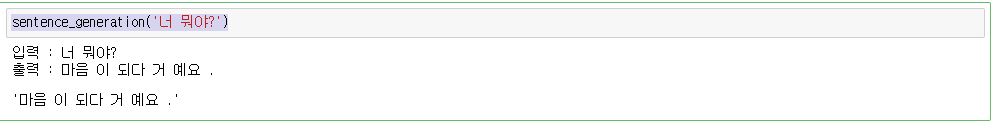sentence_generation('너 뭐야?')

In [ ]:
EPOCHS = 40

es = EarlyStopping(monitor='loss', patience=2, verbose=1)

model.fit(dataset, epochs=EPOCHS, callbacks=[es], verbose=1)

In [ ]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    predicted_id = tf.expand_dims(START_TOKEN, 0)
    while not tf.equal(predicted_id, END_TOKEN[0]):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
    
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [ ]:
sentence_generation('너 뭐야?')

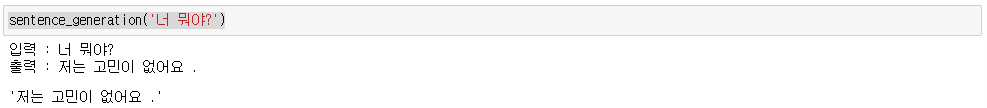

#### 표제어 추출했을시 대답

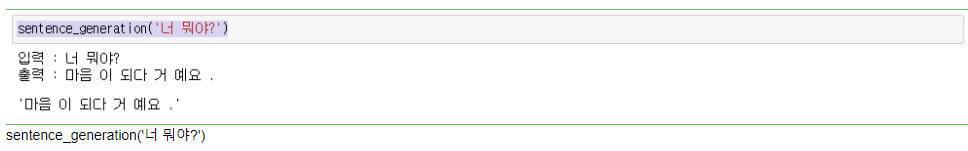

### 회고록
---
  
  
학습을 시키는데 같은 epoch을 줘도 랜덤하게 학습해서 다른 결과가 나와서 아쉬웠다.  
전처리 부분에서 표제어 추출을 진행하니 위 사진에서처럼 이상한 대답을 하는것을 볼 수 있었다.